# Identify spatially varying genes in spatially varying taxa



## Setup

In [5]:
import os 
import gc
import re
import csv
import glob
import math
import umap
import json
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
from time import time
from tqdm import tqdm
from scipy import stats
from collections import * 
from sklearn import cluster
from sklearn import decomposition
from ete4 import NCBITaxa, Tree
import matplotlib.pyplot as plt
import matplotlib.colors as pltc
from scipy.spatial import distance
from scipy.cluster import hierarchy
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from scipy import stats, special
from numba import njit, prange, set_num_threads


/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
os.chdir('/scratch/bgrodner/relative_abundance')

In [7]:
import sys
sys.path.append('/scratch/bgrodner/repo-armbrust-metat-search')

In [8]:
import functions.fn_metat_files as fnf
import functions.fn_correlation as fc
import functions.fn_regression_model as frm

In [9]:
ncbi = NCBITaxa()

In [10]:
%load_ext autoreload
%autoreload 2

In [11]:
os.getcwd()

'/scratch/bgrodner/relative_abundance'

In [12]:
workdir = '/scratch/bgrodner/p_calceolata_enterobactin'
os.chdir(workdir)


In [13]:
os.getcwd()

'/scratch/bgrodner/p_calceolata_enterobactin'

In [14]:
os.listdir()

['file_table.240210.kofam_filt.csv',
 'nb_enterobactin.ipynb',
 '.DS_Store',
 'nb_pelagophycae.ipynb',
 '.snakemake',
 'file_table.240307.pelagophyceae_taxids.csv',
 '._.DS_Store',
 'pelagophyceae_taxids.txt',
 'config.yaml',
 'metat_search_results',
 '._file_table.240307.pelagophyceae_taxids.csv',
 'sc_run_snakemake.sh',
 '._file_table.240210.kofam_filt.csv',
 'tidytable_enterobactin_kos.csv']

Plotting

In [15]:
def general_plot(
    xlabel="", ylabel="", ft=12, dims=(5, 3), col="k", lw=1, pad=0, tr_spines=True
):
    fig, ax = plt.subplots(figsize=(dims[0], dims[1]), tight_layout={"pad": pad})
    for i in ax.spines:
        ax.spines[i].set_linewidth(lw)
    if not tr_spines:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
    else:
        ax.spines["top"].set_color(col)
        ax.spines["right"].set_color(col)
    ax.spines["bottom"].set_color(col)
    ax.spines["left"].set_color(col)
    ax.tick_params(direction="in", labelsize=ft, color=col, labelcolor=col)
    ax.set_xlabel(xlabel, fontsize=ft, color=col)
    ax.set_ylabel(ylabel, fontsize=ft, color=col)
    ax.patch.set_alpha(0)
    return (fig, ax)

def plot_umap(
    embedding,
    figsize=(10, 10),
    markersize=10,
    alpha=0.5,
    colors="k",
    xticks=[],
    yticks=[],
    markerstyle='o',
    cmap_name='tab20',
    cl_lab=False
):
    fig, ax = general_plot(dims=figsize)
    if isinstance(markerstyle, str):
        ax.scatter(
            embedding[:, 0],
            embedding[:, 1],
            s=markersize,
            alpha=alpha,
            c=colors,
            edgecolors="none",
            marker=markerstyle,
            cmap=cmap_name
        )
    else:
        for e0, e1, c, m in zip(
            embedding[:, 0], 
            embedding[:, 1],
            colors,
            markerstyle 
        ):
            ax.scatter(
                e0,
                e1,
                s=markersize,
                alpha=alpha,
                c=c,
                edgecolors="none",
                marker=m
            )
    ax.set_aspect("equal")
    if len(xticks) > 0:
        ax.set_xticks(xticks)
    if len(yticks) > 0:
        ax.set_yticks(yticks)
    ax.set_xlabel("UMAP 1")
    ax.set_ylabel("UMAP 2")
    return fig, ax


def general_plot(
    xlabel="", ylabel="", ft=12, dims=(5, 3), col="k", lw=1, pad=0, tr_spines=True
):
    fig, ax = plt.subplots(figsize=(dims[0], dims[1]), tight_layout={"pad": pad})
    for i in ax.spines:
        ax.spines[i].set_linewidth(lw)
    if not tr_spines:
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
    else:
        ax.spines["top"].set_color(col)
        ax.spines["right"].set_color(col)
    ax.spines["bottom"].set_color(col)
    ax.spines["left"].set_color(col)
    ax.tick_params(direction="in", labelsize=ft, color=col, labelcolor=col)
    ax.set_xlabel(xlabel, fontsize=ft, color=col)
    ax.set_ylabel(ylabel, fontsize=ft, color=col)
    ax.patch.set_alpha(0)
    return (fig, ax)


def plot_umap(
    embedding,
    figsize=(10, 10),
    markersize=10,
    alpha=0.5,
    colors="k",
    xticks=[],
    yticks=[],
    markerstyle='o'
):
    fig, ax = general_plot(dims=figsize)
    if isinstance(markerstyle, str):
        ax.scatter(
            embedding[:, 0],
            embedding[:, 1],
            s=markersize,
            alpha=alpha,
            c=colors,
            edgecolors="none",
            marker=markerstyle
        )
    else:
        for e0, e1, c, m in zip(
            embedding[:, 0], 
            embedding[:, 1],
            colors,
            markerstyle 
        ):
            ax.scatter(
                e0,
                e1,
                s=markersize,
                alpha=alpha,
                c=c,
                edgecolors="none",
                marker=m
            )
    ax.set_aspect("equal")
    if len(xticks) > 0:
        ax.set_xticks(xticks)
    if len(yticks) > 0:
        ax.set_yticks(yticks)
    ax.set_xlabel("UMAP 1")
    ax.set_ylabel("UMAP 2")
    return fig, ax


def get_colors_from_stringlist(stringlist, order="", cmap_name="viridis"):
    if not order:
        order = list(set(stringlist))
    n_strings = len(order)
    cmap = plt.get_cmap(cmap_name)
    colors = [cmap(i / n_strings) for i in range(n_strings)]
    dict_str_col = {s: c for s, c in zip(order, colors)}
    return [dict_str_col[s] for s in stringlist], dict_str_col


def plot_legend(color_dict, figsize=(2, 4)):
    fig, ax = general_plot(dims=figsize)
    # Create legend handles manually
    legend_handles = []
    for value, color in color_dict.items():
        patch = mpatches.Patch(color=color, label=value)
        legend_handles.append(patch)

    # Add legend to the plot
    ax.legend(handles=legend_handles)
    return fig, ax


def taxon_legend(
    taxon_names,
    taxon_colors,
    label_color="k",
    taxon_counts=[],
    text_shift_vh=(6, 0.15),
    ft=20,
    dims=(6, 10),
    lw=2,
    ylabel="Genus",
):
    fig, ax = general_plot(ylabel=ylabel, dims=dims, col=label_color, lw=lw, ft=ft)
    vals = np.repeat(10, len(taxon_names))
    y_pos = np.arange(len(taxon_names))
    ax.barh(y_pos, vals, align="center", color=taxon_colors)
    if len(taxon_counts) > 0:
        # Label the legend with counts
        for i, (v, c) in enumerate(zip(vals, taxon_counts)):
            ax.text(
                v - text_shift_vh[0],
                i + text_shift_vh[1],
                str(c),
                color="k",
                fontsize=ft,
            )
    # Remove the boundaries
    for spine in ax.spines.values():
        spine.set_visible(False)
    # Add the genus names to the y axis
    ax.set_yticks(y_pos)
    ax.set_xticks([])
    ax.set_yticklabels(taxon_names)
    ax.invert_yaxis()
    return (fig, ax)


def marker_legend(
    names,
    markers,
    label_color="k",
    text_shift_hv=(0.5, 0),
    markersize=50,
    ft=20,
    dims=(3, 3),
    lw=2,
    ylabel="Genus",
):
    fig, ax = general_plot(ylabel=ylabel, dims=dims, col=label_color, lw=lw, ft=ft)
    for i, (n, m) in enumerate(zip(names, markers)):
        ax.scatter(0, i, marker=m, c=label_color, s=markersize)
        # ax.text(
        #     0 - text_shift_hv[0],
        #     i + text_shift_hv[1],
        #     str(n),
        #     color=label_color,
        #     fontsize=ft,
        #     va="center",
        # )
    # Remove the boundaries
    for spine in ax.spines.values():
        spine.set_visible(False)
    # Add the genus names to the y axis

    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, i + 1])

    ax.set_yticks(np.arange(i+1))
    ax.set_xticks([])
    ax.set_yticklabels(names)
    ax.invert_yaxis()
    ax.invert_yaxis()
    return fig, ax

#### Get KO dict

Get dataframe

In [16]:
ko_fn = "../iron_ko_contigs/ko00001.json"
database = list()
for _, v in pd.read_json(ko_fn).iterrows():
    d = v["children"]
    cat_1 = d["name"]
    for child_1 in d["children"]:
        cat_2 = child_1["name"] # Module?
        for child_2 in child_1["children"]:
            cat_3 = child_2["name"]
            if "children" in child_2:
                for child_3 in child_2["children"]:
                    cat_4 = child_3["name"]
                    fields = [cat_1, cat_2, cat_3, cat_4]
                    database.append(fields)
df_kegg = pd.DataFrame(database, columns=["Level_A", "Level_B", "Level_C", "Level_D"])
df_kegg.shape


(61993, 4)

In [17]:
ld = df_kegg['Level_D'].values
ld[:5]

array(['K00844  HK; hexokinase [EC:2.7.1.1]',
       'K12407  GCK; glucokinase [EC:2.7.1.2]',
       'K00845  glk; glucokinase [EC:2.7.1.2]',
       'K25026  glk; glucokinase [EC:2.7.1.2]',
       'K01810  GPI, pgi; glucose-6-phosphate isomerase [EC:5.3.1.9]'],
      dtype=object)

In [18]:
dict_ko_name = {}
for name in ld:
    ko = re.search(r"^\w+",name)[0]
    dict_ko_name[ko] = name

Get metadata table

In [19]:
metadata_path = "/scratch/bgrodner/iron_ko_contigs/metat_search_results/dicts_iron_KO_contig/tidy_tables/merge_all/iron_KOs.txt-metadata.csv"  # input('Enter the filepath of your batch metadata file:')
metadata = pd.read_csv(metadata_path)
metadata.iloc[[1,100,200],:]

assembly sample  latitude ammendment     timepoint  depth   size rep  \
1       D1PA  S15C1       NaN        NaN           200    NaN    NaN   C   
100     G1NS  S11C1  36.57deg        NaN  4_29_16-6:34  15.0m  0.2um   B   
200     G2PA  S06C1  39.76deg        NaN           NaN  15.0m  0.2um   B   

                              fn_sample_counts  \
1               D1PA.S15C1_C_200.abundance.tsv   
100                     G1NS.S11C1_0_2um.B.tsv   
200  G2PA.G2PA.S06C1.15m.0_2um.B.abundance.tsv   

                                      assm_sample  norm_factor  
1                                  D1PA-S15C1-200  1970.000000  
100  G1NS-S11C1-36.57deg-4_29_16-6:34-15.0m-0.2um  3654.720049  
200               G2PA-S06C1-39.76deg-15.0m-0.2um  7091.826806

Correct G1 S11C1 latitudes

In [20]:
metadata.shape

(531, 11)

In [21]:
lats_new = []
for i, row in metadata.iterrows():
    if (row['sample'] == 'S11C1') & ('G1' in row['assembly']):
        lats_new.append('36.569deg')
    else:
        lats_new.append(row.latitude)
metadata['latitude'] = lats_new
metadata.iloc[[1,100,200,500],:]

assembly sample   latitude ammendment     timepoint  depth   size rep  \
1       D1PA  S15C1        NaN        NaN           200    NaN    NaN   C   
100     G1NS  S11C1  36.569deg        NaN  4_29_16-6:34  15.0m  0.2um   B   
200     G2PA  S06C1   39.76deg        NaN           NaN  15.0m  0.2um   B   
500       G5   Mix1        NaN        DON            T2    NaN    NaN   C   

                              fn_sample_counts  \
1               D1PA.S15C1_C_200.abundance.tsv   
100                     G1NS.S11C1_0_2um.B.tsv   
200  G2PA.G2PA.S06C1.15m.0_2um.B.abundance.tsv   
500                       G5.Mix1.DON.T2.C.tsv   

                                      assm_sample  norm_factor  
1                                  D1PA-S15C1-200  1970.000000  
100  G1NS-S11C1-36.57deg-4_29_16-6:34-15.0m-0.2um  3654.720049  
200               G2PA-S06C1-39.76deg-15.0m-0.2um  7091.826806  
500                                G5-Mix1-DON-T2  4262.243999

Get cruise column

In [22]:
metadata.assembly.unique()

array(['D1PA', 'G1PA', 'G1NS', 'G2PA', 'G2NS', 'G3PA', 'G3PA.diel',
       'G3.UW.NS', 'G3PA.PM', 'G5'], dtype=object)

In [23]:
skp = ['D1PA','G3PA.diel','G3PA.PM','G5']
metadata['cruise'] = [assm[:2] if assm not in skp else assm for assm in metadata.assembly]
sels = []
for assm in metadata.assembly:
    if 'NS' in assm:
        sels.append('NS')
    elif assm == 'G5':
        sels.append('NS')
    else:
        sels.append('PA')

metadata['selection'] = sels
metadata.cruise.unique(), metadata.selection.unique()

(array(['D1PA', 'G1', 'G2', 'G3', 'G3PA.diel', 'G3PA.PM', 'G5'],
       dtype=object),
 array(['PA', 'NS'], dtype=object))

Batch column

In [24]:
batchs = []
for i, row in metadata.iterrows():
    cruise, sel, size = [row[v] for v in ['cruise','selection','size']]
    batchs.append(f'{cruise}_{sel}_{size}')

metadata['batch'] = batchs

Map fnsamplecounts to metadata

In [25]:
dict_meta = {}
for i, row in metadata.iterrows():
    dict_meta[row['fn_sample_counts']] = row.to_dict()

In [26]:
dict_assam_meta = {}
for i, row in metadata.iterrows():
    dict_assam_meta[row['assm_sample']] = row.to_dict()

In [27]:
dict_batch_meta = {}
for i, row in metadata.iterrows():
    dict_batch_meta[row['batch']] = row.to_dict()

In [28]:
dict_assam_lat = dict(zip(metadata['assm_sample'], metadata['latitude']))


TZCF info

In [29]:
dict_cruise_trans_sal_chl = {
    'G1': [32.15, 33.0],
    'G2': [32.5, 36.2],
    'G3': [32.34, 35],
}

## Load Data

Load iron ko dict

In [30]:
fn_tidy_ironko = '/scratch/bgrodner/iron_ko_contigs/metat_search_results/dicts_iron_KO_contig/tidy_tables/merge_all/iron_KOs.txt-tidy_all.csv'

# open read 
dict_iron_taxon_ko_sample_estcounts = defaultdict(
    lambda: defaultdict(
        lambda: defaultdict(float)
    )
)
with open(fn_tidy_ironko, 'r') as fr:
    row = next(fr)
    for row in fr:
        contig, sample, ko, tax, estcounts = row.split(",")
        dict_iron_taxon_ko_sample_estcounts[tax][ko][sample] += float(estcounts)

Load taxa groups of spatial profiles

In [31]:
fn_out = '/scratch/bgrodner/relative_abundance/metat_search_results/latitude_tzcf_glm/dict_sel_sz_profiletype_taxa.json'
with open(fn_out, 'r') as f:
    dict_sel_sz_ptype_taxa = json.load(f)

Load taxon estcounts dict

In [32]:
fn_relabund = '/scratch/bgrodner/relative_abundance/metat_search_results/sample_taxa_estcounts/merge-sample_taxid_estcounts-tidy.txt'

dict_sel_sz_tax_sample_estcounts = defaultdict(
    lambda: defaultdict(
        lambda: defaultdict(dict)
    )
)
# for i, row in df_norm_abund.iterrows():
#     dict_tax_sam_ectotal[row.taxid][row.assm_sample][row.rep] = row.estcounts
    
valtypes = ['frac','trl']
with open(fn_relabund, 'r') as fr:
    row = next(fr)
    for row in fr:
        # Read row
        _, sam, taxid, estcounts, frac_total_estcounts = row.split(",")
        # Get metadata 
        row_meta = dict_meta[sam]
        cruise = row_meta['cruise']
        if cruise in ['G1','G2','G3']:
            lat, sel, size, norm_factor, rep = [row_meta[v] for v in ['latitude','selection','size','norm_factor', 'rep']]
            dict_sel_sz_tax_sample_estcounts[sel][size][taxid][sam] = float(estcounts)



Get a frac and trl for taxa

In [33]:
fn_relabund = '/scratch/bgrodner/relative_abundance/metat_search_results/sample_taxa_estcounts/merge-sample_taxid_estcounts-tidy.txt'

dict_valtype_sel_sz_tax_sam_val = defaultdict(
    lambda: defaultdict(
        lambda: defaultdict(
            lambda: defaultdict(dict)
        )
    )
)

# for i, row in df_norm_abund.iterrows():
#     dict_tax_sam_ectotal[row.taxid][row.assm_sample][row.rep] = row.estcounts
    
# valtypes = ['frac','trl']
with open(fn_relabund, 'r') as fr:
    row = next(fr)
    for row in fr:
        # Read row
        _, sam, taxid, estcounts, frac_total_estcounts = row.split(",")
        # Get metadata 
        row_meta = dict_meta[sam]
        cruise = row_meta['cruise']
        # if cruise == 'G3PA.diel':
        #     date, time = row_meta['timepoint'].split('-')
        #     time = time.zfill(5)
        #     pred = f'{date}-{time}'
        # elif cruise == 'D1PA':
        #     sample = row_meta['sample']
        #     timepoint = row_meta['timepoint']
        #     pred = f'{sample}-{timepoint}'
        # elif cruise == 'G5':
        #     sample = row_meta['sample']
        #     ammend = row_meta['ammendment']
        #     pred = 
        valtypes = ['frac','trl']
        if cruise in ['G1','G2','G3']:
            lat, sel, size, norm_factor, rep = [row_meta[v] for v in ['latitude','selection','size','norm_factor', 'rep']]
            frac = float(frac_total_estcounts)
            trl = float(estcounts) * float(norm_factor)
            for vt, val in zip(valtypes, [frac, trl]):
                dict_valtype_sel_sz_tax_sam_val[vt][sel][size][taxid][sam] = val



Load total counts

In [34]:
dir_counts = '/scratch/bgrodner/iron_ko_contigs/metat_search_results/count_sums'
dirs_counts = glob.glob(f'{dir_counts}/*')
dict_sn_totalcount = {}
for d in dirs_counts:
    fns = glob.glob(f'{d}/*')
    for fn in fns:
        with open(fn, 'r') as f:
            count = float(next(f))
        sn = os.path.split(fn)[1]
        sn = sn.split('-count')[0]
        if 'PA' in sn:
            sn = sn.split('gz.')[1]
        dict_sn_totalcount[sn] = count


## Prepare sample x ko dataframe for glm fit on each taxon group

Get total estcounts for taxa in each group

In [30]:
dict_sel_sz_ptype_sam_estcounts = defaultdict(
    lambda: defaultdict(
        lambda: defaultdict(
            lambda: defaultdict(float)
        )
    )
)
for sel, dict_sz_ptype_taxa in dict_sel_sz_ptype_taxa.items():
    for sz, dict_ptype_taxa in dict_sz_ptype_taxa.items():
        for ptype, taxa in dict_ptype_taxa.items():
            for tax in taxa:
                for sample, estcounts in dict_sel_sz_tax_sample_estcounts[sel][sz][tax].items():
                    dict_sel_sz_ptype_sam_estcounts[sel][sz][ptype][sample] += estcounts


Get gene relative abundance within each group

In [31]:
dict_sel_sz_ptype_ko_sam_frac = defaultdict(
    lambda: defaultdict(
        lambda: defaultdict(
            lambda: defaultdict(dict)
        )
    )
)

for sel, dict_sz_ptype_taxa in dict_sel_sz_ptype_taxa.items():
    for sz, dict_ptype_taxa in dict_sz_ptype_taxa.items():
        for ptype, taxa in dict_ptype_taxa.items():
            dict_sam_ptypecounts = dict_sel_sz_ptype_sam_estcounts[sel][sz][ptype]
            for tax in taxa:
                for sample, ptypecounts in dict_sam_ptypecounts.items():
                    for ko, dict_sam_kocounts in dict_iron_taxon_ko_sample_estcounts[tax].items():
                        dict_sel_sz_ptype_ko_sam_frac[sel][sz][ptype][ko][sample] = (
                            dict_sam_kocounts[sample] / ptypecounts
                        )

Build prediction dataframe for each group

In [32]:
dict_sel_sz_ptype_preddf = defaultdict(
    lambda: defaultdict(dict)
)
for sel, dict_sz_ptype_ko_sam_frac in dict_sel_sz_ptype_ko_sam_frac.items():
    for sz, dict_ptype_ko_sam_frac in dict_sz_ptype_ko_sam_frac.items():
        for ptype, dict_ko_sam_frac in dict_ptype_ko_sam_frac.items():
            df = pd.DataFrame(dict_ko_sam_frac)
            cruises = []
            lat_diffs = []
            for sam in df.index:
                row_meta = dict_meta[sam]
                lat, cruise = [row_meta[v] for v in ['latitude','cruise']]
                lat = float(lat.strip('deg'))
                _, tzcf = dict_cruise_trans_sal_chl[cruise]
                lat_diff = lat - tzcf
                cruises.append(cruise)
                lat_diffs.append(lat_diff)
            df['cruise'] = cruises
            df['lat_diff'] = lat_diffs
            dict_sel_sz_ptype_preddf[sel][sz][ptype] = df


## Fit GLM on each gene in each group

Run on all sel sz ptype options:

In [44]:
# Fraction of samples that must be nonzero in each cruise for the taxon to be included
thresh_fgt0 = 0.5
# Number of permutations for p value on latitude effect
n_perm = 1000
# Define outliers as > q3 + IQR * coeff and < q1 - IQR * coeff
iqr_coefficient = 10 
# number of cores to use
n_jobs = 100
# Ouptut location
dir_glm = '/scratch/bgrodner/iron_ko_contigs/metat_search_results/spatial_variability_latitude_tzcf_glm'
fmt_out = dir_glm + '/model_results/iron_ko_latitude_tzcf_glm_results_{sel}_{sz}_taxon_profile_{ptype}.json'

# Variable to save things to:
dict_sel_sz_ptype_glmresults = defaultdict(
    lambda: defaultdict(dict)
)

for sel, dict_sz_ptype_preddf in dict_sel_sz_ptype_preddf.items():
    for sz, dict_ptype_preddf in dict_sz_ptype_preddf.items():
        for ptype, preddf in dict_ptype_preddf.items():
            fn_out = fmt_out.format(sel=sel, sz=sz, ptype=ptype[:-1])
            # if not os.path.exists(fn_out):
            print(sel, sz, ptype)

            # Get a list of taxa
            response_cols = [c for c in preddf.columns if c not in ['lat_diff','cruise','rep']]

            # Subset based on minimum fraction of nonzero samples
            bool_tax = np.zeros(len(response_cols))
            # Each cruise must have the minimum number of nonzero samples for the KO to be included
            for cruise, df in preddf[response_cols + ['cruise']].groupby('cruise'):
                frac_gt0 = (df[response_cols] > 0).sum(axis=0) / df.shape[0]
                bool_tax += (frac_gt0 > thresh_fgt0).values.astype(int)
            bool_tax = bool_tax == 3
            response_cols_sub = np.array(response_cols)[bool_tax].tolist()


            # Fit the model
            results = frm.fit_many_models(
                data=preddf,
                response_cols=response_cols_sub,
                covariate_cols=['lat_diff'],
                poly_cols=['lat_diff'], 
                poly_degree=2,
                iqr_coefficient=iqr_coefficient,
                perm_test_vars=['lat_diff'], 
                n_perm=n_perm, 
                stat='coef',
                random_state=None,
                n_jobs=n_jobs,
            )
            dict_sel_sz_ptype_glmresults[sel][sz][ptype] = results

            # Save the model 
            dir_out = os.path.split(fn_out)[0]
            if not os.path.exists(dir_out): os.makedirs(dir_out)
            with open(fn_out, 'w') as f:
                json.dump(
                    results, 
                    f, 
                    sort_keys=True,
                    indent=4,
                    separators=(',', ': ')
                )

NS 0.2um frac_-1.0_trl_-1.0_


[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Done   2 out of   6 | elapsed:   21.4s remaining:   42.7s
[Parallel(n_jobs=100)]: Done   3 out of   6 | elapsed:   21.4s remaining:   21.4s
[Parallel(n_jobs=100)]: Done   4 out of   6 | elapsed:   21.6s remaining:   10.8s
[Parallel(n_jobs=100)]: Done   6 out of   6 | elapsed:   21.7s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


NS 0.2um frac_-1.0_trl_0_


[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:   32.3s
[Parallel(n_jobs=100)]: Done   2 out of  17 | elapsed:   32.3s remaining:  4.0min
[Parallel(n_jobs=100)]: Done   4 out of  17 | elapsed:   32.5s remaining:  1.8min
[Parallel(n_jobs=100)]: Done   6 out of  17 | elapsed:   32.6s remaining:   59.7s
[Parallel(n_jobs=100)]: Done   8 out of  17 | elapsed:   32.7s remaining:   36.7s
[Parallel(n_jobs=100)]: Done  10 out of  17 | elapsed:   32.7s remaining:   22.9s
[Parallel(n_jobs=100)]: Done  12 out of  17 | elapsed:   33.1s remaining:   13.8s
[Parallel(n_jobs=100)]: Done  14 out of  17 | elapsed:   33.5s remaining:    7.2s
[Parallel(n_jobs=100)]: Done  17 out of  17 | elapsed:   35.1s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


NS 0.2um frac_-1.0_trl_1.0_


[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:   37.8s
[Parallel(n_jobs=100)]: Done   5 out of  49 | elapsed:   37.9s remaining:  5.6min
[Parallel(n_jobs=100)]: Done  10 out of  49 | elapsed:   38.1s remaining:  2.5min
[Parallel(n_jobs=100)]: Done  15 out of  49 | elapsed:   38.2s remaining:  1.4min
[Parallel(n_jobs=100)]: Done  20 out of  49 | elapsed:   38.3s remaining:   55.5s
[Parallel(n_jobs=100)]: Done  25 out of  49 | elapsed:   38.4s remaining:   36.9s
[Parallel(n_jobs=100)]: Done  30 out of  49 | elapsed:   38.5s remaining:   24.4s
[Parallel(n_jobs=100)]: Done  35 out of  49 | elapsed:   38.6s remaining:   15.4s
[Parallel(n_jobs=100)]: Done  40 out of  49 | elapsed:   38.7s remaining:    8.7s
[Parallel(n_jobs=100)]: Done  45 out of  49 | elapsed:   38.8s remaining:    3.4s
[Parallel(n_jobs=100)]: Done  49 out of  49 | elapsed:   39.0s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Using backend LokyBacken

NS 0.2um frac_0_trl_-1.0_
NS 0.2um frac_0_trl_0_


[Parallel(n_jobs=100)]: Done   2 out of   5 | elapsed:   32.4s remaining:   48.5s
[Parallel(n_jobs=100)]: Done   3 out of   5 | elapsed:   32.4s remaining:   21.6s
[Parallel(n_jobs=100)]: Done   5 out of   5 | elapsed:   32.6s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


NS 0.2um frac_0_trl_1.0_


[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:   31.9s
[Parallel(n_jobs=100)]: Done   2 out of   7 | elapsed:   32.1s remaining:  1.3min
[Parallel(n_jobs=100)]: Done   3 out of   7 | elapsed:   32.2s remaining:   43.0s
[Parallel(n_jobs=100)]: Done   4 out of   7 | elapsed:   32.4s remaining:   24.3s
[Parallel(n_jobs=100)]: Done   5 out of   7 | elapsed:   32.5s remaining:   13.0s
[Parallel(n_jobs=100)]: Done   7 out of   7 | elapsed:   32.7s finished


NS 0.2um frac_1.0_trl_0_
NS 0.2um frac_1.0_trl_1.0_


[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Done   3 out of  28 | elapsed:   33.1s remaining:  4.6min
[Parallel(n_jobs=100)]: Done   6 out of  28 | elapsed:   33.9s remaining:  2.1min
[Parallel(n_jobs=100)]: Done   9 out of  28 | elapsed:   34.0s remaining:  1.2min
[Parallel(n_jobs=100)]: Done  12 out of  28 | elapsed:   34.2s remaining:   45.6s
[Parallel(n_jobs=100)]: Done  15 out of  28 | elapsed:   34.2s remaining:   29.7s
[Parallel(n_jobs=100)]: Done  18 out of  28 | elapsed:   34.4s remaining:   19.1s
[Parallel(n_jobs=100)]: Done  21 out of  28 | elapsed:   34.9s remaining:   11.6s
[Parallel(n_jobs=100)]: Done  24 out of  28 | elapsed:   35.1s remaining:    5.8s
[Parallel(n_jobs=100)]: Done  28 out of  28 | elapsed:   35.6s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Using backe

NS 0.2um trl_1.0_
NS 3.0um frac_-1.0_trl_-1.0_
NS 3.0um frac_-1.0_trl_0_
NS 3.0um frac_-1.0_trl_1.0_


[Parallel(n_jobs=100)]: Done   2 out of  11 | elapsed:   31.9s remaining:  2.4min
[Parallel(n_jobs=100)]: Done   4 out of  11 | elapsed:   32.1s remaining:   56.2s
[Parallel(n_jobs=100)]: Done   6 out of  11 | elapsed:   32.2s remaining:   26.9s
[Parallel(n_jobs=100)]: Done   8 out of  11 | elapsed:   32.3s remaining:   12.1s
[Parallel(n_jobs=100)]: Done  11 out of  11 | elapsed:   35.7s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


NS 3.0um frac_0_trl_-1.0_
NS 3.0um frac_0_trl_0_


[Parallel(n_jobs=100)]: Done   2 out of   2 | elapsed:   29.3s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


NS 3.0um frac_0_trl_1.0_


[Parallel(n_jobs=100)]: Done   2 out of   5 | elapsed:   31.7s remaining:   47.5s
[Parallel(n_jobs=100)]: Done   3 out of   5 | elapsed:   31.8s remaining:   21.2s
[Parallel(n_jobs=100)]: Done   5 out of   5 | elapsed:   32.3s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


NS 3.0um frac_1.0_trl_0_
NS 3.0um frac_1.0_trl_1.0_


[Parallel(n_jobs=100)]: Done   3 out of   3 | elapsed:   32.5s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


PA 0.2um frac_-1.0_trl_-1.0_
PA 0.2um frac_-1.0_trl_0_


[Parallel(n_jobs=100)]: Done   2 out of   5 | elapsed:   30.3s remaining:   45.4s
[Parallel(n_jobs=100)]: Done   3 out of   5 | elapsed:   30.3s remaining:   20.2s
[Parallel(n_jobs=100)]: Done   5 out of   5 | elapsed:   32.2s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


PA 0.2um frac_-1.0_trl_1.0_
PA 0.2um frac_0_trl_0_
PA 0.2um frac_0_trl_1.0_


[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:   30.9s
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


PA 0.2um frac_1.0_trl_1.0_
PA 3.0um frac_-1.0_trl_-1.0_
PA 3.0um frac_-1.0_trl_0_
PA 3.0um frac_-1.0_trl_1.0_


[Parallel(n_jobs=100)]: Done   2 out of   6 | elapsed:   29.3s remaining:   58.6s
[Parallel(n_jobs=100)]: Done   3 out of   6 | elapsed:   29.3s remaining:   29.3s
[Parallel(n_jobs=100)]: Done   4 out of   6 | elapsed:   29.3s remaining:   14.6s
[Parallel(n_jobs=100)]: Done   6 out of   6 | elapsed:   29.3s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


PA 3.0um frac_0_trl_0_
PA 3.0um frac_0_trl_1.0_
PA 3.0um frac_1.0_trl_1.0_


[Parallel(n_jobs=100)]: Done   2 out of   2 | elapsed:   32.0s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


Summarize each group

In [50]:
thresh_p = 0.05
cnames = ['lat_diff','lat_diff^2']

dict_sel_sz_ptype_posneg_kos = defaultdict(
    lambda: defaultdict(
        lambda: defaultdict(
            lambda: defaultdict(list)
        )
    )
)
for sel, dict_sz_ptype_glmresults in dict_sel_sz_ptype_glmresults.items():
    for sz, dict_ptype_glmresults in dict_sz_ptype_glmresults.items():
        for ptype, results in dict_ptype_glmresults.items():
            print(sel, sz, ptype)
            print('\t',len(results), 'genes')
            nposneg = defaultdict(list)
            for ko, res in results.items():
                coeffs = [res['model'][c] for c in cnames]
                pval = res['perm_pvalues']['p_value'][cnames[0]]
                if pval < thresh_p:
                    dict_sel_sz_ptype_posneg_kos[sz][sel][ptype][np.sign(coeffs[0])].append(ko)
                else:
                    dict_sel_sz_ptype_posneg_kos[sz][sel][ptype][0].append(ko)
            for posneg, name in zip([0,1,-1],['No significance','Positive','Negative']):
                kos = dict_sel_sz_ptype_posneg_kos[sz][sel][ptype][posneg]
                print('\t', name, f'- {len(kos)} genes')
                for ko in kos:
                    print('\t\t', dict_ko_name[ko])
    

NS 0.2um frac_-1.0_trl_-1.0_
	 6 genes
	 No significance - 0 genes
	 Positive - 2 genes
		 K00175  korB, oorB, oforB; 2-oxoglutarate/2-oxoacid ferredoxin oxidoreductase subunit beta [EC:1.2.7.3 1.2.7.11]
		 K04641  bop; bacteriorhodopsin
	 Negative - 4 genes
		 K16087  TC.FEV.OM3, tbpA, hemR, lbpA, hpuB, bhuR, hugA, hmbR; hemoglobin/transferrin/lactoferrin receptor protein
		 K19611  fepA, pfeA, iroN, pirA; ferric enterobactin receptor
		 K01623  ALDO; fructose-bisphosphate aldolase, class I [EC:4.1.2.13]
		 K04564  SOD2; superoxide dismutase, Fe-Mn family [EC:1.15.1.1]
NS 0.2um frac_-1.0_trl_0_
	 17 genes
	 No significance - 10 genes
		 K01803  TPI, tpiA; triosephosphate isomerase (TIM) [EC:5.3.1.1]
		 K15721  fyuA; pesticin/yersiniabactin receptor
		 K22552  mmcO; multicopper oxidase [EC:1.16.3.1]
		 K02574  napH; ferredoxin-type protein NapH
		 K00170  porB; pyruvate ferredoxin oxidoreductase beta subunit [EC:1.2.7.1]
		 K04642  hop; halorhodopsin
		 K02708  psbF; photosystem II cyt

In [51]:
dict_sel_sz_ptype_taxa['NS']['0.2um']['frac_-1.0_trl_1.0_']

['0', '1004268', '29488']

## Get overall trends in iron genes

Get all gene absolute and relative abundances and subset the cruises

In [80]:
dict_vt_sel_sz_ko_sample_estcounts = defaultdict(
    lambda: defaultdict(
        lambda: defaultdict(
            lambda: defaultdict(
                lambda: defaultdict(float)
            )
        )
    )
)
for _, dict_ko_sample_estcounts in dict_iron_taxon_ko_sample_estcounts.items():
    for ko, dict_sample_estcounts in dict_ko_sample_estcounts.items():
        for sample, estcounts in dict_sample_estcounts.items():
            row_meta = dict_meta[sample]
            cruise, sel, size = [row_meta[v] for v in ['cruise','selection','size']]
            if cruise in ['G1','G2','G3']:
                totalcount = dict_sn_totalcount[sample]
                norm_factor = dict_meta[sample]['norm_factor']
                vt = 'trl'
                dict_vt_sel_sz_ko_sample_estcounts[vt][sel][size][ko][sample] += estcounts * norm_factor
                vt = 'frac'
                dict_vt_sel_sz_ko_sample_estcounts[vt][sel][size][ko][sample] += estcounts / totalcount


Build prediction dataframe for each sel sz

In [81]:
dict_vt_sel_sz_allkopreddf = defaultdict(
    lambda: defaultdict(dict)
)
for vt, dict_sel_sz_ko_sample_estcounts in dict_vt_sel_sz_ko_sample_estcounts.items():
    for sel, dict_sz_ko_sample_estcounts in dict_sel_sz_ko_sample_estcounts.items():
        for sz, dict_ko_sample_estcounts in dict_sz_ko_sample_estcounts.items():
            df = pd.DataFrame(dict_ko_sample_estcounts)
            df = df.fillna(0)
            cruises = []
            lat_diffs = []
            sels = []
            szs = []
            reps = []
            for sam in df.index:
                row_meta = dict_meta[sam]
                lat, cruise, sel, sz, rep = [row_meta[v] for v in ['latitude','cruise','selection','size','rep']]
                lat = float(lat.strip('deg'))
                _, tzcf = dict_cruise_trans_sal_chl[cruise]
                lat_diff = lat - tzcf
                cruises.append(cruise)
                lat_diffs.append(lat_diff)
                sels.append(sel)
                szs.append(sz)
                reps.append(rep)
            df['cruise'] = cruises
            df['lat_diff'] = lat_diffs
            df['sel'] = sels
            df['size'] = szs
            df['rep'] = reps
            dict_vt_sel_sz_allkopreddf[vt][sel][sz] = df


Fit GLM on each sel sz

In [288]:
# Fraction of samples that must be nonzero in each cruise for the taxon to be included
thresh_fgt0 = 0.5
# Number of permutations for p value on latitude effect
n_perm = 1000
# Define outliers as > q3 + IQR * coeff and < q1 - IQR * coeff
iqr_coefficient = 10 
# number of cores to use
n_jobs = 1
# Ouptut location
dir_glm = '/scratch/bgrodner/iron_ko_contigs/metat_search_results/spatial_variability_latitude_tzcf_glm'
fmt_out = dir_glm + '/model_results/iron_ko_latitude_tzcf_glm_results_{sel}_{sz}_taxon_profile_all_valtype_{vt}.json'

# Variable to save things to:
dict_vt_sel_sz_overallkoresults = defaultdict(
    lambda: defaultdict(dict)
)
for vt, dict_sel_sz_allkopreddf in dict_vt_sel_sz_allkopreddf.items():
    for sel, dict_sz_allkopreddf in dict_sel_sz_allkopreddf.items():
        for sz, preddf in dict_sz_allkopreddf.items():
            if (vt == 'frac') & (sel == 'NS') & (sz == '0.2um'):
                fn_out = fmt_out.format(sel=sel, sz=sz, vt=vt)
                # if not os.path.exists(fn_out):
                print(sel, sz, vt)

                # Get a list of taxa
                response_cols = [c for c in preddf.columns if c not in ['lat_diff','cruise','rep','sel','size']]
                response_cols = response_cols[:1]

                # Subset based on minimum fraction of nonzero samples
                bool_tax = np.zeros(len(response_cols))
                # Each cruise must have the minimum number of nonzero samples for the KO to be included
                for cruise, df in preddf[response_cols + ['cruise']].groupby('cruise'):
                    frac_gt0 = (df[response_cols] > 0).sum(axis=0) / df.shape[0]
                    bool_tax += (frac_gt0 > thresh_fgt0).values.astype(int)
                bool_tax = bool_tax == 3
                response_cols_sub = np.array(response_cols)[bool_tax].tolist()


                # Fit the model
                results = frm.fit_many_models(
                    data=preddf,
                    response_cols=response_cols_sub,
                    covariate_cols=['lat_diff','cruise'],
                    poly_cols=['lat_diff'], 
                    poly_degree=2,
                    iqr_coefficient=iqr_coefficient,
                    perm_test_vars=['lat_diff'], 
                    n_perm=n_perm, 
                    stat='coef',
                    random_state=None,
                    n_jobs=n_jobs,
                )
                # dict_vt_sel_sz_overallkoresults[vt][sel][sz] = results

                # # Save the model 
                # dir_out = os.path.split(fn_out)[0]
                # if not os.path.exists(dir_out): os.makedirs(dir_out)
                # with open(fn_out, 'w') as f:
                #     json.dump(
                #         results, 
                #         f, 
                #         sort_keys=True,
                #         indent=4,
                #         separators=(',', ': ')
                #     )

NS 0.2um frac
chack


K00134
	 {'p_value': {'lr_stat': np.float64(0.0), 'lat_diff': np.float64(0.003), 'lat_diff^2': np.float64(0.996)}}


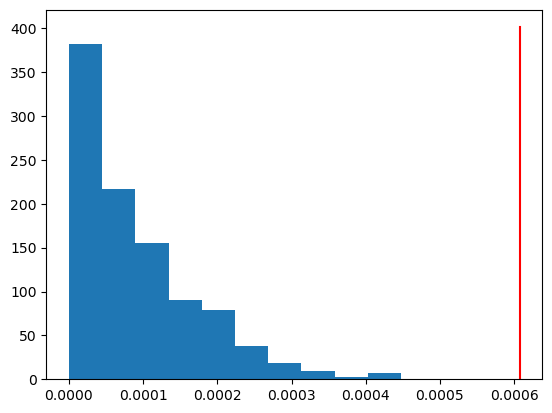

In [298]:
for tax, res in results.items():
    print(tax)
    print('\t',res['adj_perm_pvalues'])
    fig, ax = plt.subplots()
    ax.hist(res['perm_dict']['lat_diff']['lr_stat'])
    stat = res['lr_stat']
    ylims = ax.get_ylim()
    ax.plot([stat]*2, ylims, 'r')
    plt.show()




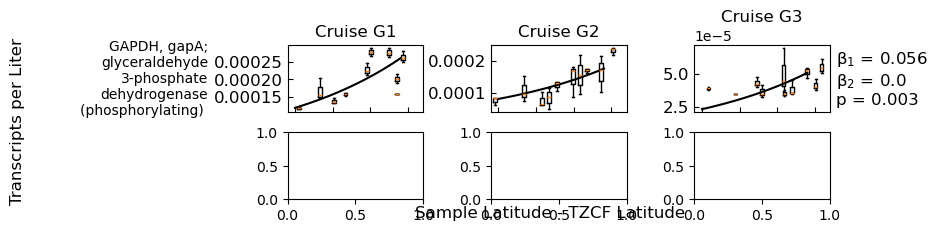

In [294]:
ft = 12
fig, axes = plt.subplots(2,3, figsize=(7,2))
lablen = 25

df = dict_vt_sel_sz_allkopreddf['frac']['NS']['0.2um'].copy()
label_cols = ['lat_diff','cruise','rep']
df = df[list(results.keys()) + label_cols]

for i, (ko) in enumerate(results):
    dict_res = results[ko]
    # PLot cruises
    const, ld, ld2 = [dict_res['model'][c] for c in ['const','lat_diff','lat_diff^2']]
    for j, cruise in enumerate(['G1','G2','G3']):
    # for j, cruise in enumerate(['G1']):
        df_piv = df[df['cruise'] == cruise].copy()
        if df_piv.shape[0] > 0:
            ax = axes[i,j]
            lats_unq = df_piv.lat_diff.unique()
            vals = []
            for l in lats_unq:
                vals.append(df_piv.loc[df_piv['lat_diff'] == l, ko].values)
            ax.boxplot(vals, positions=lats_unq)

            # Plot model
            crs = 0
            if not cruise == 'G1':
                crs = dict_res['model'][f'cruise_{cruise}']
            x = np.linspace(-10,4,100)
            # y = np.exp(const + ld*x + ld2*x**2 + ld3*x**3 + crs)
            y = np.exp(const + ld*x + ld2*x**2 + crs)
            ax.plot(x,y, 'k')

            x = np.arange(-10,10,5)
            ax.set_xticks(x)
            xticklabels = x if i == len(kos) - 1 else []
            ax.set_xticklabels(xticklabels)
            ax.set_xlim(-11,7)
            # ax.set_title(cruise, size=ft)
            ax.tick_params(direction="in", labelsize=ft)
            # if cruise == 'G3':
            #     ax.set_ylim(0,2e8)
            if j == 0:
                # Get gene description
                name = dict_ko_name[ko]
                nm = re.search(r'(?<=^K\d{5}\s\s).+', name)[0]
                splt = '[EC:'
                if splt in nm:
                    nm = nm.split(splt)[0]
                # Separate description on spaces
                lab = ''
                i_0 = 0
                i_1 = lablen
                while i_1 < len(nm):
                    l = nm[i_0:i_1]
                    if ' ' in l:
                        i_1 = l.rfind(' ')
                        lab += l[:i_1] + '\n'
                        i_0 = i_0 + i_1 + 1
                        i_1  = i_0 + lablen
                    else:
                        i_1 += lablen

                l = nm[i_0:]
                if len(l) > lablen:
                    if ' ' in l:
                        i_1 = l.rfind(' ')
                        lab += l[:i_1] + '\n'
                        i_0 = i_0 + i_1 + 1
                        l = nm[i_0:]
                lab += l
                ax.set_ylabel(lab, rotation=0, va='center',ha='right')
            if j == 2:
                p = dict_res['adj_perm_pvalues']['p_value']['lat_diff']
                sscrpt = [1,2]
                text = f'β$_{{1}}$ = {round(ld,3)}\nβ$_{{2}}$ = {round(ld2,3)}\np = {round(p,3)}'
                ax.yaxis.set_label_position("right")
                ax.set_ylabel(text, rotation=0, fontsize=ft, ha='left', va='center')
            if i == 0:
                ax.set_title(f'Cruise {cruise}')


fig.text(0.5, 0.08, f'Sample Latitude - TZCF Latitude', rotation=0, va='top',ha='center', fontsize=ft)
fig.text(-0.25, 0.5, f'Transcripts per Liter', rotation=90, va='center',ha='right', fontsize=ft)

plt.subplots_adjust(wspace=0.5, hspace=0.3)

# dir_out = '/scratch/bgrodner/iron_ko_contigs/metat_search_results/spatial_variability_latitude_tzcf_glm'
# fmt_out = f'{dir_out}/plots/ferritin_{sel}_size_{size}_trl_glm.{{ext}}'
# exts = ['png','pdf']
# do = os.path.split(fmt_out)[0]
# if not os.path.exists(do): os.makedirs(do)
# fns_out = [fmt_out.format(ext=ext) for ext in exts]
# for fn_out in fns_out:
#     plt.savefig(fn_out, dpi=500, bbox_inches='tight')


In [41]:
dir_glm = '/scratch/bgrodner/iron_ko_contigs/metat_search_results/spatial_variability_latitude_tzcf_glm'
fmt_out = dir_glm + '/model_results/iron_ko_latitude_tzcf_glm_results_{sel}_{sz}_taxon_profile_all_valtype_{vt}.json'

# Variable to save things to:
dict_vt_sel_sz_overallkoresults = defaultdict(
    lambda: defaultdict(dict)
)
for vt, dict_sel_sz_allkopreddf in dict_vt_sel_sz_allkopreddf.items():
    for sel, dict_sz_allkopreddf in dict_sel_sz_allkopreddf.items():
        for sz, preddf in dict_sz_allkopreddf.items():
            fn_out = fmt_out.format(sel=sel, sz=sz, vt=vt)
            with open(fn_out, 'r') as f:
                dict_vt_sel_sz_overallkoresults[vt][sel][sz] = json.load(f)

Make groups of genes

In [95]:
thresh_p = 0.05

cnames = ['lat_diff','lat_diff^2']
dict_valtype_sel_sz_ptype_genes = defaultdict(
    lambda: defaultdict(
        lambda: defaultdict(
            lambda: defaultdict(list)
        )
    )
)
for vt, dict_sel_sz_overallkoresults in dict_vt_sel_sz_overallkoresults.items():
    for sel, dict_sz_overallkoresults in dict_sel_sz_overallkoresults.items():
        for sz, results in dict_sz_overallkoresults.items():
            print(vt, sel, sz)
            sig = []
            nsig = []
            for tax, res in results.items():
                coeffs = [res['model'][c] for c in cnames]
                pval = res['adj_perm_pvalues']['p_value'][cnames[0]]
                sgn = 0
                if pval < thresh_p:
                    sgn = np.sign(coeffs[0])
                ptype = f'{sgn}'
                dict_valtype_sel_sz_ptype_genes[vt][sel][sz][ptype].append(tax)

                


trl PA 3.0um
trl PA 0.2um
trl NS 3.0um
trl NS 0.2um
frac PA 3.0um
frac PA 0.2um
frac NS 3.0um
frac NS 0.2um


Group genes by combination of trl and frac

In [96]:
dict_sel_sz_ko_ptypes = defaultdict(
    lambda: defaultdict(
        lambda: defaultdict(str)
    )
)
ptypes = ['1.0','0','-1.0']

for vt, dict_sel_sz_ptype_taxa in dict_valtype_sel_sz_ptype_genes.items():
    for sel, dict_sz_ptype_taxa in dict_sel_sz_ptype_taxa.items():
        for sz, dict_ptype_taxa in dict_sz_ptype_taxa.items():
            results = dict_vt_sel_sz_overallkoresults[vt][sel][sz]
            for i, ptype in enumerate(ptypes):
                taxa = dict_ptype_taxa[ptype]
                for tax in taxa:
                    dict_sel_sz_ko_ptypes[sel][sz][tax] += f'{vt}_{ptype}_'

In [97]:
dict_sel_sz_ptypes_kos = defaultdict(
    lambda: defaultdict(
        lambda: defaultdict(list)
    )
)
for sel, sz_dict in dict_sel_sz_ko_ptypes.items():
    for sz, tax_dict in sz_dict.items():
        for tax, ptype in tax_dict.items():
            dict_sel_sz_ptypes_kos[sel][sz][ptype].append(tax)


Inspect groups

In [98]:
for sel, dict_sz_ptypes_kos in dict_sel_sz_ptypes_kos.items():
    for sz, dict_ptypes_kos in dict_sz_ptypes_kos.items():
        for ptype, kos in dict_ptypes_kos.items():
            print(sel, sz, ptype)
            for ko in sorted(kos):
                name = dict_ko_name[ko]
                print('\t',name)


PA 3.0um trl_1.0_frac_1.0_
	 K00134  GAPDH, gapA; glyceraldehyde 3-phosphate dehydrogenase (phosphorylating) [EC:1.2.1.12]
	 K00265  gltB; glutamate synthase (NADPH) large chain [EC:1.4.1.13]
	 K00284  GLU, gltS; glutamate synthase (ferredoxin) [EC:1.4.7.1]
	 K00366  nirA; ferredoxin-nitrite reductase [EC:1.7.7.1]
	 K00392  sir; sulfite reductase (ferredoxin) [EC:1.8.7.1]
	 K00529  hcaD; 3-phenylpropionate/trans-cinnamate dioxygenase ferredoxin reductase component [EC:1.18.1.3]
	 K00533  E1.12.7.2L; ferredoxin hydrogenase large subunit [EC:1.12.7.2]
	 K00615  E2.2.1.1, tktA, tktB; transketolase [EC:2.2.1.1]
	 K00855  PRK, prkB; phosphoribulokinase [EC:2.7.1.19]
	 K00909  GRK1_7; rhodopsin kinase [EC:2.7.11.14]
	 K00927  PGK, pgk; phosphoglycerate kinase [EC:2.7.2.3]
	 K01012  bioB; biotin synthase [EC:2.8.1.6]
	 K01595  ppc; phosphoenolpyruvate carboxylase [EC:4.1.1.31]
	 K01601  rbcL, cbbL; ribulose-bisphosphate carboxylase large chain [EC:4.1.1.39]
	 K01623  ALDO; fructose-bisphospha

Select some genes to plot

In [99]:
dict_sel_sz_ptype_kostoplot = {
    'PA': {
        '3.0um': {
            # 'trl_1.0_frac_1.0_': [
            #     'K00134', # Gapdh
            #     'K02069', # iron transport
            #     'K07243', # fet
            #     'K25287', # desE
            #     'K02217', # ftn
            #     'K02638', # Plastocyanin
            #     'K03839', # flavodoxin
            #     'K03840', # Flavodoxin
            #     'K05337', # Ferredoxin
            # ],
            # 'trl_-1.0_frac_-1.0_': [
            #     'K00368', # nirK
            #     'K12346', # SMF
            #     'K11107', # yfaE

            # ]
            # 'trl_0_frac_-1.0_': [
            #     'K02639', # petF
            #     'K02717', # psbP
            #     'K04759', # feoB
            #     'K08906', # petJ
            #     'K19791', # fet3-5
            # ]
        },
        '0.2um': {
            # 'trl_1.0_frac_1.0_': [
            #     'K25224', # gapdh
            #     'K03839', # fldA
            #     'K03840', # fldB
            #     'K02638', # petE
            #     'K00366', # nirA
            #     'K22736', # VIT
            #     'K25287', # desE
            # ],
            # 'trl_-1.0_frac_-1.0_': [
            #     'K00266', # gltD
            #     'K11959', # urtA
            # ]
            
            # 'trl_1.0_frac_0_': [
            #     'K00134', # gapdh
            #     'K00522', # fth
            #     'K02011', # afuB
            #     'K02012', # afuA
            #     'K02013', # fev
            #     'K02016', # fev
            #     'K02068', # fetA
            #     'K08225', # entS

            # ]
        }
    },
    'NS': {
        '3.0um': {
            # 'trl_1.0_frac_1.0_': [                
            #     'K00363', # nirD
            #     'K01623', # ALDO
            #     'K03841', # fbp
            #     'K02638', # petE
            #     'K03839', # fldA
            #     'K03840', # fldB
            #     'K08906', # petJ
            #     'K06503', # TFRC
            #     'K23910', # TFR2
            #     'K14736', # TF
            #     'K25287', # desE
            # ],
            # 'trl_0_frac_-1.0_': [
            #     'K00362', # nirB
            #     'K07684', # narL
            #     'K07685', # narP
            #     'K09681', # gltC
            #     'K03594', # bfr
            #     'K05524', # fdxA
            #     'K07230', # p19
            #     'K04759', # feoB
            #     'K19791', # FET3
            #     'K03832', # tonB
            #     'K15721', #fyuA
            #     'K16087', # hemR
            #     'K16090', # fiu
            #     'K19611', # fepA
            # ],
            # 'trl_-1.0_frac_-1.0_': [
            #     'K02192', # bfd
            #     'K07673', # narX
            #     'K07674', # narQ
            #     'K11707', #troA
            #     'K11950', # cmpA
            #     'K12243', # pchR
            #     'K16088', # fhuE
            # ]
        },
        '0.2um': {
            'trl_1.0_frac_1.0_': [
                'K00134', # Gapdh
                'K00371', # narH
                'K01623', # ALDO
                'K02010', # afuC
                'K02012', # afuA
                'K02015', # FEV P
                'K02016', # FEV S
                'K02069', # fetB
                'K03839', # fldA
                'K03840', # fldB
                'K03841', # fbp
                'K06503', # TFRC
                'K07230', # p19
                'K14736', # TF
                'K25110', # fecC
                'K25130', # fecE
                'K25287', # desE
            ],
            # 'trl_-1.0_frac_-1.0_': [
            #     'K00204', # fwd
            #     'K00370', # narG
            #     'K03320', # amt
            #     'K11950', # cmpA
            #     'K15576', # nrtA
            #     'K24530', # mycCII
            # ]
        },
    },
}

**** NS 0.2um trl_1.0_frac_1.0_ *****

 K00134  GAPDH, gapA; glyceraldehyde 3-phosphate dehydrogenase (phosphorylating) [EC:1.2.1.12]
	 trl
	 {'const': 17.393395219630165, 'cruise_G2': -0.6192081621083837, 'cruise_G3': -1.154653229296418, 'lat_diff': 0.13935156812557978, 'lat_diff^2': 0.0007324254988956385}
	 {'p_value': {'lat_diff': np.float64(0.003920903954802261)}}
	 alpha {'alpha_used': np.float64(0.16559100818199998), 'pearson_chi2': np.float64(299664656.8531034), 'dispersion_ratio': np.float64(3942956.0112250447)}
	 n_outliers 1
	 n_skipped 0


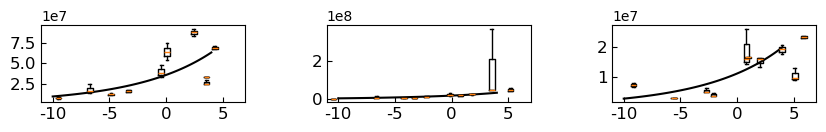

	 frac
	 {'const': -8.479479784840233, 'cruise_G2': -0.39614769807086875, 'cruise_G3': -1.6362761017308878, 'lat_diff': 0.055823205697966505, 'lat_diff^2': 1.986352834728363e-05}
	 {'p_value': {'lat_diff': np.float64(0.025703703703703704)}}
	 alpha {'alpha_used': 0, 'pearson_chi2': np.float64(0.0005462479346704074), 'dispersion_ratio': np.float64(7.094129021693603e-06)}
	 n_outliers 0
	 n_skipped 0


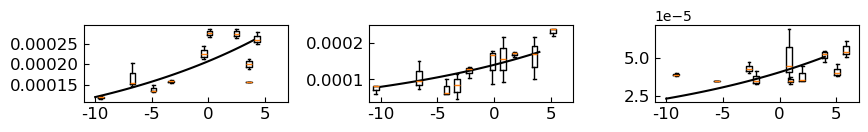


 K00371  narH, narY, nxrB; nitrate reductase / nitrite oxidoreductase, beta subunit [EC:1.7.5.1 1.7.99.-]
	 trl
	 {'const': 13.039611689030627, 'cruise_G2': 0.6050980834609374, 'cruise_G3': -0.978057192503802, 'lat_diff': 0.23942349641529748, 'lat_diff^2': 0.016139909331871535}
	 {'p_value': {'lat_diff': np.float64(0.005478947368421054)}}
	 alpha {'alpha_used': np.float64(0.15245492830363527), 'pearson_chi2': np.float64(21641726.64225376), 'dispersion_ratio': np.float64(284759.5610822863)}
	 n_outliers 1
	 n_skipped 0


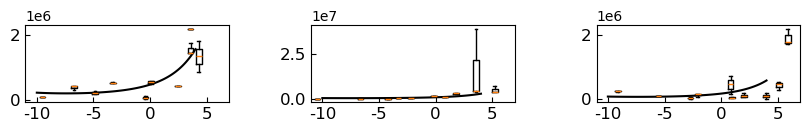

	 frac
	 {'const': -12.591844502428351, 'cruise_G2': 0.7747283493779785, 'cruise_G3': -1.570774281615117, 'lat_diff': 0.18291465793955064, 'lat_diff^2': 0.008255699043646633}
	 {'p_value': {'lat_diff': np.float64(0.01613953488372093)}}
	 alpha {'alpha_used': 0, 'pearson_chi2': np.float64(0.00012309700574674327), 'dispersion_ratio': np.float64(1.598662412295367e-06)}
	 n_outliers 0
	 n_skipped 0


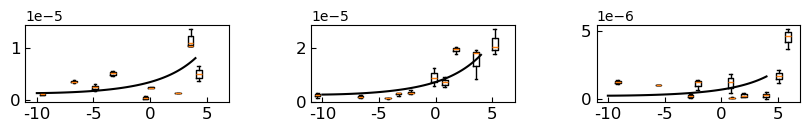


 K01623  ALDO; fructose-bisphosphate aldolase, class I [EC:4.1.2.13]
	 trl
	 {'const': 18.579782700377553, 'cruise_G2': -0.6907886724505923, 'cruise_G3': -1.085681497411052, 'lat_diff': 0.2057485177574121, 'lat_diff^2': 0.001297810188293582}
	 {'p_value': {'lat_diff': np.float64(0.0)}}
	 alpha {'alpha_used': np.float64(0.4426254529191073), 'pearson_chi2': np.float64(4107305207.773965), 'dispersion_ratio': np.float64(53341626.074986555)}
	 n_outliers 0
	 n_skipped 0


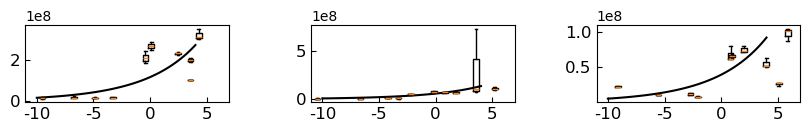

	 frac
	 {'const': -7.060607594184974, 'cruise_G2': -0.8141247119284948, 'cruise_G3': -1.8527685863545207, 'lat_diff': 0.10842611266245006, 'lat_diff^2': -0.0070472955884286325}
	 {'p_value': {'lat_diff': np.float64(0.08201818181818181)}}
	 alpha {'alpha_used': 0, 'pearson_chi2': np.float64(0.005691812315582685), 'dispersion_ratio': np.float64(7.39196404621128e-05)}
	 n_outliers 0
	 n_skipped 0


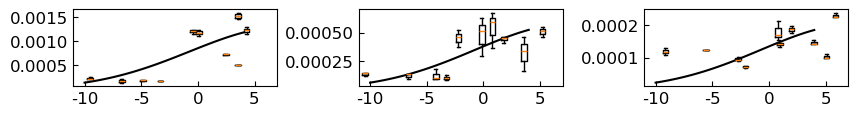


 K02010  afuC, fbpC; iron(III) transport system ATP-binding protein [EC:7.2.2.7]
	 trl
	 {'const': 14.137620032406282, 'cruise_G2': 0.5537254879564478, 'cruise_G3': 0.798769595458347, 'lat_diff': 0.1625224357241679, 'lat_diff^2': -0.0018150824565033826}
	 {'p_value': {'lat_diff': np.float64(0.0)}}
	 alpha {'alpha_used': np.float64(0.10226288555588273), 'pearson_chi2': np.float64(29860663.621374056), 'dispersion_ratio': np.float64(392903.4687022902)}
	 n_outliers 1
	 n_skipped 0


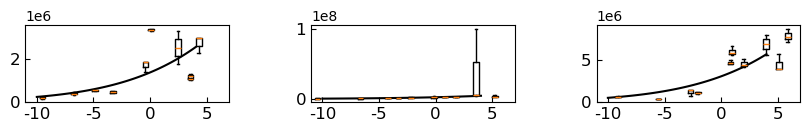

	 frac
	 {'const': -11.750215904679525, 'cruise_G2': 0.724717547662705, 'cruise_G3': 0.382722889533075, 'lat_diff': 0.07410441135368054, 'lat_diff^2': -0.00044861738979644697}
	 {'p_value': {'lat_diff': np.float64(0.009131578947368421)}}
	 alpha {'alpha_used': 0, 'pearson_chi2': np.float64(0.00011598760343244821), 'dispersion_ratio': np.float64(1.506332512109717e-06)}
	 n_outliers 0
	 n_skipped 0


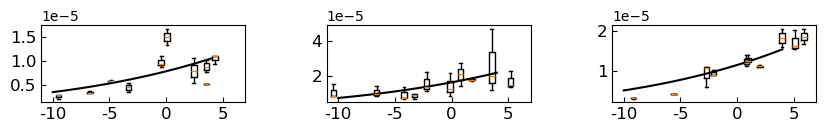


 K02012  afuA, fbpA; iron(III) transport system substrate-binding protein
	 trl
	 {'const': 16.870801023009562, 'cruise_G2': 0.940578382238207, 'cruise_G3': 1.0900264383992093, 'lat_diff': 0.15990708927324696, 'lat_diff^2': 0.003937356452432331}
	 {'p_value': {'lat_diff': np.float64(0.0)}}
	 alpha {'alpha_used': np.float64(0.5365938673090608), 'pearson_chi2': np.float64(2215847913.100603), 'dispersion_ratio': np.float64(28777245.624683157)}
	 n_outliers 0
	 n_skipped 0


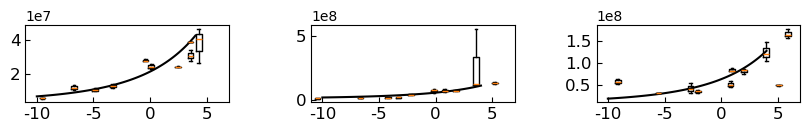

	 frac
	 {'const': -8.878946280470077, 'cruise_G2': 0.9185862514701394, 'cruise_G3': 0.5677528387252437, 'lat_diff': 0.05735832359874603, 'lat_diff^2': 0.000563706487921865}
	 {'p_value': {'lat_diff': np.float64(0.06309090909090909)}}
	 alpha {'alpha_used': 0, 'pearson_chi2': np.float64(0.0028194710768070052), 'dispersion_ratio': np.float64(3.6616507491000066e-05)}
	 n_outliers 0
	 n_skipped 0


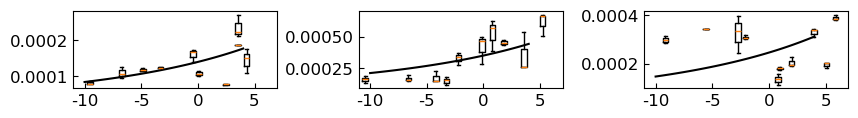


 K02015  ABC.FEV.P; iron complex transport system permease protein
	 trl
	 {'const': 12.61277211635821, 'cruise_G2': 0.858513826309806, 'cruise_G3': -0.0035095624441019158, 'lat_diff': 0.19480206585319543, 'lat_diff^2': 0.0012905483488246626}
	 {'p_value': {'lat_diff': np.float64(0.00216875)}}
	 alpha {'alpha_used': np.float64(0.2638681129061518), 'pearson_chi2': np.float64(14685061.397444338), 'dispersion_ratio': np.float64(195800.81863259117)}
	 n_outliers 2
	 n_skipped 0


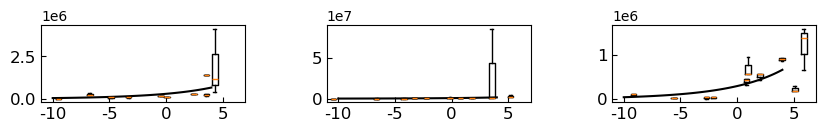

	 frac
	 {'const': -13.305293411375013, 'cruise_G2': 1.3358933213256108, 'cruise_G3': -0.5427844020051807, 'lat_diff': 0.1458395451925574, 'lat_diff^2': -2.153812153304473e-05}
	 {'p_value': {'lat_diff': np.float64(0.009131578947368421)}}
	 alpha {'alpha_used': 0, 'pearson_chi2': np.float64(0.00015480942273386468), 'dispersion_ratio': np.float64(2.0369660886034826e-06)}
	 n_outliers 1
	 n_skipped 0


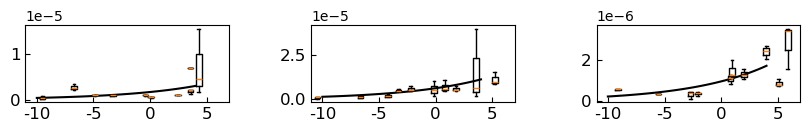


 K02016  ABC.FEV.S; iron complex transport system substrate-binding protein
	 trl
	 {'const': 14.935467210975402, 'cruise_G2': 0.2931933735506217, 'cruise_G3': -0.7673266438725836, 'lat_diff': 0.19030429784707267, 'lat_diff^2': 0.005631898377443067}
	 {'p_value': {'lat_diff': np.float64(0.0)}}
	 alpha {'alpha_used': np.float64(0.2633995463673532), 'pearson_chi2': np.float64(132243898.74221665), 'dispersion_ratio': np.float64(1740051.2992396927)}
	 n_outliers 1
	 n_skipped 0


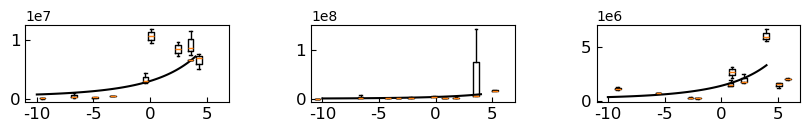

	 frac
	 {'const': -10.804889479033456, 'cruise_G2': 0.27648365829151644, 'cruise_G3': -1.5930432406234887, 'lat_diff': 0.13354949892693502, 'lat_diff^2': 0.00766861651052283}
	 {'p_value': {'lat_diff': np.float64(0.01613953488372093)}}
	 alpha {'alpha_used': 0, 'pearson_chi2': np.float64(0.0007021885218267451), 'dispersion_ratio': np.float64(9.119331452295391e-06)}
	 n_outliers 0
	 n_skipped 0


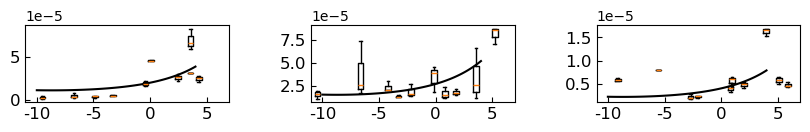


 K02069  STAR2, fetB; UDP-glucose/iron transport system permease protein
	 trl
	 {'const': 15.326922977411046, 'cruise_G2': 0.8309000695148757, 'cruise_G3': 0.10286784449540234, 'lat_diff': 0.1599650072115055, 'lat_diff^2': 0.006679976243279281}
	 {'p_value': {'lat_diff': np.float64(0.0)}}
	 alpha {'alpha_used': np.float64(0.18612535295431146), 'pearson_chi2': np.float64(197542489.18125528), 'dispersion_ratio': np.float64(2599243.2787007275)}
	 n_outliers 1
	 n_skipped 0


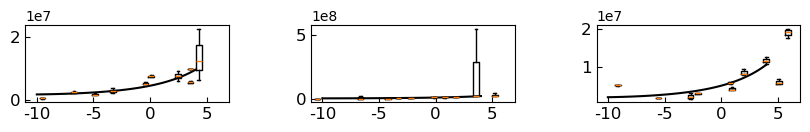

	 frac
	 {'const': -10.460805105371847, 'cruise_G2': 0.9768295344407542, 'cruise_G3': -0.4113981554401426, 'lat_diff': 0.08864068783057283, 'lat_diff^2': 0.005410426096762045}
	 {'p_value': {'lat_diff': np.float64(0.009131578947368421)}}
	 alpha {'alpha_used': 0, 'pearson_chi2': np.float64(0.0011513622605893938), 'dispersion_ratio': np.float64(1.4952756631031089e-05)}
	 n_outliers 0
	 n_skipped 0


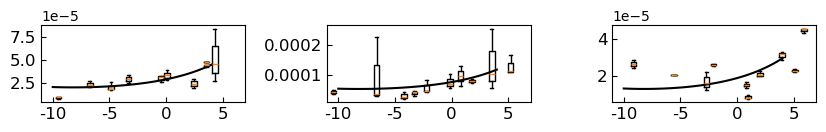


 K03839  fldA, nifF, isiB; flavodoxin I
	 trl
	 {'const': 16.989851996812448, 'cruise_G2': 0.7389129831835971, 'cruise_G3': -0.7471374634251874, 'lat_diff': 0.2508226224236522, 'lat_diff^2': -0.005104709960803141}
	 {'p_value': {'lat_diff': np.float64(0.0)}}
	 alpha {'alpha_used': np.float64(0.4578962469637908), 'pearson_chi2': np.float64(1142028560.6374369), 'dispersion_ratio': np.float64(14831539.74853814)}
	 n_outliers 0
	 n_skipped 0


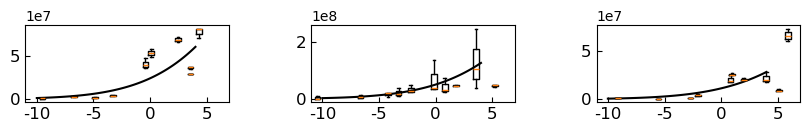

	 frac
	 {'const': -8.56586925962083, 'cruise_G2': 0.34284543563427056, 'cruise_G3': -1.2336704162610777, 'lat_diff': 0.09240940430903563, 'lat_diff^2': -0.013284613712458166}
	 {'p_value': {'lat_diff': np.float64(0.05648837209302326)}}
	 alpha {'alpha_used': 0, 'pearson_chi2': np.float64(0.0027526586314640215), 'dispersion_ratio': np.float64(3.574881339563664e-05)}
	 n_outliers 0
	 n_skipped 0


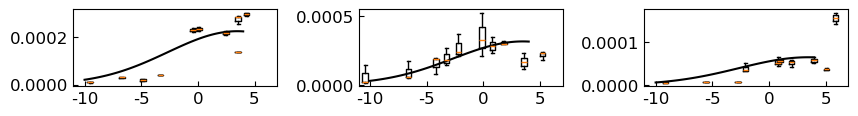


 K03840  fldB; flavodoxin II
	 trl
	 {'const': 16.873233118256724, 'cruise_G2': 0.021833072539093085, 'cruise_G3': -0.8787515260292786, 'lat_diff': 0.3330216948116002, 'lat_diff^2': -0.0036392997984475497}
	 {'p_value': {'lat_diff': np.float64(0.0)}}
	 alpha {'alpha_used': np.float64(0.1969601153869237), 'pearson_chi2': np.float64(506782021.95960647), 'dispersion_ratio': np.float64(6581584.70077411)}
	 n_outliers 0
	 n_skipped 0


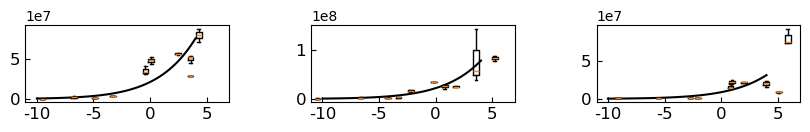

	 frac
	 {'const': -8.785332517920484, 'cruise_G2': -0.08574899358205045, 'cruise_G3': -1.4348972315978876, 'lat_diff': 0.22083244197680782, 'lat_diff^2': -0.009517431708889995}
	 {'p_value': {'lat_diff': np.float64(0.0)}}
	 alpha {'alpha_used': 0, 'pearson_chi2': np.float64(0.0018887337388122315), 'dispersion_ratio': np.float64(2.4529009594964046e-05)}
	 n_outliers 0
	 n_skipped 0


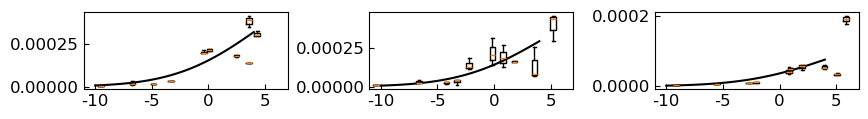


 K03841  FBP, fbp; fructose-1,6-bisphosphatase I [EC:3.1.3.11]
	 trl
	 {'const': 16.40487032669178, 'cruise_G2': -1.0781755860364688, 'cruise_G3': -1.713747932562753, 'lat_diff': 0.23942574524921073, 'lat_diff^2': 0.010551328167297185}
	 {'p_value': {'lat_diff': np.float64(0.0)}}
	 alpha {'alpha_used': np.float64(0.154203302790624), 'pearson_chi2': np.float64(181628283.28928325), 'dispersion_ratio': np.float64(2389845.8327537267)}
	 n_outliers 1
	 n_skipped 0


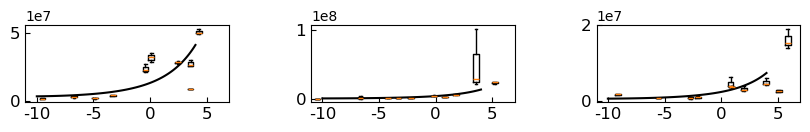

	 frac
	 {'const': -9.347875967170236, 'cruise_G2': -0.932168674825208, 'cruise_G3': -2.3632023393365547, 'lat_diff': 0.16559899518225932, 'lat_diff^2': 0.006773174391819082}
	 {'p_value': {'lat_diff': np.float64(0.025703703703703704)}}
	 alpha {'alpha_used': 0, 'pearson_chi2': np.float64(0.0006506583985200993), 'dispersion_ratio': np.float64(8.450109071689601e-06)}
	 n_outliers 0
	 n_skipped 0


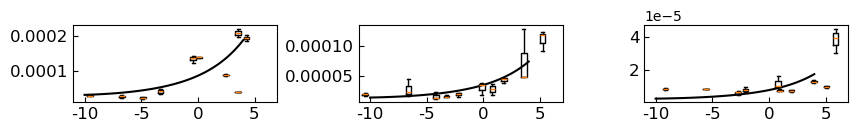


 K06503  TFRC, CD71; transferrin receptor
	 trl
	 {'const': 13.127280661724718, 'cruise_G2': 0.12435682374139867, 'cruise_G3': 0.2657068400196387, 'lat_diff': 0.17190753766339056, 'lat_diff^2': -0.0006005652009863811}
	 {'p_value': {'lat_diff': np.float64(0.0)}}
	 alpha {'alpha_used': np.float64(0.5320809148400072), 'pearson_chi2': np.float64(30914161.966950748), 'dispersion_ratio': np.float64(412188.82622601)}
	 n_outliers 2
	 n_skipped 0


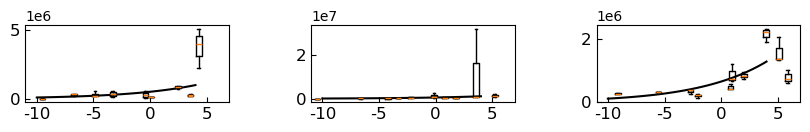

	 frac
	 {'const': -12.571489846100665, 'cruise_G2': 0.15828559088059846, 'cruise_G3': -0.4078707808205766, 'lat_diff': 0.11297315106945073, 'lat_diff^2': 0.0023850445933359596}
	 {'p_value': {'lat_diff': np.float64(0.0422027027027027)}}
	 alpha {'alpha_used': 0, 'pearson_chi2': np.float64(0.00019171149700317387), 'dispersion_ratio': np.float64(2.4897597013399204e-06)}
	 n_outliers 0
	 n_skipped 0


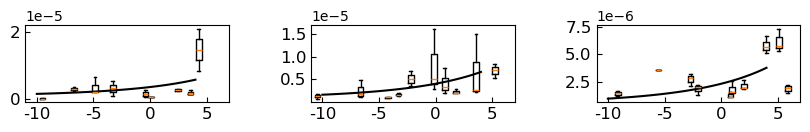


 K07230  p19, ftrA; periplasmic iron binding protein
	 trl
	 {'const': 12.538476270076814, 'cruise_G2': 2.3891667935843444, 'cruise_G3': 1.2161220114152995, 'lat_diff': 0.18707573057685786, 'lat_diff^2': 0.00015784982263912723}
	 {'p_value': {'lat_diff': np.float64(0.0)}}
	 alpha {'alpha_used': np.float64(0.3352923035762419), 'pearson_chi2': np.float64(48352789.73231805), 'dispersion_ratio': np.float64(636220.9175305007)}
	 n_outliers 1
	 n_skipped 0


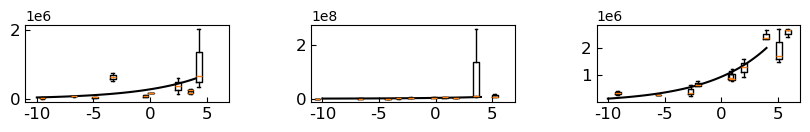

	 frac
	 {'const': -13.315707621651438, 'cruise_G2': 2.6732791249521477, 'cruise_G3': 0.7263819425759379, 'lat_diff': 0.1392364682298261, 'lat_diff^2': 0.00033444322345957053}
	 {'p_value': {'lat_diff': np.float64(0.045064935064935065)}}
	 alpha {'alpha_used': 0, 'pearson_chi2': np.float64(0.00044445083777682327), 'dispersion_ratio': np.float64(5.7720888022964065e-06)}
	 n_outliers 0
	 n_skipped 0


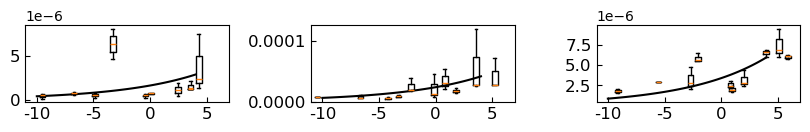


 K14736  TF; transferrin
	 trl
	 {'const': 13.083580559086588, 'cruise_G2': -1.096861169081444, 'cruise_G3': 0.5092155814032842, 'lat_diff': 0.30719719990782496, 'lat_diff^2': -0.0013587141242016206}
	 {'p_value': {'lat_diff': np.float64(0.00216875)}}
	 alpha {'alpha_used': np.float64(0.5895973377985261), 'pearson_chi2': np.float64(46375970.867062464), 'dispersion_ratio': np.float64(610210.142987664)}
	 n_outliers 1
	 n_skipped 0


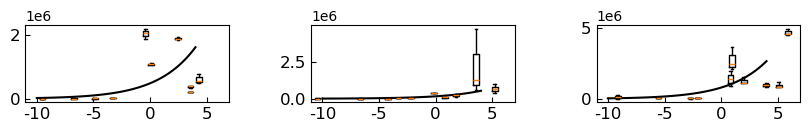

	 frac
	 {'const': -12.583298273339615, 'cruise_G2': -0.8777352900363912, 'cruise_G3': -0.10752182670154098, 'lat_diff': 0.20200969496986815, 'lat_diff^2': -0.017575421224086125}
	 {'p_value': {'lat_diff': np.float64(0.0216875)}}
	 alpha {'alpha_used': 0, 'pearson_chi2': np.float64(0.00018570982486677267), 'dispersion_ratio': np.float64(2.411815907360684e-06)}
	 n_outliers 0
	 n_skipped 0


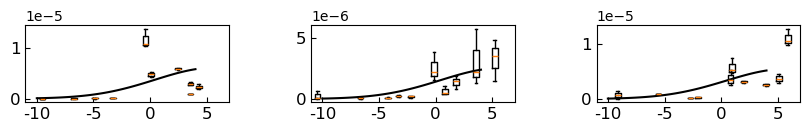


 K25110  sirB, fecC, cbrB; iron-siderophore transport system permease protein
	 trl
	 {'const': 11.891217297651142, 'cruise_G2': 0.8842384836581766, 'cruise_G3': 0.31820304229433777, 'lat_diff': 0.17189614806208722, 'lat_diff^2': -0.00321037509117798}
	 {'p_value': {'lat_diff': np.float64(0.008422330097087379)}}
	 alpha {'alpha_used': np.float64(0.6323516468671446), 'pearson_chi2': np.float64(14149783.466771225), 'dispersion_ratio': np.float64(186181.36140488452)}
	 n_outliers 1
	 n_skipped 0


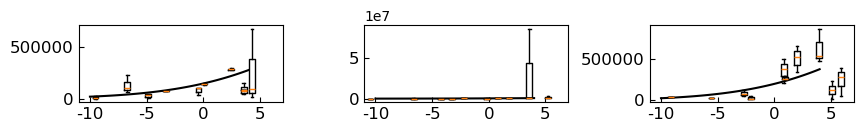

	 frac
	 {'const': -14.228591539102426, 'cruise_G2': 1.3084819005452664, 'cruise_G3': -0.07938876249023122, 'lat_diff': 0.12025421296667654, 'lat_diff^2': 0.000656751044779757}
	 {'p_value': {'lat_diff': np.float64(0.04654878048780487)}}
	 alpha {'alpha_used': 0, 'pearson_chi2': np.float64(5.762305570708924e-05), 'dispersion_ratio': np.float64(7.581981014090689e-07)}
	 n_outliers 1
	 n_skipped 0


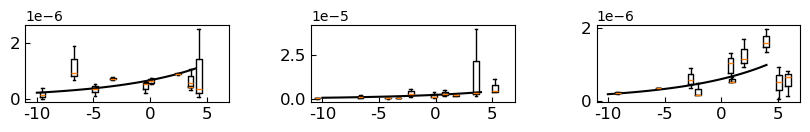


 K25130  fecE, cbrD; iron-siderophore transport system ATP-binding protein [EC:7.2.2.-]
	 trl
	 {'const': 13.859696684279807, 'cruise_G2': 0.5751731879389679, 'cruise_G3': -0.39124179325599046, 'lat_diff': 0.17398273644038442, 'lat_diff^2': 0.004740690047057514}
	 {'p_value': {'lat_diff': np.float64(0.0)}}
	 alpha {'alpha_used': np.float64(0.12824216016385365), 'pearson_chi2': np.float64(29227604.87451033), 'dispersion_ratio': np.float64(384573.74834882014)}
	 n_outliers 1
	 n_skipped 0


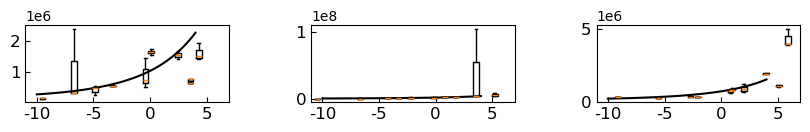

	 frac
	 {'const': -12.113415099552931, 'cruise_G2': 0.985226035276425, 'cruise_G3': -0.6041867917629625, 'lat_diff': 0.0956471500204038, 'lat_diff^2': 0.0035375532072172908}
	 {'p_value': {'lat_diff': np.float64(0.009131578947368421)}}
	 alpha {'alpha_used': 0, 'pearson_chi2': np.float64(0.0001762590252310084), 'dispersion_ratio': np.float64(2.2890782497533558e-06)}
	 n_outliers 0
	 n_skipped 0


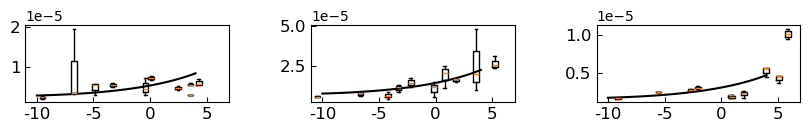


 K25287  desE; iron-desferrioxamine transport system substrate-binding protein
	 trl
	 {'const': 14.553313795901227, 'cruise_G2': -1.3819529127561516, 'cruise_G3': -2.5408866017753464, 'lat_diff': 0.4076486812016561, 'lat_diff^2': 0.010145167891014144}
	 {'p_value': {'lat_diff': np.float64(0.0)}}
	 alpha {'alpha_used': np.float64(0.13384380679282573), 'pearson_chi2': np.float64(58303164.09162066), 'dispersion_ratio': np.float64(757183.9492418268)}
	 n_outliers 0
	 n_skipped 0


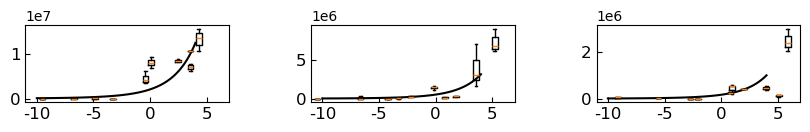

	 frac
	 {'const': -10.749598373600094, 'cruise_G2': -1.732687186452548, 'cruise_G3': -3.3194565740231226, 'lat_diff': 0.3301782015838737, 'lat_diff^2': -0.025560056466795128}
	 {'p_value': {'lat_diff': np.float64(0.0)}}
	 alpha {'alpha_used': 0, 'pearson_chi2': np.float64(0.0002764394462942713), 'dispersion_ratio': np.float64(3.6858592839236174e-06)}
	 n_outliers 2
	 n_skipped 0


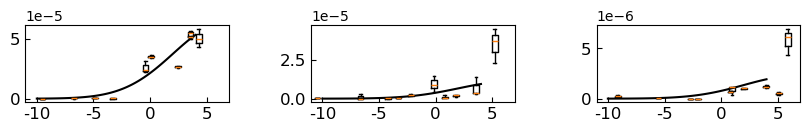

In [101]:
# for tax in ['1049564']:
for sel, dict_sz_ptype_kostoplot in dict_sel_sz_ptype_kostoplot.items():
    for sz, dict_ptype_kostoplot in dict_sz_ptype_kostoplot.items():
        for ptype, kostoplot in dict_ptype_kostoplot.items():
            print(f'**** {sel} {sz} {ptype} *****')
            for ko in kostoplot:
                print('\n', dict_ko_name[ko])
                for vt in ['trl','frac']:
                    df = dict_vt_sel_sz_allkopreddf[vt][sel][sz].copy()
                    dict_res = dict_vt_sel_sz_overallkoresults[vt][sel][sz][ko]

                    print('\t',vt)
                    print('\t',dict_res['model'])
                    print('\t',dict_res['adj_perm_pvalues'])
                    print('\t','alpha', dict_res['alpha'])
                    # print(dict_res['perm_dict'])
                    print('\t','n_outliers', dict_res['n_outliers'])
                    print('\t','n_skipped',dict_res['n_skipped'])


                    # PLot cruises
                    const, ld, ld2 = [dict_res['model'][c] for c in ['const','lat_diff','lat_diff^2']]
                    ft = 12
                    fig, axes = plt.subplots(1,3, figsize=(10,1))
                    for j, cruise in enumerate(['G1','G2','G3']):
                    # for j, cruise in enumerate(['G1']):
                        df_piv = df[df['cruise'] == cruise].copy()
                        if df_piv.shape[0] > 0:
                            ax = axes[j]
                            lats_unq = df_piv.lat_diff.unique()
                            vals = []
                            for l in lats_unq:
                                vals.append(df_piv.loc[df_piv['lat_diff'] == l, ko].values)
                            ax.boxplot(vals, positions=lats_unq)

                            # Plot model
                            crs = 0
                            if not cruise == 'G1':
                                crs = dict_res['model'][f'cruise_{cruise}']
                            x = np.linspace(-10,4,100)
                            # y = np.exp(const + ld*x + ld2*x**2 + ld3*x**3 + crs)
                            y = np.exp(const + ld*x + ld2*x**2 + crs)
                            ax.plot(x,y, 'k')

                            x = np.arange(-10,10,5)
                            ax.set_xticks(x)
                            ax.set_xticklabels(x)
                            ax.set_xlim(-11,7)
                            # ax.set_title(cruise, size=ft)
                            ax.tick_params(direction="in", labelsize=ft)
                            # if cruise == 'G3':
                            #     ax.set_ylim(0,2e8)

                    plt.subplots_adjust(wspace=0.4)
                    plt.show()

Interesting groups of genes

In [ ]:
[
    'tro', # mn/zn/fe transport
    'nar', # nitrate
    'nir', # nitrite
    'ent', # enterobactin
    'mbt', # mycobacitn
    'TF', # Transferrin
    'nrt', # n transport
    'des', # desferrioxamine
    'FT', # ferritin/bfr bacteriferrin
    'cmp', # bicarbonate
]


In [178]:
# targets = ['fyuA','desE','afuA','bfr','fiu','ALDO','fldA','amt',]
targets = ['narI']
for sel, dict_sz_ptypes_kos in dict_sel_sz_ptypes_kos.items():
    for sz, dict_ptypes_kos in dict_sz_ptypes_kos.items():
        for ptype, kos in dict_ptypes_kos.items():
            print(sel, sz, ptype)
            for ko in sorted(kos):
                name = dict_ko_name[ko]
                if any([re.search(t, name) is not None for t in targets]):
                    print('\t',name)


PA 3.0um trl_1.0_frac_1.0_
PA 3.0um trl_1.0_frac_0_
PA 3.0um trl_1.0_frac_-1.0_
PA 3.0um trl_0_frac_-1.0_
PA 3.0um trl_0_frac_0_
PA 3.0um trl_-1.0_frac_-1.0_
PA 0.2um trl_1.0_frac_0_
PA 0.2um trl_1.0_frac_1.0_
PA 0.2um trl_1.0_frac_-1.0_
PA 0.2um trl_0_frac_0_
PA 0.2um trl_0_frac_-1.0_
NS 3.0um trl_1.0_frac_0_
NS 3.0um trl_1.0_frac_1.0_
NS 3.0um trl_1.0_frac_-1.0_
NS 3.0um trl_0_frac_0_
NS 3.0um trl_0_frac_-1.0_
NS 3.0um trl_0_frac_1.0_
NS 0.2um trl_1.0_frac_1.0_
NS 0.2um trl_1.0_frac_0_
NS 0.2um trl_0_frac_-1.0_
	 K00374  narI, narV; nitrate reductase gamma subunit [EC:1.7.5.1 1.7.99.-]
NS 0.2um trl_0_frac_0_
NS 0.2um trl_-1.0_frac_-1.0_


PA 3.0um trl_1.0_frac_1.0_
PA 3.0um trl_1.0_frac_0_
PA 3.0um trl_1.0_frac_-1.0_
PA 3.0um trl_0_frac_0_

 K02575  NRT2, narK, nrtP, nasA; MFS transporter, NNP family, nitrate/nitrite transporter
	 trl
	 {'const': 9.014387012550012, 'cruise_G2': -0.269063000147261, 'cruise_G3': -0.048301692243216475, 'lat_diff': 0.027114021337525464, 'lat_diff^2': 0.0020722905371845517}
	 {'p_value': {'lat_diff': 0.163}}
	 alpha {'alpha_used': np.float64(0.1369017486827537), 'pearson_chi2': np.float64(82361.97563870988), 'dispersion_ratio': np.float64(1029.5246954838735)}
	 n_outliers 0
	 n_skipped 0


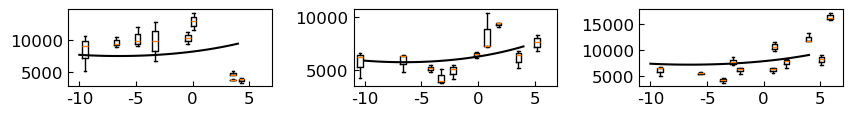

	 frac
	 {'const': -7.935791675092886, 'cruise_G2': -0.5187279664521404, 'cruise_G3': -0.12176814336931543, 'lat_diff': -0.03403556844587447, 'lat_diff^2': -0.0008999615317466301}
	 {'p_value': {'lat_diff': 0.089}}
	 alpha {'alpha_used': 0, 'pearson_chi2': np.float64(0.0032958759343066357), 'dispersion_ratio': np.float64(4.1198449178832944e-05)}
	 n_outliers 0
	 n_skipped 0


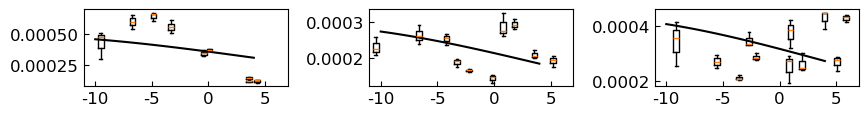

PA 3.0um trl_0_frac_1.0_
PA 3.0um trl_0_frac_-1.0_
PA 3.0um trl_-1.0_frac_-1.0_
PA 0.2um trl_1.0_frac_0_
PA 0.2um trl_1.0_frac_1.0_
PA 0.2um trl_0_frac_0_

 K02575  NRT2, narK, nrtP, nasA; MFS transporter, NNP family, nitrate/nitrite transporter
	 trl
	 {'const': 10.001945944303362, 'cruise_G2': -0.8590132072991671, 'cruise_G3': -0.5479651296467957, 'lat_diff': 0.010583891192692513, 'lat_diff^2': -0.004877621674229717}
	 {'p_value': {'lat_diff': 0.769}}
	 alpha {'alpha_used': np.float64(0.4102946899733919), 'pearson_chi2': np.float64(430273.05424808396), 'dispersion_ratio': np.float64(5661.487555895842)}
	 n_outliers 0
	 n_skipped 0


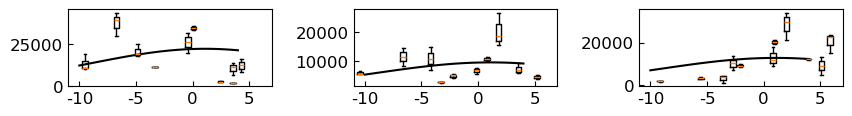

	 frac
	 {'const': -7.274821989136334, 'cruise_G2': -0.8547161344840992, 'cruise_G3': -0.6125267063963689, 'lat_diff': -0.049416564569411785, 'lat_diff^2': -0.007357023460126997}
	 {'p_value': {'lat_diff': 0.186}}
	 alpha {'alpha_used': 0, 'pearson_chi2': np.float64(0.01105495902987867), 'dispersion_ratio': np.float64(0.00014545998723524567)}
	 n_outliers 0
	 n_skipped 0


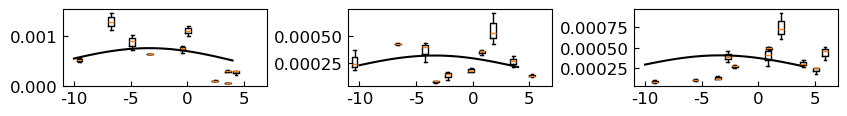

PA 0.2um trl_0_frac_1.0_
PA 0.2um trl_0_frac_-1.0_
PA 0.2um trl_-1.0_frac_-1.0_
NS 3.0um trl_1.0_frac_0_
NS 3.0um trl_1.0_frac_1.0_
NS 3.0um trl_0_frac_0_

 K02575  NRT2, narK, nrtP, nasA; MFS transporter, NNP family, nitrate/nitrite transporter
	 trl
	 {'const': 8.93314025225707, 'cruise_G2': -0.5649769173711382, 'cruise_G3': -2.4311039380752724, 'lat_diff': -0.0037608106120929075, 'lat_diff^2': -0.004752846468019115}
	 {'p_value': {'lat_diff': 0.9}}
	 alpha {'alpha_used': np.float64(0.25442117430773076), 'pearson_chi2': np.float64(80305.05939465587), 'dispersion_ratio': np.float64(1085.2035053331874)}
	 n_outliers 0
	 n_skipped 0


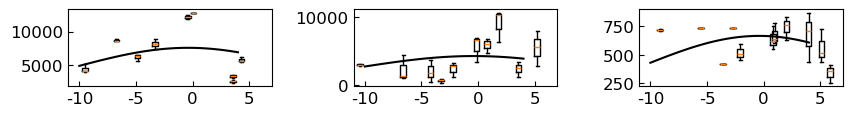

	 frac
	 {'const': -8.54447314139607, 'cruise_G2': -0.32867869958395424, 'cruise_G3': -1.9217168584601492, 'lat_diff': -0.0264456122361242, 'lat_diff^2': -0.00692453518079242}
	 {'p_value': {'lat_diff': 0.427}}
	 alpha {'alpha_used': 0, 'pearson_chi2': np.float64(0.001889186993646758), 'dispersion_ratio': np.float64(2.552955396819943e-05)}
	 n_outliers 0
	 n_skipped 0


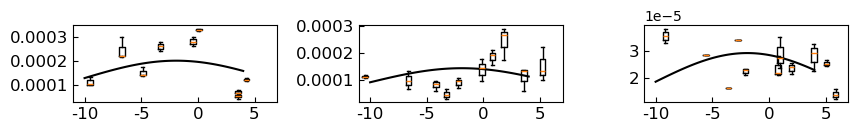


 K15577  nrtB, nasE, cynB; nitrate/nitrite transport system permease protein
	 trl
	 {'const': 4.7706200885200625, 'cruise_G2': -1.0607634814290374, 'cruise_G3': -1.8217522256789893, 'lat_diff': -0.01653462669561962, 'lat_diff^2': -0.0003632089255651153}
	 {'p_value': {'lat_diff': 0.869}}
	 alpha {'alpha_used': np.float64(2.3609704403600764), 'pearson_chi2': np.float64(10065.700540429953), 'dispersion_ratio': np.float64(136.02298027608043)}
	 n_outliers 0
	 n_skipped 0


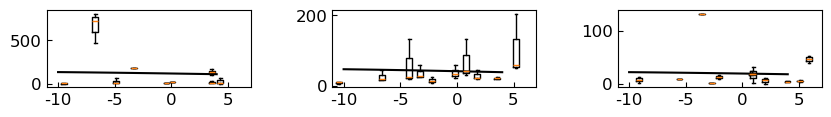

	 frac
	 {'const': -12.890725236880392, 'cruise_G2': -0.4625606458908018, 'cruise_G3': -1.0348993616311075, 'lat_diff': -0.08105868021839108, 'lat_diff^2': -0.008443581040593458}
	 {'p_value': {'lat_diff': 0.39}}
	 alpha {'alpha_used': 0, 'pearson_chi2': np.float64(0.00022660049623478114), 'dispersion_ratio': np.float64(3.104116386777824e-06)}
	 n_outliers 1
	 n_skipped 0


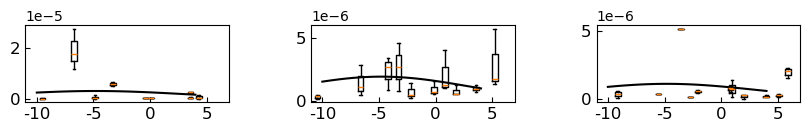


 K15578  nrtC, nasD; nitrate/nitrite transport system ATP-binding protein [EC:7.3.2.4]
	 trl
	 {'const': 5.6313349254383915, 'cruise_G2': -0.7277932767270436, 'cruise_G3': -2.3502779539236887, 'lat_diff': 0.027873618604831153, 'lat_diff^2': -0.005347044599972184}
	 {'p_value': {'lat_diff': 0.332}}
	 alpha {'alpha_used': np.float64(0.16663761713809086), 'pearson_chi2': np.float64(2198.706089511298), 'dispersion_ratio': np.float64(29.71224445285538)}
	 n_outliers 0
	 n_skipped 0


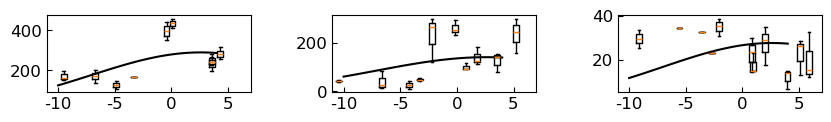

	 frac
	 {'const': -11.89787392171375, 'cruise_G2': -0.32657925039980595, 'cruise_G3': -1.8466400617786503, 'lat_diff': 0.0188106843684962, 'lat_diff^2': -0.007036243413829817}
	 {'p_value': {'lat_diff': 0.582}}
	 alpha {'alpha_used': 0, 'pearson_chi2': np.float64(5.6727873207866136e-05), 'dispersion_ratio': np.float64(7.665928811873802e-07)}
	 n_outliers 0
	 n_skipped 0


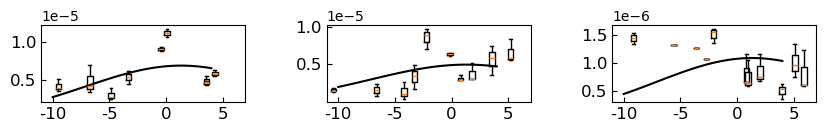


 K15579  nrtD, cynD; nitrate/nitrite transport system ATP-binding protein
	 trl
	 {'const': 5.666491941340137, 'cruise_G2': -0.5468668947596325, 'cruise_G3': -2.6639533475917427, 'lat_diff': 0.008075687440636414, 'lat_diff^2': -0.008109204714036325}
	 {'p_value': {'lat_diff': 0.818}}
	 alpha {'alpha_used': np.float64(0.24835480635084597), 'pearson_chi2': np.float64(2894.8670277648116), 'dispersion_ratio': np.float64(39.11982469952448)}
	 n_outliers 0
	 n_skipped 0


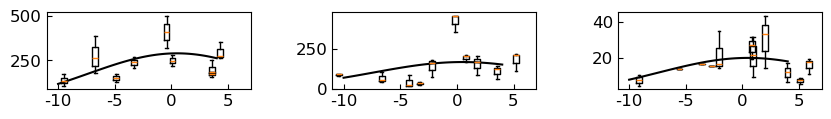

	 frac
	 {'const': -11.920976843090243, 'cruise_G2': -0.2172255770694947, 'cruise_G3': -2.0965186242782643, 'lat_diff': -0.004427606411504775, 'lat_diff^2': -0.007266715927007732}
	 {'p_value': {'lat_diff': 0.875}}
	 alpha {'alpha_used': 0, 'pearson_chi2': np.float64(5.8966021264320915e-05), 'dispersion_ratio': np.float64(7.968381251935259e-07)}
	 n_outliers 0
	 n_skipped 0


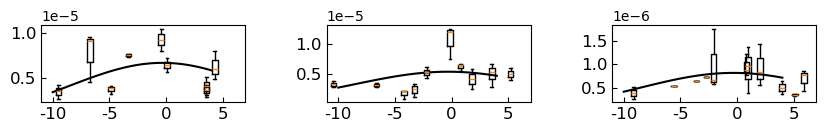

NS 3.0um trl_0_frac_-1.0_
NS 3.0um trl_0_frac_1.0_
NS 3.0um trl_-1.0_frac_0_
NS 3.0um trl_-1.0_frac_-1.0_
NS 0.2um trl_1.0_frac_1.0_

 K15578  nrtC, nasD; nitrate/nitrite transport system ATP-binding protein [EC:7.3.2.4]
	 trl
	 {'const': 5.991412940125071, 'cruise_G2': -0.1762957513997296, 'cruise_G3': -1.633988853198705, 'lat_diff': 0.057833064477114345, 'lat_diff^2': 0.0006699836063764038}
	 {'p_value': {'lat_diff': 0.003}}
	 alpha {'alpha_used': np.float64(0.1710901227401547), 'pearson_chi2': np.float64(3367.215613164594), 'dispersion_ratio': np.float64(43.73007289824148)}
	 n_outliers 0
	 n_skipped 0


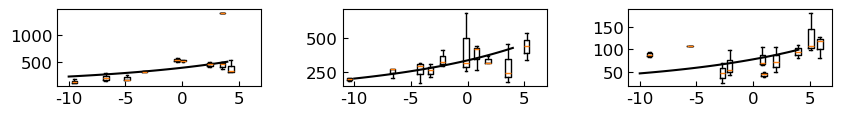

	 frac
	 {'const': -11.662594775336759, 'cruise_G2': 0.041205768650531965, 'cruise_G3': -1.2786136172849032, 'lat_diff': 0.05141306016871279, 'lat_diff^2': -0.00023744677945577823}
	 {'p_value': {'lat_diff': 0.003}}
	 alpha {'alpha_used': 0, 'pearson_chi2': np.float64(6.88451194323371e-05), 'dispersion_ratio': np.float64(8.940924601602221e-07)}
	 n_outliers 0
	 n_skipped 0


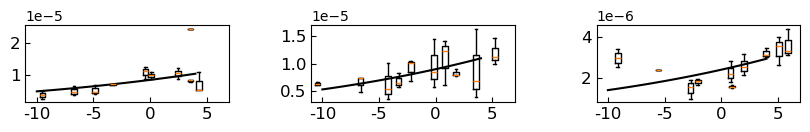

NS 0.2um trl_1.0_frac_0_
NS 0.2um trl_0_frac_0_

 K02575  NRT2, narK, nrtP, nasA; MFS transporter, NNP family, nitrate/nitrite transporter
	 trl
	 {'const': 9.603566434791269, 'cruise_G2': -1.1400066726915499, 'cruise_G3': -3.9700151288207643, 'lat_diff': -0.0357022665944517, 'lat_diff^2': -0.01108528067376198}
	 {'p_value': {'lat_diff': 0.297}}
	 alpha {'alpha_used': np.float64(0.4170174076856004), 'pearson_chi2': np.float64(186954.31913942157), 'dispersion_ratio': np.float64(2427.9781706418385)}
	 n_outliers 0
	 n_skipped 0


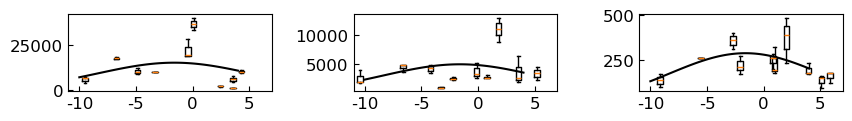

	 frac
	 {'const': -8.037154269620617, 'cruise_G2': -1.0143789883650125, 'cruise_G3': -3.5416804181794066, 'lat_diff': -0.07087086094249596, 'lat_diff^2': -0.013989113067051341}
	 {'p_value': {'lat_diff': 0.18}}
	 alpha {'alpha_used': 0, 'pearson_chi2': np.float64(0.003834938712256571), 'dispersion_ratio': np.float64(4.980439886047495e-05)}
	 n_outliers 0
	 n_skipped 0


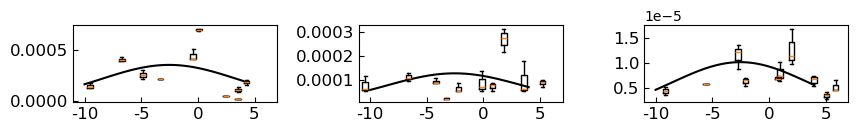


 K15577  nrtB, nasE, cynB; nitrate/nitrite transport system permease protein
	 trl
	 {'const': 6.5149105768420466, 'cruise_G2': 0.27992705465609874, 'cruise_G3': -0.5776414192194815, 'lat_diff': 0.011119220508156264, 'lat_diff^2': 0.0040476595764794635}
	 {'p_value': {'lat_diff': 0.747}}
	 alpha {'alpha_used': np.float64(0.5263723284876362), 'pearson_chi2': np.float64(32914.88503455169), 'dispersion_ratio': np.float64(433.0905925598907)}
	 n_outliers 1
	 n_skipped 0


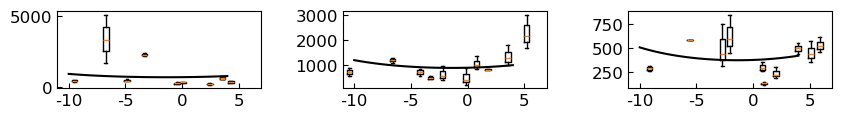

	 frac
	 {'const': -11.178920472634918, 'cruise_G2': 0.5241287737908376, 'cruise_G3': -0.2713899595615334, 'lat_diff': 0.03871074143113986, 'lat_diff^2': 0.0069320195387158855}
	 {'p_value': {'lat_diff': 0.294}}
	 alpha {'alpha_used': 0, 'pearson_chi2': np.float64(0.0008023804084031275), 'dispersion_ratio': np.float64(1.055763695267273e-05)}
	 n_outliers 1
	 n_skipped 0


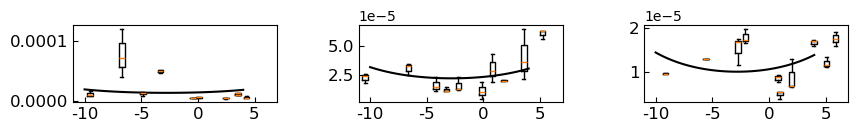


 K15579  nrtD, cynD; nitrate/nitrite transport system ATP-binding protein
	 trl
	 {'const': 5.946130474559601, 'cruise_G2': 0.1252694531502183, 'cruise_G3': -1.5818104875852868, 'lat_diff': 0.01815545429607162, 'lat_diff^2': 0.0007382880868116275}
	 {'p_value': {'lat_diff': 0.371}}
	 alpha {'alpha_used': np.float64(0.20251275592009482), 'pearson_chi2': np.float64(5142.782470598134), 'dispersion_ratio': np.float64(66.7893827350407)}
	 n_outliers 0
	 n_skipped 0


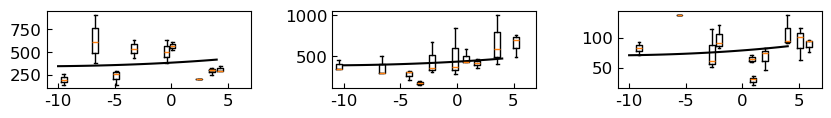

	 frac
	 {'const': -11.791118298978303, 'cruise_G2': 0.4103077751604329, 'cruise_G3': -1.214227266700457, 'lat_diff': 0.0344566964422367, 'lat_diff^2': 0.003670294184944289}
	 {'p_value': {'lat_diff': 0.183}}
	 alpha {'alpha_used': 0, 'pearson_chi2': np.float64(0.00016075789889905418), 'dispersion_ratio': np.float64(2.0877649207669375e-06)}
	 n_outliers 0
	 n_skipped 0


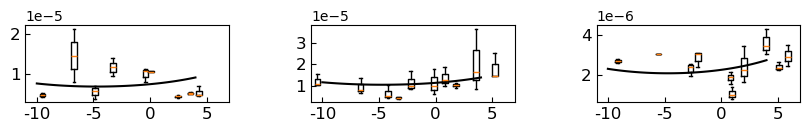

NS 0.2um trl_0_frac_-1.0_
NS 0.2um trl_0_frac_1.0_
NS 0.2um trl_-1.0_frac_0_
NS 0.2um trl_-1.0_frac_-1.0_

 K15576  nrtA, nasF, cynA; nitrate/nitrite transport system substrate-binding protein
	 trl
	 {'const': 5.3165354879564415, 'cruise_G2': 0.27492945305087474, 'cruise_G3': -0.9973506039942458, 'lat_diff': -0.2675068949833099, 'lat_diff^2': -0.03623629974417534}
	 {'p_value': {'lat_diff': 0.001}}
	 alpha {'alpha_used': np.float64(0.4644228517016608), 'pearson_chi2': np.float64(22775.918039901022), 'dispersion_ratio': np.float64(307.7826762148787)}
	 n_outliers 3
	 n_skipped 0


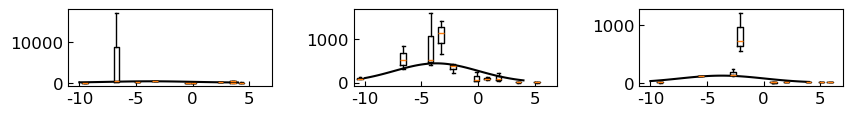

	 frac
	 {'const': -12.909827123524297, 'cruise_G2': 1.004124972248132, 'cruise_G3': -0.5260427542816909, 'lat_diff': -0.4330012773326971, 'lat_diff^2': -0.04870413591782749}
	 {'p_value': {'lat_diff': 0.0}}
	 alpha {'alpha_used': 0, 'pearson_chi2': np.float64(0.00037692018861154076), 'dispersion_ratio': np.float64(5.163290254952613e-06)}
	 n_outliers 4
	 n_skipped 0


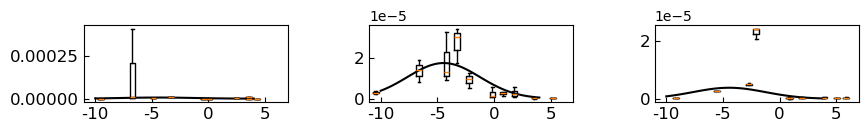

In [266]:
for sel, dict_sz_ptypes_kos in dict_sel_sz_ptypes_kos.items():
    for sz, dict_ptypes_kos in dict_sz_ptypes_kos.items():
        for ptype, kos in dict_ptypes_kos.items():
            print(sel, sz, ptype)
            for ko in sorted(kos):
                name = dict_ko_name[ko]
                if re.search(target, name) is not None:
                    print('\n', dict_ko_name[ko])
                    for vt in ['trl','frac']:
                        df = dict_vt_sel_sz_allkopreddf[vt][sel][sz].copy()
                        dict_res = dict_vt_sel_sz_overallkoresults[vt][sel][sz][ko]

                        print('\t',vt)
                        print('\t',dict_res['model'])
                        print('\t',dict_res['perm_pvalues'])
                        print('\t','alpha', dict_res['alpha'])
                        # print(dict_res['perm_dict'])
                        print('\t','n_outliers', dict_res['n_outliers'])
                        print('\t','n_skipped',dict_res['n_skipped'])


                        # PLot cruises
                        const, ld, ld2 = [dict_res['model'][c] for c in ['const','lat_diff','lat_diff^2']]
                        ft = 12
                        fig, axes = plt.subplots(1,3, figsize=(10,1))
                        for j, cruise in enumerate(['G1','G2','G3']):
                        # for j, cruise in enumerate(['G1']):
                            df_piv = df[df['cruise'] == cruise].copy()
                            if df_piv.shape[0] > 0:
                                ax = axes[j]
                                lats_unq = df_piv.lat_diff.unique()
                                vals = []
                                for l in lats_unq:
                                    vals.append(df_piv.loc[df_piv['lat_diff'] == l, ko].values)
                                ax.boxplot(vals, positions=lats_unq)

                                # Plot model
                                crs = 0
                                if not cruise == 'G1':
                                    crs = dict_res['model'][f'cruise_{cruise}']
                                x = np.linspace(-10,4,100)
                                # y = np.exp(const + ld*x + ld2*x**2 + ld3*x**3 + crs)
                                y = np.exp(const + ld*x + ld2*x**2 + crs)
                                ax.plot(x,y, 'k')

                                x = np.arange(-10,10,5)
                                ax.set_xticks(x)
                                ax.set_xticklabels(x)
                                ax.set_xlim(-11,7)
                                # ax.set_title(cruise, size=ft)
                                ax.tick_params(direction="in", labelsize=ft)
                                # if cruise == 'G3':
                                #     ax.set_ylim(0,2e8)

                        plt.subplots_adjust(wspace=0.4)
                        plt.show()

#### Plot transferrin genes and combine size fractions

Get values and curves for summed size fractions

In [134]:
# Pick kos
kos = [
    'K14736', 'K06503', 'K23910'
]
vt = 'frac'
sel = 'NS'
size = '0.2um'
results = dict_vt_sel_sz_overallkoresults[vt][sel][size]
label_cols = ['lat_diff','cruise','rep']

df = dict_vt_sel_sz_allkopreddf[vt][sel][sz].copy()
df = df[kos + label_cols]


# # subset the dataframes
# df_sub = []
# for size in ['3.0um','0.2um']:
#     df = dict_vt_sel_sz_allkopreddf[vt][sel][sz].copy()
#     df = df[kos + label_cols]
#     df = df.sort_values(by=['cruise','lat_diff','rep'])
#     print(df.shape)
#     df_sub.append(df)

# # Sum the transcripts per liter
# df_sub_merge = np.zeros_like(df_sub[0][kos].values)
# for df in df_sub:
#     df_sub_merge += df[kos].values
# df_sub_merge = pd.DataFrame(df_sub_merge, index=df_sub[0].index, columns=kos)
# df_sub_merge = df_sub_merge.merge(df_sub[0][label_cols], left_index=True,right_index=True)

# # run the glm fitting
# results = frm.fit_many_models(
#     data=df,
#     response_cols=kos,
#     covariate_cols=['lat_diff','cruise'],
#     poly_cols=['lat_diff'], 
#     poly_degree=2,
#     iqr_coefficient=iqr_coefficient,
#     perm_test_vars=['lat_diff'], 
#     n_perm=1000, 
#     stat='coef',
#     random_state=None,
#     n_jobs=len(kos),
# )



Plot 

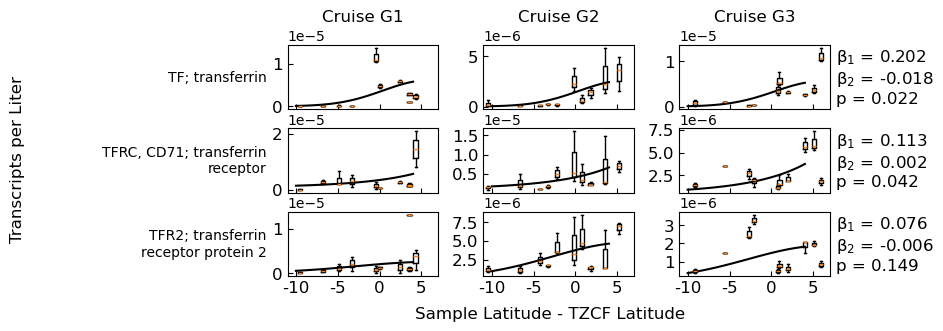

In [135]:
ft = 12
fig, axes = plt.subplots(len(kos),3, figsize=(7,len(kos)))
lablen = 25
for i, (ko) in enumerate(kos):
    dict_res = results[ko]
    # PLot cruises
    const, ld, ld2 = [dict_res['model'][c] for c in ['const','lat_diff','lat_diff^2']]
    for j, cruise in enumerate(['G1','G2','G3']):
    # for j, cruise in enumerate(['G1']):
        df_piv = df[df['cruise'] == cruise].copy()
        if df_piv.shape[0] > 0:
            ax = axes[i,j]
            lats_unq = df_piv.lat_diff.unique()
            vals = []
            for l in lats_unq:
                vals.append(df_piv.loc[df_piv['lat_diff'] == l, ko].values)
            ax.boxplot(vals, positions=lats_unq)

            # Plot model
            crs = 0
            if not cruise == 'G1':
                crs = dict_res['model'][f'cruise_{cruise}']
            x = np.linspace(-10,4,100)
            # y = np.exp(const + ld*x + ld2*x**2 + ld3*x**3 + crs)
            y = np.exp(const + ld*x + ld2*x**2 + crs)
            ax.plot(x,y, 'k')

            x = np.arange(-10,10,5)
            ax.set_xticks(x)
            xticklabels = x if i == len(kos) - 1 else []
            ax.set_xticklabels(xticklabels)
            ax.set_xlim(-11,7)
            # ax.set_title(cruise, size=ft)
            ax.tick_params(direction="in", labelsize=ft)
            # if cruise == 'G3':
            #     ax.set_ylim(0,2e8)
            if j == 0:
                # Get gene description
                name = dict_ko_name[ko]
                nm = re.search(r'(?<=^K\d{5}\s\s).+', name)[0]
                splt = '[EC:'
                if splt in nm:
                    nm = nm.split(splt)[0]
                # Separate description on spaces
                lab = ''
                i_0 = 0
                i_1 = lablen
                while i_1 < len(nm):
                    l = nm[i_0:i_1]
                    if ' ' in l:
                        i_1 = l.rfind(' ')
                        lab += l[:i_1] + '\n'
                        i_0 = i_0 + i_1 + 1
                        i_1  = i_0 + lablen
                    else:
                        i_1 += lablen

                l = nm[i_0:]
                if len(l) > lablen:
                    if ' ' in l:
                        i_1 = l.rfind(' ')
                        lab += l[:i_1] + '\n'
                        i_0 = i_0 + i_1 + 1
                        l = nm[i_0:]
                lab += l
                ax.set_ylabel(lab, rotation=0, va='center',ha='right')
            if j == 2:
                p = dict_res['adj_perm_pvalues']['p_value']['lat_diff']
                sscrpt = [1,2]
                text = f'β$_{{1}}$ = {round(ld,3)}\nβ$_{{2}}$ = {round(ld2,3)}\np = {round(p,3)}'
                ax.yaxis.set_label_position("right")
                ax.set_ylabel(text, rotation=0, fontsize=ft, ha='left', va='center')
            if i == 0:
                ax.set_title(f'Cruise {cruise}')


fig.text(0.5, 0.01, f'Sample Latitude - TZCF Latitude', rotation=0, va='top',ha='center', fontsize=ft)
fig.text(-0.25, 0.5, f'Transcripts per Liter', rotation=90, va='center',ha='right', fontsize=ft)

plt.subplots_adjust(wspace=0.3, hspace=0.3)

dir_out = '/scratch/bgrodner/iron_ko_contigs/metat_search_results/spatial_variability_latitude_tzcf_glm'
fmt_out = f'{dir_out}/plots/transferrin_NS_size_{size}_trl_glm.{{ext}}'
exts = ['png','pdf']
do = os.path.split(fmt_out)[0]
if not os.path.exists(do): os.makedirs(do)
fns_out = [fmt_out.format(ext=ext) for ext in exts]
for fn_out in fns_out:
    plt.savefig(fn_out, dpi=500, bbox_inches='tight')


#### Plot nitrogen genes

Get values and curves for summed size fractions

In [181]:
# Pick kos
kos = [
    'K00371','K00370','K00374', 'K03320', 'K15576'
]
vt = 'trl'
sel = 'NS'
size = '0.2um'
results = dict_vt_sel_sz_overallkoresults[vt][sel][size]
label_cols = ['lat_diff','cruise','rep']

df = dict_vt_sel_sz_allkopreddf[vt][sel][size].copy()
df = df[kos + label_cols]


# # subset the dataframes
# df_sub = []
# for size in ['3.0um','0.2um']:
#     df = dict_vt_sel_sz_allkopreddf[vt][sel][sz].copy()
#     df = df[kos + label_cols]
#     df = df.sort_values(by=['cruise','lat_diff','rep'])
#     print(df.shape)
#     df_sub.append(df)

# # Sum the transcripts per liter
# df_sub_merge = np.zeros_like(df_sub[0][kos].values)
# for df in df_sub:
#     df_sub_merge += df[kos].values
# df_sub_merge = pd.DataFrame(df_sub_merge, index=df_sub[0].index, columns=kos)
# df_sub_merge = df_sub_merge.merge(df_sub[0][label_cols], left_index=True,right_index=True)

# # run the glm fitting
# results = frm.fit_many_models(
#     data=df,
#     response_cols=kos,
#     covariate_cols=['lat_diff','cruise'],
#     poly_cols=['lat_diff'], 
#     poly_degree=2,
#     iqr_coefficient=iqr_coefficient,
#     perm_test_vars=['lat_diff'], 
#     n_perm=1000, 
#     stat='coef',
#     random_state=None,
#     n_jobs=len(kos),
# )



Plot 

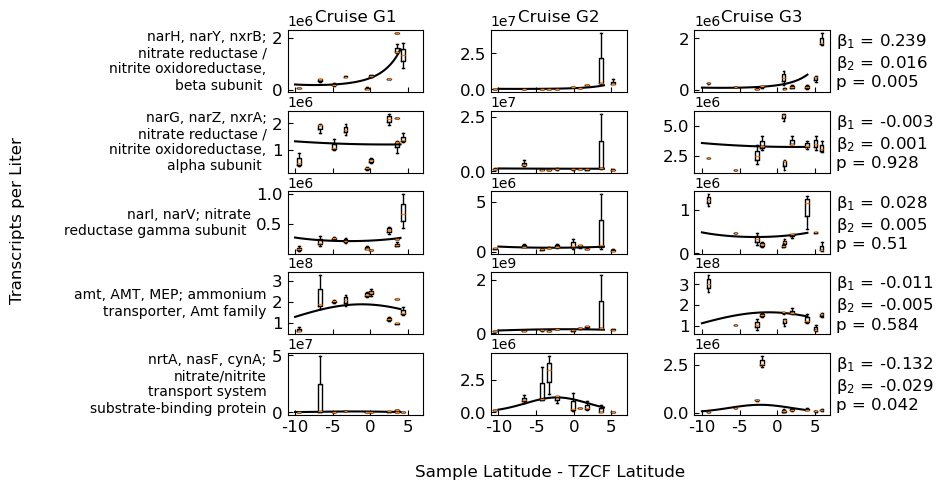

In [182]:
ft = 12
fig, axes = plt.subplots(len(kos),3, figsize=(7,len(kos)))
lablen = 25
for i, (ko) in enumerate(kos):
    dict_res = results[ko]
    # PLot cruises
    const, ld, ld2 = [dict_res['model'][c] for c in ['const','lat_diff','lat_diff^2']]
    for j, cruise in enumerate(['G1','G2','G3']):
    # for j, cruise in enumerate(['G1']):
        df_piv = df[df['cruise'] == cruise].copy()
        if df_piv.shape[0] > 0:
            ax = axes[i,j]
            lats_unq = df_piv.lat_diff.unique()
            vals = []
            for l in lats_unq:
                vals.append(df_piv.loc[df_piv['lat_diff'] == l, ko].values)
            ax.boxplot(vals, positions=lats_unq)

            # Plot model
            crs = 0
            if not cruise == 'G1':
                crs = dict_res['model'][f'cruise_{cruise}']
            x = np.linspace(-10,4,100)
            # y = np.exp(const + ld*x + ld2*x**2 + ld3*x**3 + crs)
            y = np.exp(const + ld*x + ld2*x**2 + crs)
            ax.plot(x,y, 'k')

            x = np.arange(-10,10,5)
            ax.set_xticks(x)
            xticklabels = x if i == len(kos) - 1 else []
            ax.set_xticklabels(xticklabels)
            ax.set_xlim(-11,7)
            # ax.set_title(cruise, size=ft)
            ax.tick_params(direction="in", labelsize=ft)
            # if cruise == 'G3':
            #     ax.set_ylim(0,2e8)
            if j == 0:
                # Get gene description
                name = dict_ko_name[ko]
                nm = re.search(r'(?<=^K\d{5}\s\s).+', name)[0]
                splt = '[EC:'
                if splt in nm:
                    nm = nm.split(splt)[0]
                # Separate description on spaces
                lab = ''
                i_0 = 0
                i_1 = lablen
                while i_1 < len(nm):
                    l = nm[i_0:i_1]
                    if ' ' in l:
                        i_1 = l.rfind(' ')
                        lab += l[:i_1] + '\n'
                        i_0 = i_0 + i_1 + 1
                        i_1  = i_0 + lablen
                    else:
                        i_1 += lablen

                l = nm[i_0:]
                if len(l) > lablen:
                    if ' ' in l:
                        i_1 = l.rfind(' ')
                        lab += l[:i_1] + '\n'
                        i_0 = i_0 + i_1 + 1
                        l = nm[i_0:]
                lab += l
                ax.set_ylabel(lab, rotation=0, va='center',ha='right')
            if j == 2:
                p = dict_res['adj_perm_pvalues']['p_value']['lat_diff']
                sscrpt = [1,2]
                text = f'β$_{{1}}$ = {round(ld,3)}\nβ$_{{2}}$ = {round(ld2,3)}\np = {round(p,3)}'
                ax.yaxis.set_label_position("right")
                ax.set_ylabel(text, rotation=0, fontsize=ft, ha='left', va='center')
            if i == 0:
                ax.set_title(f'Cruise {cruise}')


fig.text(0.5, 0.01, f'Sample Latitude - TZCF Latitude', rotation=0, va='top',ha='center', fontsize=ft)
fig.text(-0.25, 0.5, f'Transcripts per Liter', rotation=90, va='center',ha='right', fontsize=ft)

plt.subplots_adjust(wspace=0.5, hspace=0.3)

# dir_out = '/scratch/bgrodner/iron_ko_contigs/metat_search_results/spatial_variability_latitude_tzcf_glm'
# fmt_out = f'{dir_out}/plots/nitrogen_NS_size_{size}_trl_glm.{{ext}}'
# exts = ['png','pdf']
# do = os.path.split(fmt_out)[0]
# if not os.path.exists(do): os.makedirs(do)
# fns_out = [fmt_out.format(ext=ext) for ext in exts]
# for fn_out in fns_out:
#     plt.savefig(fn_out, dpi=500, bbox_inches='tight')


#### Plot Flavo/ferredoxin genes

Get values and curves for summed size fractions

In [138]:
# Pick kos
kos = [
    'K03839','K03840','K11260','K02639','K05337','K11107','K05524',
]
vt = 'frac'
sel = 'NS'
size = '0.2um'
results = dict_vt_sel_sz_overallkoresults[vt][sel][size]
label_cols = ['lat_diff','cruise','rep']

df = dict_vt_sel_sz_allkopreddf[vt][sel][size].copy()
df = df[kos + label_cols]

# # subset the dataframes
# df_sub = []
# for size in ['0.2um']:
#     df = dict_vt_sel_sz_allkopreddf[vt][sel][size].copy()
#     df = df[kos + label_cols]
#     df = df.sort_values(by=['cruise','lat_diff','rep'])
#     print(df.shape)
#     df_sub.append(df)

# # Sum the transcripts per liter
# df_sub_merge = np.zeros_like(df_sub[0][kos].values)
# for df in df_sub:
#     df_sub_merge += df[kos].values
# df_sub_merge = pd.DataFrame(df_sub_merge, index=df_sub[0].index, columns=kos)
# df_sub_merge = df_sub_merge.merge(df_sub[0][label_cols], left_index=True,right_index=True)

# # run the glm fitting
# results = frm.fit_many_models(
#     data=df_sub_merge,
#     response_cols=kos,
#     covariate_cols=['lat_diff','cruise'],
#     poly_cols=['lat_diff'], 
#     poly_degree=2,
#     iqr_coefficient=iqr_coefficient,
#     perm_test_vars=['lat_diff'], 
#     n_perm=1000, 
#     stat='coef',
#     random_state=None,
#     n_jobs=len(kos),
# )



Plot 

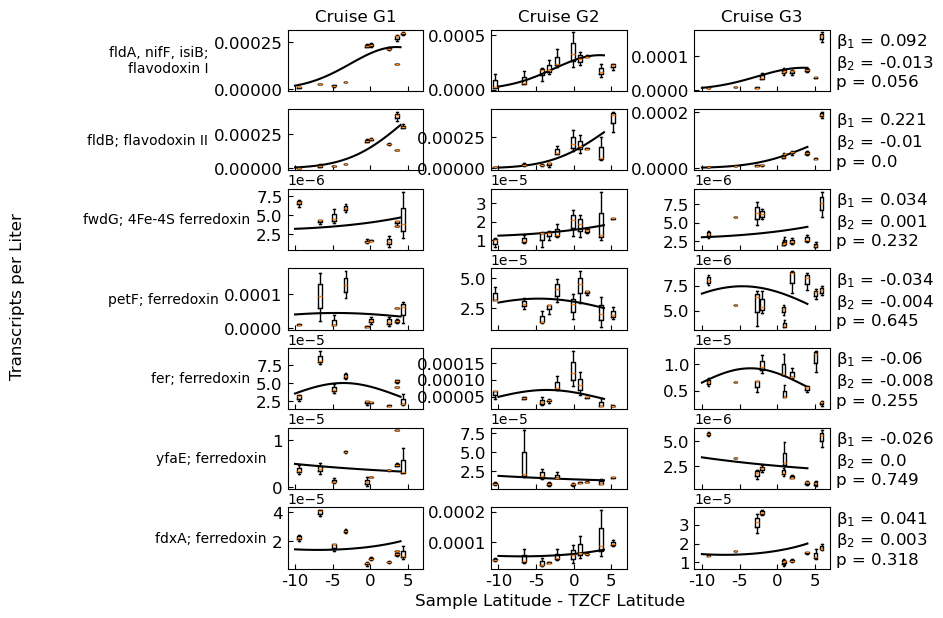

In [139]:
ft = 12
fig, axes = plt.subplots(len(kos),3, figsize=(7,len(kos)))
lablen = 25
for i, (ko) in enumerate(kos):
    dict_res = results[ko]
    # PLot cruises
    const, ld, ld2 = [dict_res['model'][c] for c in ['const','lat_diff','lat_diff^2']]
    for j, cruise in enumerate(['G1','G2','G3']):
    # for j, cruise in enumerate(['G1']):
        df_piv = df[df['cruise'] == cruise].copy()
        if df_piv.shape[0] > 0:
            ax = axes[i,j]
            lats_unq = df_piv.lat_diff.unique()
            vals = []
            for l in lats_unq:
                vals.append(df_piv.loc[df_piv['lat_diff'] == l, ko].values)
            ax.boxplot(vals, positions=lats_unq)

            # Plot model
            crs = 0
            if not cruise == 'G1':
                crs = dict_res['model'][f'cruise_{cruise}']
            x = np.linspace(-10,4,100)
            # y = np.exp(const + ld*x + ld2*x**2 + ld3*x**3 + crs)
            y = np.exp(const + ld*x + ld2*x**2 + crs)
            ax.plot(x,y, 'k')

            x = np.arange(-10,10,5)
            ax.set_xticks(x)
            xticklabels = x if i == len(kos) - 1 else []
            ax.set_xticklabels(xticklabels)
            ax.set_xlim(-11,7)
            # ax.set_title(cruise, size=ft)
            ax.tick_params(direction="in", labelsize=ft)
            # if cruise == 'G3':
            #     ax.set_ylim(0,2e8)
            if j == 0:
                # Get gene description
                name = dict_ko_name[ko]
                nm = re.search(r'(?<=^K\d{5}\s\s).+', name)[0]
                splt = '[EC:'
                if splt in nm:
                    nm = nm.split(splt)[0]
                # Separate description on spaces
                lab = ''
                i_0 = 0
                i_1 = lablen
                while i_1 < len(nm):
                    l = nm[i_0:i_1]
                    if ' ' in l:
                        i_1 = l.rfind(' ')
                        lab += l[:i_1] + '\n'
                        i_0 = i_0 + i_1 + 1
                        i_1  = i_0 + lablen
                    else:
                        i_1 += lablen

                l = nm[i_0:]
                if len(l) > lablen:
                    if ' ' in l:
                        i_1 = l.rfind(' ')
                        lab += l[:i_1] + '\n'
                        i_0 = i_0 + i_1 + 1
                        l = nm[i_0:]
                lab += l
                ax.set_ylabel(lab, rotation=0, va='center',ha='right')
            if j == 2:
                p = dict_res['adj_perm_pvalues']['p_value']['lat_diff']
                sscrpt = [1,2]
                text = f'β$_{{1}}$ = {round(ld,3)}\nβ$_{{2}}$ = {round(ld2,3)}\np = {round(p,3)}'
                ax.yaxis.set_label_position("right")
                ax.set_ylabel(text, rotation=0, fontsize=ft, ha='left', va='center')
            if i == 0:
                ax.set_title(f'Cruise {cruise}')


fig.text(0.5, 0.075, f'Sample Latitude - TZCF Latitude', rotation=0, va='top',ha='center', fontsize=ft)
fig.text(-0.25, 0.5, f'Transcripts per Liter', rotation=90, va='center',ha='right', fontsize=ft)

plt.subplots_adjust(wspace=0.5, hspace=0.3)

dir_out = '/scratch/bgrodner/iron_ko_contigs/metat_search_results/spatial_variability_latitude_tzcf_glm'
fmt_out = f'{dir_out}/plots/flavo_ferredoxin_NS_size_0_2um_trl_glm.{{ext}}'
exts = ['png','pdf']
do = os.path.split(fmt_out)[0]
if not os.path.exists(do): os.makedirs(do)
fns_out = [fmt_out.format(ext=ext) for ext in exts]
for fn_out in fns_out:
    plt.savefig(fn_out, dpi=500, bbox_inches='tight')


#### Plot other iron free genes

Get values and curves for summed size fractions

In [140]:
# Pick kos
kos = [
    'K01623','K02638','K02717'
]
vt = 'frac'
sel = 'NS'
size = '0.2um'
results = dict_vt_sel_sz_overallkoresults[vt][sel][size]
label_cols = ['lat_diff','cruise','rep']

df = dict_vt_sel_sz_allkopreddf[vt][sel][size].copy()
df = df[kos + label_cols]

# # subset the dataframes
# df_sub = []
# for size in ['0.2um']:
#     df = dict_vt_sel_sz_allkopreddf[vt][sel][size].copy()
#     df = df[kos + label_cols]
#     df = df.sort_values(by=['cruise','lat_diff','rep'])
#     print(df.shape)
#     df_sub.append(df)

# # Sum the transcripts per liter
# df_sub_merge = np.zeros_like(df_sub[0][kos].values)
# for df in df_sub:
#     df_sub_merge += df[kos].values
# df_sub_merge = pd.DataFrame(df_sub_merge, index=df_sub[0].index, columns=kos)
# df_sub_merge = df_sub_merge.merge(df_sub[0][label_cols], left_index=True,right_index=True)

# # run the glm fitting
# results = frm.fit_many_models(
#     data=df,
#     response_cols=kos,
#     covariate_cols=['lat_diff','cruise'],
#     poly_cols=['lat_diff'], 
#     poly_degree=2,
#     iqr_coefficient=iqr_coefficient,
#     perm_test_vars=['lat_diff'], 
#     n_perm=1000, 
#     stat='coef',
#     random_state=None,
#     n_jobs=len(kos),
# )



Plot 

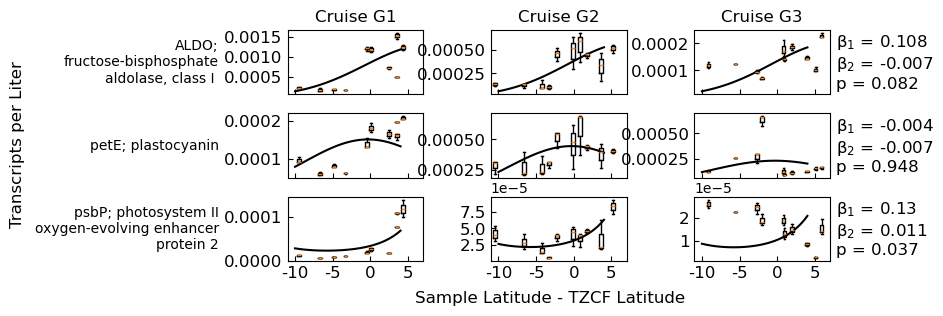

In [141]:
ft = 12
fig, axes = plt.subplots(len(kos),3, figsize=(7,len(kos)))
lablen = 25
for i, (ko) in enumerate(kos):
    dict_res = results[ko]
    # PLot cruises
    const, ld, ld2 = [dict_res['model'][c] for c in ['const','lat_diff','lat_diff^2']]
    for j, cruise in enumerate(['G1','G2','G3']):
    # for j, cruise in enumerate(['G1']):
        df_piv = df[df['cruise'] == cruise].copy()
        if df_piv.shape[0] > 0:
            ax = axes[i,j]
            lats_unq = df_piv.lat_diff.unique()
            vals = []
            for l in lats_unq:
                vals.append(df_piv.loc[df_piv['lat_diff'] == l, ko].values)
            ax.boxplot(vals, positions=lats_unq)

            # Plot model
            crs = 0
            if not cruise == 'G1':
                crs = dict_res['model'][f'cruise_{cruise}']
            x = np.linspace(-10,4,100)
            # y = np.exp(const + ld*x + ld2*x**2 + ld3*x**3 + crs)
            y = np.exp(const + ld*x + ld2*x**2 + crs)
            ax.plot(x,y, 'k')

            x = np.arange(-10,10,5)
            ax.set_xticks(x)
            xticklabels = x if i == len(kos) - 1 else []
            ax.set_xticklabels(xticklabels)
            ax.set_xlim(-11,7)
            # ax.set_title(cruise, size=ft)
            ax.tick_params(direction="in", labelsize=ft)
            # if cruise == 'G3':
            #     ax.set_ylim(0,2e8)
            if j == 0:
                # Get gene description
                name = dict_ko_name[ko]
                nm = re.search(r'(?<=^K\d{5}\s\s).+', name)[0]
                splt = '[EC:'
                if splt in nm:
                    nm = nm.split(splt)[0]
                # Separate description on spaces
                lab = ''
                i_0 = 0
                i_1 = lablen
                while i_1 < len(nm):
                    l = nm[i_0:i_1]
                    if ' ' in l:
                        i_1 = l.rfind(' ')
                        lab += l[:i_1] + '\n'
                        i_0 = i_0 + i_1 + 1
                        i_1  = i_0 + lablen
                    else:
                        i_1 += lablen

                l = nm[i_0:]
                if len(l) > lablen:
                    if ' ' in l:
                        i_1 = l.rfind(' ')
                        lab += l[:i_1] + '\n'
                        i_0 = i_0 + i_1 + 1
                        l = nm[i_0:]
                lab += l
                ax.set_ylabel(lab, rotation=0, va='center',ha='right')
            if j == 2:
                p = dict_res['adj_perm_pvalues']['p_value']['lat_diff']
                sscrpt = [1,2]
                text = f'β$_{{1}}$ = {round(ld,3)}\nβ$_{{2}}$ = {round(ld2,3)}\np = {round(p,3)}'
                ax.yaxis.set_label_position("right")
                ax.set_ylabel(text, rotation=0, fontsize=ft, ha='left', va='center')
            if i == 0:
                ax.set_title(f'Cruise {cruise}')


fig.text(0.5, 0.01, f'Sample Latitude - TZCF Latitude', rotation=0, va='top',ha='center', fontsize=ft)
fig.text(-0.25, 0.5, f'Transcripts per Liter', rotation=90, va='center',ha='right', fontsize=ft)

plt.subplots_adjust(wspace=0.5, hspace=0.3)

dir_out = '/scratch/bgrodner/iron_ko_contigs/metat_search_results/spatial_variability_latitude_tzcf_glm'
fmt_out = f'{dir_out}/plots/iron_free_other_NS_size_{size}_trl_glm.{{ext}}'
exts = ['png','pdf']
do = os.path.split(fmt_out)[0]
if not os.path.exists(do): os.makedirs(do)
fns_out = [fmt_out.format(ext=ext) for ext in exts]
for fn_out in fns_out:
    plt.savefig(fn_out, dpi=500, bbox_inches='tight')


#### Plot north upregulated enterobactin genes

Get values and curves for summed size fractions

In [176]:
# Pick kos
# kos = [
#     'K25287','K08225','K18895','K24034','K25110','K25130','K25284','K04786','K10829',
# ]
kos = [
    'K18895','K00216','K02361','K08225','K24147','K02362','K02364','K01252','K02363'
]

vt = 'frac'
sel = 'NS'
size = '0.2um'
results = dict_vt_sel_sz_overallkoresults[vt][sel][size]
label_cols = ['lat_diff','cruise','rep']

df = dict_vt_sel_sz_allkopreddf[vt][sel][size].copy()
df = df[kos + label_cols]

# # subset the dataframes
# df_sub = []
# for size in ['0.2um']:
#     df = dict_vt_sel_sz_allkopreddf[vt][sel][size].copy()
#     df = df[kos + label_cols]
#     df = df.sort_values(by=['cruise','lat_diff','rep'])
#     print(df.shape)
#     df_sub.append(df)

# # Sum the transcripts per liter
# df_sub_merge = np.zeros_like(df_sub[0][kos].values)
# for df in df_sub:
#     df_sub_merge += df[kos].values
# df_sub_merge = pd.DataFrame(df_sub_merge, index=df_sub[0].index, columns=kos)
# df_sub_merge = df_sub_merge.merge(df_sub[0][label_cols], left_index=True,right_index=True)

# # run the glm fitting
# results = frm.fit_many_models(
#     data=df,
#     response_cols=kos,
#     covariate_cols=['lat_diff','cruise'],
#     poly_cols=['lat_diff'], 
#     poly_degree=2,
#     iqr_coefficient=10,
#     perm_test_vars=['lat_diff'], 
#     n_perm=1000, 
#     stat='coef',
#     random_state=None,
#     n_jobs=len(kos),
# )



Plot 

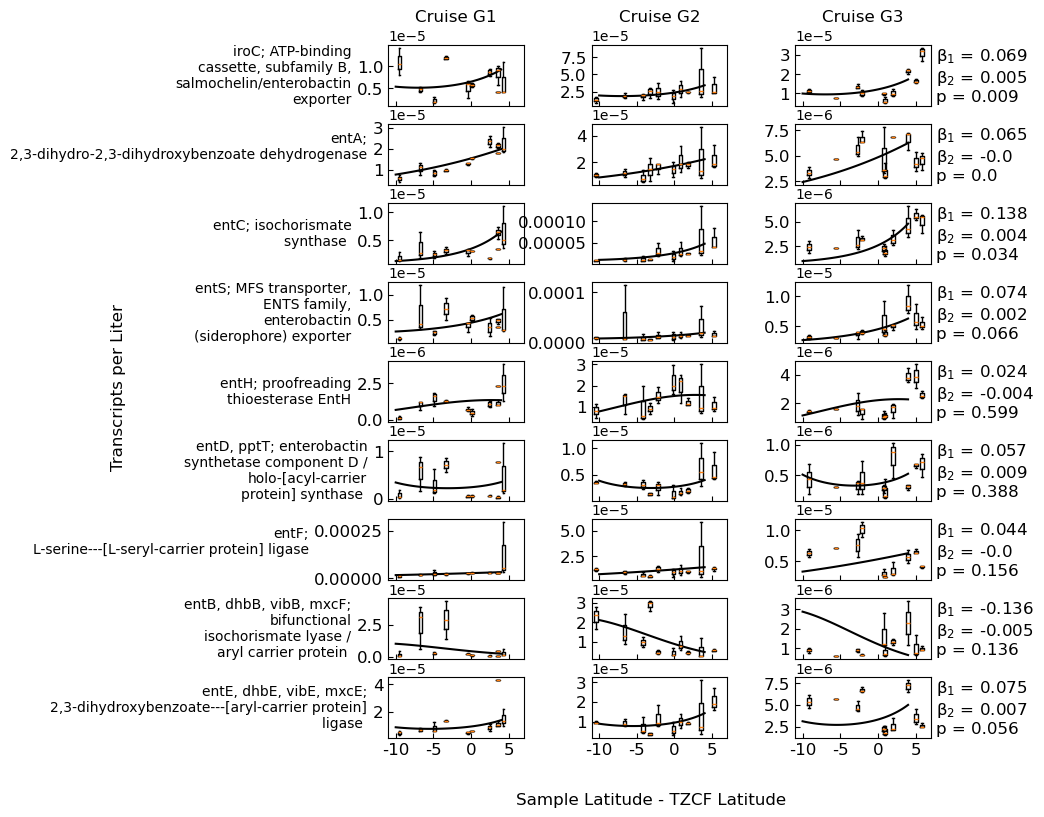

In [177]:
ft = 12
fig, axes = plt.subplots(len(kos),3, figsize=(7,len(kos)))
lablen = 25
for i, (ko) in enumerate(kos):
    dict_res = results[ko]
    # PLot cruises
    const, ld, ld2 = [dict_res['model'][c] for c in ['const','lat_diff','lat_diff^2']]
    for j, cruise in enumerate(['G1','G2','G3']):
    # for j, cruise in enumerate(['G1']):
        df_piv = df[df['cruise'] == cruise].copy()
        if df_piv.shape[0] > 0:
            ax = axes[i,j]
            lats_unq = df_piv.lat_diff.unique()
            vals = []
            for l in lats_unq:
                vals.append(df_piv.loc[df_piv['lat_diff'] == l, ko].values)
            ax.boxplot(vals, positions=lats_unq)

            # Plot model
            crs = 0
            if not cruise == 'G1':
                crs = dict_res['model'][f'cruise_{cruise}']
            x = np.linspace(-10,4,100)
            # y = np.exp(const + ld*x + ld2*x**2 + ld3*x**3 + crs)
            y = np.exp(const + ld*x + ld2*x**2 + crs)
            ax.plot(x,y, 'k')

            x = np.arange(-10,10,5)
            ax.set_xticks(x)
            xticklabels = x if i == len(kos) - 1 else []
            ax.set_xticklabels(xticklabels)
            ax.set_xlim(-11,7)
            # ax.set_title(cruise, size=ft)
            ax.tick_params(direction="in", labelsize=ft)
            # if cruise == 'G3':
            #     ax.set_ylim(0,2e8)
            if j == 0:
                # Get gene description
                name = dict_ko_name[ko]
                nm = re.search(r'(?<=^K\d{5}\s\s).+', name)[0]
                splt = '[EC:'
                if splt in nm:
                    nm = nm.split(splt)[0]
                # Separate description on spaces
                lab = ''
                i_0 = 0
                i_1 = lablen
                while i_1 < len(nm):
                    l = nm[i_0:i_1]
                    if ' ' in l:
                        i_1 = l.rfind(' ')
                        lab += l[:i_1] + '\n'
                        i_0 = i_0 + i_1 + 1
                        i_1  = i_0 + lablen
                    else:
                        i_1 += lablen

                l = nm[i_0:]
                if len(l) > lablen:
                    if ' ' in l:
                        i_1 = l.rfind(' ')
                        lab += l[:i_1] + '\n'
                        i_0 = i_0 + i_1 + 1
                        l = nm[i_0:]
                lab += l
                ax.set_ylabel(lab, rotation=0, va='center',ha='right')
            if j == 2:
                p = dict_res['adj_perm_pvalues']['p_value']['lat_diff']
                sscrpt = [1,2]
                text = f'β$_{{1}}$ = {round(ld,3)}\nβ$_{{2}}$ = {round(ld2,3)}\np = {round(p,3)}'
                ax.yaxis.set_label_position("right")
                ax.set_ylabel(text, rotation=0, fontsize=ft, ha='left', va='center')
            if i == 0:
                ax.set_title(f'Cruise {cruise}')


fig.text(0.5, 0.05, f'Sample Latitude - TZCF Latitude', rotation=0, va='top',ha='center', fontsize=ft)
fig.text(-0.25, 0.5, f'Transcripts per Liter', rotation=90, va='center',ha='right', fontsize=ft)

plt.subplots_adjust(wspace=0.5, hspace=0.3)

dir_out = '/scratch/bgrodner/iron_ko_contigs/metat_search_results/spatial_variability_latitude_tzcf_glm'
fmt_out = f'{dir_out}/plots/enterobactin_{sel}_size_{size}_trl_glm.{{ext}}'
exts = ['png','pdf']
do = os.path.split(fmt_out)[0]
if not os.path.exists(do): os.makedirs(do)
fns_out = [fmt_out.format(ext=ext) for ext in exts]
for fn_out in fns_out:
    plt.savefig(fn_out, dpi=500, bbox_inches='tight')


#### Plot non significant enterobactin genes

Get values and curves for summed size fractions

In [144]:
# Pick kos
# kos = [
#     'K25287','K08225','K18895','K24034','K25110','K25130','K25284','K04786','K10829',
# ]
kos = [
    'K02362','K02364','K01252','K02363'
]

vt = 'frac'
sel = 'NS'
size = '0.2um'
results = dict_vt_sel_sz_overallkoresults[vt][sel][size]
label_cols = ['lat_diff','cruise','rep']

df = dict_vt_sel_sz_allkopreddf[vt][sel][size].copy()
df = df[kos + label_cols]

# # subset the dataframes
# df_sub = []
# for size in ['0.2um']:
#     df = dict_vt_sel_sz_allkopreddf[vt][sel][size].copy()
#     df = df[kos + label_cols]
#     df = df.sort_values(by=['cruise','lat_diff','rep'])
#     print(df.shape)
#     df_sub.append(df)

# # Sum the transcripts per liter
# df_sub_merge = np.zeros_like(df_sub[0][kos].values)
# for df in df_sub:
#     df_sub_merge += df[kos].values
# df_sub_merge = pd.DataFrame(df_sub_merge, index=df_sub[0].index, columns=kos)
# df_sub_merge = df_sub_merge.merge(df_sub[0][label_cols], left_index=True,right_index=True)

# # run the glm fitting
# results = frm.fit_many_models(
#     data=df,
#     response_cols=kos,
#     covariate_cols=['lat_diff','cruise'],
#     poly_cols=['lat_diff'], 
#     poly_degree=2,
#     iqr_coefficient=10,
#     perm_test_vars=['lat_diff'], 
#     n_perm=1000, 
#     stat='coef',
#     random_state=None,
#     n_jobs=len(kos),
# )



Plot 

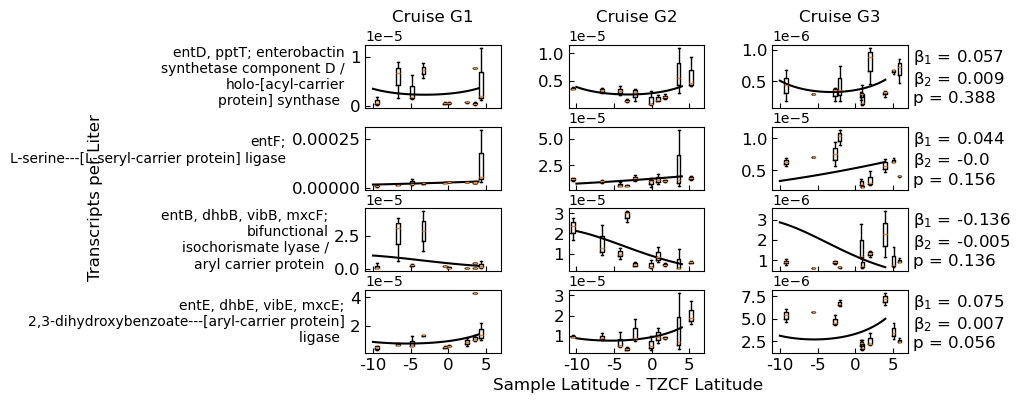

In [145]:
ft = 12
fig, axes = plt.subplots(len(kos),3, figsize=(7,len(kos)))
lablen = 25
for i, (ko) in enumerate(kos):
    dict_res = results[ko]
    # PLot cruises
    const, ld, ld2 = [dict_res['model'][c] for c in ['const','lat_diff','lat_diff^2']]
    for j, cruise in enumerate(['G1','G2','G3']):
    # for j, cruise in enumerate(['G1']):
        df_piv = df[df['cruise'] == cruise].copy()
        if df_piv.shape[0] > 0:
            ax = axes[i,j]
            lats_unq = df_piv.lat_diff.unique()
            vals = []
            for l in lats_unq:
                vals.append(df_piv.loc[df_piv['lat_diff'] == l, ko].values)
            ax.boxplot(vals, positions=lats_unq)

            # Plot model
            crs = 0
            if not cruise == 'G1':
                crs = dict_res['model'][f'cruise_{cruise}']
            x = np.linspace(-10,4,100)
            # y = np.exp(const + ld*x + ld2*x**2 + ld3*x**3 + crs)
            y = np.exp(const + ld*x + ld2*x**2 + crs)
            ax.plot(x,y, 'k')

            x = np.arange(-10,10,5)
            ax.set_xticks(x)
            xticklabels = x if i == len(kos) - 1 else []
            ax.set_xticklabels(xticklabels)
            ax.set_xlim(-11,7)
            # ax.set_title(cruise, size=ft)
            ax.tick_params(direction="in", labelsize=ft)
            # if cruise == 'G3':
            #     ax.set_ylim(0,2e8)
            if j == 0:
                # Get gene description
                name = dict_ko_name[ko]
                nm = re.search(r'(?<=^K\d{5}\s\s).+', name)[0]
                splt = '[EC:'
                if splt in nm:
                    nm = nm.split(splt)[0]
                # Separate description on spaces
                lab = ''
                i_0 = 0
                i_1 = lablen
                while i_1 < len(nm):
                    l = nm[i_0:i_1]
                    if ' ' in l:
                        i_1 = l.rfind(' ')
                        lab += l[:i_1] + '\n'
                        i_0 = i_0 + i_1 + 1
                        i_1  = i_0 + lablen
                    else:
                        i_1 += lablen

                l = nm[i_0:]
                if len(l) > lablen:
                    if ' ' in l:
                        i_1 = l.rfind(' ')
                        lab += l[:i_1] + '\n'
                        i_0 = i_0 + i_1 + 1
                        l = nm[i_0:]
                lab += l
                ax.set_ylabel(lab, rotation=0, va='center',ha='right')
            if j == 2:
                p = dict_res['adj_perm_pvalues']['p_value']['lat_diff']
                sscrpt = [1,2]
                text = f'β$_{{1}}$ = {round(ld,3)}\nβ$_{{2}}$ = {round(ld2,3)}\np = {round(p,3)}'
                ax.yaxis.set_label_position("right")
                ax.set_ylabel(text, rotation=0, fontsize=ft, ha='left', va='center')
            if i == 0:
                ax.set_title(f'Cruise {cruise}')


fig.text(0.5, 0.05, f'Sample Latitude - TZCF Latitude', rotation=0, va='top',ha='center', fontsize=ft)
fig.text(-0.25, 0.5, f'Transcripts per Liter', rotation=90, va='center',ha='right', fontsize=ft)

plt.subplots_adjust(wspace=0.5, hspace=0.3)

dir_out = '/scratch/bgrodner/iron_ko_contigs/metat_search_results/spatial_variability_latitude_tzcf_glm'
fmt_out = f'{dir_out}/plots/enterobactin_nonsig_{sel}_size_{size}_trl_glm.{{ext}}'
exts = ['png','pdf']
do = os.path.split(fmt_out)[0]
if not os.path.exists(do): os.makedirs(do)
fns_out = [fmt_out.format(ext=ext) for ext in exts]
for fn_out in fns_out:
    plt.savefig(fn_out, dpi=500, bbox_inches='tight')


#### Plot pyochelin genes

Get values and curves for summed size fractions

In [146]:
# Pick kos
kos = [
    'K04782','K01851','K12238','K12239','K12240','K12243'
]
vt = 'frac'
sel = 'NS'
size = '0.2um'
results = dict_vt_sel_sz_overallkoresults[vt][sel][size]
label_cols = ['lat_diff','cruise','rep']

df = dict_vt_sel_sz_allkopreddf[vt][sel][size].copy()
df = df[kos + label_cols]

# # subset the dataframes
# df_sub = []
# for size in ['0.2um']:
#     df = dict_vt_sel_sz_allkopreddf[vt][sel][size].copy()
#     df = df[kos + label_cols]
#     df = df.sort_values(by=['cruise','lat_diff','rep'])
#     print(df.shape)
#     df_sub.append(df)

# # Sum the transcripts per liter
# df_sub_merge = np.zeros_like(df_sub[0][kos].values)
# for df in df_sub:
#     df_sub_merge += df[kos].values
# df_sub_merge = pd.DataFrame(df_sub_merge, index=df_sub[0].index, columns=kos)
# df_sub_merge = df_sub_merge.merge(df_sub[0][label_cols], left_index=True,right_index=True)

# # run the glm fitting
# results = frm.fit_many_models(
#     data=df,
#     response_cols=kos,
#     covariate_cols=['lat_diff','cruise'],
#     poly_cols=['lat_diff'], 
#     poly_degree=2,
#     iqr_coefficient=10,
#     perm_test_vars=['lat_diff'], 
#     n_perm=1000, 
#     stat='coef',
#     random_state=None,
#     n_jobs=len(kos),
# )



Plot 

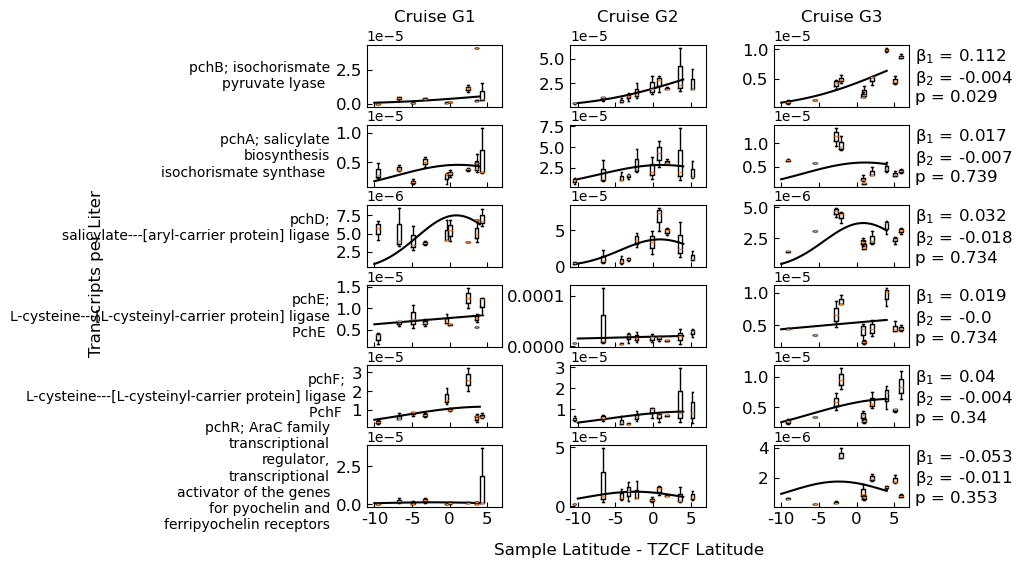

In [147]:
ft = 12
fig, axes = plt.subplots(len(kos),3, figsize=(7,len(kos)))
lablen = 25
for i, (ko) in enumerate(kos):
    dict_res = results[ko]
    # PLot cruises
    const, ld, ld2 = [dict_res['model'][c] for c in ['const','lat_diff','lat_diff^2']]
    for j, cruise in enumerate(['G1','G2','G3']):
    # for j, cruise in enumerate(['G1']):
        df_piv = df[df['cruise'] == cruise].copy()
        if df_piv.shape[0] > 0:
            ax = axes[i,j]
            lats_unq = df_piv.lat_diff.unique()
            vals = []
            for l in lats_unq:
                vals.append(df_piv.loc[df_piv['lat_diff'] == l, ko].values)
            ax.boxplot(vals, positions=lats_unq)

            # Plot model
            crs = 0
            if not cruise == 'G1':
                crs = dict_res['model'][f'cruise_{cruise}']
            x = np.linspace(-10,4,100)
            # y = np.exp(const + ld*x + ld2*x**2 + ld3*x**3 + crs)
            y = np.exp(const + ld*x + ld2*x**2 + crs)
            ax.plot(x,y, 'k')

            x = np.arange(-10,10,5)
            ax.set_xticks(x)
            xticklabels = x if i == len(kos) - 1 else []
            ax.set_xticklabels(xticklabels)
            ax.set_xlim(-11,7)
            # ax.set_title(cruise, size=ft)
            ax.tick_params(direction="in", labelsize=ft)
            # if cruise == 'G3':
            #     ax.set_ylim(0,2e8)
            if j == 0:
                # Get gene description
                name = dict_ko_name[ko]
                nm = re.search(r'(?<=^K\d{5}\s\s).+', name)[0]
                splt = '[EC:'
                if splt in nm:
                    nm = nm.split(splt)[0]
                # Separate description on spaces
                lab = ''
                i_0 = 0
                i_1 = lablen
                while i_1 < len(nm):
                    l = nm[i_0:i_1]
                    if ' ' in l:
                        i_1 = l.rfind(' ')
                        lab += l[:i_1] + '\n'
                        i_0 = i_0 + i_1 + 1
                        i_1  = i_0 + lablen
                    else:
                        i_1 += lablen

                l = nm[i_0:]
                if len(l) > lablen:
                    if ' ' in l:
                        i_1 = l.rfind(' ')
                        lab += l[:i_1] + '\n'
                        i_0 = i_0 + i_1 + 1
                        l = nm[i_0:]
                lab += l
                ax.set_ylabel(lab, rotation=0, va='center',ha='right')
            if j == 2:
                p = dict_res['adj_perm_pvalues']['p_value']['lat_diff']
                sscrpt = [1,2]
                text = f'β$_{{1}}$ = {round(ld,3)}\nβ$_{{2}}$ = {round(ld2,3)}\np = {round(p,3)}'
                ax.yaxis.set_label_position("right")
                ax.set_ylabel(text, rotation=0, fontsize=ft, ha='left', va='center')
            if i == 0:
                ax.set_title(f'Cruise {cruise}')


fig.text(0.5, 0.05, f'Sample Latitude - TZCF Latitude', rotation=0, va='top',ha='center', fontsize=ft)
fig.text(-0.25, 0.5, f'Transcripts per Liter', rotation=90, va='center',ha='right', fontsize=ft)

plt.subplots_adjust(wspace=0.5, hspace=0.3)

dir_out = '/scratch/bgrodner/iron_ko_contigs/metat_search_results/spatial_variability_latitude_tzcf_glm'
fmt_out = f'{dir_out}/plots/sidero_pyochelin_{sel}_size_{size}_trl_glm.{{ext}}'
exts = ['png','pdf']
do = os.path.split(fmt_out)[0]
if not os.path.exists(do): os.makedirs(do)
fns_out = [fmt_out.format(ext=ext) for ext in exts]
for fn_out in fns_out:
    plt.savefig(fn_out, dpi=500, bbox_inches='tight')


#### Plot nonspecific siderophore genes

Get values and curves for summed size fractions

In [148]:
# Pick kos
kos = [
    'K25110','K25109','K25111','K25130','K23181','K23182','K23183','K23184','K23186','K23187','K23188','K25282','K25283','K25284','K25285','K25286','K16090','K10829'
]
vt = 'frac'
sel = 'NS'
size = '0.2um'
results = dict_vt_sel_sz_overallkoresults[vt][sel][size]
label_cols = ['lat_diff','cruise','rep']

df = dict_vt_sel_sz_allkopreddf[vt][sel][size].copy()
df = df[kos + label_cols]

# # subset the dataframes
# df_sub = []
# for size in ['0.2um']:
#     df = dict_vt_sel_sz_allkopreddf[vt][sel][size].copy()
#     df = df[kos + label_cols]
#     df = df.sort_values(by=['cruise','lat_diff','rep'])
#     print(df.shape)
#     df_sub.append(df)

# # Sum the transcripts per liter
# df_sub_merge = np.zeros_like(df_sub[0][kos].values)
# for df in df_sub:
#     df_sub_merge += df[kos].values
# df_sub_merge = pd.DataFrame(df_sub_merge, index=df_sub[0].index, columns=kos)
# df_sub_merge = df_sub_merge.merge(df_sub[0][label_cols], left_index=True,right_index=True)

# # run the glm fitting
# results = frm.fit_many_models(
#     data=df,
#     response_cols=kos,
#     covariate_cols=['lat_diff','cruise'],
#     poly_cols=['lat_diff'], 
#     poly_degree=2,
#     iqr_coefficient=10,
#     perm_test_vars=['lat_diff'], 
#     n_perm=1000, 
#     stat='coef',
#     random_state=None,
#     n_jobs=len(kos),
# )



Plot 

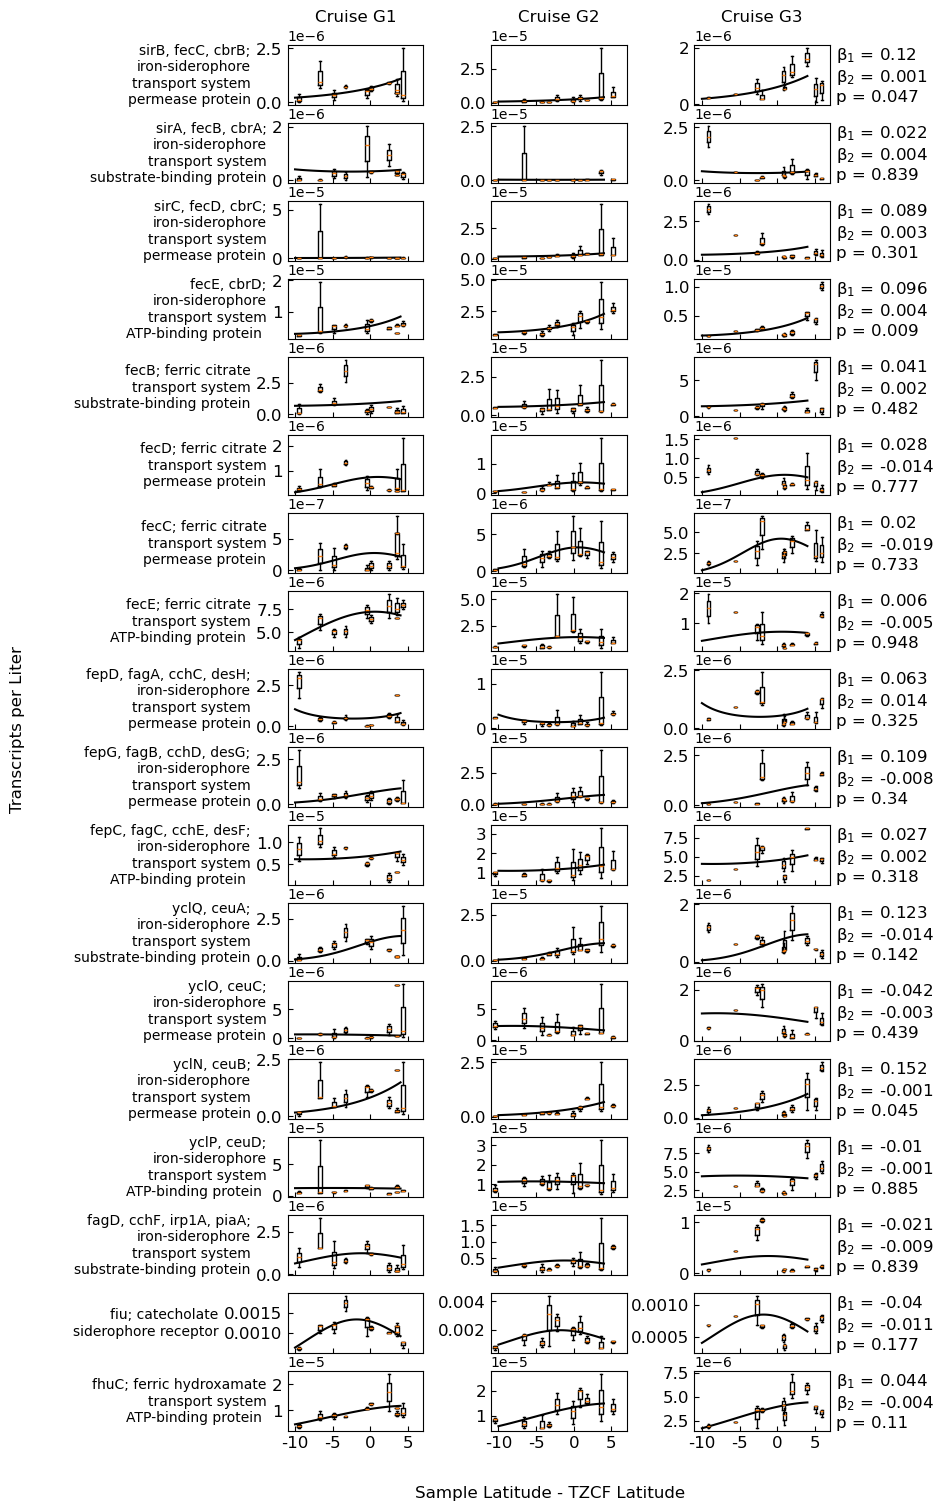

In [149]:
ft = 12
fig, axes = plt.subplots(len(kos),3, figsize=(7,len(kos)))
lablen = 25
for i, (ko) in enumerate(kos):
    dict_res = results[ko]
    # PLot cruises
    const, ld, ld2 = [dict_res['model'][c] for c in ['const','lat_diff','lat_diff^2']]
    for j, cruise in enumerate(['G1','G2','G3']):
    # for j, cruise in enumerate(['G1']):
        df_piv = df[df['cruise'] == cruise].copy()
        if df_piv.shape[0] > 0:
            ax = axes[i,j]
            lats_unq = df_piv.lat_diff.unique()
            vals = []
            for l in lats_unq:
                vals.append(df_piv.loc[df_piv['lat_diff'] == l, ko].values)
            ax.boxplot(vals, positions=lats_unq)

            # Plot model
            crs = 0
            if not cruise == 'G1':
                crs = dict_res['model'][f'cruise_{cruise}']
            x = np.linspace(-10,4,100)
            # y = np.exp(const + ld*x + ld2*x**2 + ld3*x**3 + crs)
            y = np.exp(const + ld*x + ld2*x**2 + crs)
            ax.plot(x,y, 'k')

            x = np.arange(-10,10,5)
            ax.set_xticks(x)
            xticklabels = x if i == len(kos) - 1 else []
            ax.set_xticklabels(xticklabels)
            ax.set_xlim(-11,7)
            # ax.set_title(cruise, size=ft)
            ax.tick_params(direction="in", labelsize=ft)
            # if cruise == 'G3':
            #     ax.set_ylim(0,2e8)
            if j == 0:
                # Get gene description
                name = dict_ko_name[ko]
                nm = re.search(r'(?<=^K\d{5}\s\s).+', name)[0]
                splt = '[EC:'
                if splt in nm:
                    nm = nm.split(splt)[0]
                # Separate description on spaces
                lab = ''
                i_0 = 0
                i_1 = lablen
                while i_1 < len(nm):
                    l = nm[i_0:i_1]
                    if ' ' in l:
                        i_1 = l.rfind(' ')
                        lab += l[:i_1] + '\n'
                        i_0 = i_0 + i_1 + 1
                        i_1  = i_0 + lablen
                    else:
                        i_1 += lablen

                l = nm[i_0:]
                if len(l) > lablen:
                    if ' ' in l:
                        i_1 = l.rfind(' ')
                        lab += l[:i_1] + '\n'
                        i_0 = i_0 + i_1 + 1
                        l = nm[i_0:]
                lab += l
                ax.set_ylabel(lab, rotation=0, va='center',ha='right')
            if j == 2:
                p = dict_res['adj_perm_pvalues']['p_value']['lat_diff']
                sscrpt = [1,2]
                text = f'β$_{{1}}$ = {round(ld,3)}\nβ$_{{2}}$ = {round(ld2,3)}\np = {round(p,3)}'
                ax.yaxis.set_label_position("right")
                ax.set_ylabel(text, rotation=0, fontsize=ft, ha='left', va='center')
            if i == 0:
                ax.set_title(f'Cruise {cruise}')


fig.text(0.5, 0.08, f'Sample Latitude - TZCF Latitude', rotation=0, va='top',ha='center', fontsize=ft)
fig.text(-0.25, 0.5, f'Transcripts per Liter', rotation=90, va='center',ha='right', fontsize=ft)

plt.subplots_adjust(wspace=0.5, hspace=0.3)

dir_out = '/scratch/bgrodner/iron_ko_contigs/metat_search_results/spatial_variability_latitude_tzcf_glm'
fmt_out = f'{dir_out}/plots/sidero_nonspecific_{sel}_size_{size}_trl_glm.{{ext}}'
exts = ['png','pdf']
do = os.path.split(fmt_out)[0]
if not os.path.exists(do): os.makedirs(do)
fns_out = [fmt_out.format(ext=ext) for ext in exts]
for fn_out in fns_out:
    plt.savefig(fn_out, dpi=500, bbox_inches='tight')


#### Plot other siderophore genes

Get values and curves for summed size fractions

In [150]:
# Pick kos
kos = [
    'K12237','K25287','K04786','K04783','K04784','K05374','K15721','K04792','K04781','K04787','K04788','K04790','K04791','K04789'
]
vt = 'frac'
sel = 'NS'
size = '0.2um'
results = dict_vt_sel_sz_overallkoresults[vt][sel][size]
label_cols = ['lat_diff','cruise','rep']

df = dict_vt_sel_sz_allkopreddf[vt][sel][size].copy()
df = df[kos + label_cols]

# # subset the dataframes
# df_sub = []
# for size in ['0.2um']:
#     df = dict_vt_sel_sz_allkopreddf[vt][sel][size].copy()
#     df = df[kos + label_cols]
#     df = df.sort_values(by=['cruise','lat_diff','rep'])
#     print(df.shape)
#     df_sub.append(df)

# # Sum the transcripts per liter
# df_sub_merge = np.zeros_like(df_sub[0][kos].values)
# for df in df_sub:
#     df_sub_merge += df[kos].values
# df_sub_merge = pd.DataFrame(df_sub_merge, index=df_sub[0].index, columns=kos)
# df_sub_merge = df_sub_merge.merge(df_sub[0][label_cols], left_index=True,right_index=True)

# # run the glm fitting
# results = frm.fit_many_models(
#     data=df,
#     response_cols=kos,
#     covariate_cols=['lat_diff','cruise'],
#     poly_cols=['lat_diff'], 
#     poly_degree=2,
#     iqr_coefficient=10,
#     perm_test_vars=['lat_diff'], 
#     n_perm=1000, 
#     stat='coef',
#     random_state=None,
#     n_jobs=len(kos),
# )



Plot 

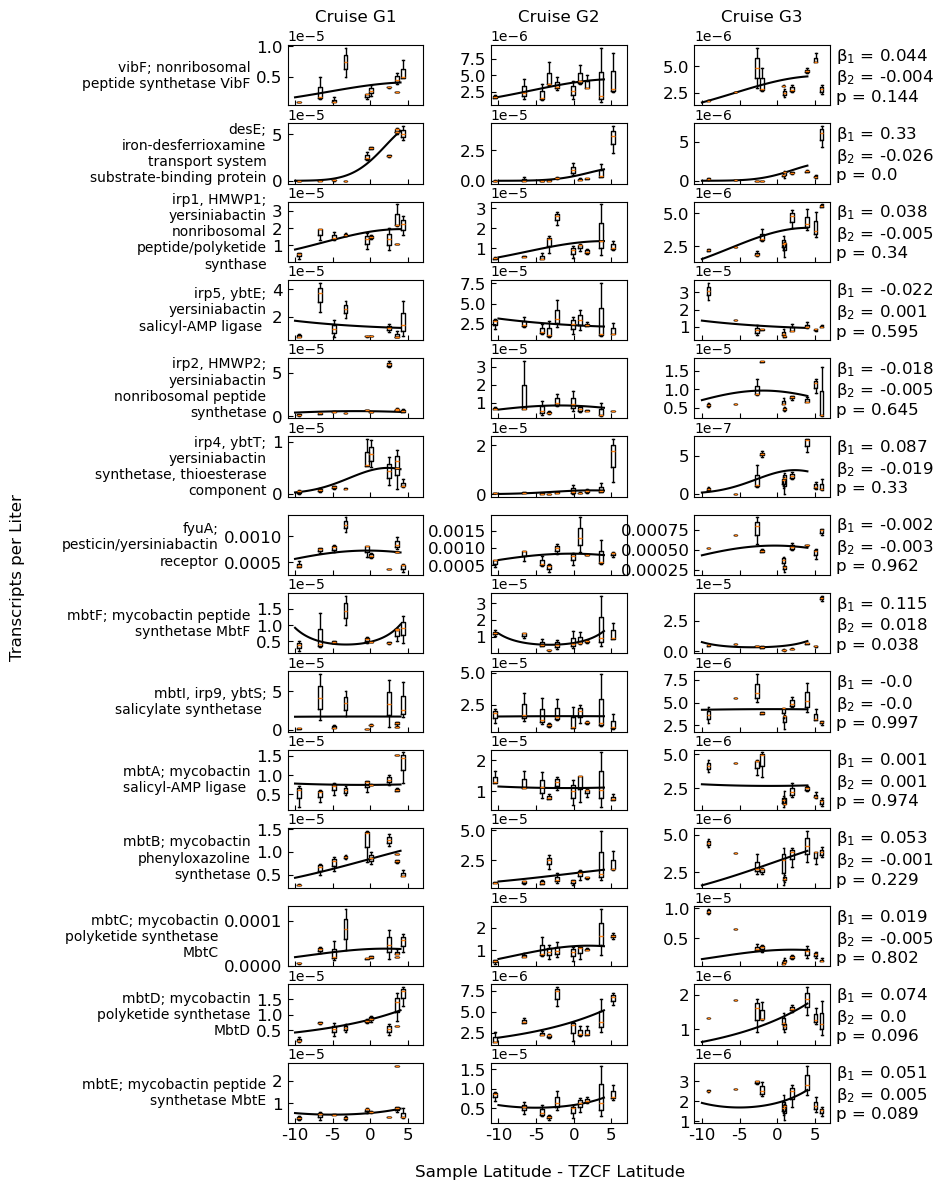

In [151]:
ft = 12
fig, axes = plt.subplots(len(kos),3, figsize=(7,len(kos)))
lablen = 25
for i, (ko) in enumerate(kos):
    dict_res = results[ko]
    # PLot cruises
    const, ld, ld2 = [dict_res['model'][c] for c in ['const','lat_diff','lat_diff^2']]
    for j, cruise in enumerate(['G1','G2','G3']):
    # for j, cruise in enumerate(['G1']):
        df_piv = df[df['cruise'] == cruise].copy()
        if df_piv.shape[0] > 0:
            ax = axes[i,j]
            lats_unq = df_piv.lat_diff.unique()
            vals = []
            for l in lats_unq:
                vals.append(df_piv.loc[df_piv['lat_diff'] == l, ko].values)
            ax.boxplot(vals, positions=lats_unq)

            # Plot model
            crs = 0
            if not cruise == 'G1':
                crs = dict_res['model'][f'cruise_{cruise}']
            x = np.linspace(-10,4,100)
            # y = np.exp(const + ld*x + ld2*x**2 + ld3*x**3 + crs)
            y = np.exp(const + ld*x + ld2*x**2 + crs)
            ax.plot(x,y, 'k')

            x = np.arange(-10,10,5)
            ax.set_xticks(x)
            xticklabels = x if i == len(kos) - 1 else []
            ax.set_xticklabels(xticklabels)
            ax.set_xlim(-11,7)
            # ax.set_title(cruise, size=ft)
            ax.tick_params(direction="in", labelsize=ft)
            # if cruise == 'G3':
            #     ax.set_ylim(0,2e8)
            if j == 0:
                # Get gene description
                name = dict_ko_name[ko]
                nm = re.search(r'(?<=^K\d{5}\s\s).+', name)[0]
                splt = '[EC:'
                if splt in nm:
                    nm = nm.split(splt)[0]
                # Separate description on spaces
                lab = ''
                i_0 = 0
                i_1 = lablen
                while i_1 < len(nm):
                    l = nm[i_0:i_1]
                    if ' ' in l:
                        i_1 = l.rfind(' ')
                        lab += l[:i_1] + '\n'
                        i_0 = i_0 + i_1 + 1
                        i_1  = i_0 + lablen
                    else:
                        i_1 += lablen

                l = nm[i_0:]
                if len(l) > lablen:
                    if ' ' in l:
                        i_1 = l.rfind(' ')
                        lab += l[:i_1] + '\n'
                        i_0 = i_0 + i_1 + 1
                        l = nm[i_0:]
                lab += l
                ax.set_ylabel(lab, rotation=0, va='center',ha='right')
            if j == 2:
                p = dict_res['adj_perm_pvalues']['p_value']['lat_diff']
                sscrpt = [1,2]
                text = f'β$_{{1}}$ = {round(ld,3)}\nβ$_{{2}}$ = {round(ld2,3)}\np = {round(p,3)}'
                ax.yaxis.set_label_position("right")
                ax.set_ylabel(text, rotation=0, fontsize=ft, ha='left', va='center')
            if i == 0:
                ax.set_title(f'Cruise {cruise}')


fig.text(0.5, 0.08, f'Sample Latitude - TZCF Latitude', rotation=0, va='top',ha='center', fontsize=ft)
fig.text(-0.25, 0.5, f'Transcripts per Liter', rotation=90, va='center',ha='right', fontsize=ft)

plt.subplots_adjust(wspace=0.5, hspace=0.3)

dir_out = '/scratch/bgrodner/iron_ko_contigs/metat_search_results/spatial_variability_latitude_tzcf_glm'
fmt_out = f'{dir_out}/plots/sidero_other_{sel}_size_{size}_trl_glm.{{ext}}'
exts = ['png','pdf']
do = os.path.split(fmt_out)[0]
if not os.path.exists(do): os.makedirs(do)
fns_out = [fmt_out.format(ext=ext) for ext in exts]
for fn_out in fns_out:
    plt.savefig(fn_out, dpi=500, bbox_inches='tight')


#### Plot other iron transport genes

Get values and curves for summed size fractions

In [152]:
# Pick kos
kos = [
    'K02010','K02012','K02015','K02016','K02069','K07230','K11709','K12346','K21398'
]
vt = 'frac'
sel = 'NS'
size = '0.2um'
results = dict_vt_sel_sz_overallkoresults[vt][sel][size]
label_cols = ['lat_diff','cruise','rep']

df = dict_vt_sel_sz_allkopreddf[vt][sel][size].copy()
df = df[kos + label_cols]

# # subset the dataframes
# df_sub = []
# for size in ['0.2um']:
#     df = dict_vt_sel_sz_allkopreddf[vt][sel][size].copy()
#     df = df[kos + label_cols]
#     df = df.sort_values(by=['cruise','lat_diff','rep'])
#     print(df.shape)
#     df_sub.append(df)

# # Sum the transcripts per liter
# df_sub_merge = np.zeros_like(df_sub[0][kos].values)
# for df in df_sub:
#     df_sub_merge += df[kos].values
# df_sub_merge = pd.DataFrame(df_sub_merge, index=df_sub[0].index, columns=kos)
# df_sub_merge = df_sub_merge.merge(df_sub[0][label_cols], left_index=True,right_index=True)

# # run the glm fitting
# results = frm.fit_many_models(
#     data=df,
#     response_cols=kos,
#     covariate_cols=['lat_diff','cruise'],
#     poly_cols=['lat_diff'], 
#     poly_degree=2,
#     iqr_coefficient=10,
#     perm_test_vars=['lat_diff'], 
#     n_perm=1000, 
#     stat='coef',
#     random_state=None,
#     n_jobs=len(kos),
# )



Plot 

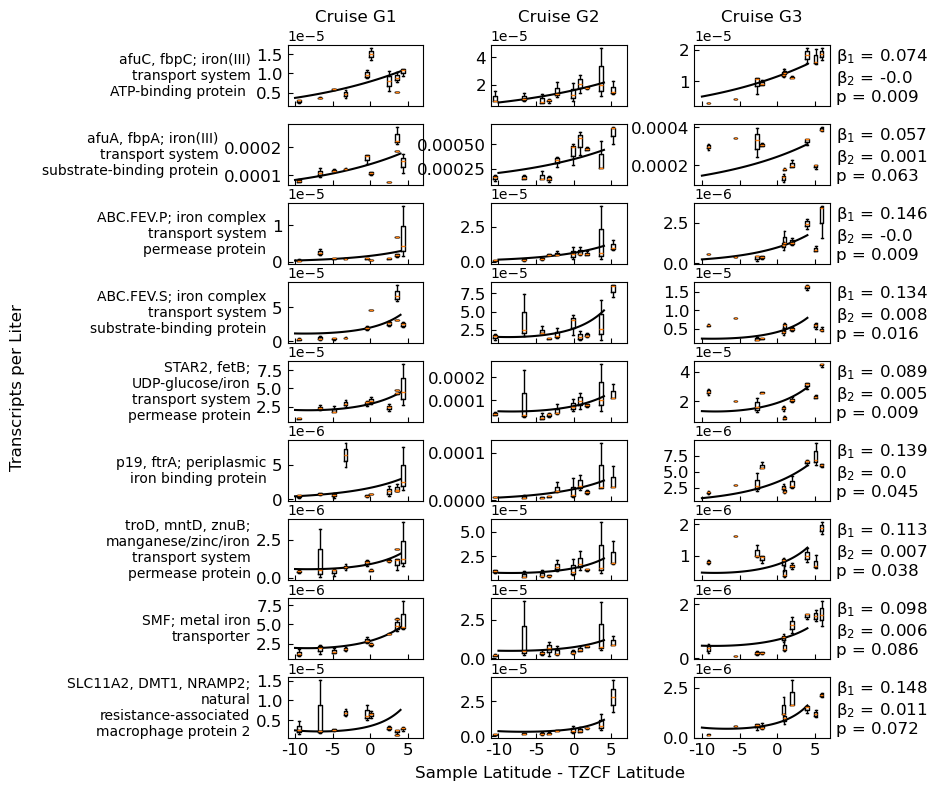

In [153]:
ft = 12
fig, axes = plt.subplots(len(kos),3, figsize=(7,len(kos)))
lablen = 25
for i, (ko) in enumerate(kos):
    dict_res = results[ko]
    # PLot cruises
    const, ld, ld2 = [dict_res['model'][c] for c in ['const','lat_diff','lat_diff^2']]
    for j, cruise in enumerate(['G1','G2','G3']):
    # for j, cruise in enumerate(['G1']):
        df_piv = df[df['cruise'] == cruise].copy()
        if df_piv.shape[0] > 0:
            ax = axes[i,j]
            lats_unq = df_piv.lat_diff.unique()
            vals = []
            for l in lats_unq:
                vals.append(df_piv.loc[df_piv['lat_diff'] == l, ko].values)
            ax.boxplot(vals, positions=lats_unq)

            # Plot model
            crs = 0
            if not cruise == 'G1':
                crs = dict_res['model'][f'cruise_{cruise}']
            x = np.linspace(-10,4,100)
            # y = np.exp(const + ld*x + ld2*x**2 + ld3*x**3 + crs)
            y = np.exp(const + ld*x + ld2*x**2 + crs)
            ax.plot(x,y, 'k')

            x = np.arange(-10,10,5)
            ax.set_xticks(x)
            xticklabels = x if i == len(kos) - 1 else []
            ax.set_xticklabels(xticklabels)
            ax.set_xlim(-11,7)
            # ax.set_title(cruise, size=ft)
            ax.tick_params(direction="in", labelsize=ft)
            # if cruise == 'G3':
            #     ax.set_ylim(0,2e8)
            if j == 0:
                # Get gene description
                name = dict_ko_name[ko]
                nm = re.search(r'(?<=^K\d{5}\s\s).+', name)[0]
                splt = '[EC:'
                if splt in nm:
                    nm = nm.split(splt)[0]
                # Separate description on spaces
                lab = ''
                i_0 = 0
                i_1 = lablen
                while i_1 < len(nm):
                    l = nm[i_0:i_1]
                    if ' ' in l:
                        i_1 = l.rfind(' ')
                        lab += l[:i_1] + '\n'
                        i_0 = i_0 + i_1 + 1
                        i_1  = i_0 + lablen
                    else:
                        i_1 += lablen

                l = nm[i_0:]
                if len(l) > lablen:
                    if ' ' in l:
                        i_1 = l.rfind(' ')
                        lab += l[:i_1] + '\n'
                        i_0 = i_0 + i_1 + 1
                        l = nm[i_0:]
                lab += l
                ax.set_ylabel(lab, rotation=0, va='center',ha='right')
            if j == 2:
                p = dict_res['adj_perm_pvalues']['p_value']['lat_diff']
                sscrpt = [1,2]
                text = f'β$_{{1}}$ = {round(ld,3)}\nβ$_{{2}}$ = {round(ld2,3)}\np = {round(p,3)}'
                ax.yaxis.set_label_position("right")
                ax.set_ylabel(text, rotation=0, fontsize=ft, ha='left', va='center')
            if i == 0:
                ax.set_title(f'Cruise {cruise}')


fig.text(0.5, 0.08, f'Sample Latitude - TZCF Latitude', rotation=0, va='top',ha='center', fontsize=ft)
fig.text(-0.25, 0.5, f'Transcripts per Liter', rotation=90, va='center',ha='right', fontsize=ft)

plt.subplots_adjust(wspace=0.5, hspace=0.3)

dir_out = '/scratch/bgrodner/iron_ko_contigs/metat_search_results/spatial_variability_latitude_tzcf_glm'
fmt_out = f'{dir_out}/plots/iron_transport_other_{sel}_size_{size}_trl_glm.{{ext}}'
exts = ['png','pdf']
do = os.path.split(fmt_out)[0]
if not os.path.exists(do): os.makedirs(do)
fns_out = [fmt_out.format(ext=ext) for ext in exts]
for fn_out in fns_out:
    plt.savefig(fn_out, dpi=500, bbox_inches='tight')


#### Plot ferritin genes

Get values and curves for summed size fractions

In [280]:
# Pick kos
kos = [
    'K13625','K00522','K02217','K02255','K03594','K22336','K18495'
]
vt = 'frac'
sel = 'NS'
size = '0.2um'
results = dict_vt_sel_sz_overallkoresults[vt][sel][size]
label_cols = ['lat_diff','cruise','rep']

df = dict_vt_sel_sz_allkopreddf[vt][sel][size].copy()
df = df[kos + label_cols]

# # subset the dataframes
# df_sub = []
# for size in ['0.2um']:
#     df = dict_vt_sel_sz_allkopreddf[vt][sel][size].copy()
#     df = df[kos + label_cols]
#     df = df.sort_values(by=['cruise','lat_diff','rep'])
#     print(df.shape)
#     df_sub.append(df)

# # Sum the transcripts per liter
# df_sub_merge = np.zeros_like(df_sub[0][kos].values)
# for df in df_sub:
#     df_sub_merge += df[kos].values
# df_sub_merge = pd.DataFrame(df_sub_merge, index=df_sub[0].index, columns=kos)
# df_sub_merge = df_sub_merge.merge(df_sub[0][label_cols], left_index=True,right_index=True)

# # run the glm fitting
# results = frm.fit_many_models(
#     data=df,
#     response_cols=kos,
#     covariate_cols=['lat_diff','cruise'],
#     poly_cols=['lat_diff'], 
#     poly_degree=2,
#     iqr_coefficient=10,
#     perm_test_vars=['lat_diff'], 
#     n_perm=1000, 
#     stat='coef',
#     random_state=None,
#     n_jobs=len(kos),
# )



KeyError: '0.2um'

58.91902861847484
3.6956143587331576e-05
67.79637204359642
0.0006075667993610082
166.87960318297337
2.9583877422447542e-05


Plot 

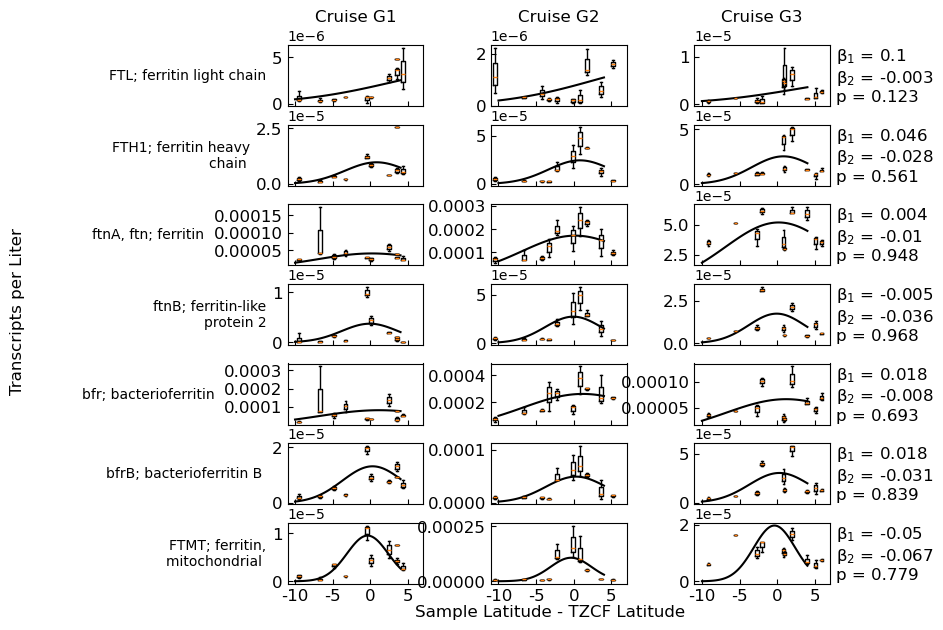

In [155]:
ft = 12
fig, axes = plt.subplots(len(kos),3, figsize=(7,len(kos)))
lablen = 25
for i, (ko) in enumerate(kos):
    dict_res = results[ko]
    # PLot cruises
    const, ld, ld2 = [dict_res['model'][c] for c in ['const','lat_diff','lat_diff^2']]
    for j, cruise in enumerate(['G1','G2','G3']):
    # for j, cruise in enumerate(['G1']):
        df_piv = df[df['cruise'] == cruise].copy()
        if df_piv.shape[0] > 0:
            ax = axes[i,j]
            lats_unq = df_piv.lat_diff.unique()
            vals = []
            for l in lats_unq:
                vals.append(df_piv.loc[df_piv['lat_diff'] == l, ko].values)
            ax.boxplot(vals, positions=lats_unq)

            # Plot model
            crs = 0
            if not cruise == 'G1':
                crs = dict_res['model'][f'cruise_{cruise}']
            x = np.linspace(-10,4,100)
            # y = np.exp(const + ld*x + ld2*x**2 + ld3*x**3 + crs)
            y = np.exp(const + ld*x + ld2*x**2 + crs)
            ax.plot(x,y, 'k')

            x = np.arange(-10,10,5)
            ax.set_xticks(x)
            xticklabels = x if i == len(kos) - 1 else []
            ax.set_xticklabels(xticklabels)
            ax.set_xlim(-11,7)
            # ax.set_title(cruise, size=ft)
            ax.tick_params(direction="in", labelsize=ft)
            # if cruise == 'G3':
            #     ax.set_ylim(0,2e8)
            if j == 0:
                # Get gene description
                name = dict_ko_name[ko]
                nm = re.search(r'(?<=^K\d{5}\s\s).+', name)[0]
                splt = '[EC:'
                if splt in nm:
                    nm = nm.split(splt)[0]
                # Separate description on spaces
                lab = ''
                i_0 = 0
                i_1 = lablen
                while i_1 < len(nm):
                    l = nm[i_0:i_1]
                    if ' ' in l:
                        i_1 = l.rfind(' ')
                        lab += l[:i_1] + '\n'
                        i_0 = i_0 + i_1 + 1
                        i_1  = i_0 + lablen
                    else:
                        i_1 += lablen

                l = nm[i_0:]
                if len(l) > lablen:
                    if ' ' in l:
                        i_1 = l.rfind(' ')
                        lab += l[:i_1] + '\n'
                        i_0 = i_0 + i_1 + 1
                        l = nm[i_0:]
                lab += l
                ax.set_ylabel(lab, rotation=0, va='center',ha='right')
            if j == 2:
                p = dict_res['adj_perm_pvalues']['p_value']['lat_diff']
                sscrpt = [1,2]
                text = f'β$_{{1}}$ = {round(ld,3)}\nβ$_{{2}}$ = {round(ld2,3)}\np = {round(p,3)}'
                ax.yaxis.set_label_position("right")
                ax.set_ylabel(text, rotation=0, fontsize=ft, ha='left', va='center')
            if i == 0:
                ax.set_title(f'Cruise {cruise}')


fig.text(0.5, 0.08, f'Sample Latitude - TZCF Latitude', rotation=0, va='top',ha='center', fontsize=ft)
fig.text(-0.25, 0.5, f'Transcripts per Liter', rotation=90, va='center',ha='right', fontsize=ft)

plt.subplots_adjust(wspace=0.5, hspace=0.3)

dir_out = '/scratch/bgrodner/iron_ko_contigs/metat_search_results/spatial_variability_latitude_tzcf_glm'
fmt_out = f'{dir_out}/plots/ferritin_{sel}_size_{size}_trl_glm.{{ext}}'
exts = ['png','pdf']
do = os.path.split(fmt_out)[0]
if not os.path.exists(do): os.makedirs(do)
fns_out = [fmt_out.format(ext=ext) for ext in exts]
for fn_out in fns_out:
    plt.savefig(fn_out, dpi=500, bbox_inches='tight')


In [261]:
dir_out = '/scratch/bgrodner/iron_ko_contigs/metat_search_results/spatial_variability_latitude_tzcf_glm'
fmt_out = f'{dir_out}/plots/transferrin_NS_size_combined_trl_glm.{{ext}}'
fmt_out

'/scratch/bgrodner/iron_ko_contigs/metat_search_results/spatial_variability_latitude_tzcf_glm/plots/transferrin_NS_size_combined_trl_glm.{ext}'

In [313]:
re.search(r'(?<=^K\d{5}\s\s).+', name)[0]

'fldA, nifF, isiB; flavodoxin I'

In [295]:
ko = 'K00371'
lablen = 25

# Get gene description
name = dict_ko_name[ko]
nm = re.search(r'(?<=;\s).+', name)[0]
splt = '[EC:'
if splt in nm:
    nm = nm.split(splt)[0]
# Separate description on spaces
lab = ''
i_0 = 0
i_1 = lablen
while i_1 < len(nm):
    l = nm[i_0:i_1]
    if ' ' in l:
        i_1 = l.rfind(' ')
        lab += l[:i_1] + '\n'
        i_0 = i_0 + i_1 + 1
        i_1  = i_0 + lablen
    else:
        i_1 += lablen

l = nm[i_0:]
if len(l) > lablen:
    if ' ' in l:
        i_1 = l.rfind(' ')
        lab += l[:i_1] + '\n'
        i_0 = i_0 + i_1 + 1
        l = nm[i_0:]
lab += l
print(lab)

nitrate reductase /
nitrite oxidoreductase,
beta subunit 


In [238]:
15// 4

3

### What are the taxa that dominate some of these genes?

Get taxa for ko

In [174]:
# ko = 'K25287' # desE
# ko = 'K03594' # bacterioferritin
# ko = 'K15721' # pesticin/yersiniabactin receptor
# ko = 'K01623' # ALDO
# ko = 'K03320' # amt
# ko = 'K03839' # flda
# ko = 'K16090' # catecholate sidero recept
# ko = 'K14736' # transferrin
ko = 'K06503' # transferrin receptor
sel = 'NS'
size = '0.2um'
preddf = dict_vt_sel_sz_allkopreddf['trl'][sel][size]
total_trl = preddf[ko].sum()
dict_tax_trlfrac = {}
for tax, dict_ko_sample_estcounts in dict_iron_taxon_ko_sample_estcounts.items():
    dict_sample_estcounts = dict_ko_sample_estcounts.get(ko)
    trl_tax = 0
    if dict_sample_estcounts is not None:
        for sample, estcounts in dict_sample_estcounts.items():
            row_meta = dict_meta[sample]
            norm_factor, cruise, sl, sz, rep = [row_meta[v] for v in ['norm_factor','cruise','selection','size','rep']]
            if (sl == sel) & (sz == size):
                trl_tax += estcounts * norm_factor
    if trl_tax > 0:
        dict_tax_trlfrac[tax] = [trl_tax, trl_tax / total_trl]


In [175]:
taxa, trls, fracs = [], [], []
for tax, (trl, frac) in dict_tax_trlfrac.items():
    taxa.append(tax)
    trls.append(trl)
    fracs.append(frac)

taxa_sort = [x for _, x in sorted(zip(fracs, taxa), reverse=True)]
fracs_sort = sorted(fracs, reverse=True)
for tax, frac in zip(taxa_sort, fracs_sort):
    try:
        name = ncbi.get_taxid_translator([tax])[int(tax)]
    except:
        name = tax
    print(round(frac, 5), name)

0.18699 Bacteroidota/Chlorobiota group
0.16458 Flavobacteriia
0.13725 Alteromonas
0.13264 Flavobacteriaceae
0.10765 cellular organisms
0.10348 Bacteroidota
0.02343 unclassified Formosa
0.02259 Flavobacteria bacterium MS024-2A
0.02107 Flavobacteriales
0.01509 Oxyrrhis marina
0.01272 Eumetazoa
0.01134 Idiomarina baltica OS145
0.00737 Hydra vulgaris
0.00672 Bilateria
0.00562 uncultured Candidatus Poseidoniales archaeon
0.005 Bacteria
0.00477 Macrodasyida
0.00352 Pseudoalteromonas lipolytica SCSIO 04301
0.00308 Alteromonas australica
0.00261 Oikopleura dioica
0.00258 Calanoida
0.00238 Discosea
0.0023 Calanus finmarchicus
0.00217 Bacillariophyta
0.00172 Gammaproteobacteria
0.00136 Kareniaceae
0.0013 Chromatiaceae
0.0012 Strongylocentrotus purpuratus
0.00111 Paracyclopina nana
0.00096 Metazoa
0.00093 0
0.00089 Eukaryota
0.00084 Dictyochophyceae
0.0008 Emiliania huxleyi
0.00069 Karlodinium veneficum
0.00057 Dinophyceae
0.00041 Thioalkalivibrio paradoxus ARh 1
0.00016 Shewanella
6e-05 Suessial

## What is going on with the narGHI genes?

Load dict of ko to contig name

In [183]:
fn_dict_ko_contigs = '/scratch/bgrodner/iron_ko_contigs/metat_search_results/dicts_iron_KO_contig/G1NS_kofam2021_ALL.csv-iron_KOs.txt-dict.json'

with open(fn_dict_ko_contigs, 'r') as f:
    dict_ko_contigs = json.load(f)

Get contigs for genes

In [184]:
kos = ['K00371','K00370','K00374']
contigs = dict_ko_contigs[kos[0]]
contigs[:3]

['G1NS.S02C1_0_2um_TRINITY_DN1261927_c1_g2_i1_2',
 'G1NS.S02C1_0_2um_TRINITY_DN1261927_c1_g2_i2_1',
 'G1NS.S02C1_0_2um_TRINITY_DN1312163_c0_g1_i2_2']

### Inspect the raw counts

Load directly from the dict

In [227]:
sel = 'NS'
size = '0.2um'
dict_ko_cruise_lat_rep_estcount = defaultdict(
    lambda: defaultdict(
        lambda: defaultdict(
            lambda: defaultdict(float)
        )
    )
)
for _, dict_ko_sample_estcounts in dict_iron_taxon_ko_sample_estcounts.items():
    for ko in kos:
        for sample, estcounts in dict_ko_sample_estcounts[ko].items():
            row_meta = dict_meta[sample]
            cruise, sl, sz, lat, rep, norm_factor = [row_meta[v] for v in ['cruise','selection','size','latitude','rep','norm_factor']]
            bools = (sl == sel) & (sz == size) & (cruise in ['G1','G2','G3'])
            if bools:
                lat = float(lat.strip('deg'))
                _, tzcf = dict_cruise_trans_sal_chl[cruise]
                lat_diff = lat - tzcf
                dict_ko_cruise_lat_rep_estcount[ko][cruise][lat_diff][rep] += estcounts * norm_factor


Plot the estcounts

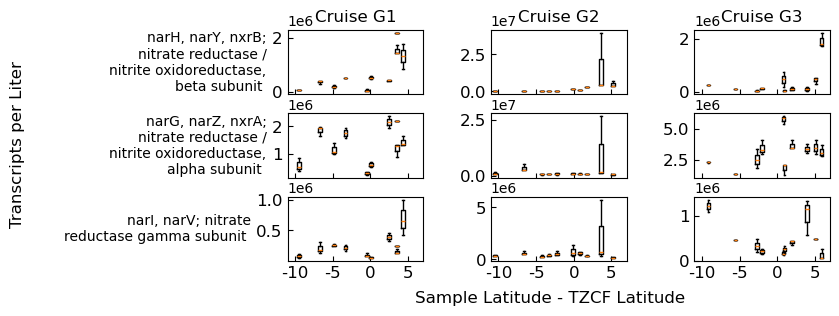

In [228]:
ft = 12
fig, axes = plt.subplots(len(kos),3, figsize=(7,len(kos)))
lablen = 25
for i, (ko) in enumerate(kos):
    # PLot cruises
    for j, cruise in enumerate(['G1','G2','G3']):
    # for j, cruise in enumerate(['G1']):
        dict_lat_rep_estcount = dict_ko_cruise_lat_rep_estcount[ko][cruise]
        ax = axes[i,j]
        lats_unq = list(dict_lat_rep_estcount.keys())
        vals = []
        for l in lats_unq:
            v = list(dict_lat_rep_estcount[l].values())
            vals.append(v)
        ax.boxplot(vals, positions=lats_unq)


        x = np.arange(-10,10,5)
        ax.set_xticks(x)
        xticklabels = x if i == len(kos) - 1 else []
        ax.set_xticklabels(xticklabels)
        ax.set_xlim(-11,7)
        # ax.set_title(cruise, size=ft)
        ax.tick_params(direction="in", labelsize=ft)
        # if cruise == 'G3':
        #     ax.set_ylim(0,2e8)
        if j == 0:
            # Get gene description
            name = dict_ko_name[ko]
            nm = re.search(r'(?<=^K\d{5}\s\s).+', name)[0]
            splt = '[EC:'
            if splt in nm:
                nm = nm.split(splt)[0]
            # Separate description on spaces
            lab = ''
            i_0 = 0
            i_1 = lablen
            while i_1 < len(nm):
                l = nm[i_0:i_1]
                if ' ' in l:
                    i_1 = l.rfind(' ')
                    lab += l[:i_1] + '\n'
                    i_0 = i_0 + i_1 + 1
                    i_1  = i_0 + lablen
                else:
                    i_1 += lablen

            l = nm[i_0:]
            if len(l) > lablen:
                if ' ' in l:
                    i_1 = l.rfind(' ')
                    lab += l[:i_1] + '\n'
                    i_0 = i_0 + i_1 + 1
                    l = nm[i_0:]
            lab += l
            ax.set_ylabel(lab, rotation=0, va='center',ha='right')
        if i == 0:
            ax.set_title(f'Cruise {cruise}')


fig.text(0.5, 0.01, f'Sample Latitude - TZCF Latitude', rotation=0, va='top',ha='center', fontsize=ft)
fig.text(-0.25, 0.5, f'Transcripts per Liter', rotation=90, va='center',ha='right', fontsize=ft)

plt.subplots_adjust(wspace=0.5, hspace=0.3)

# dir_out = '/scratch/bgrodner/iron_ko_contigs/metat_search_results/spatial_variability_latitude_tzcf_glm'
# fmt_out = f'{dir_out}/plots/nitrogen_NS_size_{size}_trl_glm.{{ext}}'
# exts = ['png','pdf']
# do = os.path.split(fmt_out)[0]
# if not os.path.exists(do): os.makedirs(do)
# fns_out = [fmt_out.format(ext=ext) for ext in exts]
# for fn_out in fns_out:
#     plt.savefig(fn_out, dpi=500, bbox_inches='tight')


Load with taxa directly from the dict

In [229]:
sel = 'NS'
size = '0.2um'
dict_ko_tax_cruise_lat_rep_estcount = defaultdict(
    lambda: defaultdict(
        lambda: defaultdict(
            lambda: defaultdict(
                lambda: defaultdict(float)
            )
        )
    )
)
for tax, dict_ko_sample_estcounts in dict_iron_taxon_ko_sample_estcounts.items():
    for ko in kos:
        for sample, estcounts in dict_ko_sample_estcounts[ko].items():
            row_meta = dict_meta[sample]
            cruise, sl, sz, lat, rep, norm_factor = [row_meta[v] for v in ['cruise','selection','size','latitude','rep','norm_factor']]
            bools = (sl == sel) & (sz == size) & (cruise in ['G1','G2','G3'])
            if bools:
                lat = float(lat.strip('deg'))
                _, tzcf = dict_cruise_trans_sal_chl[cruise]
                lat_diff = lat - tzcf
                dict_ko_tax_cruise_lat_rep_estcount[ko][tax][cruise][lat_diff][rep] += estcounts * norm_factor


How many taxa?

In [230]:
for ko, dict_tax_cruise_lat_rep_estcount in dict_ko_tax_cruise_lat_rep_estcount.items():
    taxa, ecs = [],[]
    for tax, dict_cruise_lat_rep_estcount in dict_tax_cruise_lat_rep_estcount.items():
        ectotal = 0
        for cruise, dict_lat_rep_estcount in dict_cruise_lat_rep_estcount.items():
            for lat, dict_rep_estcount in dict_lat_rep_estcount.items():
                for rep, ec in dict_rep_estcount.items():
                    ectotal += ec
        taxa.append(tax)
        ecs.append(ectotal)
    print(dict_ko_name[ko])
    for ec, tax in sorted(zip(ecs, taxa), reverse=True):
        try:
            name = ncbi.get_taxid_translator([tax])[int(tax)]
        except:
            name = tax
        print(f"\t{round(ec):,}\t", name)




K00371  narH, narY, nxrB; nitrate reductase / nitrite oxidoreductase, beta subunit [EC:1.7.5.1 1.7.99.-]
	49,320,517	 Eukaryota
	27,046,856	 Crocinitomicaceae
	19,178,899	 cellular organisms
	4,943,448	 Flavobacteriia
	2,349,427	 Owenweeksia hongkongensis
	1,005,157	 Pseudomonadota
	593,958	 Cytophagales
	506,546	 Macrodasyida
	458,611	 Gammaproteobacteria
	307,862	 Gastrotricha
	263,945	 Aureispira sp. CCB-QB1
	259,251	 Verrucomicrobiota
	249,114	 Schleiferiaceae
	244,479	 Rhodobacterales
	242,348	 Sar
	176,393	 Fidelibacterota bacterium SCGC AAA160-I06
	131,538	 Coraliomargarita akajimensis
	127,841	 0
	74,488	 Chroodactylon ornatum
	69,211	 Shewanella
	68,403	 Bacteria
	67,546	 Saccharina japonica
	67,318	 Flavobacteriaceae
	55,164	 Burkholderiales
	20,294	 Chloropicon mariensis
	18,204	 Saprospiraceae
	17,946	 Bacteroidota
	15,606	 gamma proteobacterium HIMB30
	10,167	 Fluviicola taffensis
	1,743	 Saprospirales
	0	 Chaetoceros sp.
	0	 Flavobacteria bacterium MS024-2A
	0	 Chrysochro

Plot the estcounts only for bacteria

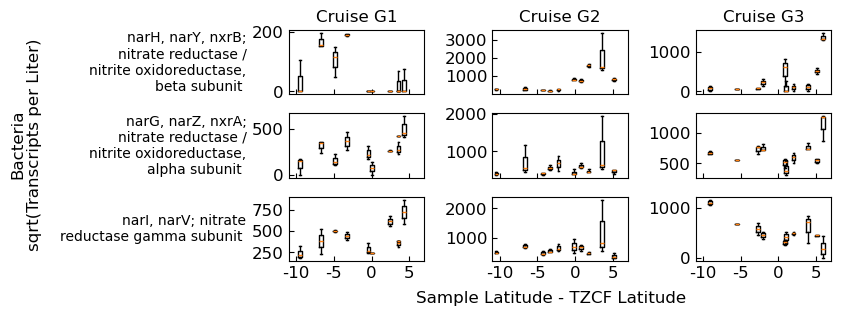

In [233]:
taxname = 'Bacteria'
tax_target = ncbi.get_name_translator([taxname])[taxname][0]
ft = 12
fig, axes = plt.subplots(len(kos),3, figsize=(7,len(kos)))
lablen = 25
for i, (ko) in enumerate(kos):
    # PLot cruises
    for j, cruise in enumerate(['G1','G2','G3']):
    # for j, cruise in enumerate(['G1']):
        dict_lat_rep_estcount = defaultdict(
            lambda: defaultdict(float)
        )
        for tax, dict_cruise_lat_rep_estcount in dict_ko_tax_cruise_lat_rep_estcount[ko].items():
            try:
                lin = ncbi.get_lineage(tax)
            except:
                lin = []
            if tax_target in lin:
                for lat, dict_rep_estcount in dict_cruise_lat_rep_estcount[cruise].items():
                    for rep, ec in dict_rep_estcount.items():
                        dict_lat_rep_estcount[lat][rep] += ec

        # dict_lat_rep_estcount = d_cruise_lat_rep_estcount[cruise]
        ax = axes[i,j]
        lats_unq = list(dict_lat_rep_estcount.keys())
        vals = []
        for l in lats_unq:
            v = np.sqrt(list(dict_lat_rep_estcount[l].values()))
            vals.append(v)
        ax.boxplot(vals, positions=lats_unq)


        x = np.arange(-10,10,5)
        ax.set_xticks(x)
        xticklabels = x if i == len(kos) - 1 else []
        ax.set_xticklabels(xticklabels)
        ax.set_xlim(-11,7)
        # ax.set_title(cruise, size=ft)
        ax.tick_params(direction="in", labelsize=ft)
        # if cruise == 'G3':
        #     ax.set_ylim(0,2e8)
        if j == 0:
            # Get gene description
            name = dict_ko_name[ko]
            nm = re.search(r'(?<=^K\d{5}\s\s).+', name)[0]
            splt = '[EC:'
            if splt in nm:
                nm = nm.split(splt)[0]
            # Separate description on spaces
            lab = ''
            i_0 = 0
            i_1 = lablen
            while i_1 < len(nm):
                l = nm[i_0:i_1]
                if ' ' in l:
                    i_1 = l.rfind(' ')
                    lab += l[:i_1] + '\n'
                    i_0 = i_0 + i_1 + 1
                    i_1  = i_0 + lablen
                else:
                    i_1 += lablen

            l = nm[i_0:]
            if len(l) > lablen:
                if ' ' in l:
                    i_1 = l.rfind(' ')
                    lab += l[:i_1] + '\n'
                    i_0 = i_0 + i_1 + 1
                    l = nm[i_0:]
            lab += l
            ax.set_ylabel(lab, rotation=0, va='center',ha='right')
        if i == 0:
            ax.set_title(f'Cruise {cruise}')


fig.text(0.5, 0.01, f'Sample Latitude - TZCF Latitude', rotation=0, va='top',ha='center', fontsize=ft)
fig.text(-0.25, 0.5, f'{taxname}\nsqrt(Transcripts per Liter)', rotation=90, va='center',ha='center', fontsize=ft)

plt.subplots_adjust(wspace=0.5, hspace=0.3)

# dir_out = '/scratch/bgrodner/iron_ko_contigs/metat_search_results/spatial_variability_latitude_tzcf_glm'
# fmt_out = f'{dir_out}/plots/nitrogen_NS_size_{size}_trl_glm.{{ext}}'
# exts = ['png','pdf']
# do = os.path.split(fmt_out)[0]
# if not os.path.exists(do): os.makedirs(do)
# fns_out = [fmt_out.format(ext=ext) for ext in exts]
# for fn_out in fns_out:
#     plt.savefig(fn_out, dpi=500, bbox_inches='tight')


Plot the estcounts only for Eukaryota

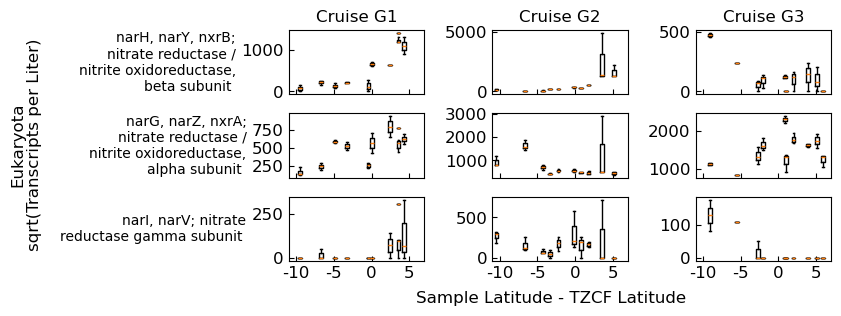

In [242]:
taxname = 'Eukaryota'
tax_target = ncbi.get_name_translator([taxname])[taxname][0]
ft = 12
fig, axes = plt.subplots(len(kos),3, figsize=(7,len(kos)))
lablen = 25
for i, (ko) in enumerate(kos):
    # PLot cruises
    for j, cruise in enumerate(['G1','G2','G3']):
    # for j, cruise in enumerate(['G1']):
        dict_lat_rep_estcount = defaultdict(
            lambda: defaultdict(float)
        )
        for tax, dict_cruise_lat_rep_estcount in dict_ko_tax_cruise_lat_rep_estcount[ko].items():
            try:
                lin = ncbi.get_lineage(tax)
            except:
                lin = []
            if tax_target in lin:
                for lat, dict_rep_estcount in dict_cruise_lat_rep_estcount[cruise].items():
                    for rep, ec in dict_rep_estcount.items():
                        dict_lat_rep_estcount[lat][rep] += ec

        # dict_lat_rep_estcount = d_cruise_lat_rep_estcount[cruise]
        ax = axes[i,j]
        lats_unq = list(dict_lat_rep_estcount.keys())
        vals = []
        for l in lats_unq:
            v = np.sqrt(list(dict_lat_rep_estcount[l].values()))
            vals.append(v)
        ax.boxplot(vals, positions=lats_unq)


        x = np.arange(-10,10,5)
        ax.set_xticks(x)
        xticklabels = x if i == len(kos) - 1 else []
        ax.set_xticklabels(xticklabels)
        ax.set_xlim(-11,7)
        # ax.set_title(cruise, size=ft)
        ax.tick_params(direction="in", labelsize=ft)
        # if cruise == 'G3':
        #     ax.set_ylim(0,2e8)
        if j == 0:
            # Get gene description
            name = dict_ko_name[ko]
            nm = re.search(r'(?<=^K\d{5}\s\s).+', name)[0]
            splt = '[EC:'
            if splt in nm:
                nm = nm.split(splt)[0]
            # Separate description on spaces
            lab = ''
            i_0 = 0
            i_1 = lablen
            while i_1 < len(nm):
                l = nm[i_0:i_1]
                if ' ' in l:
                    i_1 = l.rfind(' ')
                    lab += l[:i_1] + '\n'
                    i_0 = i_0 + i_1 + 1
                    i_1  = i_0 + lablen
                else:
                    i_1 += lablen

            l = nm[i_0:]
            if len(l) > lablen:
                if ' ' in l:
                    i_1 = l.rfind(' ')
                    lab += l[:i_1] + '\n'
                    i_0 = i_0 + i_1 + 1
                    l = nm[i_0:]
            lab += l
            ax.set_ylabel(lab, rotation=0, va='center',ha='right')
        if i == 0:
            ax.set_title(f'Cruise {cruise}')


fig.text(0.5, 0.01, f'Sample Latitude - TZCF Latitude', rotation=0, va='top',ha='center', fontsize=ft)
fig.text(-0.25, 0.5, f'{taxname}\nsqrt(Transcripts per Liter)', rotation=90, va='center',ha='center', fontsize=ft)

plt.subplots_adjust(wspace=0.5, hspace=0.3)

# dir_out = '/scratch/bgrodner/iron_ko_contigs/metat_search_results/spatial_variability_latitude_tzcf_glm'
# fmt_out = f'{dir_out}/plots/nitrogen_NS_size_{size}_trl_glm.{{ext}}'
# exts = ['png','pdf']
# do = os.path.split(fmt_out)[0]
# if not os.path.exists(do): os.makedirs(do)
# fns_out = [fmt_out.format(ext=ext) for ext in exts]
# for fn_out in fns_out:
#     plt.savefig(fn_out, dpi=500, bbox_inches='tight')


Plot the estcounts only for Cellular organsims group (not including children)

In [252]:
dict_lat_rep_estcount

defaultdict(<function __main__.<lambda>()>, {})

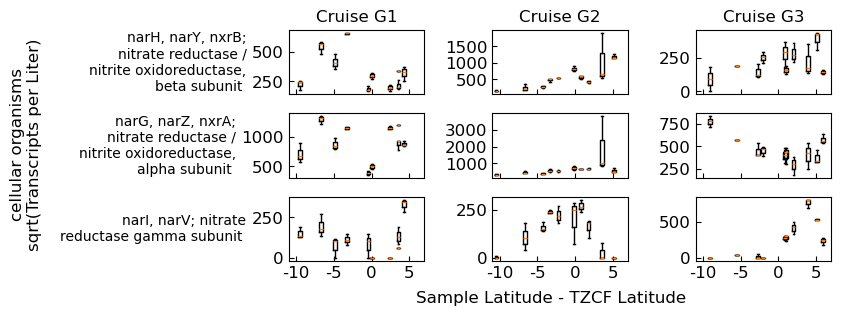

In [254]:
taxname = 'cellular organisms'
tax_target = ncbi.get_name_translator([taxname])[taxname][0]
ft = 12
fig, axes = plt.subplots(len(kos),3, figsize=(7,len(kos)))
lablen = 25
for i, (ko) in enumerate(kos):
    # PLot cruises
    for j, cruise in enumerate(['G1','G2','G3']):
    # for j, cruise in enumerate(['G1']):
        dict_lat_rep_estcount = defaultdict(
            lambda: defaultdict(float)
        )
        for lat, dict_rep_estcount in dict_ko_tax_cruise_lat_rep_estcount[ko][str(tax_target)][cruise].items():
            for rep, ec in dict_rep_estcount.items():
                dict_lat_rep_estcount[lat][rep] += ec

        # dict_lat_rep_estcount = d_cruise_lat_rep_estcount[cruise]
        ax = axes[i,j]
        lats_unq = list(dict_lat_rep_estcount.keys())
        vals = []
        for l in lats_unq:
            v = np.sqrt(list(dict_lat_rep_estcount[l].values()))
            vals.append(v)
        if vals:
            ax.boxplot(vals, positions=lats_unq)


        x = np.arange(-10,10,5)
        ax.set_xticks(x)
        xticklabels = x if i == len(kos) - 1 else []
        ax.set_xticklabels(xticklabels)
        ax.set_xlim(-11,7)
        # ax.set_title(cruise, size=ft)
        ax.tick_params(direction="in", labelsize=ft)
        # if cruise == 'G3':
        #     ax.set_ylim(0,2e8)
        if j == 0:
            # Get gene description
            name = dict_ko_name[ko]
            nm = re.search(r'(?<=^K\d{5}\s\s).+', name)[0]
            splt = '[EC:'
            if splt in nm:
                nm = nm.split(splt)[0]
            # Separate description on spaces
            lab = ''
            i_0 = 0
            i_1 = lablen
            while i_1 < len(nm):
                l = nm[i_0:i_1]
                if ' ' in l:
                    i_1 = l.rfind(' ')
                    lab += l[:i_1] + '\n'
                    i_0 = i_0 + i_1 + 1
                    i_1  = i_0 + lablen
                else:
                    i_1 += lablen

            l = nm[i_0:]
            if len(l) > lablen:
                if ' ' in l:
                    i_1 = l.rfind(' ')
                    lab += l[:i_1] + '\n'
                    i_0 = i_0 + i_1 + 1
                    l = nm[i_0:]
            lab += l
            ax.set_ylabel(lab, rotation=0, va='center',ha='right')
        if i == 0:
            ax.set_title(f'Cruise {cruise}')


fig.text(0.5, 0.01, f'Sample Latitude - TZCF Latitude', rotation=0, va='top',ha='center', fontsize=ft)
fig.text(-0.25, 0.5, f'{taxname}\nsqrt(Transcripts per Liter)', rotation=90, va='center',ha='center', fontsize=ft)

plt.subplots_adjust(wspace=0.5, hspace=0.3)

# dir_out = '/scratch/bgrodner/iron_ko_contigs/metat_search_results/spatial_variability_latitude_tzcf_glm'
# fmt_out = f'{dir_out}/plots/nitrogen_NS_size_{size}_trl_glm.{{ext}}'
# exts = ['png','pdf']
# do = os.path.split(fmt_out)[0]
# if not os.path.exists(do): os.makedirs(do)
# fns_out = [fmt_out.format(ext=ext) for ext in exts]
# for fn_out in fns_out:
#     plt.savefig(fn_out, dpi=500, bbox_inches='tight')


## Get differential iron gene expression for specific group of taxa

Define taxa of interest

In [157]:
target_taxnames = [
    'Alphaproteobacteria','Betaproteobacteria','Gammaproteobacteria',
    'Myxococcota','FCB group','PVC group',
    'Actinomycetota',
    'Bacillota','Cyanobacteriota',
    'Haptophyta','Streptophyta','Chlorophyta','Opisthokonta','Alveolata','Rhizaria',
    'Stramenopiles','Amoebozoa','Cryptophyceae','Discoba','Rhodophyta',
]
dict_taxname_tax = ncbi.get_name_translator(target_taxnames)
dict_tax_name = ncbi.get_taxid_translator(target_taxa)
target_taxa = [dict_taxname_tax[n][0] for n in target_taxnames]


Get list of subtaxa for each ptype

In [152]:
dict_targettax_sel_sz_ptype_taxa = defaultdict(
    lambda: defaultdict(
        lambda: defaultdict(
            lambda: defaultdict(list)
        )
    )
)
for sel, dict_sz_ptype_taxa in dict_sel_sz_ptype_taxa.items():
    for sz, dict_ptype_taxa in dict_sz_ptype_taxa.items():
        for ptype, taxa in dict_ptype_taxa.items():
            for tax in taxa:
                try:
                    lin = ncbi.get_lineage(tax)
                    for tt in target_taxa:
                        if tt in lin:
                            dict_targettax_sel_sz_ptype_taxa[tt][sel][sz][ptype].append(tax)
                except:
                    pass

/venv/ete4/ete4/ncbi_taxonomy/ncbiquery.py:216: UserWarning: taxid 1457154 was translated into 2954382
  warnings.warn('taxid %s was translated into %s' %
/venv/ete4/ete4/ncbi_taxonomy/ncbiquery.py:216: UserWarning: taxid 1453999 was translated into 2954383
  warnings.warn('taxid %s was translated into %s' %
/venv/ete4/ete4/ncbi_taxonomy/ncbiquery.py:216: UserWarning: taxid 1317118 was translated into 1379903
  warnings.warn('taxid %s was translated into %s' %
/venv/ete4/ete4/ncbi_taxonomy/ncbiquery.py:216: UserWarning: taxid 876044 was translated into 2518989
  warnings.warn('taxid %s was translated into %s' %
/venv/ete4/ete4/ncbi_taxonomy/ncbiquery.py:216: UserWarning: taxid 1267535 was translated into 639034
  warnings.warn('taxid %s was translated into %s' %
/venv/ete4/ete4/ncbi_taxonomy/ncbiquery.py:216: UserWarning: taxid 319236 was translated into 323273
  warnings.warn('taxid %s was translated into %s' %
/venv/ete4/ete4/ncbi_taxonomy/ncbiquery.py:216: UserWarning: taxid 1217710

Get total estcounts for taxa in each ptype

In [153]:
dict_targettax_sel_sz_ptype_sam_estcounts = defaultdict(
    lambda: defaultdict(
        lambda: defaultdict(
            lambda: defaultdict(
                lambda: defaultdict(float)
            )
        )
    )
)
for tt, d_sel_sz_ptype_taxa in dict_targettax_sel_sz_ptype_taxa.items():
    for sel, dict_sz_ptype_taxa in d_sel_sz_ptype_taxa.items():
        for sz, dict_ptype_taxa in dict_sz_ptype_taxa.items():
            for ptype, taxa in dict_ptype_taxa.items():
                for tax in taxa:
                    for sample, estcounts in dict_sel_sz_tax_sample_estcounts[sel][sz][tax].items():
                        dict_targettax_sel_sz_ptype_sam_estcounts[tt][sel][sz][ptype][sample] += estcounts


Get gene relative abundance within each group

In [154]:
dict_targettax_sel_sz_ptype_ko_sam_frac = defaultdict(
    lambda: defaultdict(
        lambda: defaultdict(
            lambda: defaultdict(
                lambda: defaultdict(dict)
            )
        )
    )
)

for tt, d_sel_sz_ptype_taxa in dict_targettax_sel_sz_ptype_taxa.items():
    for sel, dict_sz_ptype_taxa in d_sel_sz_ptype_taxa.items():
        for sz, dict_ptype_taxa in dict_sz_ptype_taxa.items():
            for ptype, taxa in dict_ptype_taxa.items():
                dict_sam_ptypecounts = dict_targettax_sel_sz_ptype_sam_estcounts[tt][sel][sz][ptype]
                for tax in taxa:
                    for sample, ptypecounts in dict_sam_ptypecounts.items():
                        for ko, dict_sam_kocounts in dict_iron_taxon_ko_sample_estcounts[tax].items():
                            dict_targettax_sel_sz_ptype_ko_sam_frac[tt][sel][sz][ptype][ko][sample] = (
                                dict_sam_kocounts[sample] / ptypecounts
                            )

Build prediction dataframe for each group

In [155]:
dict_targetax_sel_sz_ptype_preddf = defaultdict(
    lambda: defaultdict(
        lambda: defaultdict(dict)
    )
)
for tt, d_sel_sz_ptype_ko_sam_frac in dict_targettax_sel_sz_ptype_ko_sam_frac.items():
    for sel, dict_sz_ptype_ko_sam_frac in d_sel_sz_ptype_ko_sam_frac.items():
        for sz, dict_ptype_ko_sam_frac in dict_sz_ptype_ko_sam_frac.items():
            for ptype, dict_ko_sam_frac in dict_ptype_ko_sam_frac.items():
                df = pd.DataFrame(dict_ko_sam_frac)
                cruises = []
                lat_diffs = []
                for sam in df.index:
                    row_meta = dict_meta[sam]
                    lat, cruise = [row_meta[v] for v in ['latitude','cruise']]
                    lat = float(lat.strip('deg'))
                    _, tzcf = dict_cruise_trans_sal_chl[cruise]
                    lat_diff = lat - tzcf
                    cruises.append(cruise)
                    lat_diffs.append(lat_diff)
                df['cruise'] = cruises
                df['lat_diff'] = lat_diffs
                dict_targetax_sel_sz_ptype_preddf[tt][sel][sz][ptype] = df


Run on all sel sz ptype options:

In [158]:
# Fraction of samples that must be nonzero in each cruise for the taxon to be included
thresh_fgt0 = 0.25
# Number of permutations for p value on latitude effect
n_perm = 1000
# Define outliers as > q3 + IQR * coeff and < q1 - IQR * coeff
iqr_coefficient = 10 
# number of cores to use
n_jobs = 100
# Ouptut location
dir_glm = '/scratch/bgrodner/iron_ko_contigs/metat_search_results/spatial_variability_latitude_tzcf_glm'
fmt_out = dir_glm + '/model_results/iron_ko_latitude_tzcf_glm_results_{sel}_{sz}_taxon_profile_{ptype}.json'

# Variable to save things to:
dict_targetax_sel_sz_ptype_glmresults = defaultdict(
    lambda: defaultdict(
        lambda: defaultdict(dict)
    )
)
for tt, d_sel_sz_ptype_preddf in dict_targetax_sel_sz_ptype_preddf.items():
    ttname = dict_tax_name[tt]
    for sel, dict_sz_ptype_preddf in d_sel_sz_ptype_preddf.items():
        for sz, dict_ptype_preddf in dict_sz_ptype_preddf.items():
            for ptype, preddf in dict_ptype_preddf.items():

                # Get a list of taxa
                response_cols = [c for c in preddf.columns if c not in ['lat_diff','cruise','rep']]
                # fn_out = fmt_out.format(sel=sel, sz=sz, ptype=ptype[:-1])
                # if not os.path.exists(fn_out):

                # Subset based on minimum fraction of nonzero samples
                bool_tax = np.zeros(len(response_cols))
                # Each cruise must have the minimum number of nonzero samples for the KO to be included
                for cruise, df in preddf[response_cols + ['cruise']].groupby('cruise'):
                    frac_gt0 = (df[response_cols] > 0).sum(axis=0) / df.shape[0]
                    bool_tax += (frac_gt0 > thresh_fgt0).values.astype(int)
                bool_tax = bool_tax == 3
                response_cols_sub = np.array(response_cols)[bool_tax].tolist()
                if len(response_cols_sub) > 0:
                    print('***',tt, sel, sz, ptype,'***')
                    print(response_cols_sub)


                    # Fit the model
                    results = frm.fit_many_models(
                        data=preddf,
                        response_cols=response_cols_sub,
                        covariate_cols=['lat_diff','cruise'],
                        poly_cols=['lat_diff'], 
                        poly_degree=2,
                        iqr_coefficient=10,
                        perm_test_vars=['lat_diff'], 
                        n_perm=1000, 
                        stat='coef',
                        random_state=None,
                        n_jobs=100,
                    )
                    dict_targetax_sel_sz_ptype_glmresults[tt][sel][sz][ptype] = results

                    # Save the model 
                    dir_out = '/scratch/bgrodner/iron_ko_contigs/metat_search_results/spatial_variability_latitude_tzcf_glm'
                    fn_out = f'{dir_out}/model_results/{ttname}/{ttname}_{ptype}{sel}_{sz}_ptype_gene_expression_models.json'
                    do = os.path.split(fn_out)[0]
                    if not os.path.exists(do): os.makedirs(do)
                    with open(fn_out, 'w') as f:
                        json.dump(
                            results, 
                            f, 
                            sort_keys=True,
                            indent=4,
                            separators=(',', ': ')
                        )

*** 28211 NS 0.2um frac_high_north_trl_high_north_ ***
['K00366', 'K01086', 'K01673', 'K02016', 'K02703']
chack


[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Done   2 out of   5 | elapsed:   10.5s remaining:   15.8s
[Parallel(n_jobs=100)]: Done   3 out of   5 | elapsed:   10.6s remaining:    7.1s
[Parallel(n_jobs=100)]: Done   5 out of   5 | elapsed:   10.7s finished


*** 28211 NS 0.2um frac_high_south_trl_high_south_ ***
['K15721', 'K16090', 'K04641']
chack


[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Done   3 out of   3 | elapsed:    9.8s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 28211 NS 0.2um frac_high_south_trl_low_cf_ ***
['K15876']
chack


[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:    9.8s
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 28211 NS 0.2um frac_nonsig_trl_high_north_ ***
['K02638', 'K11959', 'K00366', 'K00855', 'K01086', 'K01602', 'K02703', 'K14578']
chack


[Parallel(n_jobs=100)]: Done   2 out of   8 | elapsed:    9.3s remaining:   27.9s
[Parallel(n_jobs=100)]: Done   3 out of   8 | elapsed:    9.4s remaining:   15.6s
[Parallel(n_jobs=100)]: Done   4 out of   8 | elapsed:    9.4s remaining:    9.4s
[Parallel(n_jobs=100)]: Done   5 out of   8 | elapsed:    9.5s remaining:    5.7s
[Parallel(n_jobs=100)]: Done   6 out of   8 | elapsed:    9.5s remaining:    3.2s
[Parallel(n_jobs=100)]: Done   8 out of   8 | elapsed:   10.1s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 28211 NS 0.2um frac_nonsig_trl_nonsig_ ***
['K03320']
chack


[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:    9.6s
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 28211 NS 3.0um frac_high_north_trl_high_north_ ***
['K02638']
chack


[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:    9.4s
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 28216 NS 0.2um frac_high_north_trl_high_north_ ***
['K00264', 'K00284', 'K01783', 'K03147', 'K03320', 'K16090', 'K00265', 'K00532', 'K03594', 'K22339', 'K02217']
chack


[Parallel(n_jobs=100)]: Done   2 out of  11 | elapsed:    9.4s remaining:   42.4s
[Parallel(n_jobs=100)]: Done   4 out of  11 | elapsed:    9.5s remaining:   16.6s
[Parallel(n_jobs=100)]: Done   6 out of  11 | elapsed:    9.6s remaining:    8.0s
[Parallel(n_jobs=100)]: Done   8 out of  11 | elapsed:    9.6s remaining:    3.6s
[Parallel(n_jobs=100)]: Done  11 out of  11 | elapsed:    9.9s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 28216 PA 3.0um frac_nonsig_trl_high_north_ ***
['K01726']
chack


[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:    9.5s
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 1236 NS 0.2um frac_high_north_trl_high_north_ ***
['K03320', 'K00170', 'K00174', 'K00175', 'K00179', 'K00518', 'K00855', 'K01623', 'K01624', 'K01783', 'K01803', 'K02217', 'K02598', 'K03147', 'K03594', 'K04564', 'K05337', 'K07685', 'K14692', 'K21834', 'K21990', 'K22336']
chack


[Parallel(n_jobs=100)]: Done   3 out of  22 | elapsed:    9.8s remaining:  1.0min
[Parallel(n_jobs=100)]: Done   6 out of  22 | elapsed:    9.8s remaining:   26.1s
[Parallel(n_jobs=100)]: Done   9 out of  22 | elapsed:    9.8s remaining:   14.2s
[Parallel(n_jobs=100)]: Done  12 out of  22 | elapsed:    9.9s remaining:    8.2s
[Parallel(n_jobs=100)]: Done  15 out of  22 | elapsed:    9.9s remaining:    4.6s
[Parallel(n_jobs=100)]: Done  18 out of  22 | elapsed:   10.0s remaining:    2.2s
[Parallel(n_jobs=100)]: Done  22 out of  22 | elapsed:   10.2s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 1236 NS 0.2um frac_high_south_trl_high_south_ ***
['K00264', 'K00284', 'K00367', 'K00615', 'K03832', 'K15721', 'K16087', 'K19611', 'K00927', 'K02011', 'K02012', 'K03320', 'K04641', 'K11959']
chack


[Parallel(n_jobs=100)]: Done   3 out of  14 | elapsed:    9.5s remaining:   34.9s
[Parallel(n_jobs=100)]: Done   5 out of  14 | elapsed:    9.6s remaining:   17.2s
[Parallel(n_jobs=100)]: Done   7 out of  14 | elapsed:    9.6s remaining:    9.6s
[Parallel(n_jobs=100)]: Done   9 out of  14 | elapsed:    9.7s remaining:    5.4s
[Parallel(n_jobs=100)]: Done  11 out of  14 | elapsed:    9.8s remaining:    2.7s
[Parallel(n_jobs=100)]: Done  14 out of  14 | elapsed:    9.8s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 1236 NS 0.2um frac_high_south_trl_nonsig_ ***
['K00216', 'K02638', 'K16090', 'K24147', 'K04641', 'K08906']
chack


[Parallel(n_jobs=100)]: Done   2 out of   6 | elapsed:    9.6s remaining:   19.1s
[Parallel(n_jobs=100)]: Done   3 out of   6 | elapsed:    9.6s remaining:    9.6s
[Parallel(n_jobs=100)]: Done   4 out of   6 | elapsed:    9.6s remaining:    4.8s
[Parallel(n_jobs=100)]: Done   6 out of   6 | elapsed:    9.7s finished


*** 1236 NS 0.2um frac_low_cf_trl_low_cf_ ***
['K02638']
chack


[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:    9.8s
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 1236 NS 0.2um frac_nonsig_trl_high_cf_ ***
['K00363', 'K01783']
chack


[Parallel(n_jobs=100)]: Done   2 out of   2 | elapsed:    9.6s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 1236 NS 0.2um frac_nonsig_trl_high_north_ ***
['K00174', 'K07230']
chack


[Parallel(n_jobs=100)]: Done   2 out of   2 | elapsed:    9.7s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 1236 NS 0.2um frac_nonsig_trl_nonsig_ ***
['K16302', 'K05337', 'K24530']
chack


[Parallel(n_jobs=100)]: Done   3 out of   3 | elapsed:    9.7s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 1236 NS 3.0um frac_high_south_trl_nonsig_ ***
['K22552', 'K00368', 'K02574']
chack


[Parallel(n_jobs=100)]: Done   3 out of   3 | elapsed:   10.1s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 1236 NS 3.0um frac_nonsig_trl_high_cf_ ***
['K22552', 'K14688', 'K16087', 'K16088', 'K16090', 'K00134', 'K00264', 'K00265', 'K00362', 'K00367', 'K00392', 'K00615', 'K00927', 'K01012', 'K01595', 'K01673', 'K01726', 'K01783', 'K02011', 'K02012', 'K02574', 'K03147', 'K03322', 'K03699', 'K03839', 'K03855', 'K07238', 'K07673', 'K07685', 'K11706', 'K11952', 'K15721', 'K16302', 'K19343', 'K19611', 'K19791', 'K21949', 'K21990', 'K22341', 'K25224']
chack


[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:    8.8s
[Parallel(n_jobs=100)]: Done   6 out of  40 | elapsed:    9.2s remaining:   52.2s
[Parallel(n_jobs=100)]: Done  11 out of  40 | elapsed:    9.3s remaining:   24.6s
[Parallel(n_jobs=100)]: Done  16 out of  40 | elapsed:    9.5s remaining:   14.3s
[Parallel(n_jobs=100)]: Done  21 out of  40 | elapsed:    9.7s remaining:    8.7s
[Parallel(n_jobs=100)]: Done  26 out of  40 | elapsed:    9.9s remaining:    5.3s
[Parallel(n_jobs=100)]: Done  31 out of  40 | elapsed:   10.2s remaining:    3.0s
[Parallel(n_jobs=100)]: Done  36 out of  40 | elapsed:   10.4s remaining:    1.2s
[Parallel(n_jobs=100)]: Done  40 out of  40 | elapsed:   10.7s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 1236 NS 3.0um frac_nonsig_trl_nonsig_ ***
['K07230']
chack


[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:    8.9s
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 1236 PA 0.2um frac_nonsig_trl_high_north_ ***
['K01674']
chack


[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:    8.7s
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 1236 PA 3.0um frac_high_north_trl_high_north_ ***
['K00615', 'K01674', 'K02575']
chack


[Parallel(n_jobs=100)]: Done   3 out of   3 | elapsed:    8.7s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 1236 PA 3.0um frac_nonsig_trl_high_north_ ***
['K01674']
chack


[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:    8.6s
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 1117 NS 0.2um frac_nonsig_trl_nonsig_ ***
['K09819']
chack


[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:    8.4s
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 1117 NS 3.0um frac_high_south_trl_high_south_ ***
['K02689', 'K02690', 'K01624']
chack


[Parallel(n_jobs=100)]: Done   3 out of   3 | elapsed:    8.7s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 1117 NS 3.0um frac_high_south_trl_low_cf_ ***
['K02689', 'K02690', 'K02705']
chack


[Parallel(n_jobs=100)]: Done   3 out of   3 | elapsed:    8.9s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 1117 PA 3.0um frac_nonsig_trl_high_north_ ***
['K00284']
chack


[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:    8.6s
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 1783270 NS 0.2um frac_high_north_trl_high_north_ ***
['K04641', 'K06503', 'K12346', 'K00186', 'K03839', 'K03840', 'K01623', 'K04090']
chack


[Parallel(n_jobs=100)]: Done   2 out of   8 | elapsed:    8.5s remaining:   25.6s
[Parallel(n_jobs=100)]: Done   3 out of   8 | elapsed:    8.5s remaining:   14.2s
[Parallel(n_jobs=100)]: Done   4 out of   8 | elapsed:    8.5s remaining:    8.5s
[Parallel(n_jobs=100)]: Done   5 out of   8 | elapsed:    8.6s remaining:    5.1s
[Parallel(n_jobs=100)]: Done   6 out of   8 | elapsed:    8.6s remaining:    2.9s
[Parallel(n_jobs=100)]: Done   8 out of   8 | elapsed:    8.7s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 1783270 NS 0.2um frac_high_south_trl_high_south_ ***
['K00175', 'K00518', 'K00615', 'K00927', 'K01623', 'K02446', 'K02638', 'K03832', 'K04018', 'K04090', 'K04564', 'K04641', 'K07243', 'K15721', 'K16087', 'K16088', 'K16090', 'K19611']
chack


[Parallel(n_jobs=100)]: Done   3 out of  18 | elapsed:    8.6s remaining:   43.0s
[Parallel(n_jobs=100)]: Done   5 out of  18 | elapsed:    8.6s remaining:   22.4s
[Parallel(n_jobs=100)]: Done   7 out of  18 | elapsed:    8.6s remaining:   13.5s
[Parallel(n_jobs=100)]: Done   9 out of  18 | elapsed:    8.6s remaining:    8.6s
[Parallel(n_jobs=100)]: Done  11 out of  18 | elapsed:    8.7s remaining:    5.5s
[Parallel(n_jobs=100)]: Done  13 out of  18 | elapsed:    8.7s remaining:    3.4s
[Parallel(n_jobs=100)]: Done  15 out of  18 | elapsed:    8.8s remaining:    1.8s
[Parallel(n_jobs=100)]: Done  18 out of  18 | elapsed:    9.0s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 1783270 NS 0.2um frac_high_south_trl_low_cf_ ***
['K21834']
chack


[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:    8.6s
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 1783270 NS 0.2um frac_high_south_trl_nonsig_ ***
['K19611']
chack


[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:    9.0s
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 1783270 NS 0.2um frac_low_cf_trl_high_north_ ***
['K00174', 'K00177', 'K00187', 'K15721', 'K16088']
chack


[Parallel(n_jobs=100)]: Done   2 out of   5 | elapsed:    8.6s remaining:   12.9s
[Parallel(n_jobs=100)]: Done   3 out of   5 | elapsed:    8.6s remaining:    5.7s
[Parallel(n_jobs=100)]: Done   5 out of   5 | elapsed:    8.7s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 1783270 NS 0.2um frac_low_cf_trl_low_cf_ ***
['K19611']
chack


[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:    8.6s
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 1783270 NS 0.2um frac_nonsig_trl_high_north_ ***
['K01624']
chack


[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:    8.5s
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 1783270 NS 3.0um frac_high_south_trl_nonsig_ ***
['K01595', 'K01673']
chack


[Parallel(n_jobs=100)]: Done   2 out of   2 | elapsed:    8.6s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 1783270 NS 3.0um frac_nonsig_trl_high_north_ ***
['K04641']
chack


[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:    8.8s
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 201174 NS 0.2um frac_nonsig_trl_high_north_ ***
['K04641', 'K04642']
chack


[Parallel(n_jobs=100)]: Done   2 out of   2 | elapsed:    8.7s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 201174 NS 0.2um frac_nonsig_trl_nonsig_ ***
['K11959']
chack


[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:    8.6s
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 1239 NS 0.2um frac_nonsig_trl_high_north_ ***
['K02012']
chack


[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:    8.5s
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 1239 NS 0.2um frac_nonsig_trl_nonsig_ ***
['K04641']
chack


[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:    8.6s
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 1239 NS 3.0um frac_nonsig_trl_nonsig_ ***
['K04641']
chack


[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:    8.9s
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 2830 NS 0.2um frac_high_north_trl_high_north_ ***
['K02694', 'K02697', 'K02699', 'K02720', 'K25287']
chack


[Parallel(n_jobs=100)]: Done   2 out of   5 | elapsed:    8.7s remaining:   13.1s
[Parallel(n_jobs=100)]: Done   3 out of   5 | elapsed:    8.8s remaining:    5.8s
[Parallel(n_jobs=100)]: Done   5 out of   5 | elapsed:    8.8s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 2830 NS 0.2um frac_high_south_trl_nonsig_ ***
['K02690', 'K01623', 'K02689']
chack


[Parallel(n_jobs=100)]: Done   3 out of   3 | elapsed:    9.0s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 2830 NS 0.2um frac_low_cf_trl_high_north_ ***
['K02575', 'K03320', 'K01601', 'K03839', 'K02690', 'K02692', 'K02694', 'K02704', 'K02720']
chack


[Parallel(n_jobs=100)]: Done   2 out of   9 | elapsed:    8.6s remaining:   30.0s
[Parallel(n_jobs=100)]: Done   3 out of   9 | elapsed:    8.6s remaining:   17.3s
[Parallel(n_jobs=100)]: Done   4 out of   9 | elapsed:    8.6s remaining:   10.8s
[Parallel(n_jobs=100)]: Done   5 out of   9 | elapsed:    8.7s remaining:    6.9s
[Parallel(n_jobs=100)]: Done   6 out of   9 | elapsed:    8.7s remaining:    4.4s
[Parallel(n_jobs=100)]: Done   7 out of   9 | elapsed:    8.9s remaining:    2.5s
[Parallel(n_jobs=100)]: Done   9 out of   9 | elapsed:    9.0s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 2830 NS 0.2um frac_nonsig_trl_high_north_ ***
['K01601', 'K02710', 'K02723', 'K03594']
chack


[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:    8.5s
[Parallel(n_jobs=100)]: Done   2 out of   4 | elapsed:    8.6s remaining:    8.6s
[Parallel(n_jobs=100)]: Done   4 out of   4 | elapsed:    9.1s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 2830 NS 0.2um frac_nonsig_trl_nonsig_ ***
['K03320', 'K01086', 'K02706', 'K01602', 'K02697', 'K02699', 'K02724']
chack


[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:    8.6s
[Parallel(n_jobs=100)]: Done   2 out of   7 | elapsed:    8.6s remaining:   21.5s
[Parallel(n_jobs=100)]: Done   3 out of   7 | elapsed:    8.7s remaining:   11.6s
[Parallel(n_jobs=100)]: Done   4 out of   7 | elapsed:    8.7s remaining:    6.5s
[Parallel(n_jobs=100)]: Done   5 out of   7 | elapsed:    8.7s remaining:    3.5s
[Parallel(n_jobs=100)]: Done   7 out of   7 | elapsed:    9.2s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 2830 NS 3.0um frac_high_north_trl_high_north_ ***
['K01803', 'K02690', 'K02694', 'K02720', 'K25287', 'K02723']
chack


[Parallel(n_jobs=100)]: Done   2 out of   6 | elapsed:    8.6s remaining:   17.2s
[Parallel(n_jobs=100)]: Done   3 out of   6 | elapsed:    8.7s remaining:    8.7s
[Parallel(n_jobs=100)]: Done   4 out of   6 | elapsed:    8.7s remaining:    4.4s
[Parallel(n_jobs=100)]: Done   6 out of   6 | elapsed:    8.7s finished


*** 2830 NS 3.0um frac_nonsig_trl_high_north_ ***
['K01673', 'K02689', 'K02692', 'K02697', 'K03594']
chack


[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Done   2 out of   5 | elapsed:    8.7s remaining:   13.0s
[Parallel(n_jobs=100)]: Done   3 out of   5 | elapsed:    8.8s remaining:    5.9s
[Parallel(n_jobs=100)]: Done   5 out of   5 | elapsed:    8.8s finished


*** 2830 PA 0.2um frac_high_north_trl_high_north_ ***
['K00134', 'K01674']
chack


[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Done   2 out of   2 | elapsed:    8.6s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 2830 PA 0.2um frac_high_south_trl_high_north_ ***
['K00134', 'K00615', 'K00855', 'K02575', 'K02641']
chack


[Parallel(n_jobs=100)]: Done   2 out of   5 | elapsed:    8.5s remaining:   12.8s
[Parallel(n_jobs=100)]: Done   3 out of   5 | elapsed:    8.6s remaining:    5.7s
[Parallel(n_jobs=100)]: Done   5 out of   5 | elapsed:    8.6s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 2830 PA 0.2um frac_high_south_trl_low_cf_ ***
['K02719', 'K03320', 'K00284']
chack


[Parallel(n_jobs=100)]: Done   3 out of   3 | elapsed:    8.8s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 2830 PA 0.2um frac_high_south_trl_nonsig_ ***
['K02575']
chack


[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:    8.7s
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 2830 PA 0.2um frac_low_cf_trl_high_north_ ***
['K16267', 'K03841']
chack


[Parallel(n_jobs=100)]: Done   2 out of   2 | elapsed:    8.7s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 2830 PA 0.2um frac_nonsig_trl_high_north_ ***
['K03839', 'K25287']
chack


[Parallel(n_jobs=100)]: Done   2 out of   2 | elapsed:    8.7s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 2830 PA 3.0um frac_high_north_trl_high_north_ ***
['K02575', 'K07214']
chack


[Parallel(n_jobs=100)]: Done   2 out of   2 | elapsed:    8.8s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 2830 PA 3.0um frac_high_south_trl_high_north_ ***
['K02719', 'K03320', 'K19791', 'K25287']
chack


[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:    8.5s
[Parallel(n_jobs=100)]: Done   2 out of   4 | elapsed:    8.7s remaining:    8.7s
[Parallel(n_jobs=100)]: Done   4 out of   4 | elapsed:    8.9s finished


*** 2830 PA 3.0um frac_low_cf_trl_high_north_ ***
['K00134', 'K00518', 'K00615', 'K00855', 'K00927', 'K01601', 'K01726', 'K01783', 'K02641', 'K03320', 'K04755', 'K10534']
chack


[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:    8.5s
[Parallel(n_jobs=100)]: Done   3 out of  12 | elapsed:    8.6s remaining:   25.9s
[Parallel(n_jobs=100)]: Done   5 out of  12 | elapsed:    8.7s remaining:   12.2s
[Parallel(n_jobs=100)]: Done   7 out of  12 | elapsed:    8.7s remaining:    6.2s
[Parallel(n_jobs=100)]: Done   9 out of  12 | elapsed:    8.8s remaining:    2.9s
[Parallel(n_jobs=100)]: Done  12 out of  12 | elapsed:    9.0s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 2830 PA 3.0um frac_nonsig_trl_high_north_ ***
['K07214', 'K25287']
chack


[Parallel(n_jobs=100)]: Done   2 out of   2 | elapsed:    8.9s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 33634 NS 0.2um frac_high_north_trl_high_north_ ***
['K02699']
chack


[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:    8.7s
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 33634 NS 0.2um frac_high_south_trl_high_south_ ***
['K02699', 'K13857']
chack


[Parallel(n_jobs=100)]: Done   2 out of   2 | elapsed:    8.7s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 33634 NS 0.2um frac_high_south_trl_nonsig_ ***
['K01595', 'K00367', 'K00372', 'K02567', 'K02714', 'K02724', 'K02362', 'K03542']
chack


[Parallel(n_jobs=100)]: Done   2 out of   8 | elapsed:    8.6s remaining:   25.8s
[Parallel(n_jobs=100)]: Done   3 out of   8 | elapsed:    8.8s remaining:   14.6s
[Parallel(n_jobs=100)]: Done   4 out of   8 | elapsed:    8.8s remaining:    8.8s
[Parallel(n_jobs=100)]: Done   5 out of   8 | elapsed:    9.0s remaining:    5.4s
[Parallel(n_jobs=100)]: Done   6 out of   8 | elapsed:    9.2s remaining:    3.1s
[Parallel(n_jobs=100)]: Done   8 out of   8 | elapsed:    9.7s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 33634 NS 0.2um frac_nonsig_trl_high_north_ ***
['K00927', 'K02692', 'K02704']
chack


[Parallel(n_jobs=100)]: Done   3 out of   3 | elapsed:    8.8s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 33634 NS 0.2um frac_nonsig_trl_nonsig_ ***
['K02697', 'K17892']
chack


[Parallel(n_jobs=100)]: Done   2 out of   2 | elapsed:    9.1s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 33634 NS 3.0um frac_high_north_trl_high_north_ ***
['K02720']
chack


[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:    8.7s
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 33634 NS 3.0um frac_high_south_trl_high_south_ ***
['K02717', 'K02699']
chack


[Parallel(n_jobs=100)]: Done   2 out of   2 | elapsed:    8.9s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 33634 NS 3.0um frac_nonsig_trl_high_north_ ***
['K02699', 'K02692', 'K08902']
chack


[Parallel(n_jobs=100)]: Done   3 out of   3 | elapsed:    8.7s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 33634 PA 0.2um frac_high_north_trl_high_north_ ***
['K12240']
chack


[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:    8.6s
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 33634 PA 0.2um frac_high_south_trl_high_north_ ***
['K00855', 'K00615']
chack


[Parallel(n_jobs=100)]: Done   2 out of   2 | elapsed:    8.8s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 33634 PA 0.2um frac_high_south_trl_high_south_ ***
['K00134', 'K02639']
chack


[Parallel(n_jobs=100)]: Done   2 out of   2 | elapsed:    9.0s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 33634 PA 0.2um frac_high_south_trl_nonsig_ ***
['K16267', 'K24034', 'K02362', 'K00522']
chack


[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:    8.6s
[Parallel(n_jobs=100)]: Done   2 out of   4 | elapsed:    8.6s remaining:    8.6s
[Parallel(n_jobs=100)]: Done   4 out of   4 | elapsed:    8.8s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 33634 PA 0.2um frac_nonsig_trl_nonsig_ ***
['K00392', 'K00855', 'K02641', 'K02717', 'K03542', 'K08901', 'K02639', 'K21480']
chack


[Parallel(n_jobs=100)]: Done   2 out of   8 | elapsed:    8.7s remaining:   26.1s
[Parallel(n_jobs=100)]: Done   3 out of   8 | elapsed:    8.8s remaining:   14.6s
[Parallel(n_jobs=100)]: Done   4 out of   8 | elapsed:    8.8s remaining:    8.8s
[Parallel(n_jobs=100)]: Done   5 out of   8 | elapsed:    8.8s remaining:    5.3s
[Parallel(n_jobs=100)]: Done   6 out of   8 | elapsed:    8.9s remaining:    3.0s
[Parallel(n_jobs=100)]: Done   8 out of   8 | elapsed:    9.2s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 33634 PA 3.0um frac_high_south_trl_high_north_ ***
['K00855', 'K00927']
chack


[Parallel(n_jobs=100)]: Done   2 out of   2 | elapsed:    8.6s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 33634 PA 3.0um frac_high_south_trl_high_south_ ***
['K02639', 'K03699']
chack


[Parallel(n_jobs=100)]: Done   2 out of   2 | elapsed:    8.7s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 33634 PA 3.0um frac_low_cf_trl_high_north_ ***
['K19791', 'K02364']
chack


[Parallel(n_jobs=100)]: Done   2 out of   2 | elapsed:    8.7s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 33630 NS 0.2um frac_high_north_trl_high_north_ ***
['K00176', 'K00360', 'K00362', 'K00367', 'K08225', 'K22339']
chack


[Parallel(n_jobs=100)]: Done   2 out of   6 | elapsed:    8.7s remaining:   17.3s
[Parallel(n_jobs=100)]: Done   3 out of   6 | elapsed:    8.7s remaining:    8.7s
[Parallel(n_jobs=100)]: Done   4 out of   6 | elapsed:    8.8s remaining:    4.4s
[Parallel(n_jobs=100)]: Done   6 out of   6 | elapsed:    9.1s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 33630 NS 0.2um frac_nonsig_trl_high_north_ ***
['K01623']
chack


[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:    8.5s
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 33630 NS 0.2um frac_nonsig_trl_nonsig_ ***
['K11607', 'K11706', 'K16087', 'K16088', 'K19611', 'K23976', 'K03832', 'K09681', 'K15721', 'K16090']
chack


[Parallel(n_jobs=100)]: Done   3 out of  10 | elapsed:    8.5s remaining:   19.9s
[Parallel(n_jobs=100)]: Done   5 out of  10 | elapsed:    8.6s remaining:    8.6s
[Parallel(n_jobs=100)]: Done   7 out of  10 | elapsed:    8.7s remaining:    3.7s
[Parallel(n_jobs=100)]: Done  10 out of  10 | elapsed:    9.0s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 33630 NS 3.0um frac_high_north_trl_high_north_ ***
['K02013', 'K02010', 'K23188']
chack


[Parallel(n_jobs=100)]: Done   3 out of   3 | elapsed:    8.7s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 33630 NS 3.0um frac_high_south_trl_nonsig_ ***
['K01672', 'K01674', 'K18245']
chack


[Parallel(n_jobs=100)]: Done   3 out of   3 | elapsed:    8.6s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 33630 NS 3.0um frac_nonsig_trl_high_north_ ***
['K00171', 'K00522', 'K01623', 'K02706', 'K02719', 'K14581', 'K00367', 'K02217', 'K02707', 'K02724', 'K13625']
chack


[Parallel(n_jobs=100)]: Done   2 out of  11 | elapsed:    8.6s remaining:   38.6s
[Parallel(n_jobs=100)]: Done   4 out of  11 | elapsed:    8.7s remaining:   15.2s
[Parallel(n_jobs=100)]: Done   6 out of  11 | elapsed:    8.7s remaining:    7.3s
[Parallel(n_jobs=100)]: Done   8 out of  11 | elapsed:    8.8s remaining:    3.3s
[Parallel(n_jobs=100)]: Done  11 out of  11 | elapsed:    9.0s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 33630 NS 3.0um frac_nonsig_trl_nonsig_ ***
['K08906', 'K10850', 'K13858', 'K13859', 'K21398', 'K02706', 'K12346', 'K12347', 'K02705', 'K02704', 'K00368', 'K02598', 'K21990', 'K19611', 'K16087']
chack


[Parallel(n_jobs=100)]: Done   2 out of  15 | elapsed:    8.5s remaining:   55.6s
[Parallel(n_jobs=100)]: Done   4 out of  15 | elapsed:    8.7s remaining:   23.9s
[Parallel(n_jobs=100)]: Done   6 out of  15 | elapsed:    8.7s remaining:   13.1s
[Parallel(n_jobs=100)]: Done   8 out of  15 | elapsed:    8.8s remaining:    7.7s
[Parallel(n_jobs=100)]: Done  10 out of  15 | elapsed:    9.4s remaining:    4.7s
[Parallel(n_jobs=100)]: Done  12 out of  15 | elapsed:    9.4s remaining:    2.3s
[Parallel(n_jobs=100)]: Done  15 out of  15 | elapsed:    9.5s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 33630 PA 0.2um frac_high_cf_trl_high_north_ ***
['K00927']
chack


[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:    8.9s
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 33630 PA 0.2um frac_high_north_trl_high_north_ ***
['K01674', 'K14713', 'K22071']
chack


[Parallel(n_jobs=100)]: Done   3 out of   3 | elapsed:    8.7s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 33630 PA 0.2um frac_high_south_trl_high_north_ ***
['K00134', 'K00518', 'K01672', 'K01674', 'K03320', 'K03322', 'K03839', 'K07238', 'K10534', 'K14689', 'K15113', 'K19791', 'K21563']
chack


[Parallel(n_jobs=100)]: Done   2 out of  13 | elapsed:    8.7s remaining:   47.8s
[Parallel(n_jobs=100)]: Done   4 out of  13 | elapsed:    8.8s remaining:   19.8s
[Parallel(n_jobs=100)]: Done   6 out of  13 | elapsed:    8.8s remaining:   10.3s
[Parallel(n_jobs=100)]: Done   8 out of  13 | elapsed:    8.9s remaining:    5.6s
[Parallel(n_jobs=100)]: Done  10 out of  13 | elapsed:    9.0s remaining:    2.7s
[Parallel(n_jobs=100)]: Done  13 out of  13 | elapsed:    9.3s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 33630 PA 0.2um frac_nonsig_trl_high_north_ ***
['K08906', 'K25287']
chack


[Parallel(n_jobs=100)]: Done   2 out of   2 | elapsed:    8.9s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 33630 PA 0.2um frac_nonsig_trl_nonsig_ ***
['K04641']
chack


[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:    8.7s
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 33630 PA 3.0um frac_high_cf_trl_high_north_ ***
['K00134', 'K00264', 'K00284', 'K00518', 'K00592', 'K00855', 'K01674', 'K02575', 'K02641', 'K02699', 'K02704', 'K02709', 'K03320', 'K03322', 'K03737', 'K03839', 'K03841', 'K04565', 'K04641', 'K05710', 'K07238', 'K10534', 'K14689', 'K14709', 'K15113', 'K21563', 'K22071', 'K24034', 'K00362', 'K17877']
chack


[Parallel(n_jobs=100)]: Done   3 out of  30 | elapsed:    8.7s remaining:  1.3min
[Parallel(n_jobs=100)]: Done   7 out of  30 | elapsed:    8.9s remaining:   29.4s
[Parallel(n_jobs=100)]: Done  11 out of  30 | elapsed:    9.3s remaining:   16.1s
[Parallel(n_jobs=100)]: Done  15 out of  30 | elapsed:    9.5s remaining:    9.5s
[Parallel(n_jobs=100)]: Done  19 out of  30 | elapsed:    9.7s remaining:    5.6s
[Parallel(n_jobs=100)]: Done  23 out of  30 | elapsed:    9.9s remaining:    3.0s
[Parallel(n_jobs=100)]: Done  27 out of  30 | elapsed:   10.3s remaining:    1.1s
[Parallel(n_jobs=100)]: Done  30 out of  30 | elapsed:   11.0s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 33630 PA 3.0um frac_high_north_trl_high_north_ ***
['K16302']
chack


[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:    8.6s
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 33630 PA 3.0um frac_high_south_trl_high_north_ ***
['K05710', 'K14692', 'K25287']
chack


[Parallel(n_jobs=100)]: Done   3 out of   3 | elapsed:    8.7s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 33630 PA 3.0um frac_high_south_trl_nonsig_ ***
['K00518', 'K01674', 'K02364', 'K02575', 'K03320', 'K03839', 'K04641', 'K02705', 'K02691']
chack


[Parallel(n_jobs=100)]: Done   2 out of   9 | elapsed:    8.6s remaining:   30.2s
[Parallel(n_jobs=100)]: Done   3 out of   9 | elapsed:    8.6s remaining:   17.3s
[Parallel(n_jobs=100)]: Done   4 out of   9 | elapsed:    8.8s remaining:   10.9s
[Parallel(n_jobs=100)]: Done   5 out of   9 | elapsed:    8.8s remaining:    7.0s
[Parallel(n_jobs=100)]: Done   6 out of   9 | elapsed:    8.9s remaining:    4.4s
[Parallel(n_jobs=100)]: Done   7 out of   9 | elapsed:    8.9s remaining:    2.6s
[Parallel(n_jobs=100)]: Done   9 out of   9 | elapsed:    9.0s finished


*** 33630 PA 3.0um frac_nonsig_trl_high_north_ ***
['K05710', 'K02217', 'K02711', 'K02719', 'K02724', 'K14696', 'K22736']
chack


[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:    8.6s
[Parallel(n_jobs=100)]: Done   2 out of   7 | elapsed:    8.6s remaining:   21.6s
[Parallel(n_jobs=100)]: Done   3 out of   7 | elapsed:    8.7s remaining:   11.6s
[Parallel(n_jobs=100)]: Done   4 out of   7 | elapsed:    8.7s remaining:    6.5s
[Parallel(n_jobs=100)]: Done   5 out of   7 | elapsed:    8.8s remaining:    3.5s
[Parallel(n_jobs=100)]: Done   7 out of   7 | elapsed:    9.1s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 33630 PA 3.0um frac_nonsig_trl_nonsig_ ***
['K00264', 'K07238', 'K13861', 'K14685', 'K21567', 'K02638']
chack


[Parallel(n_jobs=100)]: Done   2 out of   6 | elapsed:    8.6s remaining:   17.2s
[Parallel(n_jobs=100)]: Done   3 out of   6 | elapsed:    8.6s remaining:    8.6s
[Parallel(n_jobs=100)]: Done   4 out of   6 | elapsed:    8.8s remaining:    4.4s
[Parallel(n_jobs=100)]: Done   6 out of   6 | elapsed:    9.0s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 3041 NS 0.2um frac_high_north_trl_high_north_ ***
['K16087', 'K17892', 'K14332', 'K19611', 'K02708', 'K03832', 'K16090']
chack


[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:    8.6s
[Parallel(n_jobs=100)]: Done   2 out of   7 | elapsed:    8.6s remaining:   21.6s
[Parallel(n_jobs=100)]: Done   3 out of   7 | elapsed:    8.7s remaining:   11.6s
[Parallel(n_jobs=100)]: Done   4 out of   7 | elapsed:    8.7s remaining:    6.5s
[Parallel(n_jobs=100)]: Done   5 out of   7 | elapsed:    8.7s remaining:    3.5s
[Parallel(n_jobs=100)]: Done   7 out of   7 | elapsed:    8.9s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 3041 NS 0.2um frac_nonsig_trl_high_north_ ***
['K01601', 'K02704', 'K02707', 'K02711']
chack


[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:    8.7s
[Parallel(n_jobs=100)]: Done   2 out of   4 | elapsed:    8.8s remaining:    8.8s
[Parallel(n_jobs=100)]: Done   4 out of   4 | elapsed:    9.2s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 3041 NS 3.0um frac_high_north_trl_high_north_ ***
['K02689', 'K02709']
chack


[Parallel(n_jobs=100)]: Done   2 out of   2 | elapsed:    9.1s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 3041 NS 3.0um frac_nonsig_trl_high_north_ ***
['K01601', 'K02704', 'K02711']
chack


[Parallel(n_jobs=100)]: Done   3 out of   3 | elapsed:    8.9s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 3041 NS 3.0um frac_nonsig_trl_nonsig_ ***
['K02707', 'K02708']
chack


[Parallel(n_jobs=100)]: Done   2 out of   2 | elapsed:    8.8s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 3041 PA 0.2um frac_high_north_trl_high_north_ ***
['K00134', 'K00392', 'K00522', 'K03320', 'K03839', 'K14332', 'K00284', 'K04755', 'K03699', 'K25287']
chack


[Parallel(n_jobs=100)]: Done   3 out of  10 | elapsed:    8.9s remaining:   20.7s
[Parallel(n_jobs=100)]: Done   5 out of  10 | elapsed:    8.9s remaining:    8.9s
[Parallel(n_jobs=100)]: Done   7 out of  10 | elapsed:    9.0s remaining:    3.8s
[Parallel(n_jobs=100)]: Done  10 out of  10 | elapsed:    9.2s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 3041 PA 3.0um frac_high_south_trl_high_north_ ***
['K02694', 'K02716', 'K02717', 'K03541', 'K08901', 'K05710']
chack


[Parallel(n_jobs=100)]: Done   2 out of   6 | elapsed:    8.8s remaining:   17.6s
[Parallel(n_jobs=100)]: Done   3 out of   6 | elapsed:    8.9s remaining:    8.9s
[Parallel(n_jobs=100)]: Done   4 out of   6 | elapsed:    9.1s remaining:    4.6s
[Parallel(n_jobs=100)]: Done   6 out of   6 | elapsed:    9.4s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 3041 PA 3.0um frac_high_south_trl_nonsig_ ***
['K02722', 'K08901']
chack


[Parallel(n_jobs=100)]: Done   2 out of   2 | elapsed:    9.0s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 3041 PA 3.0um frac_nonsig_trl_high_north_ ***
['K25287']
chack


[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:    8.8s
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 35493 NS 0.2um frac_nonsig_trl_high_north_ ***
['K03320']
chack


[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:    8.7s
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 35493 NS 3.0um frac_high_north_trl_high_north_ ***
['K03320']
chack


[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:    8.7s
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 35493 PA 0.2um frac_nonsig_trl_high_north_ ***
['K02641']
chack


[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:    8.7s
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 35493 PA 3.0um frac_high_north_trl_high_north_ ***
['K03320', 'K02641']
chack


[Parallel(n_jobs=100)]: Done   2 out of   2 | elapsed:    9.0s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 33154 NS 0.2um frac_high_north_trl_high_north_ ***
['K04641']
chack


[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:    8.9s
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 33154 NS 0.2um frac_nonsig_trl_high_cf_ ***
['K00134', 'K00264']
chack


[Parallel(n_jobs=100)]: Done   2 out of   2 | elapsed:    9.4s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 33154 NS 0.2um frac_nonsig_trl_high_north_ ***
['K04641', 'K02012', 'K15577']
chack


[Parallel(n_jobs=100)]: Done   3 out of   3 | elapsed:    8.8s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 33154 NS 0.2um frac_nonsig_trl_nonsig_ ***
['K02446', 'K02720', 'K03542', 'K11532', 'K17892']
chack


[Parallel(n_jobs=100)]: Done   2 out of   5 | elapsed:    8.6s remaining:   12.9s
[Parallel(n_jobs=100)]: Done   3 out of   5 | elapsed:    8.9s remaining:    5.9s
[Parallel(n_jobs=100)]: Done   5 out of   5 | elapsed:    8.9s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 33154 NS 3.0um frac_high_north_trl_high_north_ ***
['K03855', 'K02446']
chack


[Parallel(n_jobs=100)]: Done   2 out of   2 | elapsed:    8.6s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 33154 NS 3.0um frac_nonsig_trl_high_north_ ***
['K02255', 'K04564']
chack


[Parallel(n_jobs=100)]: Done   2 out of   2 | elapsed:    8.9s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 33154 NS 3.0um frac_nonsig_trl_low_cf_ ***
['K04564']
chack


[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:    8.7s
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 33154 PA 0.2um frac_high_north_trl_high_north_ ***
['K00522', 'K04641']
chack


[Parallel(n_jobs=100)]: Done   2 out of   2 | elapsed:    8.8s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 33154 PA 0.2um frac_high_south_trl_high_north_ ***
['K11959']
chack


[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:    9.0s
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 33154 PA 3.0um frac_high_north_trl_high_north_ ***
['K00615']
chack


[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:    8.6s
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 3027 NS 0.2um frac_nonsig_trl_high_north_ ***
['K02567']
chack


[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:    9.1s
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 3027 NS 3.0um frac_high_north_trl_high_north_ ***
['K01602', 'K16627']
chack


[Parallel(n_jobs=100)]: Done   2 out of   2 | elapsed:    8.7s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 3027 NS 3.0um frac_nonsig_trl_high_north_ ***
['K01623', 'K02567']
chack


[Parallel(n_jobs=100)]: Done   2 out of   2 | elapsed:    9.3s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 3027 PA 0.2um frac_nonsig_trl_high_north_ ***
['K03542']
chack


[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:    8.6s
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 1783257 NS 0.2um frac_high_north_trl_high_north_ ***
['K16088', 'K00284']
chack


[Parallel(n_jobs=100)]: Done   2 out of   2 | elapsed:    8.9s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 1783257 NS 0.2um frac_high_south_trl_nonsig_ ***
['K00134', 'K00264', 'K00265', 'K00284', 'K00366', 'K00392', 'K00927', 'K01803', 'K02552', 'K03320', 'K04564', 'K11959', 'K16087', 'K16088', 'K16090', 'K21567']
chack


[Parallel(n_jobs=100)]: Done   3 out of  16 | elapsed:    8.7s remaining:   37.7s
[Parallel(n_jobs=100)]: Done   5 out of  16 | elapsed:    8.7s remaining:   19.2s
[Parallel(n_jobs=100)]: Done   7 out of  16 | elapsed:    8.8s remaining:   11.3s
[Parallel(n_jobs=100)]: Done   9 out of  16 | elapsed:    8.8s remaining:    6.9s
[Parallel(n_jobs=100)]: Done  11 out of  16 | elapsed:    8.9s remaining:    4.1s
[Parallel(n_jobs=100)]: Done  13 out of  16 | elapsed:    9.0s remaining:    2.1s
[Parallel(n_jobs=100)]: Done  16 out of  16 | elapsed:    9.2s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 1783257 NS 0.2um frac_nonsig_trl_high_north_ ***
['K00927', 'K25224']
chack


[Parallel(n_jobs=100)]: Done   2 out of   2 | elapsed:    9.0s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 1783257 NS 0.2um frac_nonsig_trl_nonsig_ ***
['K00392', 'K01624', 'K21949', 'K05524']
chack


[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:    8.5s
[Parallel(n_jobs=100)]: Done   2 out of   4 | elapsed:    8.6s remaining:    8.6s
[Parallel(n_jobs=100)]: Done   4 out of   4 | elapsed:    9.6s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 1783257 NS 3.0um frac_high_south_trl_nonsig_ ***
['K00264', 'K00265', 'K00284', 'K00927', 'K03320', 'K04564']
chack


[Parallel(n_jobs=100)]: Done   2 out of   6 | elapsed:    8.7s remaining:   17.4s
[Parallel(n_jobs=100)]: Done   3 out of   6 | elapsed:    8.7s remaining:    8.7s
[Parallel(n_jobs=100)]: Done   4 out of   6 | elapsed:    8.8s remaining:    4.4s
[Parallel(n_jobs=100)]: Done   6 out of   6 | elapsed:    8.9s finished


*** 2818505 NS 0.2um frac_high_south_trl_high_south_ ***
['K16087']
chack


[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:    8.8s
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 2818505 NS 0.2um frac_high_south_trl_nonsig_ ***
['K16087', 'K16090']
chack


[Parallel(n_jobs=100)]: Done   2 out of   2 | elapsed:    8.9s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 2763 NS 0.2um frac_nonsig_trl_high_north_ ***
['K08903']
chack
*** 543769 NS 3.0um frac_nonsig_trl_high_north_ ***
['K01623']
chack


[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:    8.7s
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 543769 NS 3.0um frac_nonsig_trl_nonsig_ ***
['K01672', 'K01623']
chack


[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:    9.1s
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Done   2 out of   2 | elapsed:    8.9s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 543769 PA 0.2um frac_nonsig_trl_nonsig_ ***
['K22071']
chack
*** 543769 PA 3.0um frac_high_south_trl_nonsig_ ***
['K03841', 'K07238']
chack


[Parallel(n_jobs=100)]: Done   1 tasks      | elapsed:    8.7s
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Done   2 out of   2 | elapsed:    8.8s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.


*** 543769 PA 3.0um frac_nonsig_trl_high_north_ ***
['K04755', 'K01672', 'K22552']
chack
*** 543769 PA 3.0um frac_nonsig_trl_nonsig_ ***
['K00134', 'K01672', 'K01674', 'K22071', 'K18245']
chack


[Parallel(n_jobs=100)]: Done   3 out of   3 | elapsed:    8.9s finished
[Parallel(n_jobs=100)]: Using backend LokyBackend with 100 concurrent workers.
[Parallel(n_jobs=100)]: Done   2 out of   5 | elapsed:    8.6s remaining:   13.0s
[Parallel(n_jobs=100)]: Done   3 out of   5 | elapsed:    8.8s remaining:    5.8s
[Parallel(n_jobs=100)]: Done   5 out of   5 | elapsed:    8.8s finished


Summarize each group

In [159]:
thresh_p = 0.05
cnames = ['lat_diff','lat_diff^2']

dict_sel_sz_ptype_posneg_kos = defaultdict(
    lambda: defaultdict(
        lambda: defaultdict(
            lambda: defaultdict(list)
        )
    )
)
for tt, d_sel_sz_ptype_glmresults in dict_targetax_sel_sz_ptype_glmresults.items():
    for sel, dict_sz_ptype_glmresults in d_sel_sz_ptype_glmresults.items():
        for sz, dict_ptype_glmresults in dict_sz_ptype_glmresults.items():
            for ptype, results in dict_ptype_glmresults.items():
                print(dict_tax_name[tt], sel, sz, ptype)
                print('\t',len(results), 'genes')
                nposneg = defaultdict(list)
                for ko, res in results.items():
                    coeffs = [res['model'][c] for c in cnames]
                    pval = res['adj_perm_pvalues']['p_value']['lr_stat']
                    if pval < thresh_p:
                        dict_sel_sz_ptype_posneg_kos[sz][sel][ptype][np.sign(coeffs[0])].append(ko)
                    else:
                        dict_sel_sz_ptype_posneg_kos[sz][sel][ptype][0].append(ko)
                for posneg, name in zip([0,1,-1],['No significance','Positive','Negative']):
                    kos = dict_sel_sz_ptype_posneg_kos[sz][sel][ptype][posneg]
                    print('\t', name, f'- {len(kos)} genes')
                    for ko in kos:
                        print('\t\t', dict_ko_name[ko])
        

Alphaproteobacteria NS 0.2um frac_high_north_trl_high_north_
	 5 genes
	 No significance - 1 genes
		 K00366  nirA; ferredoxin-nitrite reductase [EC:1.7.7.1]
	 Positive - 2 genes
		 K01673  cynT, can; carbonic anhydrase [EC:4.2.1.1]
		 K02016  ABC.FEV.S; iron complex transport system substrate-binding protein
	 Negative - 2 genes
		 K01086  fbp-SEBP; fructose-1,6-bisphosphatase I / sedoheptulose-1,7-bisphosphatase [EC:3.1.3.11 3.1.3.37]
		 K02703  psbA; photosystem II P680 reaction center D1 protein [EC:1.10.3.9]
Alphaproteobacteria NS 0.2um frac_high_south_trl_high_south_
	 3 genes
	 No significance - 3 genes
		 K15721  fyuA; pesticin/yersiniabactin receptor
		 K16090  fiu; catecholate siderophore receptor
		 K04641  bop; bacteriorhodopsin
	 Positive - 0 genes
	 Negative - 0 genes
Alphaproteobacteria NS 0.2um frac_high_south_trl_low_cf_
	 1 genes
	 No significance - 0 genes
	 Positive - 0 genes
	 Negative - 1 genes
		 K15876  nrfH; cytochrome c nitrite reductase small subunit
Alphapro

Get target taxa abundance values

In [160]:
dict_targetax_valtype_sel_sz_ptype_sam_val = defaultdict(
    lambda: defaultdict(
        lambda: defaultdict(
            lambda: defaultdict(
                lambda: defaultdict(
                    lambda: defaultdict(float)
                )
            )
        )
    )
)
for tt, d_sel_sz_ptype_taxa in dict_targettax_sel_sz_ptype_taxa.items():
    for sel, dict_sz_ptype_taxa in d_sel_sz_ptype_taxa.items():
        for sz, dict_ptype_taxa in dict_sz_ptype_taxa.items():
            for ptype, taxa in dict_ptype_taxa.items():
                for tax in taxa:
                    for vt in ['trl','frac']:
                        dict_sam_val = dict_valtype_sel_sz_tax_sam_val[vt][sel][sz][tax]
                        for sam, val in dict_sam_val.items():
                            dict_targetax_valtype_sel_sz_ptype_sam_val[tt][vt][sel][sz][ptype][sam] += val




Get target taxa abundance prediction dataframes

In [161]:
dict_targetax_valtype_sel_sz_preddftax = defaultdict(
    lambda: defaultdict(
        lambda: defaultdict(dict)
    )
)
for tt, d_valtype_sel_sz_ptype_sam_val in dict_targetax_valtype_sel_sz_ptype_sam_val.items():
    for vt, d_sel_sz_ptype_sam_val in d_valtype_sel_sz_ptype_sam_val.items():
        for sel, d_sz_ptype_sam_val in d_sel_sz_ptype_sam_val.items():
            for sz, d_ptype_sam_val in d_sz_ptype_sam_val.items():
                preddf = pd.DataFrame(d_ptype_sam_val)
                preddf = preddf.fillna(0)
                dict_col_vals = defaultdict(list)
                for sam in preddf.index:
                    row_meta = dict_meta[sam]
                    lat, rep, cruise = [row_meta[v] for v in ['latitude','rep','cruise']]
                    lat = float(lat.strip('deg'))
                    _, tzcf = dict_cruise_trans_sal_chl[cruise]
                    lat_diff = lat - tzcf
                    dict_col_vals['lat_diff'].append(lat_diff)
                    dict_col_vals['cruise'].append(cruise)
                    dict_col_vals['rep'].append(rep)
                preddf['lat_diff'] = dict_col_vals['lat_diff']
                preddf['cruise'] = dict_col_vals['cruise']
                preddf['rep'] = dict_col_vals['rep']
                dict_targetax_valtype_sel_sz_preddftax[tt][vt][sel][sz] = preddf

FIt GLM to target tax abundances

In [162]:
# Variable to save things to:
dict_targetax_valtype_sel_sz_glmresultstax = defaultdict(
    lambda: defaultdict(
        lambda: defaultdict(dict)
    )
)

for tt, d_valtype_sel_sz_preddftax in dict_targetax_valtype_sel_sz_preddftax.items():
    ttname = dict_tax_name[tt]
    for vt, d_sel_sz_preddftax in d_valtype_sel_sz_preddftax.items():
        for sel, d_sz_preddftax in d_sel_sz_preddftax.items():
            for sz, preddf in d_sz_preddftax.items():
                # if not os.path.exists(fn_out):
                print(tt, vt, sel, sz)

                # Get a list of taxa
                response_cols = [c for c in preddf.columns if c not in ['lat_diff','cruise','rep']]

                # Fit the model
                results = frm.fit_many_models(
                    data=preddf,
                    response_cols=response_cols,
                    covariate_cols=['lat_diff','cruise'],
                    poly_cols=['lat_diff'], 
                    poly_degree=2,
                    iqr_coefficient=10,
                    perm_test_vars=['lat_diff'], 
                    n_perm=1000, 
                    stat='coef',
                    random_state=None,
                    n_jobs=20,
                )
                dict_targetax_valtype_sel_sz_glmresultstax[tt][vt][sel][sz] = results


                # Save the model 
                dir_out = '/scratch/bgrodner/iron_ko_contigs/metat_search_results/spatial_variability_latitude_tzcf_glm'
                fn_out = f'{dir_out}/model_results/{ttname}/{ttname}_{sel}_{sz}_{vt}_ptype_abundance_model.json'
                do = os.path.split(fn_out)[0]
                if not os.path.exists(do): os.makedirs(do)
                with open(fn_out, 'w') as f:
                    json.dump(
                        results, 
                        f, 
                        sort_keys=True,
                        indent=4,
                        separators=(',', ': ')
                    )


28211 trl NS 0.2um
chack


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   3 out of  16 | elapsed:   11.5s remaining:   50.0s
[Parallel(n_jobs=20)]: Done   5 out of  16 | elapsed:   12.2s remaining:   26.7s
[Parallel(n_jobs=20)]: Done   7 out of  16 | elapsed:   15.5s remaining:   20.0s
[Parallel(n_jobs=20)]: Done   9 out of  16 | elapsed:   17.4s remaining:   13.5s
[Parallel(n_jobs=20)]: Done  11 out of  16 | elapsed:   19.5s remaining:    8.8s
[Parallel(n_jobs=20)]: Done  13 out of  16 | elapsed:   22.9s remaining:    5.3s
[Parallel(n_jobs=20)]: Done  16 out of  16 | elapsed:   25.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


28211 trl NS 3.0um
chack


[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    9.7s
[Parallel(n_jobs=20)]: Done   2 out of   7 | elapsed:   10.7s remaining:   26.6s
[Parallel(n_jobs=20)]: Done   3 out of   7 | elapsed:   10.7s remaining:   14.3s
[Parallel(n_jobs=20)]: Done   4 out of   7 | elapsed:   12.1s remaining:    9.1s
[Parallel(n_jobs=20)]: Done   5 out of   7 | elapsed:   18.0s remaining:    7.2s
[Parallel(n_jobs=20)]: Done   7 out of   7 | elapsed:   19.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


28211 trl PA 0.2um
chack


[Parallel(n_jobs=20)]: Done   2 out of   5 | elapsed:    9.8s remaining:   14.7s
[Parallel(n_jobs=20)]: Done   3 out of   5 | elapsed:    9.9s remaining:    6.6s
[Parallel(n_jobs=20)]: Done   5 out of   5 | elapsed:   11.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


28211 trl PA 3.0um
chack


[Parallel(n_jobs=20)]: Done   2 out of   5 | elapsed:    9.7s remaining:   14.5s
[Parallel(n_jobs=20)]: Done   3 out of   5 | elapsed:    9.7s remaining:    6.4s
[Parallel(n_jobs=20)]: Done   5 out of   5 | elapsed:   11.7s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


28211 frac NS 0.2um
chack


[Parallel(n_jobs=20)]: Done   3 out of  16 | elapsed:    8.7s remaining:   37.6s
[Parallel(n_jobs=20)]: Done   5 out of  16 | elapsed:    8.7s remaining:   19.2s
[Parallel(n_jobs=20)]: Done   7 out of  16 | elapsed:    8.8s remaining:   11.3s
[Parallel(n_jobs=20)]: Done   9 out of  16 | elapsed:    8.8s remaining:    6.9s
[Parallel(n_jobs=20)]: Done  11 out of  16 | elapsed:    8.9s remaining:    4.0s
[Parallel(n_jobs=20)]: Done  13 out of  16 | elapsed:    8.9s remaining:    2.1s
[Parallel(n_jobs=20)]: Done  16 out of  16 | elapsed:    9.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


28211 frac NS 3.0um
chack


[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    8.5s
[Parallel(n_jobs=20)]: Done   2 out of   7 | elapsed:    8.5s remaining:   21.2s
[Parallel(n_jobs=20)]: Done   3 out of   7 | elapsed:    8.5s remaining:   11.3s
[Parallel(n_jobs=20)]: Done   4 out of   7 | elapsed:    8.6s remaining:    6.4s
[Parallel(n_jobs=20)]: Done   5 out of   7 | elapsed:    8.6s remaining:    3.4s
[Parallel(n_jobs=20)]: Done   7 out of   7 | elapsed:    8.7s finished


28211 frac PA 0.2um
chack


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of   5 | elapsed:    8.5s remaining:   12.7s
[Parallel(n_jobs=20)]: Done   3 out of   5 | elapsed:    8.5s remaining:    5.7s
[Parallel(n_jobs=20)]: Done   5 out of   5 | elapsed:    8.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


28211 frac PA 3.0um
chack


[Parallel(n_jobs=20)]: Done   2 out of   5 | elapsed:    8.5s remaining:   12.7s
[Parallel(n_jobs=20)]: Done   3 out of   5 | elapsed:    8.5s remaining:    5.7s
[Parallel(n_jobs=20)]: Done   5 out of   5 | elapsed:    8.7s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


28216 trl NS 0.2um
chack


[Parallel(n_jobs=20)]: Done   2 out of   6 | elapsed:    9.8s remaining:   19.6s
[Parallel(n_jobs=20)]: Done   3 out of   6 | elapsed:    9.8s remaining:    9.8s
[Parallel(n_jobs=20)]: Done   4 out of   6 | elapsed:   12.1s remaining:    6.0s
[Parallel(n_jobs=20)]: Done   6 out of   6 | elapsed:   20.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


28216 trl NS 3.0um
chack


[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    9.7s
[Parallel(n_jobs=20)]: Done   2 out of   4 | elapsed:   10.0s remaining:   10.0s
[Parallel(n_jobs=20)]: Done   4 out of   4 | elapsed:   11.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


28216 trl PA 0.2um
chack


[Parallel(n_jobs=20)]: Done   3 out of   3 | elapsed:   10.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


28216 trl PA 3.0um
chack


[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    9.4s
[Parallel(n_jobs=20)]: Done   2 out of   4 | elapsed:    9.6s remaining:    9.6s
[Parallel(n_jobs=20)]: Done   4 out of   4 | elapsed:   12.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


28216 frac NS 0.2um
chack


[Parallel(n_jobs=20)]: Done   2 out of   6 | elapsed:    8.6s remaining:   17.3s
[Parallel(n_jobs=20)]: Done   3 out of   6 | elapsed:    8.7s remaining:    8.7s
[Parallel(n_jobs=20)]: Done   4 out of   6 | elapsed:    8.7s remaining:    4.4s
[Parallel(n_jobs=20)]: Done   6 out of   6 | elapsed:    8.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


28216 frac NS 3.0um
chack


[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    8.5s
[Parallel(n_jobs=20)]: Done   2 out of   4 | elapsed:    8.5s remaining:    8.5s
[Parallel(n_jobs=20)]: Done   4 out of   4 | elapsed:    8.7s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


28216 frac PA 0.2um
chack


[Parallel(n_jobs=20)]: Done   3 out of   3 | elapsed:    8.7s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


28216 frac PA 3.0um
chack


[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    8.4s
[Parallel(n_jobs=20)]: Done   2 out of   4 | elapsed:    8.5s remaining:    8.5s
[Parallel(n_jobs=20)]: Done   4 out of   4 | elapsed:    8.7s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


1236 trl NS 0.2um
chack


[Parallel(n_jobs=20)]: Done   3 out of  14 | elapsed:   10.1s remaining:   36.9s
[Parallel(n_jobs=20)]: Done   5 out of  14 | elapsed:   10.7s remaining:   19.3s
[Parallel(n_jobs=20)]: Done   7 out of  14 | elapsed:   11.8s remaining:   11.8s
[Parallel(n_jobs=20)]: Done   9 out of  14 | elapsed:   19.8s remaining:   11.0s
[Parallel(n_jobs=20)]: Done  11 out of  14 | elapsed:   22.9s remaining:    6.3s
[Parallel(n_jobs=20)]: Done  14 out of  14 | elapsed:   23.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


1236 trl NS 3.0um
chack


[Parallel(n_jobs=20)]: Done   2 out of   8 | elapsed:   10.4s remaining:   31.2s
[Parallel(n_jobs=20)]: Done   3 out of   8 | elapsed:   11.7s remaining:   19.5s
[Parallel(n_jobs=20)]: Done   4 out of   8 | elapsed:   13.8s remaining:   13.8s
[Parallel(n_jobs=20)]: Done   5 out of   8 | elapsed:   18.1s remaining:   10.9s
[Parallel(n_jobs=20)]: Done   6 out of   8 | elapsed:   19.7s remaining:    6.6s
[Parallel(n_jobs=20)]: Done   8 out of   8 | elapsed:   22.8s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


1236 trl PA 0.2um
chack


[Parallel(n_jobs=20)]: Done   2 out of   5 | elapsed:    9.7s remaining:   14.5s
[Parallel(n_jobs=20)]: Done   3 out of   5 | elapsed:    9.8s remaining:    6.6s
[Parallel(n_jobs=20)]: Done   5 out of   5 | elapsed:   10.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


1236 trl PA 3.0um
chack


[Parallel(n_jobs=20)]: Done   2 out of   6 | elapsed:    9.7s remaining:   19.5s
[Parallel(n_jobs=20)]: Done   3 out of   6 | elapsed:    9.8s remaining:    9.8s
[Parallel(n_jobs=20)]: Done   4 out of   6 | elapsed:   10.4s remaining:    5.2s
[Parallel(n_jobs=20)]: Done   6 out of   6 | elapsed:   11.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


1236 frac NS 0.2um
chack


[Parallel(n_jobs=20)]: Done   3 out of  14 | elapsed:    8.6s remaining:   31.7s
[Parallel(n_jobs=20)]: Done   5 out of  14 | elapsed:    8.7s remaining:   15.6s
[Parallel(n_jobs=20)]: Done   7 out of  14 | elapsed:    8.7s remaining:    8.7s
[Parallel(n_jobs=20)]: Done   9 out of  14 | elapsed:    8.8s remaining:    4.9s
[Parallel(n_jobs=20)]: Done  11 out of  14 | elapsed:    8.8s remaining:    2.4s
[Parallel(n_jobs=20)]: Done  14 out of  14 | elapsed:    8.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


1236 frac NS 3.0um
chack


[Parallel(n_jobs=20)]: Done   2 out of   8 | elapsed:    8.6s remaining:   25.7s
[Parallel(n_jobs=20)]: Done   3 out of   8 | elapsed:    8.6s remaining:   14.3s
[Parallel(n_jobs=20)]: Done   4 out of   8 | elapsed:    8.6s remaining:    8.6s
[Parallel(n_jobs=20)]: Done   5 out of   8 | elapsed:    8.7s remaining:    5.2s
[Parallel(n_jobs=20)]: Done   6 out of   8 | elapsed:    8.8s remaining:    2.9s
[Parallel(n_jobs=20)]: Done   8 out of   8 | elapsed:    8.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


1236 frac PA 0.2um
chack


[Parallel(n_jobs=20)]: Done   2 out of   5 | elapsed:    8.5s remaining:   12.8s
[Parallel(n_jobs=20)]: Done   3 out of   5 | elapsed:    8.5s remaining:    5.7s
[Parallel(n_jobs=20)]: Done   5 out of   5 | elapsed:    8.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


1236 frac PA 3.0um
chack


[Parallel(n_jobs=20)]: Done   2 out of   6 | elapsed:    8.4s remaining:   16.8s
[Parallel(n_jobs=20)]: Done   3 out of   6 | elapsed:    8.4s remaining:    8.4s
[Parallel(n_jobs=20)]: Done   4 out of   6 | elapsed:    8.4s remaining:    4.2s
[Parallel(n_jobs=20)]: Done   6 out of   6 | elapsed:    8.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


1117 trl NS 0.2um
chack


[Parallel(n_jobs=20)]: Done   3 out of  14 | elapsed:    9.7s remaining:   35.5s
[Parallel(n_jobs=20)]: Done   5 out of  14 | elapsed:   10.8s remaining:   19.5s
[Parallel(n_jobs=20)]: Done   7 out of  14 | elapsed:   12.2s remaining:   12.2s
[Parallel(n_jobs=20)]: Done   9 out of  14 | elapsed:   14.1s remaining:    7.8s
[Parallel(n_jobs=20)]: Done  11 out of  14 | elapsed:   18.1s remaining:    4.9s
[Parallel(n_jobs=20)]: Done  14 out of  14 | elapsed:   23.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


1117 trl NS 3.0um
chack


[Parallel(n_jobs=20)]: Done   3 out of  14 | elapsed:    9.9s remaining:   36.4s
[Parallel(n_jobs=20)]: Done   5 out of  14 | elapsed:   10.4s remaining:   18.7s
[Parallel(n_jobs=20)]: Done   7 out of  14 | elapsed:   10.4s remaining:   10.4s
[Parallel(n_jobs=20)]: Done   9 out of  14 | elapsed:   10.9s remaining:    6.1s
[Parallel(n_jobs=20)]: Done  11 out of  14 | elapsed:   14.5s remaining:    4.0s
[Parallel(n_jobs=20)]: Done  14 out of  14 | elapsed:   17.7s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


1117 trl PA 0.2um
chack


[Parallel(n_jobs=20)]: Done   3 out of   3 | elapsed:   12.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


1117 trl PA 3.0um
chack


[Parallel(n_jobs=20)]: Done   2 out of   6 | elapsed:    9.6s remaining:   19.1s
[Parallel(n_jobs=20)]: Done   3 out of   6 | elapsed:    9.8s remaining:    9.8s
[Parallel(n_jobs=20)]: Done   4 out of   6 | elapsed:    9.9s remaining:    5.0s
[Parallel(n_jobs=20)]: Done   6 out of   6 | elapsed:   10.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


1117 frac NS 0.2um
chack


[Parallel(n_jobs=20)]: Done   3 out of  14 | elapsed:    8.6s remaining:   31.4s
[Parallel(n_jobs=20)]: Done   5 out of  14 | elapsed:    8.6s remaining:   15.5s
[Parallel(n_jobs=20)]: Done   7 out of  14 | elapsed:    8.7s remaining:    8.7s
[Parallel(n_jobs=20)]: Done   9 out of  14 | elapsed:    8.7s remaining:    4.8s
[Parallel(n_jobs=20)]: Done  11 out of  14 | elapsed:    8.8s remaining:    2.4s
[Parallel(n_jobs=20)]: Done  14 out of  14 | elapsed:    8.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


1117 frac NS 3.0um
chack


[Parallel(n_jobs=20)]: Done   3 out of  14 | elapsed:    8.6s remaining:   31.6s
[Parallel(n_jobs=20)]: Done   5 out of  14 | elapsed:    8.7s remaining:   15.7s
[Parallel(n_jobs=20)]: Done   7 out of  14 | elapsed:    8.7s remaining:    8.7s
[Parallel(n_jobs=20)]: Done   9 out of  14 | elapsed:    8.7s remaining:    4.9s
[Parallel(n_jobs=20)]: Done  11 out of  14 | elapsed:    8.8s remaining:    2.4s
[Parallel(n_jobs=20)]: Done  14 out of  14 | elapsed:    8.8s finished


1117 frac PA 0.2um
chack


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   3 out of   3 | elapsed:    8.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


1117 frac PA 3.0um
chack


[Parallel(n_jobs=20)]: Done   2 out of   6 | elapsed:    8.4s remaining:   16.8s
[Parallel(n_jobs=20)]: Done   3 out of   6 | elapsed:    8.4s remaining:    8.4s
[Parallel(n_jobs=20)]: Done   4 out of   6 | elapsed:    8.6s remaining:    4.3s
[Parallel(n_jobs=20)]: Done   6 out of   6 | elapsed:    8.7s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


1783270 trl NS 0.2um
chack


[Parallel(n_jobs=20)]: Done   2 out of  11 | elapsed:    9.5s remaining:   42.8s
[Parallel(n_jobs=20)]: Done   4 out of  11 | elapsed:    9.8s remaining:   17.2s
[Parallel(n_jobs=20)]: Done   6 out of  11 | elapsed:   11.3s remaining:    9.4s
[Parallel(n_jobs=20)]: Done   8 out of  11 | elapsed:   13.1s remaining:    4.9s
[Parallel(n_jobs=20)]: Done  11 out of  11 | elapsed:   23.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


1783270 trl NS 3.0um
chack


[Parallel(n_jobs=20)]: Done   2 out of   6 | elapsed:    9.8s remaining:   19.7s
[Parallel(n_jobs=20)]: Done   3 out of   6 | elapsed:   10.8s remaining:   10.8s
[Parallel(n_jobs=20)]: Done   4 out of   6 | elapsed:   17.5s remaining:    8.8s
[Parallel(n_jobs=20)]: Done   6 out of   6 | elapsed:   22.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


1783270 trl PA 0.2um
chack


[Parallel(n_jobs=20)]: Done   2 out of   5 | elapsed:   10.1s remaining:   15.1s
[Parallel(n_jobs=20)]: Done   3 out of   5 | elapsed:   10.1s remaining:    6.7s
[Parallel(n_jobs=20)]: Done   5 out of   5 | elapsed:   11.7s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


1783270 trl PA 3.0um
chack


[Parallel(n_jobs=20)]: Done   2 out of   8 | elapsed:    9.5s remaining:   28.6s
[Parallel(n_jobs=20)]: Done   3 out of   8 | elapsed:    9.7s remaining:   16.2s
[Parallel(n_jobs=20)]: Done   4 out of   8 | elapsed:    9.9s remaining:    9.9s
[Parallel(n_jobs=20)]: Done   5 out of   8 | elapsed:   10.4s remaining:    6.3s
[Parallel(n_jobs=20)]: Done   6 out of   8 | elapsed:   10.5s remaining:    3.5s
[Parallel(n_jobs=20)]: Done   8 out of   8 | elapsed:   11.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


1783270 frac NS 0.2um
chack


[Parallel(n_jobs=20)]: Done   2 out of  11 | elapsed:    8.5s remaining:   38.1s
[Parallel(n_jobs=20)]: Done   4 out of  11 | elapsed:    8.6s remaining:   15.0s
[Parallel(n_jobs=20)]: Done   6 out of  11 | elapsed:    8.6s remaining:    7.2s
[Parallel(n_jobs=20)]: Done   8 out of  11 | elapsed:    8.7s remaining:    3.3s
[Parallel(n_jobs=20)]: Done  11 out of  11 | elapsed:    8.8s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


1783270 frac NS 3.0um
chack


[Parallel(n_jobs=20)]: Done   2 out of   6 | elapsed:    8.8s remaining:   17.5s
[Parallel(n_jobs=20)]: Done   3 out of   6 | elapsed:    8.9s remaining:    8.9s
[Parallel(n_jobs=20)]: Done   4 out of   6 | elapsed:    8.9s remaining:    4.5s
[Parallel(n_jobs=20)]: Done   6 out of   6 | elapsed:    9.0s finished


1783270 frac PA 0.2um
chack


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of   5 | elapsed:    8.6s remaining:   12.9s
[Parallel(n_jobs=20)]: Done   3 out of   5 | elapsed:    8.6s remaining:    5.8s
[Parallel(n_jobs=20)]: Done   5 out of   5 | elapsed:    8.7s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


1783270 frac PA 3.0um
chack


[Parallel(n_jobs=20)]: Done   2 out of   8 | elapsed:    8.6s remaining:   25.8s
[Parallel(n_jobs=20)]: Done   3 out of   8 | elapsed:    8.6s remaining:   14.4s
[Parallel(n_jobs=20)]: Done   4 out of   8 | elapsed:    8.7s remaining:    8.7s
[Parallel(n_jobs=20)]: Done   5 out of   8 | elapsed:    8.7s remaining:    5.2s
[Parallel(n_jobs=20)]: Done   6 out of   8 | elapsed:    8.7s remaining:    2.9s
[Parallel(n_jobs=20)]: Done   8 out of   8 | elapsed:    8.8s finished


201174 trl NS 0.2um
chack


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    9.3s
[Parallel(n_jobs=20)]: Done   2 out of   7 | elapsed:   10.0s remaining:   24.9s
[Parallel(n_jobs=20)]: Done   3 out of   7 | elapsed:   10.2s remaining:   13.6s
[Parallel(n_jobs=20)]: Done   4 out of   7 | elapsed:   10.9s remaining:    8.2s
[Parallel(n_jobs=20)]: Done   5 out of   7 | elapsed:   11.0s remaining:    4.4s
[Parallel(n_jobs=20)]: Done   7 out of   7 | elapsed:   22.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


201174 trl NS 3.0um
chack


[Parallel(n_jobs=20)]: Done   2 out of   6 | elapsed:    9.8s remaining:   19.5s
[Parallel(n_jobs=20)]: Done   3 out of   6 | elapsed:   10.1s remaining:   10.1s
[Parallel(n_jobs=20)]: Done   4 out of   6 | elapsed:   10.3s remaining:    5.2s
[Parallel(n_jobs=20)]: Done   6 out of   6 | elapsed:   12.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


201174 trl PA 0.2um
chack


[Parallel(n_jobs=20)]: Done   3 out of   3 | elapsed:   10.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


201174 trl PA 3.0um
chack


[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    9.3s
[Parallel(n_jobs=20)]: Done   2 out of   4 | elapsed:   10.4s remaining:   10.4s
[Parallel(n_jobs=20)]: Done   4 out of   4 | elapsed:   10.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


201174 frac NS 0.2um
chack


[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    8.3s
[Parallel(n_jobs=20)]: Done   2 out of   7 | elapsed:    8.3s remaining:   20.9s
[Parallel(n_jobs=20)]: Done   3 out of   7 | elapsed:    8.5s remaining:   11.3s
[Parallel(n_jobs=20)]: Done   4 out of   7 | elapsed:    8.5s remaining:    6.4s
[Parallel(n_jobs=20)]: Done   5 out of   7 | elapsed:    8.6s remaining:    3.4s
[Parallel(n_jobs=20)]: Done   7 out of   7 | elapsed:    8.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


201174 frac NS 3.0um
chack


[Parallel(n_jobs=20)]: Done   2 out of   6 | elapsed:    8.5s remaining:   17.0s
[Parallel(n_jobs=20)]: Done   3 out of   6 | elapsed:    8.6s remaining:    8.6s
[Parallel(n_jobs=20)]: Done   4 out of   6 | elapsed:    8.6s remaining:    4.3s
[Parallel(n_jobs=20)]: Done   6 out of   6 | elapsed:    8.7s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


201174 frac PA 0.2um
chack


[Parallel(n_jobs=20)]: Done   3 out of   3 | elapsed:    8.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


201174 frac PA 3.0um
chack


[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    8.4s
[Parallel(n_jobs=20)]: Done   2 out of   4 | elapsed:    8.4s remaining:    8.4s
[Parallel(n_jobs=20)]: Done   4 out of   4 | elapsed:    8.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


1239 trl NS 0.2um
chack


[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    9.7s
[Parallel(n_jobs=20)]: Done   2 out of   7 | elapsed:    9.9s remaining:   24.7s
[Parallel(n_jobs=20)]: Done   3 out of   7 | elapsed:    9.9s remaining:   13.3s
[Parallel(n_jobs=20)]: Done   4 out of   7 | elapsed:   10.3s remaining:    7.7s
[Parallel(n_jobs=20)]: Done   5 out of   7 | elapsed:   10.4s remaining:    4.2s
[Parallel(n_jobs=20)]: Done   7 out of   7 | elapsed:   21.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


1239 trl NS 3.0um
chack


[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    9.9s
[Parallel(n_jobs=20)]: Done   2 out of   4 | elapsed:   13.3s remaining:   13.3s
[Parallel(n_jobs=20)]: Done   4 out of   4 | elapsed:   22.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


1239 trl PA 0.2um
chack


[Parallel(n_jobs=20)]: Done   2 out of   2 | elapsed:   10.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


1239 trl PA 3.0um
chack


[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:   10.1s
[Parallel(n_jobs=20)]: Done   2 out of   4 | elapsed:   10.6s remaining:   10.6s
[Parallel(n_jobs=20)]: Done   4 out of   4 | elapsed:   11.7s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


1239 frac NS 0.2um
chack


[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    8.5s
[Parallel(n_jobs=20)]: Done   2 out of   7 | elapsed:    8.6s remaining:   21.4s
[Parallel(n_jobs=20)]: Done   3 out of   7 | elapsed:    8.6s remaining:   11.5s
[Parallel(n_jobs=20)]: Done   4 out of   7 | elapsed:    8.7s remaining:    6.5s
[Parallel(n_jobs=20)]: Done   5 out of   7 | elapsed:    8.8s remaining:    3.5s
[Parallel(n_jobs=20)]: Done   7 out of   7 | elapsed:    8.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


1239 frac NS 3.0um
chack


[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    8.7s
[Parallel(n_jobs=20)]: Done   2 out of   4 | elapsed:    9.1s remaining:    9.1s
[Parallel(n_jobs=20)]: Done   4 out of   4 | elapsed:    9.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


1239 frac PA 0.2um
chack


[Parallel(n_jobs=20)]: Done   2 out of   2 | elapsed:    8.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


1239 frac PA 3.0um
chack


[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    8.3s
[Parallel(n_jobs=20)]: Done   2 out of   4 | elapsed:    8.4s remaining:    8.4s
[Parallel(n_jobs=20)]: Done   4 out of   4 | elapsed:    8.5s finished


2830 trl NS 0.2um
chack


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of   5 | elapsed:   23.3s remaining:   34.9s
[Parallel(n_jobs=20)]: Done   3 out of   5 | elapsed:   23.3s remaining:   15.5s
[Parallel(n_jobs=20)]: Done   5 out of   5 | elapsed:   24.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


2830 trl NS 3.0um
chack


[Parallel(n_jobs=20)]: Done   3 out of   3 | elapsed:   24.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


2830 trl PA 0.2um
chack


[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:   10.5s
[Parallel(n_jobs=20)]: Done   2 out of   7 | elapsed:   11.3s remaining:   28.4s
[Parallel(n_jobs=20)]: Done   3 out of   7 | elapsed:   11.8s remaining:   15.7s
[Parallel(n_jobs=20)]: Done   4 out of   7 | elapsed:   12.6s remaining:    9.5s
[Parallel(n_jobs=20)]: Done   5 out of   7 | elapsed:   14.7s remaining:    5.9s
[Parallel(n_jobs=20)]: Done   7 out of   7 | elapsed:   23.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


2830 trl PA 3.0um
chack


[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:   14.2s
[Parallel(n_jobs=20)]: Done   2 out of   4 | elapsed:   18.5s remaining:   18.5s
[Parallel(n_jobs=20)]: Done   4 out of   4 | elapsed:   23.8s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


2830 frac NS 0.2um
chack


[Parallel(n_jobs=20)]: Done   2 out of   5 | elapsed:    8.7s remaining:   13.1s
[Parallel(n_jobs=20)]: Done   3 out of   5 | elapsed:    8.8s remaining:    5.9s
[Parallel(n_jobs=20)]: Done   5 out of   5 | elapsed:    9.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


2830 frac NS 3.0um
chack


[Parallel(n_jobs=20)]: Done   3 out of   3 | elapsed:    9.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


2830 frac PA 0.2um
chack


[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    8.6s
[Parallel(n_jobs=20)]: Done   2 out of   7 | elapsed:    8.7s remaining:   21.8s
[Parallel(n_jobs=20)]: Done   3 out of   7 | elapsed:    8.8s remaining:   11.7s
[Parallel(n_jobs=20)]: Done   4 out of   7 | elapsed:    8.8s remaining:    6.6s
[Parallel(n_jobs=20)]: Done   5 out of   7 | elapsed:    8.9s remaining:    3.6s
[Parallel(n_jobs=20)]: Done   7 out of   7 | elapsed:    9.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


2830 frac PA 3.0um
chack


[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    8.6s
[Parallel(n_jobs=20)]: Done   2 out of   4 | elapsed:    8.7s remaining:    8.7s
[Parallel(n_jobs=20)]: Done   4 out of   4 | elapsed:    8.8s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


33634 trl NS 0.2um
chack


[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:   10.4s
[Parallel(n_jobs=20)]: Done   2 out of   7 | elapsed:   12.1s remaining:   30.1s
[Parallel(n_jobs=20)]: Done   3 out of   7 | elapsed:   12.4s remaining:   16.6s
[Parallel(n_jobs=20)]: Done   4 out of   7 | elapsed:   21.6s remaining:   16.2s
[Parallel(n_jobs=20)]: Done   5 out of   7 | elapsed:   24.2s remaining:    9.7s
[Parallel(n_jobs=20)]: Done   7 out of   7 | elapsed:   24.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


33634 trl NS 3.0um
chack


[Parallel(n_jobs=20)]: Done   2 out of   8 | elapsed:   11.4s remaining:   34.1s
[Parallel(n_jobs=20)]: Done   3 out of   8 | elapsed:   11.5s remaining:   19.1s
[Parallel(n_jobs=20)]: Done   4 out of   8 | elapsed:   11.6s remaining:   11.6s
[Parallel(n_jobs=20)]: Done   5 out of   8 | elapsed:   12.4s remaining:    7.4s
[Parallel(n_jobs=20)]: Done   6 out of   8 | elapsed:   23.7s remaining:    7.9s
[Parallel(n_jobs=20)]: Done   8 out of   8 | elapsed:   24.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


33634 trl PA 0.2um
chack


[Parallel(n_jobs=20)]: Done   2 out of   8 | elapsed:   10.3s remaining:   31.0s
[Parallel(n_jobs=20)]: Done   3 out of   8 | elapsed:   11.9s remaining:   19.8s
[Parallel(n_jobs=20)]: Done   4 out of   8 | elapsed:   16.8s remaining:   16.8s
[Parallel(n_jobs=20)]: Done   5 out of   8 | elapsed:   18.2s remaining:   10.9s
[Parallel(n_jobs=20)]: Done   6 out of   8 | elapsed:   21.9s remaining:    7.3s
[Parallel(n_jobs=20)]: Done   8 out of   8 | elapsed:   24.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


33634 trl PA 3.0um
chack


[Parallel(n_jobs=20)]: Done   2 out of   8 | elapsed:   11.2s remaining:   33.5s
[Parallel(n_jobs=20)]: Done   3 out of   8 | elapsed:   11.9s remaining:   19.8s
[Parallel(n_jobs=20)]: Done   4 out of   8 | elapsed:   11.9s remaining:   11.9s
[Parallel(n_jobs=20)]: Done   5 out of   8 | elapsed:   12.6s remaining:    7.6s
[Parallel(n_jobs=20)]: Done   6 out of   8 | elapsed:   12.8s remaining:    4.3s
[Parallel(n_jobs=20)]: Done   8 out of   8 | elapsed:   24.8s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


33634 frac NS 0.2um
chack


[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    8.9s
[Parallel(n_jobs=20)]: Done   2 out of   7 | elapsed:    9.0s remaining:   22.4s
[Parallel(n_jobs=20)]: Done   3 out of   7 | elapsed:    9.1s remaining:   12.1s
[Parallel(n_jobs=20)]: Done   4 out of   7 | elapsed:    9.1s remaining:    6.8s
[Parallel(n_jobs=20)]: Done   5 out of   7 | elapsed:    9.3s remaining:    3.7s
[Parallel(n_jobs=20)]: Done   7 out of   7 | elapsed:    9.5s finished


33634 frac NS 3.0um
chack


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of   8 | elapsed:    8.7s remaining:   26.1s
[Parallel(n_jobs=20)]: Done   3 out of   8 | elapsed:    9.0s remaining:   15.0s
[Parallel(n_jobs=20)]: Done   4 out of   8 | elapsed:    9.3s remaining:    9.3s
[Parallel(n_jobs=20)]: Done   5 out of   8 | elapsed:    9.3s remaining:    5.6s
[Parallel(n_jobs=20)]: Done   6 out of   8 | elapsed:    9.3s remaining:    3.1s
[Parallel(n_jobs=20)]: Done   8 out of   8 | elapsed:    9.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


33634 frac PA 0.2um
chack


[Parallel(n_jobs=20)]: Done   2 out of   8 | elapsed:    8.7s remaining:   26.1s
[Parallel(n_jobs=20)]: Done   3 out of   8 | elapsed:    8.7s remaining:   14.6s
[Parallel(n_jobs=20)]: Done   4 out of   8 | elapsed:    8.8s remaining:    8.8s
[Parallel(n_jobs=20)]: Done   5 out of   8 | elapsed:    8.9s remaining:    5.4s
[Parallel(n_jobs=20)]: Done   6 out of   8 | elapsed:    9.0s remaining:    3.0s
[Parallel(n_jobs=20)]: Done   8 out of   8 | elapsed:    9.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


33634 frac PA 3.0um
chack


[Parallel(n_jobs=20)]: Done   2 out of   8 | elapsed:    8.6s remaining:   25.9s
[Parallel(n_jobs=20)]: Done   3 out of   8 | elapsed:    8.7s remaining:   14.5s
[Parallel(n_jobs=20)]: Done   4 out of   8 | elapsed:    8.8s remaining:    8.8s
[Parallel(n_jobs=20)]: Done   5 out of   8 | elapsed:    8.9s remaining:    5.3s
[Parallel(n_jobs=20)]: Done   6 out of   8 | elapsed:    8.9s remaining:    3.0s
[Parallel(n_jobs=20)]: Done   8 out of   8 | elapsed:    9.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


33630 trl NS 0.2um
chack


[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:   22.8s
[Parallel(n_jobs=20)]: Done   2 out of   4 | elapsed:   22.8s remaining:   22.8s
[Parallel(n_jobs=20)]: Done   4 out of   4 | elapsed:   23.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


33630 trl NS 3.0um
chack


[Parallel(n_jobs=20)]: Done   2 out of   5 | elapsed:   18.1s remaining:   27.1s
[Parallel(n_jobs=20)]: Done   3 out of   5 | elapsed:   23.0s remaining:   15.3s
[Parallel(n_jobs=20)]: Done   5 out of   5 | elapsed:   23.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


33630 trl PA 0.2um
chack


[Parallel(n_jobs=20)]: Done   2 out of   5 | elapsed:   10.8s remaining:   16.2s
[Parallel(n_jobs=20)]: Done   3 out of   5 | elapsed:   17.9s remaining:   11.9s
[Parallel(n_jobs=20)]: Done   5 out of   5 | elapsed:   24.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


33630 trl PA 3.0um
chack


[Parallel(n_jobs=20)]: Done   2 out of   6 | elapsed:   21.7s remaining:   43.4s
[Parallel(n_jobs=20)]: Done   3 out of   6 | elapsed:   22.7s remaining:   22.7s
[Parallel(n_jobs=20)]: Done   4 out of   6 | elapsed:   24.1s remaining:   12.0s
[Parallel(n_jobs=20)]: Done   6 out of   6 | elapsed:   25.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


33630 frac NS 0.2um
chack


[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    8.7s
[Parallel(n_jobs=20)]: Done   2 out of   4 | elapsed:    9.2s remaining:    9.2s
[Parallel(n_jobs=20)]: Done   4 out of   4 | elapsed:    9.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


33630 frac NS 3.0um
chack


[Parallel(n_jobs=20)]: Done   2 out of   5 | elapsed:    8.8s remaining:   13.2s
[Parallel(n_jobs=20)]: Done   3 out of   5 | elapsed:    8.8s remaining:    5.9s
[Parallel(n_jobs=20)]: Done   5 out of   5 | elapsed:    8.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


33630 frac PA 0.2um
chack


[Parallel(n_jobs=20)]: Done   2 out of   5 | elapsed:    8.6s remaining:   13.0s
[Parallel(n_jobs=20)]: Done   3 out of   5 | elapsed:    9.3s remaining:    6.2s
[Parallel(n_jobs=20)]: Done   5 out of   5 | elapsed:    9.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


33630 frac PA 3.0um
chack


[Parallel(n_jobs=20)]: Done   2 out of   6 | elapsed:    8.6s remaining:   17.2s
[Parallel(n_jobs=20)]: Done   3 out of   6 | elapsed:    8.8s remaining:    8.8s
[Parallel(n_jobs=20)]: Done   4 out of   6 | elapsed:    8.8s remaining:    4.4s
[Parallel(n_jobs=20)]: Done   6 out of   6 | elapsed:    8.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


3041 trl NS 0.2um
chack


[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:   10.8s
[Parallel(n_jobs=20)]: Done   2 out of   4 | elapsed:   18.4s remaining:   18.4s
[Parallel(n_jobs=20)]: Done   4 out of   4 | elapsed:   24.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


3041 trl NS 3.0um
chack


[Parallel(n_jobs=20)]: Done   2 out of   5 | elapsed:   10.7s remaining:   16.1s
[Parallel(n_jobs=20)]: Done   3 out of   5 | elapsed:   11.1s remaining:    7.4s
[Parallel(n_jobs=20)]: Done   5 out of   5 | elapsed:   22.7s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


3041 trl PA 0.2um
chack


[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    9.6s
[Parallel(n_jobs=20)]: Done   2 out of   4 | elapsed:    9.9s remaining:    9.9s
[Parallel(n_jobs=20)]: Done   4 out of   4 | elapsed:   24.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


3041 trl PA 3.0um
chack


[Parallel(n_jobs=20)]: Done   2 out of   6 | elapsed:   10.0s remaining:   20.1s
[Parallel(n_jobs=20)]: Done   3 out of   6 | elapsed:   10.2s remaining:   10.2s
[Parallel(n_jobs=20)]: Done   4 out of   6 | elapsed:   10.2s remaining:    5.1s
[Parallel(n_jobs=20)]: Done   6 out of   6 | elapsed:   22.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Batch computation too fast (0.021789073944091797s.) Setting batch_size=2.


3041 frac NS 0.2um
chack


[Parallel(n_jobs=20)]: Done   2 out of   4 | elapsed:    8.7s remaining:    8.7s
[Parallel(n_jobs=20)]: Done   4 out of   4 | elapsed:    8.9s finished


Error for response column trl_high_north_: NaN, inf or invalid value detected in weights, estimation infeasible.
3041 frac NS 3.0um
chack


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   2 out of   5 | elapsed:    8.7s remaining:   13.0s
[Parallel(n_jobs=20)]: Done   3 out of   5 | elapsed:    8.7s remaining:    5.8s
[Parallel(n_jobs=20)]: Done   5 out of   5 | elapsed:    8.9s finished


3041 frac PA 0.2um
chack


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    8.5s
[Parallel(n_jobs=20)]: Done   2 out of   4 | elapsed:    8.5s remaining:    8.5s
[Parallel(n_jobs=20)]: Done   4 out of   4 | elapsed:    8.8s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


3041 frac PA 3.0um
chack


[Parallel(n_jobs=20)]: Done   2 out of   6 | elapsed:    9.0s remaining:   18.0s
[Parallel(n_jobs=20)]: Done   3 out of   6 | elapsed:    9.0s remaining:    9.0s
[Parallel(n_jobs=20)]: Done   4 out of   6 | elapsed:    9.1s remaining:    4.5s
[Parallel(n_jobs=20)]: Done   6 out of   6 | elapsed:    9.2s finished


2611352 trl NS 0.2um
chack


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done   3 out of   3 | elapsed:   11.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


2611352 trl NS 3.0um
chack


[Parallel(n_jobs=20)]: Done   3 out of   3 | elapsed:   13.8s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


2611352 trl PA 0.2um
chack


[Parallel(n_jobs=20)]: Done   3 out of   3 | elapsed:   11.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


2611352 trl PA 3.0um
chack


[Parallel(n_jobs=20)]: Done   3 out of   3 | elapsed:   14.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


2611352 frac NS 0.2um
chack


[Parallel(n_jobs=20)]: Done   3 out of   3 | elapsed:    8.7s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


2611352 frac NS 3.0um
chack


[Parallel(n_jobs=20)]: Done   3 out of   3 | elapsed:    8.7s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


2611352 frac PA 0.2um
chack


[Parallel(n_jobs=20)]: Done   3 out of   3 | elapsed:    8.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


2611352 frac PA 3.0um
chack


[Parallel(n_jobs=20)]: Done   3 out of   3 | elapsed:    8.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


35493 trl NS 0.2um
chack


[Parallel(n_jobs=20)]: Done   3 out of   3 | elapsed:   10.7s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


35493 trl NS 3.0um
chack


[Parallel(n_jobs=20)]: Done   2 out of   2 | elapsed:   11.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


35493 trl PA 0.2um
chack


[Parallel(n_jobs=20)]: Done   2 out of   8 | elapsed:   10.2s remaining:   30.6s
[Parallel(n_jobs=20)]: Done   3 out of   8 | elapsed:   10.4s remaining:   17.3s
[Parallel(n_jobs=20)]: Done   4 out of   8 | elapsed:   10.5s remaining:   10.5s
[Parallel(n_jobs=20)]: Done   5 out of   8 | elapsed:   10.6s remaining:    6.4s
[Parallel(n_jobs=20)]: Done   6 out of   8 | elapsed:   10.8s remaining:    3.6s
[Parallel(n_jobs=20)]: Done   8 out of   8 | elapsed:   12.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


35493 trl PA 3.0um
chack


[Parallel(n_jobs=20)]: Done   3 out of   3 | elapsed:   11.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


35493 frac NS 0.2um
chack


[Parallel(n_jobs=20)]: Done   3 out of   3 | elapsed:    9.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


35493 frac NS 3.0um
chack


[Parallel(n_jobs=20)]: Done   2 out of   2 | elapsed:    8.7s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


35493 frac PA 0.2um
chack


[Parallel(n_jobs=20)]: Done   2 out of   8 | elapsed:    8.6s remaining:   25.9s
[Parallel(n_jobs=20)]: Done   3 out of   8 | elapsed:    8.7s remaining:   14.4s
[Parallel(n_jobs=20)]: Done   4 out of   8 | elapsed:    8.7s remaining:    8.7s
[Parallel(n_jobs=20)]: Done   5 out of   8 | elapsed:    8.8s remaining:    5.3s
[Parallel(n_jobs=20)]: Done   6 out of   8 | elapsed:    8.8s remaining:    2.9s
[Parallel(n_jobs=20)]: Done   8 out of   8 | elapsed:    9.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


35493 frac PA 3.0um
chack


[Parallel(n_jobs=20)]: Done   3 out of   3 | elapsed:    9.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


33154 trl NS 0.2um
chack


[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:   19.0s
[Parallel(n_jobs=20)]: Done   2 out of   4 | elapsed:   22.6s remaining:   22.6s
[Parallel(n_jobs=20)]: Done   4 out of   4 | elapsed:   24.8s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


33154 trl NS 3.0um
chack


[Parallel(n_jobs=20)]: Done   2 out of   5 | elapsed:   20.2s remaining:   30.4s
[Parallel(n_jobs=20)]: Done   3 out of   5 | elapsed:   20.7s remaining:   13.8s
[Parallel(n_jobs=20)]: Done   5 out of   5 | elapsed:   24.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


33154 trl PA 0.2um
chack


[Parallel(n_jobs=20)]: Done   2 out of  11 | elapsed:    9.9s remaining:   44.4s
[Parallel(n_jobs=20)]: Done   4 out of  11 | elapsed:   10.3s remaining:   18.1s
[Parallel(n_jobs=20)]: Done   6 out of  11 | elapsed:   11.5s remaining:    9.6s
[Parallel(n_jobs=20)]: Done   8 out of  11 | elapsed:   12.6s remaining:    4.7s
[Parallel(n_jobs=20)]: Done  11 out of  11 | elapsed:   23.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


33154 trl PA 3.0um
chack


[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    9.8s
[Parallel(n_jobs=20)]: Done   2 out of   4 | elapsed:   10.4s remaining:   10.4s
[Parallel(n_jobs=20)]: Done   4 out of   4 | elapsed:   24.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


33154 frac NS 0.2um
chack


[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    9.0s
[Parallel(n_jobs=20)]: Done   2 out of   4 | elapsed:    9.1s remaining:    9.1s
[Parallel(n_jobs=20)]: Done   4 out of   4 | elapsed:    9.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


33154 frac NS 3.0um
chack


[Parallel(n_jobs=20)]: Done   2 out of   5 | elapsed:    9.1s remaining:   13.7s
[Parallel(n_jobs=20)]: Done   3 out of   5 | elapsed:    9.2s remaining:    6.1s
[Parallel(n_jobs=20)]: Done   5 out of   5 | elapsed:    9.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


33154 frac PA 0.2um
chack


[Parallel(n_jobs=20)]: Done   2 out of  11 | elapsed:    8.5s remaining:   38.2s
[Parallel(n_jobs=20)]: Done   4 out of  11 | elapsed:    8.6s remaining:   15.0s
[Parallel(n_jobs=20)]: Done   6 out of  11 | elapsed:    8.6s remaining:    7.2s
[Parallel(n_jobs=20)]: Done   8 out of  11 | elapsed:    8.7s remaining:    3.3s
[Parallel(n_jobs=20)]: Done  11 out of  11 | elapsed:    8.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


33154 frac PA 3.0um
chack


[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    8.3s
[Parallel(n_jobs=20)]: Done   2 out of   4 | elapsed:    8.4s remaining:    8.4s
[Parallel(n_jobs=20)]: Done   4 out of   4 | elapsed:    8.7s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


3027 trl NS 0.2um
chack


[Parallel(n_jobs=20)]: Done   2 out of   2 | elapsed:   19.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


3027 trl NS 3.0um
chack


[Parallel(n_jobs=20)]: Done   2 out of   2 | elapsed:   20.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


3027 trl PA 0.2um
chack


[Parallel(n_jobs=20)]: Done   3 out of   3 | elapsed:   14.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


3027 trl PA 3.0um
chack


[Parallel(n_jobs=20)]: Done   2 out of   2 | elapsed:   17.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


3027 frac NS 0.2um
chack


[Parallel(n_jobs=20)]: Done   2 out of   2 | elapsed:    8.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


3027 frac NS 3.0um
chack


[Parallel(n_jobs=20)]: Done   2 out of   2 | elapsed:    8.7s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


3027 frac PA 0.2um
chack


[Parallel(n_jobs=20)]: Done   3 out of   3 | elapsed:    8.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


3027 frac PA 3.0um
chack


[Parallel(n_jobs=20)]: Done   2 out of   2 | elapsed:    8.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


1783257 trl NS 0.2um
chack


[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:   12.0s
[Parallel(n_jobs=20)]: Done   2 out of   4 | elapsed:   12.1s remaining:   12.1s
[Parallel(n_jobs=20)]: Done   4 out of   4 | elapsed:   19.7s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


1783257 trl NS 3.0um
chack


[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:   10.2s
[Parallel(n_jobs=20)]: Done   2 out of   7 | elapsed:   10.2s remaining:   25.5s
[Parallel(n_jobs=20)]: Done   3 out of   7 | elapsed:   10.9s remaining:   14.5s
[Parallel(n_jobs=20)]: Done   4 out of   7 | elapsed:   11.8s remaining:    8.8s
[Parallel(n_jobs=20)]: Done   5 out of   7 | elapsed:   12.9s remaining:    5.1s
[Parallel(n_jobs=20)]: Done   7 out of   7 | elapsed:   13.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


1783257 trl PA 0.2um
chack


[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    9.4s
[Parallel(n_jobs=20)]: Done   2 out of   4 | elapsed:   10.1s remaining:   10.1s
[Parallel(n_jobs=20)]: Done   4 out of   4 | elapsed:   11.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


1783257 trl PA 3.0um
chack


[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    9.4s
[Parallel(n_jobs=20)]: Done   2 out of   7 | elapsed:    9.7s remaining:   24.4s
[Parallel(n_jobs=20)]: Done   3 out of   7 | elapsed:    9.8s remaining:   13.0s
[Parallel(n_jobs=20)]: Done   4 out of   7 | elapsed:   10.4s remaining:    7.8s
[Parallel(n_jobs=20)]: Done   5 out of   7 | elapsed:   10.5s remaining:    4.2s
[Parallel(n_jobs=20)]: Done   7 out of   7 | elapsed:   12.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


1783257 frac NS 0.2um
chack


[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    8.5s
[Parallel(n_jobs=20)]: Done   2 out of   4 | elapsed:    8.5s remaining:    8.5s
[Parallel(n_jobs=20)]: Done   4 out of   4 | elapsed:    8.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


1783257 frac NS 3.0um
chack


[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    8.4s
[Parallel(n_jobs=20)]: Done   2 out of   7 | elapsed:    8.5s remaining:   21.2s
[Parallel(n_jobs=20)]: Done   3 out of   7 | elapsed:    8.5s remaining:   11.4s
[Parallel(n_jobs=20)]: Done   4 out of   7 | elapsed:    8.5s remaining:    6.4s
[Parallel(n_jobs=20)]: Done   5 out of   7 | elapsed:    8.8s remaining:    3.5s
[Parallel(n_jobs=20)]: Done   7 out of   7 | elapsed:    8.8s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


1783257 frac PA 0.2um
chack


[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    8.5s
[Parallel(n_jobs=20)]: Done   2 out of   4 | elapsed:    8.6s remaining:    8.6s
[Parallel(n_jobs=20)]: Done   4 out of   4 | elapsed:    9.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


1783257 frac PA 3.0um
chack


[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    8.4s
[Parallel(n_jobs=20)]: Done   2 out of   7 | elapsed:    8.4s remaining:   21.1s
[Parallel(n_jobs=20)]: Done   3 out of   7 | elapsed:    8.4s remaining:   11.3s
[Parallel(n_jobs=20)]: Done   4 out of   7 | elapsed:    8.5s remaining:    6.3s
[Parallel(n_jobs=20)]: Done   5 out of   7 | elapsed:    8.5s remaining:    3.4s
[Parallel(n_jobs=20)]: Done   7 out of   7 | elapsed:    8.8s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


554915 trl NS 0.2um
chack


[Parallel(n_jobs=20)]: Done   2 out of   2 | elapsed:   11.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


554915 trl NS 3.0um
chack


[Parallel(n_jobs=20)]: Done   3 out of   3 | elapsed:   14.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


554915 trl PA 0.2um
chack


[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:   10.2s
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


554915 trl PA 3.0um
chack


[Parallel(n_jobs=20)]: Done   3 out of   3 | elapsed:   11.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


554915 frac NS 0.2um
chack


[Parallel(n_jobs=20)]: Done   2 out of   2 | elapsed:    8.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


554915 frac NS 3.0um
chack


[Parallel(n_jobs=20)]: Done   3 out of   3 | elapsed:    8.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


554915 frac PA 0.2um
chack


[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    8.3s
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


554915 frac PA 3.0um
chack


[Parallel(n_jobs=20)]: Done   3 out of   3 | elapsed:    8.8s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


2818505 trl NS 0.2um
chack


[Parallel(n_jobs=20)]: Done   2 out of   6 | elapsed:   10.0s remaining:   20.1s
[Parallel(n_jobs=20)]: Done   3 out of   6 | elapsed:   10.0s remaining:   10.0s
[Parallel(n_jobs=20)]: Done   4 out of   6 | elapsed:   10.1s remaining:    5.0s
[Parallel(n_jobs=20)]: Done   6 out of   6 | elapsed:   10.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


2818505 trl NS 3.0um
chack


[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    9.6s
[Parallel(n_jobs=20)]: Done   2 out of   4 | elapsed:    9.8s remaining:    9.8s
[Parallel(n_jobs=20)]: Done   4 out of   4 | elapsed:   11.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


2818505 trl PA 0.2um
chack


[Parallel(n_jobs=20)]: Done   2 out of   6 | elapsed:    9.9s remaining:   19.8s
[Parallel(n_jobs=20)]: Done   3 out of   6 | elapsed:    9.9s remaining:    9.9s
[Parallel(n_jobs=20)]: Done   4 out of   6 | elapsed:   10.1s remaining:    5.0s
[Parallel(n_jobs=20)]: Done   6 out of   6 | elapsed:   10.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


2818505 trl PA 3.0um
chack


[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    9.6s
[Parallel(n_jobs=20)]: Done   2 out of   4 | elapsed:    9.8s remaining:    9.8s
[Parallel(n_jobs=20)]: Done   4 out of   4 | elapsed:   10.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


2818505 frac NS 0.2um
chack


[Parallel(n_jobs=20)]: Done   2 out of   6 | elapsed:    8.6s remaining:   17.2s
[Parallel(n_jobs=20)]: Done   3 out of   6 | elapsed:    8.7s remaining:    8.7s
[Parallel(n_jobs=20)]: Done   4 out of   6 | elapsed:    8.7s remaining:    4.4s
[Parallel(n_jobs=20)]: Done   6 out of   6 | elapsed:    8.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


2818505 frac NS 3.0um
chack


[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    8.5s
[Parallel(n_jobs=20)]: Done   2 out of   4 | elapsed:    8.6s remaining:    8.6s
[Parallel(n_jobs=20)]: Done   4 out of   4 | elapsed:    8.8s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


2818505 frac PA 0.2um
chack


[Parallel(n_jobs=20)]: Done   2 out of   6 | elapsed:    8.6s remaining:   17.2s
[Parallel(n_jobs=20)]: Done   3 out of   6 | elapsed:    8.7s remaining:    8.7s
[Parallel(n_jobs=20)]: Done   4 out of   6 | elapsed:    8.8s remaining:    4.4s
[Parallel(n_jobs=20)]: Done   6 out of   6 | elapsed:    8.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


2818505 frac PA 3.0um
chack


[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    8.4s
[Parallel(n_jobs=20)]: Done   2 out of   4 | elapsed:    8.5s remaining:    8.5s
[Parallel(n_jobs=20)]: Done   4 out of   4 | elapsed:    8.7s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


2763 trl NS 0.2um
chack


[Parallel(n_jobs=20)]: Done   3 out of   3 | elapsed:   10.8s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


2763 trl NS 3.0um
chack


[Parallel(n_jobs=20)]: Done   3 out of   3 | elapsed:   11.7s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


2763 trl PA 0.2um
chack


[Parallel(n_jobs=20)]: Done   3 out of   3 | elapsed:   10.7s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


2763 trl PA 3.0um
chack


[Parallel(n_jobs=20)]: Done   3 out of   3 | elapsed:   12.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


2763 frac NS 0.2um
chack


[Parallel(n_jobs=20)]: Done   3 out of   3 | elapsed:    9.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


2763 frac NS 3.0um
chack


[Parallel(n_jobs=20)]: Done   3 out of   3 | elapsed:    8.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


2763 frac PA 0.2um
chack


[Parallel(n_jobs=20)]: Done   3 out of   3 | elapsed:    8.7s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


2763 frac PA 3.0um
chack


[Parallel(n_jobs=20)]: Done   3 out of   3 | elapsed:    8.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


543769 trl NS 0.2um
chack


[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    9.6s
[Parallel(n_jobs=20)]: Done   2 out of   4 | elapsed:    9.8s remaining:    9.8s
[Parallel(n_jobs=20)]: Done   4 out of   4 | elapsed:   14.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


543769 trl NS 3.0um
chack


[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    9.3s
[Parallel(n_jobs=20)]: Done   2 out of   4 | elapsed:   13.3s remaining:   13.3s
[Parallel(n_jobs=20)]: Done   4 out of   4 | elapsed:   16.2s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


543769 trl PA 0.2um
chack


[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    9.9s
[Parallel(n_jobs=20)]: Done   2 out of   4 | elapsed:   10.1s remaining:   10.1s
[Parallel(n_jobs=20)]: Done   4 out of   4 | elapsed:   11.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


543769 trl PA 3.0um
chack


[Parallel(n_jobs=20)]: Done   2 out of   6 | elapsed:   10.6s remaining:   21.3s
[Parallel(n_jobs=20)]: Done   3 out of   6 | elapsed:   11.2s remaining:   11.2s
[Parallel(n_jobs=20)]: Done   4 out of   6 | elapsed:   12.2s remaining:    6.1s
[Parallel(n_jobs=20)]: Done   6 out of   6 | elapsed:   15.3s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


543769 frac NS 0.2um
chack


[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    8.5s
[Parallel(n_jobs=20)]: Done   2 out of   4 | elapsed:    8.5s remaining:    8.5s
[Parallel(n_jobs=20)]: Done   4 out of   4 | elapsed:    8.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


543769 frac NS 3.0um
chack


[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    8.5s
[Parallel(n_jobs=20)]: Done   2 out of   4 | elapsed:    8.6s remaining:    8.6s
[Parallel(n_jobs=20)]: Done   4 out of   4 | elapsed:    8.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


543769 frac PA 0.2um
chack


[Parallel(n_jobs=20)]: Done   1 tasks      | elapsed:    8.5s
[Parallel(n_jobs=20)]: Done   2 out of   4 | elapsed:    8.9s remaining:    8.9s
[Parallel(n_jobs=20)]: Done   4 out of   4 | elapsed:    9.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.


543769 frac PA 3.0um
chack


[Parallel(n_jobs=20)]: Done   2 out of   6 | elapsed:    8.6s remaining:   17.2s
[Parallel(n_jobs=20)]: Done   3 out of   6 | elapsed:    8.7s remaining:    8.7s
[Parallel(n_jobs=20)]: Done   4 out of   6 | elapsed:    8.8s remaining:    4.4s
[Parallel(n_jobs=20)]: Done   6 out of   6 | elapsed:    9.0s finished


function to plot curves

In [163]:
def plot_row_of_curves(axes, i, df, ko, dict_res, nrows, cruises=['G1','G2','G3'], name='', ft=12, lablen=25):
    # PLot cruises
    const, ld, ld2 = [dict_res['model'][c] for c in ['const','lat_diff','lat_diff^2']]
    for j, cruise in enumerate(cruises):
    # for j, cruise in enumerate(['G1']):
        df_piv = df[df['cruise'] == cruise].copy()
        if df_piv.shape[0] > 0:
            ax = axes[i,j]
            lats_unq = df_piv.lat_diff.unique()
            vals = []
            for l in lats_unq:
                vals.append(df_piv.loc[df_piv['lat_diff'] == l, ko].values)
            ax.boxplot(vals, positions=lats_unq)

            # Plot model
            crs = 0
            if not cruise == 'G1':
                crs = dict_res['model'][f'cruise_{cruise}']
            x = np.linspace(-10,4,100)
            # y = np.exp(const + ld*x + ld2*x**2 + ld3*x**3 + crs)
            y = np.exp(const + ld*x + ld2*x**2 + crs)
            ax.plot(x,y, 'k')

            x = np.arange(-10,10,5)
            ax.set_xticks(x)
            xticklabels = x if i == nrows - 1 else []
            ax.set_xticklabels(xticklabels)
            ax.set_xlim(-11,7)
            # ax.set_title(cruise, size=ft)
            ax.tick_params(direction="in", labelsize=ft)
            # if cruise == 'G3':
            #     ax.set_ylim(0,2e8)
            if j == 0:
                if name:
                    lab = name
                else:
                    # Get gene description
                    name = dict_ko_name[ko]
                    nm = re.search(r'(?<=^K\d{5}\s\s).+', name)[0]
                    splt = '[EC:'
                    if splt in nm:
                        nm = nm.split(splt)[0]
                    # Separate description on spaces
                    lab = ''
                    i_0 = 0
                    i_1 = lablen
                    while i_1 < len(nm):
                        l = nm[i_0:i_1]
                        if ' ' in l:
                            i_1 = l.rfind(' ')
                            lab += l[:i_1] + '\n'
                            i_0 = i_0 + i_1 + 1
                            i_1  = i_0 + lablen
                        else:
                            i_1 += lablen

                    l = nm[i_0:]
                    if len(l) > lablen:
                        if ' ' in l:
                            i_1 = l.rfind(' ')
                            lab += l[:i_1] + '\n'
                            i_0 = i_0 + i_1 + 1
                            l = nm[i_0:]
                    lab += l
                ax.set_ylabel(lab, rotation=0, va='center',ha='right')
            if j == 2:
                p = dict_res['adj_perm_pvalues']['p_value']['lr_stat']
                sscrpt = [1,2]
                text = f'β$_{{1}}$ = {round(ld,3)}\nβ$_{{2}}$ = {round(ld2,3)}\np = {round(p,3)}'
                ax.yaxis.set_label_position("right")
                ax.set_ylabel(text, rotation=0, fontsize=ft, ha='left', va='center')
            if i == 0:
                ax.set_title(f'Cruise {cruise}')
    return axes




Plot genes vs taxa abundances

In [164]:
ft = 12
k = 0
for tt, d_sel_sz_ptype_glmresults in dict_targetax_sel_sz_ptype_glmresults.items():
    ttname = dict_tax_name[tt]
    for sel, dict_sz_ptype_glmresults in d_sel_sz_ptype_glmresults.items():
        for sz, dict_ptype_glmresults in dict_sz_ptype_glmresults.items():
            for ptype, results in dict_ptype_glmresults.items():
                nkos = len(results)
                nrows = nkos + 2
                if nkos:
                    fig, axes = plt.subplots(nrows, 3, figsize=(10,nrows))
                    # fig, axes = plt.subplots(nkos + 2, 3, figsize=(10,(nkos + 2)*0.75 + 5*0.25))
                    # Plot trl and frac
                    for i, vt in enumerate(['trl','frac']):
                        preddftax = dict_targetax_valtype_sel_sz_preddftax[tt][vt][sel][sz]
                        dict_res_tax = dict_targetax_valtype_sel_sz_glmresultstax[tt][vt][sel][sz][ptype]
                        axes = plot_row_of_curves(axes, i, preddftax, ptype, dict_res_tax,
                                                  nrows=nrows, name=f'{ttname} {vt}')

                    for i_, (ko, dict_res) in enumerate(results.items()):
                        i = i_ + 2
                        preddf = dict_targetax_sel_sz_ptype_preddf[tt][sel][sz][ptype]
                        dict_res = dict_targetax_sel_sz_ptype_glmresults[tt][sel][sz][ptype][ko]
                        axes = plot_row_of_curves(axes, i, preddf, ko, dict_res, nrows=nrows)

                    slp = -0.01
                    spacer = slp * (nrows - 3) + 0.1
                    spacer = spacer if spacer > 0 else 0.01
                    print(spacer)
                    pos = axes[nrows - 1, 1].get_position().bounds
                    ypos = pos[1] - spacer
                    fig.text(0.5, ypos, f'Sample Latitude - TZCF Latitude', rotation=0, va='top',ha='center', fontsize=ft)
                    # fig.text(-0.25, 0.5, f'Transcripts per Liter', rotation=90, va='center',ha='right', fontsize=ft)
                    # tyloc = -0.025*(nrows) + 1.15
                    pos = axes[0, 1].get_position().bounds
                    ypos = pos[1] + pos[3] + spacer
                    fig.suptitle(f'{ttname} {sel} {sz} {ptype}', y=ypos, va='bottom')
                    plt.subplots_adjust(wspace=0.5, hspace=0.3)

                    # Save figure
                    dir_out = '/scratch/bgrodner/iron_ko_contigs/metat_search_results/spatial_variability_latitude_tzcf_glm'
                    fmt_out = f'{dir_out}/plots/{ttname}/{ttname}_{ptype}{sel}_{sz}_iron_genes.{{ext}}'
                    exts = ['png','pdf']
                    do = os.path.split(fmt_out)[0]
                    if not os.path.exists(do): os.makedirs(do)
                    fns_out = [fmt_out.format(ext=ext) for ext in exts]
                    for fn_out in fns_out:
                        plt.savefig(fn_out, dpi=500, bbox_inches='tight')



                    # plt.show()
                    plt.close()
                    k += 1


0.060000000000000005
0.08
0.1
0.03
0.1
0.1
0.01
0.1
0.01
0.01
0.05
0.1
0.09000000000000001
0.09000000000000001
0.08
0.08
0.01
0.1
0.1
0.08
0.1
0.1
0.08
0.08
0.1
0.03
0.01
0.1
0.1
0.060000000000000005
0.1
0.1
0.09000000000000001
0.1
0.09000000000000001
0.1
0.1
0.1
0.1
0.060000000000000005
0.08
0.020000000000000004
0.07
0.04000000000000001
0.05
0.060000000000000005
0.09000000000000001
0.060000000000000005
0.08
0.1
0.09000000000000001
0.09000000000000001
0.09000000000000001
0.07
0.01
0.09000000000000001
0.1
0.09000000000000001
0.03
0.08
0.09000000000000001
0.1
0.09000000000000001
0.08
0.1
0.09000000000000001
0.09000000000000001
0.07
0.03
0.09000000000000001
0.09000000000000001
0.09000000000000001
0.05
0.1
0.010000000000000009
0.08
0.08
0.01
0.01
0.1
0.08
0.01
0.09000000000000001
0.1
0.01
0.1
0.08
0.020000000000000004
0.04000000000000001
0.05
0.04000000000000001
0.07
0.09000000000000001
0.08
0.09000000000000001
0.010000000000000009
0.05
0.09000000000000001
0.1
0.1
0.1
0.1
0.090000000000000

## Get all genes for a given taxon group

Pick a group

In [165]:
target_taxnames = [
    {'target_taxname':'Gammaproteobacteria','sel':'NS','sz':'0.2um','ptype':'frac_high_south_trl_high_south_'},
    {'target_taxname':'Gammaproteobacteria','sel':'NS','sz':'0.2um','ptype':'frac_nonsig_trl_high_north_'},
    {'target_taxname':'Alphaproteobacteria','sel':'NS','sz':'0.2um','ptype':'frac_high_south_trl_high_south_'},
    {'target_taxname':'Alphaproteobacteria','sel':'NS','sz':'0.2um','ptype':'frac_high_north_trl_high_north_'},
    {'target_taxname':'Betaproteobacteria','sel':'NS','sz':'0.2um','ptype':'frac_high_north_trl_high_north_'},
    {'target_taxname':'PVC group','sel':'NS','sz':'0.2um','ptype':'frac_high_north_trl_high_north_'},
    {'target_taxname':'PVC group','sel':'NS','sz':'0.2um','ptype':'frac_high_south_trl_nonsig_'},
    {'target_taxname':'FCB group','sel':'NS','sz':'0.2um','ptype':'frac_high_south_trl_high_south_'},
    {'target_taxname':'FCB group','sel':'NS','sz':'0.2um','ptype':'frac_low_cf_trl_high_north_'},
]

taxa_select = defaultdict(list)
for i, (d) in enumerate(target_taxnames):
    ttn, sel, sz, ptype = [d[k] for k in ['target_taxname','sel','sz','ptype']]
    tt = dict_taxname_tax[ttn][0]
    taxa = dict_sel_sz_ptype_taxa[sel][sz][ptype]
    for tax in taxa:
        lin = ncbi.get_lineage(tax)
        if tt in lin:
            taxa_select[i].append(tax)


for i, taxa in taxa_select.items():
    print(i)
    d = ncbi.get_taxid_translator(taxa)
    for k, v in d.items():
        print('\t',k, v)

/venv/ete4/ete4/ncbi_taxonomy/ncbiquery.py:216: UserWarning: taxid 1457154 was translated into 2954382
  warnings.warn('taxid %s was translated into %s' %
/venv/ete4/ete4/ncbi_taxonomy/ncbiquery.py:216: UserWarning: taxid 1453999 was translated into 2954383
  warnings.warn('taxid %s was translated into %s' %
/venv/ete4/ete4/ncbi_taxonomy/ncbiquery.py:216: UserWarning: taxid 876044 was translated into 2518989
  warnings.warn('taxid %s was translated into %s' %


0
	 2369 Arhodomonas aquaeolei
	 322710 Azotobacter vinelandii DJ
	 351348 Marinobacter nauticus VT8
	 697282 Methylobacter tundripaludum SV96
	 745014 gamma proteobacterium HIMB55
	 939745 Oceanospirillales bacterium SCGC AAA298-N10
	 1046714 Gayadomonas joobiniege G7
	 2162560 SAR86 cluster bacterium AG-422-E19
	 2162562 SAR86 cluster bacterium AG-339-G14
	 2162564 SAR86 cluster bacterium AG-359-O04
	 2162566 SAR86 cluster bacterium AG-390-O18
1
	 262 Francisella
	 403 Methylococcaceae
	 444 Legionellaceae
	 475 Moraxella
	 543 Enterobacteriaceae
	 641 Vibrionaceae
	 642 Aeromonas
	 1238 Piscirickettsia salmonis
	 28107 Pseudoalteromonas espejiana
	 28228 Colwellia
	 29488 Photorhabdus luminescens
	 32033 Lysobacteraceae
	 34067 Cycloclasticus
	 48073 Microbulbifer
	 48075 Marinobacterium
	 56807 Glaciecola pallidula
	 58049 Colwellia sp. MT41
	 58050 Moritella
	 64972 Oceanobacter kriegii
	 80852 Aliivibrio wodanis
	 80854 Moritella viscosa
	 82981 Leminorella grimontii
	 90813 Hydr

Write taxa to a file to run metat search

In [ ]:
dir_out = '/scratch/bgrodner/taxa_with_spatial_varying_iron_genes'
fn_out = f'{dir_out}/taxids_varying_iron_genes.txt'
with open(fn_out, 'w') as f:
    for i, taxa in taxa_select.items():
        for t in taxa:
            f.write(f'{t}\n')

## Get desE contigs

des kos

In [166]:
for k, n in dict_ko_name.items():
    search = re.search(r'desE;',n)
    # search = re.search(r'(?<=K\d{5}\s{2})des[A-Z]',n)
    if search is not None:
        print(k,n)

K25287 K25287  desE; iron-desferrioxamine transport system substrate-binding protein


Get contig names

In [ ]:
ko_targets = ['K25287']

fn_tidy_ironko = '/scratch/bgrodner/iron_ko_contigs/metat_search_results/dicts_iron_KO_contig/tidy_tables/merge_all/iron_KOs.txt-tidy_all.csv'

# open read 
dict_taxon_ko_contig_sample_estcounts = defaultdict(
    lambda: defaultdict(
        lambda: defaultdict(
            lambda: defaultdict(float)
        )
    )
)
with open(fn_tidy_ironko, 'r') as fr:
    row = next(fr)
    for row in fr:
        contig, sample, ko, tax, estcounts = row.split(",")
        if ko in ko_targets:
            dict_taxon_ko_contig_sample_estcounts[tax][ko][contig][sample] += float(estcounts)

How many taxa?

In [168]:
taxa = list(dict_taxon_ko_contig_sample_estcounts.keys())
len(taxa)

38

How many contigs?

In [250]:
print('contigs', '\t', 'estcounts', '\t', 'sci_name','\n')
contigsall = []
for tax, dict_ko_contig_sample_estcounts in dict_taxon_ko_contig_sample_estcounts.items():
    n = ncbi.get_taxid_translator([tax])[int(tax)] if int(tax) else tax
    for ko, dict_contig_sample_estcounts in dict_ko_contig_sample_estcounts.items():
        ectot = 0
        for contig, dict_sample_estcounts in dict_contig_sample_estcounts.items():
            contigsall.append(contig)
            for sam, ec in dict_sample_estcounts.items():
                ectot += ec
        print(len(dict_contig_sample_estcounts), '\t\t', round(ectot), '\t\t', n,)

print('\n',len(contigsall))

contigs 	 estcounts 	 sci_name 

230 		 14958 		 Bacillariophyta
64 		 2251 		 Bacillariophycidae
211 		 4816 		 Amphidinium carterae
248 		 8736 		 Eukaryota
269 		 15133 		 Phaeocystis globosa
111 		 12926 		 Emiliania huxleyi
242 		 25062 		 Phaeocystis antarctica
320 		 38078 		 Prymnesiophyceae
282 		 24422 		 Bathycoccus sp.
369 		 27519 		 Phaeocystis
89 		 7471 		 Fistulifera solaris
48 		 1223 		 0
14 		 1572 		 Proboscia alata
2 		 255 		 Dinophyceae
1 		 0 		 Thalassiosira gravida
5 		 57 		 Pelagomonas calceolata
128 		 7924 		 Bathycoccus prasinos
2 		 162 		 Phaeocystis sp. RCC851
2 		 54 		 Pseudoalteromonas lipolytica SCSIO 04301
9 		 345 		 cellular organisms
2 		 39 		 Mamiellales
49 		 2680 		 Naviculaceae
1 		 41 		 Actinomadura
21 		 473 		 Actinomycetes
5 		 310 		 Navicula sp. RCC3092
27 		 2633 		 Coscinodiscophyceae
1 		 169 		 Shewanella
5 		 154 		 Thalassiosira bioculata
18 		 1923 		 Eucampia antarctica
3 		 240 		 Proboscia
2 		 102 		 Thermobispora bispor

Contig names

In [206]:
taxname = 'Bacillariophyta'
tax = ncbi.get_name_translator([taxname])[taxname][0]
for contig in list(dict_taxon_ko_contig_sample_estcounts[str(tax)][ko_targets[0]].keys()):
    print(contig)

D1PA_S08C1_TRINITY_DN1434232_c0_g4_i2_3
D1PA_S08C1_TRINITY_DN1434232_c0_g4_i3_3
D1PA_S08C1_TRINITY_DN1434232_c0_g4_i4_3
D1PA_S14C1_TRINITY_DN1376857_c0_g3_i2_1
D1PA_S15C1_TRINITY_DN1592277_c0_g1_i1_1
D1PA_S15C1_TRINITY_DN1592277_c0_g1_i3_2
D1PA_S16C1_TRINITY_DN1215179_c0_g2_i1_1
D1PA_S18C1_TRINITY_DN2685013_c0_g1_i9_2
D1PA_S19C1_TRINITY_DN1972151_c0_g1_i3_2
D1PA_S19C1_TRINITY_DN1972151_c0_g1_i4_2
D1PA_S19C1_TRINITY_DN1972151_c0_g1_i9_2
D1PA_S24C1_TRINITY_DN2765027_c0_g1_i1_1
D1PA_S24C1_TRINITY_DN2765027_c0_g2_i4_1
D1PA_S24C1_TRINITY_DN2765027_c0_g2_i5_1
D1PA_S32C1_TRINITY_DN1870207_c1_g2_i1_1
D1PA_S33C1_TRINITY_DN2066234_c0_g2_i3_2
D1PA_S33C1_TRINITY_DN2066234_c0_g2_i5_2
D1PA_S34C1_TRINITY_DN1657077_c0_g1_i3_2
G1NS.S08C1_0_2um_TRINITY_DN1849891_c0_g7_i1_2
G1NS.S08C1_3um_TRINITY_DN2522385_c0_g2_i1_2
G2PA.S06C1.15m.3um_TRINITY_DN2775306_c0_g2_i1_3
G2PA.S06C1.15m.3um_TRINITY_DN3025396_c0_g2_i11_1
G2PA.S06C1.15m.3um_TRINITY_DN3025396_c0_g2_i5_1
G2PA.S06C1.15m.3um_TRINITY_DN3025396_c0_g2_i9

In [207]:
re.search(r'^[GD]\w+\.\w+[PNeiR][SlxR]',contig)

<re.Match object; span=(0, 10), match='G5.RR2.NPS'>

Get contig sequence filenames

In [324]:
dict_assm_assmglob = {
    'D1PA':'/mnt/nfs/projects/armbrust-metat/scope_diel/diel_pa_metat/assemblies/clustered/NPac.D1PA.bf100.id99.aa.fasta.gz',
    'G1NS':'/mnt/nfs/projects/armbrust-metat/gradients1/g1_station_ns_metat/assemblies/6tr/bf100/bf100_unique/*.fasta',
    'G1PA':'/mnt/nfs/projects/armbrust-metat/gradients1/g1_station_pa_metat/assemblies/clustered/NPac.G1PA.bf100.id99.aa.fasta.gz',
    'G2NS':'/mnt/nfs/projects/armbrust-metat/gradients2/g2_station_ns_metat/assemblies/6tr/bf100/bf100_unique/*.fasta',
    'G2PA':'/mnt/nfs/projects/armbrust-metat/gradients2/g2_station_pa_metat/assemblies/clustered/NPac.G2PA.bf100.id99.aa.fasta.gz',
    'G3.UW.NS':'/mnt/nfs/projects/armbrust-metat/gradients3/g3_uw_ns_metat/assemblies/6tr/bf100/bf100_unique/*.fasta',
    'G3PA.diel':'/mnt/nfs/projects/armbrust-metat/gradients3/g3_diel_pa_metat/assemblies/clustered/NPac.G3PA_diel.bf100.id99.aa.fasta.gz',
    'G3PA':'/mnt/nfs/projects/armbrust-metat/gradients3/g3_uw_pa_metat/assemblies/clustered/NPac.G3PA.bf100.id99.aa.fasta.gz',
    'G3.UW.PA':'/mnt/nfs/projects/armbrust-metat/gradients3/g3_uw_pa_pm_metat/assemblies/clustered/NPac.G3PA_PM.bf100.id99.fasta', # PM samples
    'G5.RR1':'/mnt/nfs/projects/armbrust-metat/gradients5/incubations-RR-MIX/assemblies/assemblies_RR/6tr_RR/bf100_RR/bf100unique_RR/*.fasta',
    'G5.RR2':'/mnt/nfs/projects/armbrust-metat/gradients5/incubations-RR-MIX/assemblies/assemblies_RR/6tr_RR/bf100_RR/bf100unique_RR/*.fasta',
    'G5.Mix1':'/mnt/nfs/projects/armbrust-metat/gradients5/incubations-RR-MIX/assemblies/assemblies_mix/6tr_mix/bf100_mix/bf100unique_mix/*.fasta',
    'G5.Mix2':'/mnt/nfs/projects/armbrust-metat/gradients5/incubations-RR-MIX/assemblies/assemblies_mix/6tr_mix/bf100_mix/bf100unique_mix/*.fasta',
}

Function to get sequences

In [325]:
import gzip

def extract_sequences_from_fasta(fasta_path, header_names):
    """
    Extracts sequences from a gzipped or plain FASTA file by header names.

    Args:
        fasta_path (str): Path to the FASTA file (can be gzipped or plain).
        header_names (set or list): Sequence headers to extract (without '>' and possibly without whitespace).

    Returns:
        dict: Mapping from header name to sequence string.
    """
    def file_opener(path):
        if path.endswith('.gz'):
            return gzip.open(path, 'rt')
        else:
            return open(path, 'r')

    results = {}
    current_header = None
    current_seq = []
    keep = False
    wanted = set(header_names)
    with file_opener(fasta_path) as handle:
        for line in handle:
            line = line.strip()
            if line.startswith('>'):
                if current_header and keep:
                    results[current_header] = ''.join(current_seq)
                header = line[1:].split()[0]
                header = re.sub('_\d$','',header)  # remove 6tr id
                keep = header in wanted
                current_header = header
                current_seq = []
            elif keep:
                current_seq.append(line)
        # Capture last entry if needed
        if current_header and keep:
            results[current_header] = ''.join(current_seq)
    return results


contig parsing

In [326]:
def parse_contig(contig, assm):
    if assm in ['G1NS','G2NS','G3.UW.NS']:
        sam = re.search(r'^.+um', contig)[0]
    else:
        sam = re.search(r'^.+T\d+',contig)[0]
    return sam

In [327]:
contigs = [
    ['G1NS','G1NS.S08C1_0_2um_TRINITY_DN1849891_c0_g7_i1_2'],
    ['G2NS', 'G2NS.S06C1.15m.3um_TRINITY_DN1822328_c1_g2_i1_1'],
    ['G3.UW.NS', 'G3.UW.NS.UW38_1.7m.3um_TRINITY_DN60118_c0_g1_i10'],
]
for assm, contig in contigs:
    print(parse_contig(contig, assm))

G1NS.S08C1_0_2um
G2NS.S06C1.15m.3um
G3.UW.NS.UW38_1.7m.3um


Group contigs by search file

In [340]:
dict_searchfile_contigs = defaultdict(list)
contigssearch = []
assms = []
enders = ['diel','NS','PA','RR[12]','Mix[12]']
for tax, dict_ko_contig_sample_estcounts in dict_taxon_ko_contig_sample_estcounts.items():
    n = ncbi.get_taxid_translator([tax])[int(tax)] if int(tax) else tax
    for ko, dict_contig_sample_estcounts in dict_ko_contig_sample_estcounts.items():
        for contig, dict_sample_estcounts in dict_contig_sample_estcounts.items():
            contig = re.sub(r'_\d$','',contig) # strip the 6tr 
            assm = [re.search(r'^.+' + e, contig) for e in enders]
            assm = [a[0] for a in assm if a is not None][0]
            glb = dict_assm_assmglob[assm]
            fnchoice = glb
            if '*' in glb:
                fns = glob.glob(glb)
                sam = parse_contig(contig, assm)
                fnchoice = [fn for fn in fns if sam in fn][0]
            # special consideration for one of the G5 samples:
            if fnchoice == '/mnt/nfs/projects/armbrust-metat/gradients5/incubations-RR-MIX/assemblies/assemblies_mix/6tr_mix/bf100_mix/bf100unique_mix/G5.Mix2.DIN.T2.Trinity.6tr.bf100.unique.fasta':
                fnchoice = '/mnt/nfs/projects/armbrust-metat/gradients5/incubations-RR-MIX/assemblies/assemblies_mix/6tr_mix/bf100_mix/G5.Mix2.DIN.T2.Trinity.6tr.bf100.fasta.gz'
            contigssearch.append(contig)
            dict_searchfile_contigs[fnchoice].append(contig)


len(dict_searchfile_contigs), len(set(contigssearch)), len(contigssearch)


(72, 2786, 2787)

In [341]:
dict_contig_searchfile = {}
for sf, contigs in dict_searchfile_contigs.items():
    for c in contigs:
        dict_contig_searchfile[c] = sf

In [306]:
glb

'/mnt/nfs/projects/armbrust-metat/gradients5/incubations-RR-MIX/assemblies/assemblies_mix/6tr_mix/bf100_mix/bf100unique_RR/*.fasta'

In [310]:
cnt = []
for _, contigs in dict_searchfile_contigs.items():
    cnt += contigs
len(cnt), len(set(cnt))

(2787, 2786)

In [342]:
sorted(list(dict_searchfile_contigs.keys()))

['/mnt/nfs/projects/armbrust-metat/gradients1/g1_station_ns_metat/assemblies/6tr/bf100/bf100_unique/G1NS.S02C1_0_2um.Trinity.6tr.bf100.unique.fasta',
 '/mnt/nfs/projects/armbrust-metat/gradients1/g1_station_ns_metat/assemblies/6tr/bf100/bf100_unique/G1NS.S02C1_3um.Trinity.6tr.bf100.unique.fasta',
 '/mnt/nfs/projects/armbrust-metat/gradients1/g1_station_ns_metat/assemblies/6tr/bf100/bf100_unique/G1NS.S04C1_3um.Trinity.6tr.bf100.unique.fasta',
 '/mnt/nfs/projects/armbrust-metat/gradients1/g1_station_ns_metat/assemblies/6tr/bf100/bf100_unique/G1NS.S06C1_0_2um.Trinity.6tr.bf100.unique.fasta',
 '/mnt/nfs/projects/armbrust-metat/gradients1/g1_station_ns_metat/assemblies/6tr/bf100/bf100_unique/G1NS.S06C1_3um.Trinity.6tr.bf100.unique.fasta',
 '/mnt/nfs/projects/armbrust-metat/gradients1/g1_station_ns_metat/assemblies/6tr/bf100/bf100_unique/G1NS.S08C1_0_2um.Trinity.6tr.bf100.unique.fasta',
 '/mnt/nfs/projects/armbrust-metat/gradients1/g1_station_ns_metat/assemblies/6tr/bf100/bf100_unique/G1NS.S

In [ ]:
/mnt/nfs/projects/armbrust-metat/gradients5/incubations-RR-MIX/assemblies/assemblies_mix/6tr_mix/bf100_mix/bf100unique_mix/G5.Mix1.DIN.T2.Trinity.6tr.bf100.unique.fasta

In [330]:
dict_searchfile_contigs['/mnt/nfs/projects/armbrust-metat/gradients5/incubations-RR-MIX/assemblies/assemblies_mix/6tr_mix/bf100_mix/bf100unique_mix/G5.Mix2.DIN.T2.Trinity.6tr.bf100.unique.fasta']

['G5.Mix2.DIN.T2_TRINITY_DN249257_c0_g1_i1',
 'G5.Mix2.DIN.T2_TRINITY_DN249257_c0_g1_i2',
 'G5.Mix2.DIN.T2_TRINITY_DN1137597_c0_g1_i1',
 'G5.Mix2.DIN.T2_TRINITY_DN13097_c0_g1_i16',
 'G5.Mix2.DIN.T2_TRINITY_DN13097_c0_g1_i2',
 'G5.Mix2.DIN.T2_TRINITY_DN13097_c0_g1_i22',
 'G5.Mix2.DIN.T2_TRINITY_DN13097_c0_g1_i23',
 'G5.Mix2.DIN.T2_TRINITY_DN13097_c0_g1_i4',
 'G5.Mix2.DIN.T2_TRINITY_DN13097_c0_g1_i6',
 'G5.Mix2.DIN.T2_TRINITY_DN13097_c0_g1_i8',
 'G5.Mix2.DIN.T2_TRINITY_DN13097_c0_g1_i9',
 'G5.Mix2.DIN.T2_TRINITY_DN188573_c0_g1_i2',
 'G5.Mix2.DIN.T2_TRINITY_DN387884_c0_g1_i1',
 'G5.Mix2.DIN.T2_TRINITY_DN13097_c0_g1_i5',
 'G5.Mix2.DIN.T2_TRINITY_DN13097_c1_g1_i4',
 'G5.Mix2.DIN.T2_TRINITY_DN13097_c1_g1_i5',
 'G5.Mix2.DIN.T2_TRINITY_DN13097_c3_g1_i1',
 'G5.Mix2.DIN.T2_TRINITY_DN13097_c3_g1_i2',
 'G5.Mix2.DIN.T2_TRINITY_DN13097_c3_g1_i3',
 'G5.Mix2.DIN.T2_TRINITY_DN213603_c0_g2_i1',
 'G5.Mix2.DIN.T2_TRINITY_DN261993_c0_g1_i1',
 'G5.Mix2.DIN.T2_TRINITY_DN755892_c0_g1_i2',
 'G5.Mix2.DIN.T2_TRI

Collect sequences for contigs

In [299]:
fn =  '/mnt/nfs/projects/armbrust-metat/gradients1/g1_station_ns_metat/assemblies/6tr/bf100/G1NS.S04C1_3um.Trinity.6tr.bf100.fasta'
contigs = dict_searchfile_contigs[fn]
extract_sequences_from_fasta(fn, contigs)

{'G1NS.S04C1_3um_TRINITY_DN1665496_c0_g1_i1': 'EIVMTMLRLASALGGPSKQDAEIVVPEVEMQCEHFRESMKQVASLGNYFRGTGIRVLAASFTDSMIYAAQPTDDPLLIMLEKLGVPMIHVKVNDPRKGYWEYIDFPKANRKTADITRKDGGTMYPVDVWLYDARNTRFHEEDINITDPAWDVGQKTIWPMDSAFTFEQGTRTLNTLYGVLSKAKRVHDKTDCTLPDTSKRETLAPGAWACNDPGAATAYIQRVLPSCTIRIVPTTTTTSAASDESSMKRVSDDSTTEEPQGEVDIASLS',
 'G1NS.S04C1_3um_TRINITY_DN4298769_c0_g1_i1': 'FWEYETFAGLAKYPADVFLYVPDSSRGSSLEQMAENGGQNWTNHPAVQAHQYTPWHAENVYTYRRARDHLVTFAQMLRTSQKVMDCIPCLDHEQRNAHGVAQPGQVICHDQTMSCQVTDAETDQDPESP'}

In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed

dict_contig_seq = {}

def worker(fn, contigs):
    # Returns a dict {contig: seq}
    return extract_sequences_from_fasta(fn, contigs)

futures = []
max_threads = 80 # set your desired limit here
with ThreadPoolExecutor(max_workers=max_threads) as executor:
    for fn, contigs in dict_searchfile_contigs.items():
        futures.append(executor.submit(worker, fn, contigs))
    for future in as_completed(futures):
        results = future.result()  # {contig: seq}
        for contig, seq in results.items():
            dict_contig_seq[contig] = seq  # Or handle duplicates as needed

custom for G5 mix2 DIN T2

In [343]:
fn = '/mnt/nfs/projects/armbrust-metat/gradients5/incubations-RR-MIX/assemblies/assemblies_mix/6tr_mix/bf100_mix/G5.Mix2.DIN.T2.Trinity.6tr.bf100.fasta.gz'
contigs = dict_searchfile_contigs[fn]
print(len(contigs))
results = extract_sequences_from_fasta(fn, contigs)
for contig, seq in results.items():
    dict_contig_seq[contig] = seq  # Or handle duplicates as needed

36


Save dict

In [344]:


dir_out = '/scratch/bgrodner/iron_ko_contigs/desE'
fn_out = f'{dir_out}/desE_dict_contig_seq_6tr_bf100_id99.json'
with open(fn_out, 'w') as f:
        json.dump(
            dict_contig_seq, 
            f, 
            sort_keys=True,
            indent=4,
            separators=(',', ': ')
        )

In [334]:
len(dict_contig_seq), len(contigsall)

(2759, 2787)

In [335]:
contigsall_strip = [re.sub(r'_\d$','',c) for c in contigsall]

In [345]:
missing = set(contigsall_strip) - set(dict_contig_seq.keys())
len(missing), missing

(0, set())

In [339]:
dict_contig_searchfile['G5.Mix2.DIN.T2_TRINITY_DN11759_c0_g1_i1']

'/mnt/nfs/projects/armbrust-metat/gradients5/incubations-RR-MIX/assemblies/assemblies_mix/6tr_mix/bf100_mix/bf100unique_mix/G5.Mix2.DIN.T2.Trinity.6tr.bf100.unique.fasta'

In [ ]:
results = {'D1PA_S34C1_TRINITY_DN1657077_c0_g1_i3_2': 'VIFIDTFYDYNLNCRLDDMSLPEDLSKCFGRSMIDITQRIEELAIALGVDVDTAKLGKQKIDACNAAARFTDAMEDVHARGLRVKASMVGFLNDTFFTRSFDPTTLWIPRTFEELGMPLLHAGDDQGHSADQYFLDCPTGEVSENCNGETIYPVDFWLIDSRSYQLVMDPNVVKQIFPDKAMLKGQMWYYSRNDGSLSYKQITQLLNDFADRLESAELLHPRTDCVDADPKLANGLEFNQYICYDKNLIQKEYTQCADIYTGSDRNKNAGAKVFLVIGAVVAVAVVFFVLFWVFKKRRNQTEEIKMPVEEETEGDLVGMT*X',
 'D1PA_S18C1_TRINITY_DN2685013_c0_g1_i5_1': 'LESSQRCCGILLTVRASS*FVLNVMMFKPSFLLSCVLVAQDLLSSLAQTAQTRDFVDDRGKTFQITGKPKIAVRAGIGGVSLFDMGMKEDQLYAVWGLWSIRGSDFDPDNPSKGSNYADQDPGVEEALFLSSAVNWSPSCYKNTRGCARPDDMDAVIADRDNYDYIIQIDNGGQDWNKAEEVGIPVIFIDTFYDYNLNCRLDDMSLPEDLSKCFGRSMIDITQRIEELAIALGVDVDTAKLGKQKIDACNAAARFTDAMEDVHARGLRVKASMVGFLNDTFFTRSFDPTTLWIPRTFEELGMPLLHAGDDQGHSADQYFLDCPTGEVSENCNGETIYPVDFWLIDSRSYQLVMDPNVVKQIFPDKAMLKGQMWYYSRNDGSLSYKQITQLLNDFADRLESAELLHPRTDCVDADPKLANGLEFNQYICYDKNLIQKEYTQCADIYTGSDRNKNAGAKVFLVIGAVVAVAVVFFVLFWVFKKRRNQTEEIKMPVEEETEGDX',
 'D1PA_S21C1_TRINITY_DN2632362_c0_g1_i9_2': 'PKIAVRAGIGGVSLFDMGMKADQLYAIWGLWSIRGSDFNPENPSKSTIYPDQDPGVFEAEFLSSAVNWSPSCYNNTRGCARPDDMDAVIADRNSYDYILQIDNGPANWTLAEEAGIAVIFIDTFFDYNPNCRLDDMTLPEDQSYCFGRSMIDIAERIEELAIALGVDVDGAGLENKKRDACNAAARFTDTMEDVQDRGIRVKASIVGFVDNIFYIRSFDPTTLWIPRTFEELGMPLLHAGADQGHSADQYFLDCPYGEISEKCNGETIYPVDFWLIDSRSYQLIADPNVIEQVFPDKAMLKGQMWYFGRNDGSLSYPQITEMLNSLADKLESAERLHERTDCVEADPKLADX',
 'D1PA_S15C1_TRINITY_DN1592277_c0_g1_i4_1': 'VNWSPSCYNNTRGCSRPDDMDAVIADRNNYDYIIQIDNGEHDWQKAEEAGIPVIFIDTFYDYNRNCRLSDMSLPEDLSNCFGRSMIDITQRIEELAIALGVNVDAAKLGKQKINACNAAARFTDVMGDVHRRGLRVKASIVGFLNDTFYTRSFDPTTLWIPRTFEELGMPLLHAGADEGHSVDQYFLDCPAGQVSESCNDNTEYPVDFWLIDSRSYQLIADQNTIKQVFPDKAMLKGQMWYFGRNDGSLSYTQITQLLNDFANRLESAERLHPRTDCVNFDPKLAAGLGDNEYICYNKGLIQKEYLKCATTSTNIDTG',
 'D1PA_S20C1_TRINITY_DN1662299_c1_g2_i5_2': 'NNNNNNNKHTFTDDRGKVFQITGQPKVAARAGIGAISLFDMGMKADQLYAVWGLWSIRGSDFDPENPSKVSIYADQDPGVEEALFLSSAVNWSPSCYKNTTGCARPDDMYAVIADRDNYDYIIQIDNGGQDWNKAEEVGIPVIFIDTFYDYDANCRLDDMSLPEDLSKCFGRSMIDITQRIEELAIALGVDVDVAALDNQKIEACNAAARFTDAMEGVHKKGIRVKASMFGFLNDTYYVRSFDPTTIWIP',
 'D1PA_S21C1_TRINITY_DN2632362_c0_g1_i4_1': 'LFDMGMKADQLYAIWGLWSIRGSTFDPENPSQGSNYPDQDPGVKEAEFLSSAVNWSPSCYNNTRGCAKPDDMDAVIADRNNYDYIIQIDNGEHDWKKAEEAGIPVIFIDTFYDYNPNCRLSDMSLPEDLSNCFGRSMIDISQRIEDLAIALGVDVYAANVNKQKTDACNAAARFTDVMEDVQGRGLRVKASIVGFQDDTFYTRSFDPTTLWIPRTFEELGMPLLHAGADQGHSADQYFLDCPYGEISEKCNGETIYPVDFWLIDSRSYQLIADPNVIEQVFPDKAMLKGQMWYFGRNDGSLSYPQITEMLNSLADKLESAERLHERTDCVEADPKLADX',
 'D1PA_S19C1_TRINITY_DN1972151_c0_g1_i4_2': 'AGIPVIFIDTFFDYNPNCRLDDMSLPEDHSNCKGRSMIDIAQRIEELAIALGVDVDAADLDKQKIDACNAAARFTDVMEDVQDRGIRVKASIVGFLNDTFYTRSFDPTTLWIPRTFEELGMPLLHAGADQGHSADQYFLDCPAGQVSESCNDNTEYPVDFWLIDSRSYQLLDPNTIQQVFPDQSMMKGQRYYYGCNDASPSYTQITHLSNVVVDLLKPAEQLHDPNQL*MLTPNWRNGX',
 'D1PA_S29C1_TRINITY_DN1948247_c1_g1_i2_2': 'YFLDCPAGQVSESCNDNTEYPVDFWLIDSRSYQLIADQNTIKQVFPDKAMLKGQMWYYGRNDGSLSYPQITQLLTDFAQRLEAAERLHPPTGCVDADPKLANGLGDNEYICYNKDLIQKEYTQCATSTTTTDTDTGNTNFPQDARIFMDDRGKTFGITGKPKVAVRAGIGGVSLFDMGMKADQLYAVWGLWSIRGSDFDPDNPSKGSNYADQDPGVEEALFLSSAVNWSPSCYKNSTGCARPDDMDAVIADRNNYDYIIQIDNGEHDWNKAEEAGIPVIFIDTFYDYNPNCRLSDMSLPEDLSNCFGRSMIDITQRIEELAIALGVDVDAAKLGKQKINACNAAARFTDVMEDVHRRGLRVKASIVGFLNDTFYTRSFDPTNLWIPRTFEELGMPLLHAGADQGHSADQYFLDCPNGEISEKCNGD',
 'D1PA_S18C1_TRINITY_DN2685013_c0_g1_i15_1': 'YPQITQLLEKFANLLKSAVQLHSSTDCVNADPKLANGLGDNQYICYNKDLIQKEYTKCANISTDLDTENTYLQPEARIFVDDRGKTFGITGKPKVAVRAGIGGLSLFDMGMKADQLYAVWGLWSIRGSDFDPDNPSKGSNYADQDPDVEEALFLSSAVNWSPSCYKNTRGCARPDDMDAVIADRDNYDYIIQIDNGGQDWNKAEEVGIPVIFIDTFYDYNLNCRLDDMSLPEDLSKCFGRSMIDITQRIEELAIALGVDVDTAKLGKQKIDACNAAARFTDAMEDVHARGLRVKASMVGFLNDTFFTRSFDPTTLWIPRTFEELGMPLLHAGDDQGHSADQYFLDCPTGEVSENCNGETIYPVDFWLIDSRSYQLVMDPNVVKQIFPDKAMLKGQMWYYSRNDGSLSYKQITQLLNDFADRLESAELLHPRRRSSRWATGCRTTFAAKATRGPCAAGCSSRARCG',
 'D1PA_S19C1_TRINITY_DN1972151_c0_g1_i9_2': 'AGIPVIFIDTFFDYNPNCRLDDMSLPEDHSNCKGRSMIDIAQRIEELAIALGVDVDAADLDKQKIDACNAAARFTDVMEDVQDRGIRVKASIVGFLNDTFYTRSFDPTTLWIPRTFEELGMPLLHAGEVQGHSADQYFLDCPDGEVSENCNGETIYPVDFWLIDSRSYQLMSDPNVIKHFFPDKAMIKGQMWYYGRNDGSLSYLQIAQLLNDFADRLESAERLHERTDCVDADPKLADGLEFNQYICYNKDLIQKEYTQCAYIYIGNDGNEDSFVVVFVAIGVIVAVAVVLFVLFWVFFQNKKNQAAEEKX',
 'D1PA_S19C1_TRINITY_DN2040284_c1_g1_i7_2': 'PSCYKNTTGCARPDDMYAVIADRDNYDYIIQIDNGGQDWNKAEEVGIPVIFIDTFYDYDANCRLDDMSLPKDLSNCNGRSMIDITKRIEELAIALGVDVDTAKLGKQKIEACNAAARFTDAMEGVHKKGIRVKASMVGFLNDTFFTRSFDPTTLWIPRTFEELGMPLLHASDVQGHSADQYFIDCPDGEISESCNGKTEYPVDYWLIDSRSYQLISDKNTIKQEFPDKAMLKGQMWYYGRNDGSLSYPQITQLLTDFAQRLEAAERLHPPTGCVDADPKLANGLGDNEYICYNKDLIQKEYTQCATSTTTTDTDTGNTNFPQDARIFMDDRGKTFGITGKPKVAVRAGIGGLSLFDMGMKADQLYAVWGLWSIRGSDFDPDNPSKGSNYADQDPDVEEALFLSSAVNWSPSCYKNTRGCARPDDMDAVIADRDNYDYIIQIDNGGQDWNKAEEVGIPVIFIDTFYDYNLNCRLDDMSLPEDLSKCFGRSMIDITQRIEELAIALGVDVDTAKLGKQKIDACNAAARFTDAMEDVHARGLRVKASMVGFLNDTFFTRSFDPTTLWIPRTFEELGMPLLHAGDDQGHSADQYFLDCPTGEVSENCNGETIYPVDFWLIDSRSYQLVMDPNVVKQIFPDKAMLKGQMWYYSRNDGSLSYKQITQLLNDFADRLESAELLHPRTDCVDADPKLANGLEFNQYICYDKNLIQKEYTQCADIYTGSDRNKNAGAKVFLVIGAVVAVAVVFFVLFWVFKKRRNQTEEIKMPVEEETEGDLVGMS*H*YNKTAMC*',
 'D1PA_S08C1_TRINITY_DN1434232_c0_g4_i4_3': 'LPKDLSNCNGRSMIDITKRIEELAIALGVDVDTAKLGKQKIDACNAAARFTDAMEDVHARGLRVKASMVGFLNDTFFTRSFDPTTLWIPRTFEELGMPLLHAGDDQGHSADQYFLDCPTGEVSENCNGETIYPVDFWLIDSRSYQLVMDPNVVKQIFPDKVSDRMCLRTTTYKEMFSDNA*IVFFLLKQAMLKGQMWYYSRNDGSLSYKQITQLLNDFADRLESAELLHPRTDCVDADPKLANGLGDNQYICYNKDLIQKEYTKCANISTDLDTENTYLQPEARIFVDDRGKTFGITGKPKIAVRAGIGGVSLFDMGMKEDQLYAVWGLWSIRGSDFDPDNPNKESNYADQDPGFEEALFLSSAVNWSPSCYKNTTGCARPDDMDAVIADRDNYDYIIQIDNGGQDWDEAEEVGIPVIFIDTFYDYNX',
 'D1PA_S19C1_TRINITY_DN2040284_c1_g1_i1_3': 'KIAVRAGIGGISLFDMGMTSDQLYAVWGLWSIRGSDFNPENPSKSTIYPDQDPGVFEAEFLSSAVNWSPSCYNNTRGCARPDDMDAVIADRDNYDYIIQIDNGGQDWNKAEEVGIPVIFIDTFYDYNLNCRLDDMSLPEDLSKCFGRSMIDITQRIEELAIALGVDVDTAKLGKQKIDACNAAARFTDAMEDVHARGLRVKASMVGFLNDTFFTRSFDPTTLWIPRTFEELGMPLLHAGDDQGHSADQYFLDCPTGEVSENCNGETIYPVDFWLIDSRSYQLVMDPNVVKQIFPDKAMLKGQMWYYSRNDGSLSYKQITQLLNDFADRLESAELLHPRTDCVDADPKLANGLEFNQYICYDKNLIQKEYTQCADIYTGSDRNKNAGAKVFLVIGAVVAVAVVFFVLFWVFKKRRNQTEEIKMPVEEETEGDLVGMSX',
 'D1PA_S16C1_TRINITY_DN1215179_c0_g2_i1_1': 'ANCRLDDMSLPEDLSKCIGRSMIDITQRIEELAIALGVDVDVAALDNQKIEACNAAARFTDAMEDVHARGLRVKASMVGFLNDTFFTRSFDPTTLWIPRTFEELGMPLLHAGDDQGHSADQYFLDCPTGEVSENCNGETIYPVDFWLIDSRSYQLVMDPNVVKQIFPDKAMLKGQMWYYSRNDGSLSYKQITQLLNDFADRLESAELLHPRTDCVDADPKLANGLEFNQYICYDKNLIQKEYTQCADIYTGSDRNKNAGAKVFLVIGAVVAVAVVFFVLFWVFKKRRNQTEEIKMPVEEETEGDLVGMA',
 'D1PA_S24C1_TRINITY_DN2822847_c1_g1_i5_2': 'AILKGQMGYYARNDGSLSYPQITQLLKDFAQRLESAERLHTPTNCVNANPKHAIGLENNQFICYNKDLIQKEYTKCANISTDLDKENTKFPADARIFRDDRGKTFGITGKPKIAVRAGIGGVSLFDMGMKEDQLYAVWGLWSIRGSDFDPDNPNKESNYADQDPGFEEALFLSSAVNWSPSCYKNTTGCARPDDMYAVIADRDNYDYIIQIDNGGQDWNKAEEVGIPVIFIDTFYDYDANCRLDDMSLPKDLSNCNGRSMIDITKRIEELAIALGVDVDTAKLGKQKIEACNAAARFTDAMEGVHKKGIRVKASMVGFLNDTFYTRSFDPTTLWIPRTFEELGMPLLHASDVQGHSA',
 'D1PA_S18C1_TRINITY_DN2685013_c0_g1_i3_1': 'YPQITQLLEKFANLLKSAVQLHSSTDCVNADPKLANGLGDNQYICYNKDLIQKEYTKCANISTDLDTENTYLQPEARIFVDDRGKTFGITGKPKVAVRAGIGGLSLFDMGMKADQLYAVWGLWSIRGSDFDPDNPSKGSNYADQDPDVEEALFLSSAVNWSPSCYKNTRGCARPDDMDAVIADRDNYDYIIQIDNGGQDWNKAEEVGIPVIFIDTFYDYNLNCRLDDMSLPEDLSKCFGRSMIDITQRIEELAIALGVDVDTAKLGKQKIDACNAAARFTDAMEDVHARGLRVKASMVGFLNDTFFTRSFDPTTLWIPRTFEELGMPLLHAGDDQGHSADQYFLDCPTGEVSENCNGETIYPVDFWLIDSRSYQLVMDPNVVKQIFPDKAMLKGQMWYYSRNDGSLSYKQITQLLNDFADRLESAELLHPRTDCVDADPKLANGLEFNQYICYDKNLIQKEYTQCADIYTGSDRNKNAGAKVFLVIGAVVAVAVVFFVLFWVFKKRRNQTEEIKMPVEEETEGDX',
 'D1PA_S33C1_TRINITY_DN2066234_c0_g2_i5_2': 'DISQRIEDLAIALGVDVYAANVNKQKTDACNAAARFTDVMNDAQGRGLRVKASIVGFQDDTFYTRSFDPTTLWIPRTFEELGMPLLHAGADQGHSVDQYFLDCPAGQVSESCNDNTEYPVDFWLIDSRSYQLISDPNFIKHFFPDKAMIKGQMWYYGRNDGSLSYLQIAQLLNDFADRLESAERLHERTDCVNADPKLADGLENNQYICYNKDLIQKEYTQCATTTTDADTENTYFPPGARIFVDDRGKTFX',
 'D1PA_S11C1_TRINITY_DN1422116_c0_g1_i4_1': 'YPVDFWLIDSRSYQLILDPNFIKQVFPDKALLKGQVWYYGRNDGSLSYPQITQLLEKFANLLKSAVQLHSSTDCVNADPKLANGLGDNEYICYNKDLIQKEYTKCANISTDLDTENTYLQPEARIFVDDRGKTFGITGKPKVAVRAGIGGLSLFDMGMKADQLYAVWGLWSIRGSDFDPDNPSKGSNYADQDPGVEEALFLSSAVNWSPSCYKNTTGCARPDDMDAVIADRDNYDYIIQIDNGGQDWDEAEEVGIPVIFIDTFYDYNLNCRLDDMSLPEDLSKCFGRSMIDITQRIEELAIALGVDVDTAKLGKQKIDACNAAARFTDAMEDVHARGLRVKASMVGFLNDTFFTRSFDPTTLWIPRTFEELGMPLLHAGDDQGHSADQYFLDCPTGEVSENCNGETIYPVDFWLIDSRSYQLVMDPNVVKQIFPDKAMLKGQMWYYSRNDGSLSYKQITQLLNDFADRLESAELLHPRTDCVDADPKLANGLEFNQYICYDKNLIQKEYTQCADIYTGSDRNKNAGAKVFLVIGAVVAVAVVFFVLFWVFKKRRNQTEEIKMPVEEETEGDLVGMS*H*YNKTAX',
 'D1PA_S26C1_TRINITY_DN1827095_c0_g2_i17_3': 'SQRCCGILLTVRASS*FVLNVMMFKPSFLLSCVLVAQDLLSSLAQTAQTRDFVDDRGKTFQITGKPKIAVRAGIGGVSLFDMGMKADQLYAVWGLWSIRGSDFDPDNPSKGSNYADQDPDVEEALFLSSAVNWSPSCYKNTRGCARPDDMDAVIADRDNYDYIIQIDNGGQEDWNKAEEVGIPVIFIDTFFDYDANCRLDDMSLPKDLSKCIGRSMIDIAQRIEELAIALGVDVDVAALDNQKIEACNAAARFTDAMEGVHKKGIRVQASMFGFLNDTYYVRSFDPTTIWIPRTFE',
 'D1PA_S33C1_TRINITY_DN2066234_c0_g2_i3_2': 'DISQRIEDLAIALGVDVYAANVNKQKTDACNAAARFTDVMNDAQGRGLRVKASIVGFQDDTFYTRSFDPTTLWIPRTFEELGMPLLHAGADQGHSVDQYFLDCPAGQVSESCNDNTEYPVDFWLIDSRSYQLISDPNFIKHFFPDKAMIKGQMWYYGRNDGSLSYLQIAQLLNDFADRLESAERLHERTDCVDADPKLADGLEFNQYICYNKDLIQKEYTQCAYIYIGNDGNEDSFVVVFVAIGVIVAVAVVLFVLFWVFFQNKKNQAAEEKMEMIEEETEX',
 'D1PA_S18C1_TRINITY_DN2685013_c0_g1_i12_2': 'SVDQYFLDCPAGQVSESCNDNTEYPVDFWLIDSRSYQLIADPNTIKQVFPDKAMLKGQMWYYGRNDGSLSYPQITQLLTDFAQRLEAAERLHPPTGCVDADPKLANGLGDNEYICYNKDLIQKEYTQCATSTTTTDTDTGNTNFPQDARIFMDDRGKTFGITGKPKVAVRAGIGGLSLFDMGMKADQLYAVWGLWSIRGSDFDPDNPSKGSNYADQDPDVEEALFLSSAVNWSPSCYKNTRGCARPDDMDAVIADRDNYDYIIQIDNGGQDWNKAEEVGIPVIFIDTFYDYNLNCRLDDMSLPEDHSNCKGRSMIDIAQRIEELAIALGVDVDAADLDKQKIDACNAAARFTDVMEDVQDRGIRVKASIFGEENNIFYIRSFDPTEHWIPRTFEX',
 'D1PA_S18C1_TRINITY_DN2685013_c0_g1_i1_1': 'LESSQRCCGILLTVRASS*FVLNVMMFKPSFLLSCVLVAQDLLSSLAQTAQTRDFVDDRGKTFQITGKPKIAVRAGIGGVSLFDMGMKEDQLYAVWGLWSIRGSDFDPDNPSKGSNYADQDPGVEEALFLSSAVNWSPSCYKNTRGCARPDDMDAVIADRDNYDYIIQIDNGGQDWNKAEEVGIPVIFIDTFYDYNLNCRLDDMSLPEDLSKCFGRSMIDITQRIEELAIALGVDVDTAKLGKQKIDACNAAARFTDAMEDVHARGLRVKASMVGFLNDTFFTRSFDPTTLWIPRTFEELGMPLLHAGDDQGHSADQYFLDCPTGEVSENCNGETIYPVDFWLIDSRSYQLVMDPNVVKQIFPDKAMLKGQMWYYSRNDGSLSYKQITQLLNDFADRLESAELLHPRRRSSRWATGCRTTFAAKATRGPCAAGCSSRARCG',
 'D1PA_S15C1_TRINITY_DN1592277_c0_g1_i3_2': 'IIQIDNGGQDWNKAEEVGIPVIFIDTFYDYDANCRLDDMSLPKDLSNCNGRSMIDITKRIEELAIALGVDVDTAKLGKQKIEACNAAARFTDAMEGVHKKGIRVKASMVGFLNDTFFTRSFDPTTLWIPRTFEELGMPLLHAGDDQGHSADQYFLDCPTGEVSENCNGETIYPVDFWLIDSRSYQLVMDPNVVKQIFPDKAMLKGQMWYYSRNDGSLSYKQITQLLNDFADRLESAELLHPRTDCVDADPKLANGLEFNQYICYDKNLIQKEYTQCADIYTGSDRNKNAGAKVFLVIGAVVAVAVVFFVLFWVFKKRRNQTEEIKMPVEEETEGDLVGMS*H*YNKTAMC*VR',
 'D1PA_S20C1_TRINITY_DN1662299_c1_g2_i4_1': 'MLKGQMWYYSRNDGSLSYKQITQLLNDFADRLESAELLHPRTDCVDADPKLANGLGDNEYICYNKDLIQKEYTQCATSTTTTDTDTGNTNFPQDARIFMDDRGKTFGITGKPKVAVRAGIGGVSLFDMGMKADQLYAVWGLWSIRGSDFDPDNPSKGSNYADQDPDVEEALFLSSAVNWSPSCYKNTRGCARPDDMDAVIADRDNYDYIIQIDNGGQDWNKAEEVGIPVIFIDTFYDYNLNCRLDDMSLPEDLSKCFGRSMIDITQRIEELAIALGVDVDTAKLGKQKIDACNAAARFTDAMEDVHARGLRVKASMVGFLNDTFFTRSFDPTTLWIPRTFEELGMPLLHAGDDQGHSADQYFLDCPTGEVSENCNGETIYPVDFWLIDSRSYQLVMDPNVVKQIFPDKAMLKGQMWYYSRNDGSLSYKQITQLLNDFADRLESAELLHPRTYCVDAD',
 'D1PA_S18C1_TRINITY_DN2685013_c0_g1_i10_2': 'SVDQYFLDCPAGQVSESCNDNTEYPVDFWLIDSRSYQLIADPNTIKQVFPDKAMLKGQMWYYGRNDGSLSYPQITQLLTDFAQRLEAAERLHPPTGCVDADPKLANGLGDNEYICYNKDLIQKEYTQCATSTTTTDTDTGNTNFPQDARIFMDDRGKTFGITGKPKVAVRAGIGGLSLFDMGMKADQLYAVWGLWSIRGSDFDPDNPSKGSNYADQDPDVEEALFLSSAVNWSPSCYKNTRGCARPDDMDAVIADRDNYDYIIQIDNGGQDWNKAEEVGIPVIFIDTFYDYNLNCRLDDMSLPEDLSKCFGRSMIDITQRIEELAIALGVDVDTAKLGKQKIDACNAAARFTDAMEDVHARGLRVKASMVGFLNDTFFTRSFDPTTLWIPRTFEELGMPLLHAGDDQGHSADQYFLDCPTGEVSENCNGETIYPVDFWLIDSRSYQLVMDPNVVKQIFPDKAMLKGQMWYYSRNDGSLSYKQITQLLNDFADRLESAELLHPRRRSSRWATGCRTTFAAKATRGPCAAGCSSRARCG',
 'D1PA_S24C1_TRINITY_DN2822847_c1_g1_i8_2': 'RLEAAERLHPPTGCVDADPKLANGLGDNQYICYNKDLIQKEYTQCATSTTTTDTDTGNTNFPQDARIFMDDRGKTFGITGKPKVAVRAGIGGLSLFDMGMKADQLYAVWGLWSIRGSDFDPDNPSKGSNYADQDPDVEEALFLSSAVNWSPSCYKNTRGCARPDDMDAVIADRDNYDYIIQIDNGGQDWNKAEEVGIPVIFIDTFYDYNLNCRLDDMSLPEDLSKCFGRSMIDITQRIEELAIALGVDVDTAKLGKQKIDACNAAARFTDAMEDVHARGLRVKASMVGFLNDTFFTRSFDPTTLWIPRTFEELGMPLLHAGDDQGHSADQYFLDCPTGEVSENCNGETIYPVDFWLIDSRSYQLVMDPNVVKQIFPDKAMLKGQMWYYSRNDGSLSYKQITQLLNDSA',
 'D1PA_S08C1_TRINITY_DN1434232_c0_g4_i2_3': 'LPKDLSNCNGRSMIDITKRIEELAIALGVDVDTAKLGKQKIDACNAAARFTDAMEDVHARGLRVKASMVGFLNDTFFTRSFDPTTLWIPRTFEELGMPLLHAGDDQGHSADQYFLDCPTGEVSENCNGETIYPVDFWLIDSRSYQLVMDPNVVKQIFPDKAMLKGQMWYYSRNDGSLSYKQITQLLNDFADRLESAELLHPRTDCVDADPKLANGLGDNQYICYNKDLIQKEYTKCANISTDLDTENTYLQPEARIFVDDRGKTFGITGKPKIAVRAGIGGVSLFDMGMKEDQLYAVWGLWSIRGSDFDPDNPNKESNYADQDPGFEEALFLSSAVNWSPSCYKNTTGCARPDDMDAVIADRDNYDYIIQIDNGGQDWDEAEEVGIPVIFIDTFYDYNX',
 'D1PA_S14C1_TRINITY_DN1376857_c0_g3_i2_1': 'AEFLSSAVNWSPSCYNNTRGCSKPDDMDAVIADRDNYDYIIQIDNGGQDWNKAEEVGIPVIFIDTFYDYNLNCRLDDMSLPEDLSKCFGRSMIDITQRIEELAIALGVDVDTAKLGKQKIDACNAAARFTDAMEDVHARGLRVKASMVGFLNDTFFTRSFDPTTLWIPRTFEELGMPLLHAGDDQGHSADQYFLDCPTGEVSENCNGETIYPVDFWLIDSRSYQLVMDPNVVKQIFPDKAMLKGQMWYYSRNDGSLSYKQITQLLNDFADRLESAELLHPRTDCVDADPKLANGLEFNQYICYDKNLIQKEYTQCADIYTGSDRNKNAGAKVFLVIGAVVAVAVVFFVLFWVFKKRRNQTEEIKMPVEEETEGDLVGMS*H*YNKTAMC*VRVFGSIWKNLEFCR',
 'D1PA_S26C1_TRINITY_DN1827095_c0_g2_i13_3': 'KGQMWYYGRNDGSLSYPQITQLLTDFAQRLEAAERLHPPTGCVDADPKLANGLGDNEYICYNKDLIQKEYTQCATSTTTTDTDTGNTNFPQDARIFVDDRGKTFGITGKPKVAVRAGIGGLSLFDMGMKADQLYAVWGLWSIRGSDFDPDNPSKGSNYADQDPDVEEALFLSSAVNWSPSCYKNTRGCARPDDMDAVIADRDNYDYIIQIDNGGQDWNKAEEVGIPVIFIDTFYDYNLNCRLDDMSLPEDLSKCFGRSMIDITQRIEELAIALGVDVDTAKLGKQKIDACNAAARFTDAMEDVHARGLRVKASMVGFLNDTFFTRSFDPTTLWIPRTFEELGMPLLHAGDDQGHSADQYFLDCPTGEVSENCNGETIYPVDFWLIDSRSYQLVMDPNVVKQIFPDKAMLKGQMWYYSRNDGSLSYKQITQLLNDFADRLESAELLHPRTDCVDADPKLANGLEFNQYICYDKNLIQKEYTQCADIYTGSDRNKNAGAKVFLVIGAVVAVAVVFFVLFWVFKKRRNQTEEIKMPVEEETEGDLVGMS*HX',
 'D1PA_S15C1_TRINITY_DN1592277_c0_g1_i1_1': 'GRSMIDITQRIEELAIALGVNVDAAKLGKQKINACNAAARFTDVMGDVHRRGLRVKASIVGFLNDTFYTRSFDPTTLWIPRTFEELGMPLLHAGADEGHSVDQYFLDCPAGQVSESCNDNTEYPVDFWLIDSRSYQLIADPNTIKLVFPDKAMLKGQMWYFGRNDGAISYPQIAKLLDDFANRLESAERLHPRTDCVNFDPKLAAGLGX',
 'D1PA_S11C1_TRINITY_DN1422116_c0_g1_i5_1': 'LESSQRCCGILLTVRASS*FVLNVMMFKPSFLLSCVIVAQDLLSSLAQTAQTRDFVDDRGKTFQITGKPKIAVRAGIGGVSLFDMGMKADQLYAVWGLWSIRGSDFDPDNPSKGSNYADQDPDVEEALFLSSAVNWSPSCYKNTRGCARPDDMYAVIADRDNYDYIIQIDNGGQDWNKAEEVGIPVIFIDTFYDYDANCRLDDMSLPKDLSNCNGRSMIDITKRIEELAIALGVDVDTAKLGKQKIEACNAAARFTDAMEDVHARGLRVKASMVGFLNDTFFTRSFDPTTLWIPRTFEELGMPLLHAGDDQGHSADQYFLDCPTGEVSENCNGETIYPVDFWLIDSRSYQLVMDPNVVKQIFPDKAMLKGQMWYYSRNDGSLSYKQITQLLNDFADRLESAELLHPRTDCVDADPKLANGLEFNQYICYDKNLIQKEYTQCADIYTGSDRNKNAGAKVFLVIGAVVAVAVVFFVLFWVFKKRRNQTEEIKMPVEEETEGDLVGMS*H*YNKTAX',
 'D1PA_S29C1_TRINITY_DN1948247_c1_g1_i1_3': 'HERTDCVNADPKLADGLENNQYICYNKDLIQKEYTQCATTTTDLDTENTYFPPGARIFVDDRGKTFGITGKPKIAARAGIGAVSLFDMGMKADQLYAVWGLWSIRGSDFDPENPSKVSIYADQDPGVEEALFLSSAVNWSPSCYKNSTGCARPDDMDAVIADRNNYDYIIQIDNGEHDWNKAEEAGIPVIFIDTFYDYNPNCRLSDMSLPEDLSNCFGRSMIDITQRIEELAIALGVDVDAAKLGKQKINACNAAARFTDVMEDVHRRGLRVKASIVGFLNDTFYTRSFDPTNLWIPRTFEELGMPLLHAGADQGHSADQYFLDCPNGEISEKCNGD',
 'D1PA_S26C1_TRINITY_DN1827095_c0_g2_i6_3': 'CARPDDMDAVIADRNKYDYIIQIDNGEHDWRKAEEAGIPVIFIDTFYDYNPNCRLSDMSLPEDLSNCFGRSMIDITQRIEELAIALGVNVDAAKLGKQKINACNAAARFTDVMGDVHRRGLRVKASIVGFQDDTFYTRSFDPTTLWIPRTFEELGMPLLHAGDDQGHSADQYFLDCPTGEVSENCNGETIYPVDFWLIDSRSYQLVMDPNVVKQIFPDKAMLKGQMWYYSRNDGSLSYKQITQLLNDFADRLESAELLHPRTDCVDADPKLANGLEFNQYICYDKNLIQKEYTQCADIYTGSDRNKNAGAKVFLVIGAVVAVAVVFFVLFWVFKKRRNQTEEIKMPVEEETEGDLVGMS*HX',
 'D1PA_S19C1_TRINITY_DN2040284_c1_g1_i4_2': 'TYLQPEARIFVDDRGKTFGITGKPKVAVRAGIGGVSLFDMGMKEDQLYAVWGLWSIRGSDFDPDNPSKGSNYADQDPGVEEALFLSSAVNWSPSCYKNTTGCARPDDMDAVIADRDNYDYIIQIDNGGQDWNKAEEVGIPVIFIDTFYDYNLNCRLDDMSLPEDLSKCFGRSMIDITQRIEELAIALGVDVDTAKLGKQKIDACNAAARFTDAMEDVHARGLRVKASMVGFLNDTFFTRSFDPTTLWIPRTFEELGMPLLHAGDDQGHSADQYFLDCPTGEVSENCNGETIYPVDFWLIDSRSYQLVMDPNVVKQIFPDKAMLKGQMWYYSRNDGSLSYKQITQLLNDFADRLESAELLHPRTDCVDADPKLANGLEFNQYICYDKNLIQKEYTQCADIYTGSDRNKNAGAKVFLVIGAVVAVAVVFFVLFWVFKKRRNQTEEIKMPVEEETEGDLVGMSX',
 'D1PA_S26C1_TRINITY_DN1827095_c0_g2_i16_1': 'SRSYQLIADPNTIKLVFPDKAMLKGQMWYFGRNDGSLSYKQITQLLNDFADRLESAERVHPRTSCVNADPKLAVGLGDN*YICYNKGLIQKEYLKCATTSTNIDTGNNNAPTDNNFPPGAPIFIDDRGKAFSITGKPKIAVRAGIGGLSLFDMGMTSDQLYAVWGLWSIRGSDFDPDNPSKGSNYADQDPDVEEALFLSSAVNWSPSCYKNTRGCARPDDMDAVIADRDNYDYIIQIDNGGQDWNKAEEVGIPVIFIDTFYDYNLNCRLDDMSLPEDLSKCFGRSMIDITQRIEELAIALGVDVDTAKLGKQKIDACNAAARFTDAMEDVHARGLRVKASMVGFLNDTFFTRSFDPTTLWIPRTFEELGMPLLHAGDDQGHSADQYFLDCPTGEVSENCNGETIYPVDFWLIDSRSYQLVMDPNVVKQIFPDKAMLKGQMWYYSRNDGSLSYKQITQLLNDFADRLESAELLHPRTDCVDADPKLANGLEFNQYICYDKNLIQKEYTQCADIYTGSDRNKNAGAKVFLVIGAVVAVAVVFFVLFWVFKKRRNQTEEIKMPVEEETEGDLVGMS*HX',
 'D1PA_S08C1_TRINITY_DN1434232_c0_g4_i3_3': 'LPKDLSNCNGRSMIDITKRIEELAIALGVDVDTAKLGKQKIDACNAAARFTDAMEDVHARGLRVKASMVGFLNDTFFTRSFDPTTLWIPRTFEELGMPLLHAGDDQGHSADQYFLDCPTGEVSENCNGETIYPVDFWLIDSRSYQLVMDPNVVKQIFPDKAMLKGQMWYYSRNDGSLSYKQITQLLNDFADRLESAELLHPRTDCVDADPKLANGLEFNQYICYDKNLIQKEYTQCADIYTGSDRNKNAGAKVFLVIGAVVAVAVVFFVLFWVFKKRRNQTEEIKMPVEEE',
 'D1PA_S18C1_TRINITY_DN2685013_c0_g1_i9_2': 'GCARPDDMYAVIADRDNYDYIIQIDNGGQDWNKAEEVGIPVIFIDTFYDYDANCRLDDMSLPKDLSNCNGRSMIDITKRIEELAIALGVDVDTAKLGKQKIEACNAAARFTDAMEGVHKKGIRVKASMVGFLNDTFFTRSFDPTTLWIPRTFEELGMPLLHAGDDQGHSADQYFLDCPTGEVSENCNGETIYPVDFWLIDSRSYQLVMDPNVVKQIFPDKAMLKGQMWYYSRNDGSLSYKQITQLLNDFADRLESAELLHPRTDCVDADPKLANGLEFNQYICYDKNLIQKEYTQCADIYTGSDRNKNAGAKVFLVIGAVVAVAVVFFVLFWVFKKRRNQTEEIKMPVEEETEGDX',
 'D1PA_S24C1_TRINITY_DN2822847_c1_g1_i12_1': 'YPVDFWLIDSRSYQLILDPNFIKQVFPDKALLKGQVWYYGRNDGSLSYPQITQLLEKFANLLKSAVQLHSSTDCVNADPKLANGLGDNQYICYNKDLIQKEYTKCANISTDLDTENTYLQPEARIFVDDRGKTFGITGKPKVAVRAGIGGLSLFDMGMKADQLYAVWGLWSIRGSDFDPDNPSKGSNYADQDPDVEEALFLSSAVNWSPSCYKNTRGCARPDDMDAVIADRDNYDYIIQIDNGGQDWNKAEEVGIPVIFIDTFYDYNLNCRLDDMSLPEDLSKCFGRSMIDITQRIEELAIALGVDVDTAKLGKQKIDACNAAARFTDAMEDVHARGLRVKASMVGFLNDTFFTRSFDPTTLWIPRTFEELGMPLLHAGDDQGHSADQYFLDCPTGEVSENCNGETIYPVDFWLIDSRSYQLVMDPNVVKQIFPDKAMLKGQMWYYSRNDGSLSYKQITQLLNDSA',
 'D1PA_S24C1_TRINITY_DN2765027_c0_g2_i4_1': 'PNCRLSDMSLPEDLSNCFGRSMIDITQRIEELAIALGVNVDAAKLGKQKINACNAAARFTDVMGDVHRRGLRVKASIVGFLNDTFYTRSFDPTTLWIPRTFEELGMPLLHAGADQGHSADQYFLDCPYGEISEKCNGETIYPVDFWLIDSRSYQLIADANVIEQVFPDKAMLKGQMWYFGRNDGSLSYLQITQLLNSLADKLESAERLHERTDCVEADPKLADGLEFNEYICYNKQLIQREYTQCANIYMGSDENEVGGASVFVIIGAVVAAGVVLFVLFLVFQKRKNQIEEIKMEHEEETEG',
 'D1PA_S24C1_TRINITY_DN2765027_c0_g1_i1_1': 'SMIDITQRIEELAIALGVDVDGAGLENKKRDACNAAARFTDTMEDVQDRGIRVKATIFGFENDTFYTRSFDPTTIWIPRTFEELGMPLLHASDVQGHSADQYFIDCPDGEISESCNGKTEYPVDYWLIDSRSYQLISDKNTIKQEFPDKAMLKGQMWYYGRNDGSLSYPQITQLLTDFAQRLEAAERLHPPTGCVDADPKLANGLEFNQYICYDKNLIQKEYTQCADIYTGSDRNKNAGAKVFLVIGAVVAVAVVFFVLFWVFKKRRNQTEEIKMPVEEETEGDLVGMS*H*YNKTAMC*VRVFGSIWKNLEFCR',
 'D1PA_S21C1_TRINITY_DN2632362_c0_g1_i2_2': 'PKIAVRAGIGGVSLFDMGMKADQLYAIWGLWSIRGSDFNPENPSKSTIYPDQDPGVFEAEFLSSAVNWSPSCYNNTRGCARPDDMDAVIADRNSYDYILQIDNGPANWTLAEEAGIAVIFIDTFFDYNPNCRLDDMTLPEDQSYCFGRSMIDIAERIEELAIALGVDVDGAGLENKKRDACNAAARFTDTMEDVQDRGIRVKASIVGFLNDTFYTRSFDPTTLWIPRTFEELGMPLLHASDVQGHSADQYFIDCPDGEISESCNGKTEYPVDYWLIDSRSYQLISDKNTIKQEFPDKAMLKGQMWYYGRNDGSLSYPQITQLLTDFAQRLEAAERLHPPTGCVDADPKLANGLGDNEYICYNKDLIQKEYTKCANISTDLDKENTKFPADARIFR',
 'D1PA_S26C1_TRINITY_DN1827095_c0_g2_i3_3': 'KGQMWYYGRNDGSLSYPQITQLLTDFAQRLEAAERLHPPTGCVDADPKLANGLGDNEYICYNKDLIQKEYTQCATSTTTTDTDTGNTNFPQDARIFVDDRGKTFGITGKPKVAVRAGIGGLSLFDMGMKADQLYAVWGLWSIRGSDFDPDNPSKGSNYADQDPDVEEALFLSSAVNWSPSCYKNTRGCARPDDMDAVIADRDNYDYIIQIDNGGQDWNKAEEVGIPVIFIDTFYDYNLNCRLDDMSLPEDLSKCFGRSMIDITQRIEELAIALGVDVDTAKLGKQKIDACNAAARFTDAMEDVHARGLRVKASMVGFLNDTFFTRSFDPTTLWIPRTFEELGMPLLHASDVKGHSADQYFIDCPDGEISESCNGKTEYPVDYWLIDSRSYQLISDKNTIKQEFPDKAMLKGQMWYYGRNDGSLSYPQITQLLTDFAQRLEAAERLHPPTGCVDADPKX',
 'D1PA_S15C1_TRINITY_DN1592277_c0_g1_i5_1': 'VNWSPSCYNNTRGCSRPDDMDAVIADRNNYDYIIQIDNGEHDWQKAEEAGIPVIFIDTFYDYNRNCRLSDMSLPEDLSNCFGRSMIDITQRIEELAIALGVNVDAAKLGKQKINACNAAARFTDVMGDVHRRGLRVKASIVGFLNDTFYTRSFDPTTLWIPRTFEELGMPLLHAGADEGHSVDQYFLDCPAGQVSESCNDNTEYPVDFWLIDSRSYQLIADQNTIKQVFPDKAMLKGQMWYFARNDGSLSYPQITEMLNSLADKLESAERLHERTDCVDADPKLAX',
 'D1PA_S24C1_TRINITY_DN2765027_c0_g2_i5_1': 'PNCRLSDMSLPEDLSNCFGRSMIDITQRIEELAIALGVNVDAAKLGKQKINACNAAARFTDVMGDVHRRGLRVKASIVGFLNDTFYTRSFDPTTLWIPRTFEELGMPLLHAGADQGHSVDQYFLDCPAGQVSESCNDNTEYPVDFWLIDSRSYQLIADPNTIKQVFPDKAMLKGQMWYFGRNDGSLSYKQITQLLNDFADRLESAERVHPRTSCVNADPKLAVGLGDNQYICYNKGLIQKEYLKCATTSTNIDTGSNNAPTDNNFPPGAPIFIDDRG',
 'D1PA_S19C1_TRINITY_DN1972151_c0_g1_i3_2': 'AGIPVIFIDTFFDYNPNCRLDDMSLPEDHSNCKGRSMIDIAQRIEELAIALGVDVDAADLDKQKIDACNAAARFTDVMEDVQDRGIRVKASIVGFLNDTFYTRSFDPTTLWIPRTFEELGMPLLHAGADQGHSADQYFLDCPNGEISEKCNGETIYPVDFWMIDSRSYQLIADPNVIEKVFPDKAMLKGQMWYFGRNDGSLSYLQITQLLNSMADKLESAERLHERTDCVDADPKLAVGLEFNEYICYNEQLIQREYTQCANIYTRSDENEGGGARVFVIIGAVVVAGVVLFVLFLVFQKRKNQTEEIKMETVAEETEGDLVGMT*L*YLRLLNVSRVSPNIF*SAYFRQQYFVSIWASRRKPIPLK*ILAL*GEHMSAVNREVEFF*LVI**PRKQPCVGINMDEGSLKGAITX',
 'D1PA_S18C1_TRINITY_DN2685013_c0_g1_i6_1': 'NFPPGARFFVDDRGKTFGITGKPKVAVRAGIGGLSLFDMGMKADQLYAVWGLWSIRGSDFDPDNPSKGSNYADQDPDVEEALFLSSAVNWSPSCYKNTRGCARPDDMDAVIADRDNYDYIIQIDNGGQDWNKAEEVGIPVIFIDTFYDYNLNCRLDDMSLPEDLSKCFGRSMIDITQRIEELAIALGVDVDTAKLGKQKIDACNAAARFTDAMEDVHARGLRVKASMVGFLNDTFFTRSFDPTTLWIPRTFEELGMPLLHAGDDQGHSADQYFLDCPTGEVSENCNGETIYPVDFWLIDSRSYQLVMDPNVVKQIFPDKAMLKGQMWYYSRNDGSLSYKQITQLLNDFADRLESAELLHPRTDCVDADPKLANGLEFNQYICYDKNLIQKEYTQCADIYTGSDRNKNAGAKVFLVIGAVVAVAVVFFVLFWVFKKRRNQTEEIKMPVEEETEGDX',
 'D1PA_S11C1_TRINITY_DN1422116_c0_g1_i9_2': 'RTFEELGMPLLHASDVKGHSADQYFIDCPDGEISESCNGKTEYPVDYWLIDSRSYQLISDKNTIKQEFPDKAMLKGQMWYYGRNDGSLSYPQITQLLTDFAQRLEAAERLHPPTGCVDADPKLANGLGDNEYICYNKDLIQKEYTQCATSTTTTDTDTGNTNFPQDARIFMDDRGKTFGITGKPKVAVRAGIGGLSLFDMGMKADQLYAVWGLWSIRGSDFDPDNPSKGSNYADQDPDVEEALFLSSAVNWSPSCYKNTRGCARPDDMYAVIADRDNYDYIIQIDNGGQDWNKAEEVGIPVIFIDTFYDYDANCRLDDMSLPKDLSNCNGRSMIDITKRIEELAIALGVDVDTAKLGKQKIEACNAAARFTDAMEDVHARGLRVKASMVGFLNDTFFTRSFDPTTLWIPRTFEELGMPLLHAGDDQGHSADQYFLDCPTGEVSENCNGETIYPVDFWLIDSRSYQLVMDPNVVKQIFPDKAMLKGQMWYYSRNDGSLSYKQITQLLNDFADRLESAELLHPRTDCVDADPKLANGLEFNQYICYDKNLIQKEYTQCADIYTGSDRNKNAGAKVFLVIGAVVAVAVVFFVLFWVFKKRRNQTEEIKMPVEEETEGDLVGMS*H*YNKTAX',
 'D1PA_S20C1_TRINITY_DN1662299_c1_g2_i3_2': 'NNNNNNNKHTFTDDRGKVFQITGQPKVAARAGIGAISLFDMGMKADQLYAVWGLWSIRGSDFDPDNPSKGSNYADQDPDVEEALFLSSAVNWSPSCYKNTRGCARPDDMDAVIADRDNYDYIIQIDNGGQDWNKAEEVGIPVIFIDTFYDYNLNCRLDDMSLPEDLSKCFGRSMIDITQRIEELAIALGVDVDTAKLGKQKIDACNAAARFTDAMEDVHARGLRVKASMVGFLNDTFFTRSFDPTTLWIPRTFEELGMPLLHAGDDQGHSADQYFLDCPTGEVSENCNGETIYPVDFWLIDSRSYQLVMDPNVVKQIFPDKAMLKGQMWYYSRNDGSLSYKQITQLLNDFADRLESAELLHPRTYCVDAD',
 'D1PA_S26C1_TRINITY_DN1827095_c0_g2_i8_3': 'KGQMWYYGRNDGSLSYPQITQLLTDFAQRLEAAERLHPPTGCVDADPKLANGLGDNEYICYNKDLIQKEYTQCATSTTTTDTDTGNTNFPQDARIFMDDREKTFGITGKPKVAVRAGIGGLSLFDMGMKADQLYAVWGLWSIRGSDFDPDNPSKGSNYADQDPDVEEALFLSSAVNWSPSCYKNTRGCARPDDMDAVIADRDNYDYIIQIDNGGQDWNKAEEVGIPVIFIDTFYDYNLNCRLDDMSLPEDLSKCFGRSMIDITQRIEELAIALGVDVDTAKLGKQKIDACNAAARFTDAMEDVHARGLRVKASMVGFLNDTFFTRSFDPTTLWIPRTFEELGMPLLHAGDDQGHSADQYFLDCPTGEVSENCNGETIYPVDFWLIDSRSYQLVMDPNVVKQIFPDKAMLKGQMWYYSRNDGSLSYKQITQLLNDLELRSWTLHWMGAA',
 'D1PA_S18C1_TRINITY_DN2685013_c0_g1_i18_1': 'LESSQRCCGILLTVRASS*FVLNVMMFKPSFLLSCVLVAQDLLSSLAQTAQTRDFVDDRGKTFQITGKPKIAVRAGIGGVSLFDMGMKEDQLYAVWGLWSIRGSDFDPDNPSKGSNYADQDPGVEEALFLSSAVNWSPSCYKNTRGCARPDDMDVVVANRDNYDYIIQIDNNGREWNKVEEVGIPVIFIDTLYDYDANCRLDDMSLPEDLFNCKGRSMIDIAQRIEELAIALGIDIDAADLDNKKRHACNAAAMFTDAMEDVHKKGIRVKASIFGEENNIFYIRSFDPTEHWIPRTFEELGMPLLHAGADQGHALEQYFLDCPTGEVSESCNGNTEYPVDFWLIDSRSYQLILDPNFIKQVFPDKALLKGQVWYYGRNDGSLSY',
 'D1PA_S32C1_TRINITY_DN1870207_c1_g2_i1_1': 'YKNTRGCARPDDMDAVIADRDNYDYIIQIDNGGQDWNKAEEVGIPVIFIDTFYDYNLNCRLDDMSLPEDLSKCFGRSMIDITQRIEELAIALGVDVDTAKLGKQKIEACNAAARFTDAMEGVHKKGIRVKASMVGFLNDTFFTRSFDPTTLWIPRTFEELGMPLLHAGDDQGHSADQYFLDCPTGEVSENCNGETIYPVDFWLIDSRSYQLVMDPNVVKQIFPDKAMLKGQMWYYSRNDGSLSYKQITQLLNDFADRLESAELLHPRTDCVDADPKLANGLEFNQYICYDKNLIQKEYTQCADIYTGSDRNKNAGAKVFLVIGAVVAVAX'}

In [245]:
'''LESSQRCCGILLTVRASS*FVLNVMMFKPSFLLSCVLVAQDLLSSLAQTAQTRDFVDDRG
KTFQITGKPKIAVRAGIGGVSLFDMGMKEDQLYAVWGLWSIRGSDFDPDNPSKGSNYADQ
DPGVEEALFLSSAVNWSPSCYKNTRGCARPDDMDAVIADRDNYDYIIQIDNGGQDWNKAE
EVGIPVIFIDTFYDYNLNCRLDDMSLPEDLSKCFGRSMIDITQRIEELAIALGVDVDTAK
LGKQKIDACNAAARFTDAMEDVHARGLRVKASMVGFLNDTFFTRSFDPTTLWIPRTFEEL
GMPLLHAGDDQGHSADQYFLDCPTGEVSENCNGETIYPVDFWLIDSRSYQLVMDPNVVKQ
IFPDKAMLKGQMWYYSRNDGSLSYKQITQLLNDFADRLESAELLHPRTDCVDADPKLANG
LEFNQYICYDKNLIQKEYTQCADIYTGSDRNKNAGAKVFLVIGAVVAVAVVFFVLFWVFK
KRRNQTEEIKMPVEEETEGDX''' == '''LESSQRCCGILLTVRASS*FVLNVMMFKPSFLLSCVLVAQDLLSSLAQTAQTRDFVDDRG
KTFQITGKPKIAVRAGIGGVSLFDMGMKEDQLYAVWGLWSIRGSDFDPDNPSKGSNYADQ
DPGVEEALFLSSAVNWSPSCYKNTRGCARPDDMDAVIADRDNYDYIIQIDNGGQDWNKAE
EVGIPVIFIDTFYDYNLNCRLDDMSLPEDLSKCFGRSMIDITQRIEELAIALGVDVDTAK
LGKQKIDACNAAARFTDAMEDVHARGLRVKASMVGFLNDTFFTRSFDPTTLWIPRTFEEL
GMPLLHAGDDQGHSADQYFLDCPTGEVSENCNGETIYPVDFWLIDSRSYQLVMDPNVVKQ
IFPDKAMLKGQMWYYSRNDGSLSYKQITQLLNDFADRLESAELLHPRTDCVDADPKLANG
LEFNQYICYDKNLIQKEYTQCADIYTGSDRNKNAGAKVFLVIGAVVAVAVVFFVLFWVFK
KRRNQTEEIKMPVEEETEGDX'''

True

In [242]:
fn

'/mnt/nfs/projects/armbrust-metat/scope_diel/diel_pa_metat/assemblies/clustered/NPac.D1PA.bf100.id99.aa.fasta.gz'

In [241]:
all([c in results for c in contigs])

True

Write sequences to fasta

In [347]:
dir_out = '/scratch/bgrodner/iron_ko_contigs/desE'
fn_out = f'{dir_out}/desE_contigs_seq_6tr_bf100_id99.fasta'
with open(fn_out, 'w') as f:
    for contig, seq in dict_contig_seq.items():
        f.write(f'>{contig}\n{seq}\n')

